In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period_2000_2021/"
np.random.seed(22001)

yuima = importr("yuima")
n_stvol_sim_string = """
n_stvol = function(random_seed, num_sim,
                    mu11, mu21, mu22, mu31, mu41, mu42, 
                    sigma11, sigma12, sigma13, sigma14,
                    sigma21, sigma22, sigma23, sigma24,
                    sigma31, sigma32, sigma33, sigma34,
                    sigma41, sigma42, sigma43, sigma44,
                    xinit_vec, vinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11-(1/2)*(v1)^2", "mu21-mu22*v1", "mu31-(1/2)*(v2)^2", "mu41-mu42*v2")
  diffusion = matrix(c("sigma11*v1", "sigma12*v1", "sigma13*v1", "sigma14*v1", 
                       "sigma21", "sigma22", "sigma23", "sigma24", 
                       "sigma31*v2", "sigma32*v2", "sigma33*v2", "sigma34*v2", 
                       "sigma41", "sigma42", "sigma43", "sigma44"), 
                     4, 4, byrow=TRUE)
  
  stvol_model = setModel(drift=drift, diffusion=diffusion,
                          time.variable = "t",
                          state.variable=c("X1", "v1", "X2", "v2"),
                          solve.variable=c("X1", "v1", "X2", "v2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    stvol_sim = simulate(stvol_model, 
                          true.par=list(
                            mu11=mu11, mu21=mu21, mu22=mu22, mu31=mu31, mu41=mu41, mu42=mu42,  
                            sigma11=sigma11, sigma12=sigma12, sigma13=sigma13, sigma14=sigma14,
                            sigma21=sigma21, sigma22=sigma22, sigma23=sigma23, sigma24=sigma24,
                            sigma31=sigma31, sigma32=sigma32, sigma33=sigma33, sigma34=sigma34,
                            sigma41=sigma41, sigma42=sigma42, sigma43=sigma43, sigma44=sigma44), 
                          xinit=c(xinit_vec[[i]][1], vinit_vec[[i]][1], xinit_vec[[i]][2], vinit_vec[[i]][2]), 
                          sampling=newsamp)
    original_data = stvol_sim@data@original.data
    one_sim_stvol = data.frame(original_data[,1], original_data[,3])
    colnames(one_sim_stvol) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_stvol
  }
  return(n_sim_data)
}
"""

n_stvol_sim = SignatureTranslatedAnonymousPackage(n_stvol_sim_string, "n_stvol_sim")
def n_stvol_simulation(random_seed, num_sim,
                        mu11, mu21, mu22, mu31, mu41, mu42, 
                        sigma11, sigma12, sigma13, sigma14,
                        sigma21, sigma22, sigma23, sigma24,
                        sigma31, sigma32, sigma33, sigma34,
                        sigma41, sigma42, sigma43, sigma44,
                        xinit_vec, vinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_stvol_sim.n_stvol(random_seed=random_seed, num_sim=num_sim,
                              mu11=mu11, mu21=mu21, mu22=mu22, mu31=mu31, mu41=mu41, mu42=mu42,  
                              sigma11=sigma11, sigma12=sigma12, sigma13=sigma13, sigma14=sigma14,
                              sigma21=sigma21, sigma22=sigma22, sigma23=sigma23, sigma24=sigma24,
                              sigma31=sigma31, sigma32=sigma32, sigma33=sigma33, sigma34=sigma34,
                              sigma41=sigma41, sigma42=sigma42, sigma43=sigma43, sigma44=sigma44,
                              xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef
    
    



def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series2.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values #8(8)
    
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) #6(14)
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(21)
    
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#6(27)
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, #8(8)
                               
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,#6(14)
                               
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
                               
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)
                               
                               corr_sqts1_lag_0,
                               corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
                               corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3])#7(34)
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3']
    
    return stats_data







def loss_function(params):
    
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_stvol_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], 
        mu21=params[1], mu22=params[2], 
        mu31=params[3], 
        mu41=params[4], mu42=params[5],  
        sigma11=params[6],  sigma12=params[7],  sigma13=params[8],  sigma14=params[9],
        sigma21=params[10], sigma22=params[11], sigma23=params[12], sigma24=params[13],
        sigma31=params[14], sigma32=params[15], sigma33=params[16], sigma34=params[17],
        sigma41=params[18], sigma42=params[19], sigma43=params[20], sigma44=params[21],
        xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_log_price=n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_return=n_sim_return, n_price=n_sim_price)


    moment_loss = np.abs(n_real_stats - n_sim_stats)
    sum_loss = np.sum(moment_loss)

    sum_loss[6] = sum_loss[6]/10 
    sum_loss[7] = sum_loss[7]/10 
    
    loss = np.sum(sum_loss)

    print(sum_loss)
    print(loss)
    print('----------')

    return loss

real_price = pd.read_csv(real_data_folder + "pair_prices_cal.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_cal.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
vinit_vec = []
for i in range(int(real_price.shape[1]/2)):

    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
    init_pair_volatility = [np.std(real_return.iloc[:, 2*i]/100), np.std(real_return.iloc[:, 2*i+1]/100)]
    init_pair_volatility = FloatVector(init_pair_volatility)
    vinit_vec.append(init_pair_volatility)


num_sim, T0, T, length = real_stats.shape[0], 0, 2, real_price.shape[0]

n_real_stats = real_stats




initial0 = [0.1, 
            1, 1, 
            0.1, 
            1, 1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1,
            0.1, 0.1, 0.1, 0.1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(0, None), 
                       (None, None), (None, None), 
                       (0, None), 
                       (None, None), (None, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None),
                       (0, None), (0, None), (0, None), (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1] 0.1 1.0 1.0 0.1 1.0 1.0 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
[20] 0.1 0.1 0.1

return_mean1                          26.930496
return_mean2                          26.752867
return_sd1                           292.692096
return_sd2                           304.138052
return_skew1                         151.560568
return_skew2                         147.288155
return_kurtosis1                     128.562207
return_kurtosis2                     146.393072
return_autocorrelation_ts1_lag1       16.112125
return_autocorrelation_ts1_lag2       15.415430
return_autocorrelation_ts1_lag3       15.858464
return_autocorrelation_ts2_lag1       15.754945
return_autocorrelation_ts2_lag2       14.941245
return_autocorrelation_ts2_lag3       15.159507
return_correlation_ts1_lag_0         166.584652
return_correlation_ts1_lag_1          14.204065
return_correlation_ts1_lag_2          15.422674
return_correlation_ts1_lag_3          15.684943
return_correlation_ts2_lag_1         

return_mean1                          18.022671
return_mean2                          26.793968
return_sd1                           296.165060
return_sd2                           307.405649
return_skew1                         155.602655
return_skew2                         150.018483
return_kurtosis1                     130.699421
return_kurtosis2                     146.942237
return_autocorrelation_ts1_lag1       17.090278
return_autocorrelation_ts1_lag2       16.187890
return_autocorrelation_ts1_lag3       14.574466
return_autocorrelation_ts2_lag1       16.090515
return_autocorrelation_ts2_lag2       15.685416
return_autocorrelation_ts2_lag3       14.291664
return_correlation_ts1_lag_0         166.584272
return_correlation_ts1_lag_1          14.504221
return_correlation_ts1_lag_2          16.133370
return_correlation_ts1_lag_3          14.484204
return_correlation_ts2_lag_1          15.223402
return_correlation_ts2_lag_2          14.074878
return_correlation_ts2_lag_3          14

return_mean1                          18.142842
return_mean2                          26.667293
return_sd1                           291.754957
return_sd2                           303.458045
return_skew1                         151.122415
return_skew2                         151.822828
return_kurtosis1                     129.021818
return_kurtosis2                     145.570079
return_autocorrelation_ts1_lag1       16.011026
return_autocorrelation_ts1_lag2       14.184124
return_autocorrelation_ts1_lag3       15.067795
return_autocorrelation_ts2_lag1       17.705381
return_autocorrelation_ts2_lag2       15.194768
return_autocorrelation_ts2_lag3       15.689571
return_correlation_ts1_lag_0         166.583649
return_correlation_ts1_lag_1          15.218960
return_correlation_ts1_lag_2          14.486177
return_correlation_ts1_lag_3          14.506809
return_correlation_ts2_lag_1          16.270411
return_correlation_ts2_lag_2          12.884423
return_correlation_ts2_lag_3          15

return_mean1                          17.465577
return_mean2                          26.909954
return_sd1                           294.533797
return_sd2                           305.418040
return_skew1                         150.515732
return_skew2                         150.455889
return_kurtosis1                     129.010778
return_kurtosis2                     145.327338
return_autocorrelation_ts1_lag1       16.598398
return_autocorrelation_ts1_lag2       15.461987
return_autocorrelation_ts1_lag3       15.933696
return_autocorrelation_ts2_lag1       18.023501
return_autocorrelation_ts2_lag2       15.117065
return_autocorrelation_ts2_lag3       16.261410
return_correlation_ts1_lag_0         166.583921
return_correlation_ts1_lag_1          14.872516
return_correlation_ts1_lag_2          15.460664
return_correlation_ts1_lag_3          15.977369
return_correlation_ts2_lag_1          15.964497
return_correlation_ts2_lag_2          13.431934
return_correlation_ts2_lag_3          16

return_mean1                          18.040819
return_mean2                          26.486094
return_sd1                           293.895709
return_sd2                           305.264238
return_skew1                         155.283301
return_skew2                         147.450300
return_kurtosis1                     127.326981
return_kurtosis2                     145.485279
return_autocorrelation_ts1_lag1       16.631764
return_autocorrelation_ts1_lag2       14.908683
return_autocorrelation_ts1_lag3       14.872332
return_autocorrelation_ts2_lag1       17.641882
return_autocorrelation_ts2_lag2       16.497954
return_autocorrelation_ts2_lag3       15.060206
return_correlation_ts1_lag_0         166.583002
return_correlation_ts1_lag_1          15.581923
return_correlation_ts1_lag_2          15.252107
return_correlation_ts1_lag_3          14.710588
return_correlation_ts2_lag_1          16.097905
return_correlation_ts2_lag_2          13.942102
return_correlation_ts2_lag_3          15

return_mean1                          17.442703
return_mean2                          26.534424
return_sd1                           290.114626
return_sd2                           302.012264
return_skew1                         149.221071
return_skew2                         148.027706
return_kurtosis1                     129.072424
return_kurtosis2                     146.087329
return_autocorrelation_ts1_lag1       17.103162
return_autocorrelation_ts1_lag2       15.606546
return_autocorrelation_ts1_lag3       14.954076
return_autocorrelation_ts2_lag1       16.207194
return_autocorrelation_ts2_lag2       14.921084
return_autocorrelation_ts2_lag3       16.073951
return_correlation_ts1_lag_0         166.584613
return_correlation_ts1_lag_1          14.662016
return_correlation_ts1_lag_2          15.152016
return_correlation_ts1_lag_3          15.072607
return_correlation_ts2_lag_1          16.080944
return_correlation_ts2_lag_2          14.337351
return_correlation_ts2_lag_3          15

return_mean1                         220.948630
return_mean2                          27.097093
return_sd1                           299.490047
return_sd2                           307.716060
return_skew1                         155.660526
return_skew2                         167.292736
return_kurtosis1                     132.015884
return_kurtosis2                     145.664416
return_autocorrelation_ts1_lag1       22.198297
return_autocorrelation_ts1_lag2       18.289114
return_autocorrelation_ts1_lag3       18.119755
return_autocorrelation_ts2_lag1       17.271145
return_autocorrelation_ts2_lag2       15.789629
return_autocorrelation_ts2_lag3       14.914009
return_correlation_ts1_lag_0         162.275988
return_correlation_ts1_lag_1          16.136021
return_correlation_ts1_lag_2          14.477956
return_correlation_ts1_lag_3          15.258464
return_correlation_ts2_lag_1          17.044812
return_correlation_ts2_lag_2          13.609064
return_correlation_ts2_lag_3          14

return_mean1                          36.644203
return_mean2                          26.714301
return_sd1                           180.838623
return_sd2                           305.256435
return_skew1                         149.291371
return_skew2                         148.593670
return_kurtosis1                     130.582024
return_kurtosis2                     147.002737
return_autocorrelation_ts1_lag1       16.869243
return_autocorrelation_ts1_lag2       15.484118
return_autocorrelation_ts1_lag3       15.252890
return_autocorrelation_ts2_lag1       16.227259
return_autocorrelation_ts2_lag2       15.485794
return_autocorrelation_ts2_lag3       15.206531
return_correlation_ts1_lag_0         165.833252
return_correlation_ts1_lag_1          14.889659
return_correlation_ts1_lag_2          15.253079
return_correlation_ts1_lag_3          14.819640
return_correlation_ts2_lag_1          15.258393
return_correlation_ts2_lag_2          14.206992
return_correlation_ts2_lag_3          15

return_mean1                          39.150947
return_mean2                          27.162701
return_sd1                           180.784387
return_sd2                           306.668268
return_skew1                         154.116313
return_skew2                         149.294489
return_kurtosis1                     129.259138
return_kurtosis2                     146.228020
return_autocorrelation_ts1_lag1       17.682576
return_autocorrelation_ts1_lag2       15.760237
return_autocorrelation_ts1_lag3       15.716948
return_autocorrelation_ts2_lag1       16.792122
return_autocorrelation_ts2_lag2       15.942464
return_autocorrelation_ts2_lag3       14.598759
return_correlation_ts1_lag_0         165.792302
return_correlation_ts1_lag_1          15.486302
return_correlation_ts1_lag_2          14.722573
return_correlation_ts1_lag_3          14.369750
return_correlation_ts2_lag_1          15.646509
return_correlation_ts2_lag_2          14.254607
return_correlation_ts2_lag_3          15

return_mean1                          39.183226
return_mean2                          26.470786
return_sd1                           179.602546
return_sd2                           305.164376
return_skew1                         149.272939
return_skew2                         153.358065
return_kurtosis1                     130.425165
return_kurtosis2                     145.457717
return_autocorrelation_ts1_lag1       17.807300
return_autocorrelation_ts1_lag2       17.031453
return_autocorrelation_ts1_lag3       15.707108
return_autocorrelation_ts2_lag1       17.531700
return_autocorrelation_ts2_lag2       16.162511
return_autocorrelation_ts2_lag3       15.988181
return_correlation_ts1_lag_0         165.799503
return_correlation_ts1_lag_1          16.240492
return_correlation_ts1_lag_2          16.145773
return_correlation_ts1_lag_3          15.899056
return_correlation_ts2_lag_1          15.671121
return_correlation_ts2_lag_2          15.168375
return_correlation_ts2_lag_3          15

return_mean1                         620.082178
return_mean2                          26.606003
return_sd1                           871.573224
return_sd2                           303.322080
return_skew1                         161.086805
return_skew2                         363.769619
return_kurtosis1                     111.603500
return_kurtosis2                     144.833769
return_autocorrelation_ts1_lag1       77.003709
return_autocorrelation_ts1_lag2       75.730993
return_autocorrelation_ts1_lag3       71.691026
return_autocorrelation_ts2_lag1       17.729735
return_autocorrelation_ts2_lag2       15.485033
return_autocorrelation_ts2_lag3       15.094885
return_correlation_ts1_lag_0         124.232997
return_correlation_ts1_lag_1          16.263557
return_correlation_ts1_lag_2          16.903282
return_correlation_ts1_lag_3          16.547142
return_correlation_ts2_lag_1          17.461962
return_correlation_ts2_lag_2          15.488311
return_correlation_ts2_lag_3          15

return_mean1                          58.205058
return_mean2                          27.387221
return_sd1                           169.410228
return_sd2                           303.472648
return_skew1                         152.076733
return_skew2                         159.317267
return_kurtosis1                     127.554728
return_kurtosis2                     146.732750
return_autocorrelation_ts1_lag1       18.073136
return_autocorrelation_ts1_lag2       16.016313
return_autocorrelation_ts1_lag3       15.669489
return_autocorrelation_ts2_lag1       15.717125
return_autocorrelation_ts2_lag2       15.142924
return_autocorrelation_ts2_lag3       15.349886
return_correlation_ts1_lag_0         165.073581
return_correlation_ts1_lag_1          15.265787
return_correlation_ts1_lag_2          15.456414
return_correlation_ts1_lag_3          15.303440
return_correlation_ts2_lag_1          15.569414
return_correlation_ts2_lag_2          13.546848
return_correlation_ts2_lag_3          14

return_mean1                          40.343413
return_mean2                          26.803849
return_sd1                           178.639469
return_sd2                           304.416855
return_skew1                         159.196217
return_skew2                         151.664145
return_kurtosis1                     130.329538
return_kurtosis2                     145.867515
return_autocorrelation_ts1_lag1       17.841537
return_autocorrelation_ts1_lag2       16.256633
return_autocorrelation_ts1_lag3       15.930949
return_autocorrelation_ts2_lag1       16.987272
return_autocorrelation_ts2_lag2       14.954519
return_autocorrelation_ts2_lag3       15.642340
return_correlation_ts1_lag_0         165.737146
return_correlation_ts1_lag_1          15.550786
return_correlation_ts1_lag_2          16.420852
return_correlation_ts1_lag_3          16.240840
return_correlation_ts2_lag_1          16.305907
return_correlation_ts2_lag_2          14.508888
return_correlation_ts2_lag_3          15

return_mean1                          40.705133
return_mean2                          27.591487
return_sd1                           179.054453
return_sd2                           305.627517
return_skew1                         150.824834
return_skew2                         154.804515
return_kurtosis1                     128.551081
return_kurtosis2                     144.818885
return_autocorrelation_ts1_lag1       16.554394
return_autocorrelation_ts1_lag2       16.797401
return_autocorrelation_ts1_lag3       15.336180
return_autocorrelation_ts2_lag1       16.347872
return_autocorrelation_ts2_lag2       17.152435
return_autocorrelation_ts2_lag3       15.474216
return_correlation_ts1_lag_0         165.739203
return_correlation_ts1_lag_1          14.895897
return_correlation_ts1_lag_2          16.033518
return_correlation_ts1_lag_3          14.948109
return_correlation_ts2_lag_1          15.723479
return_correlation_ts2_lag_2          14.470365
return_correlation_ts2_lag_3          14

return_mean1                          40.536267
return_mean2                          27.175066
return_sd1                           175.888595
return_sd2                           302.384586
return_skew1                         150.799764
return_skew2                         150.726990
return_kurtosis1                     129.010907
return_kurtosis2                     145.187477
return_autocorrelation_ts1_lag1       17.178157
return_autocorrelation_ts1_lag2       14.845345
return_autocorrelation_ts1_lag3       13.393096
return_autocorrelation_ts2_lag1       16.187051
return_autocorrelation_ts2_lag2       15.514238
return_autocorrelation_ts2_lag3       15.265085
return_correlation_ts1_lag_0         165.771587
return_correlation_ts1_lag_1          14.181081
return_correlation_ts1_lag_2          14.339475
return_correlation_ts1_lag_3          15.110052
return_correlation_ts2_lag_1          16.143967
return_correlation_ts2_lag_2          13.665370
return_correlation_ts2_lag_3          14

return_mean1                          39.108308
return_mean2                          26.270396
return_sd1                           179.331046
return_sd2                           306.890292
return_skew1                         153.905963
return_skew2                         150.408585
return_kurtosis1                     130.565652
return_kurtosis2                     145.693671
return_autocorrelation_ts1_lag1       16.735573
return_autocorrelation_ts1_lag2       15.550919
return_autocorrelation_ts1_lag3       15.094109
return_autocorrelation_ts2_lag1       16.729161
return_autocorrelation_ts2_lag2       15.580147
return_autocorrelation_ts2_lag3       15.013491
return_correlation_ts1_lag_0         165.785830
return_correlation_ts1_lag_1          14.709223
return_correlation_ts1_lag_2          15.198743
return_correlation_ts1_lag_3          14.981732
return_correlation_ts2_lag_1          16.207368
return_correlation_ts2_lag_2          13.593059
return_correlation_ts2_lag_3          14

return_mean1                          40.053469
return_mean2                          17.624497
return_sd1                           178.895932
return_sd2                           306.508160
return_skew1                         153.299091
return_skew2                         148.921348
return_kurtosis1                     130.478001
return_kurtosis2                     145.192025
return_autocorrelation_ts1_lag1       18.398247
return_autocorrelation_ts1_lag2       16.117781
return_autocorrelation_ts1_lag3       14.618616
return_autocorrelation_ts2_lag1       16.526960
return_autocorrelation_ts2_lag2       16.316573
return_autocorrelation_ts2_lag3       16.649460
return_correlation_ts1_lag_0         165.696268
return_correlation_ts1_lag_1          15.855801
return_correlation_ts1_lag_2          15.742138
return_correlation_ts1_lag_3          15.726201
return_correlation_ts2_lag_1          16.030185
return_correlation_ts2_lag_2          14.458610
return_correlation_ts2_lag_3          15

return_mean1                          39.184831
return_mean2                          21.649319
return_sd1                           176.684225
return_sd2                           305.378257
return_skew1                         152.785913
return_skew2                         154.453959
return_kurtosis1                     130.695068
return_kurtosis2                     145.264422
return_autocorrelation_ts1_lag1       16.067622
return_autocorrelation_ts1_lag2       16.669325
return_autocorrelation_ts1_lag3       15.605394
return_autocorrelation_ts2_lag1       15.143991
return_autocorrelation_ts2_lag2       15.415587
return_autocorrelation_ts2_lag3       15.595820
return_correlation_ts1_lag_0         165.731895
return_correlation_ts1_lag_1          13.948156
return_correlation_ts1_lag_2          15.642942
return_correlation_ts1_lag_3          15.720536
return_correlation_ts2_lag_1          15.038740
return_correlation_ts2_lag_2          15.177215
return_correlation_ts2_lag_3          15

return_mean1                          40.251403
return_mean2                          23.173585
return_sd1                           176.964657
return_sd2                           307.657134
return_skew1                         148.242006
return_skew2                         149.790582
return_kurtosis1                     129.386064
return_kurtosis2                     144.568392
return_autocorrelation_ts1_lag1       18.378560
return_autocorrelation_ts1_lag2       15.709951
return_autocorrelation_ts1_lag3       15.272681
return_autocorrelation_ts2_lag1       17.119906
return_autocorrelation_ts2_lag2       17.109482
return_autocorrelation_ts2_lag3       16.076961
return_correlation_ts1_lag_0         165.754919
return_correlation_ts1_lag_1          16.799633
return_correlation_ts1_lag_2          16.002426
return_correlation_ts1_lag_3          15.225157
return_correlation_ts2_lag_1          15.818836
return_correlation_ts2_lag_2          14.698659
return_correlation_ts2_lag_3          15

return_mean1                          40.003378
return_mean2                          23.217450
return_sd1                           179.772535
return_sd2                           306.364868
return_skew1                         154.826992
return_skew2                         152.778669
return_kurtosis1                     129.627557
return_kurtosis2                     144.303762
return_autocorrelation_ts1_lag1       17.327163
return_autocorrelation_ts1_lag2       15.593852
return_autocorrelation_ts1_lag3       16.208060
return_autocorrelation_ts2_lag1       16.575666
return_autocorrelation_ts2_lag2       16.087656
return_autocorrelation_ts2_lag3       16.730968
return_correlation_ts1_lag_0         165.742884
return_correlation_ts1_lag_1          15.702601
return_correlation_ts1_lag_2          15.046588
return_correlation_ts1_lag_3          16.658836
return_correlation_ts2_lag_1          16.171215
return_correlation_ts2_lag_2          14.839484
return_correlation_ts2_lag_3          15

return_mean1                          40.583959
return_mean2                          23.300112
return_sd1                           179.599966
return_sd2                           306.889741
return_skew1                         154.599985
return_skew2                         147.231504
return_kurtosis1                     129.311514
return_kurtosis2                     143.000162
return_autocorrelation_ts1_lag1       16.723466
return_autocorrelation_ts1_lag2       16.842662
return_autocorrelation_ts1_lag3       15.965524
return_autocorrelation_ts2_lag1       17.448108
return_autocorrelation_ts2_lag2       15.158982
return_autocorrelation_ts2_lag3       16.452987
return_correlation_ts1_lag_0         165.707007
return_correlation_ts1_lag_1          14.782337
return_correlation_ts1_lag_2          15.437881
return_correlation_ts1_lag_3          15.787066
return_correlation_ts2_lag_1          16.836725
return_correlation_ts2_lag_2          14.251481
return_correlation_ts2_lag_3          14

return_mean1                          39.973914
return_mean2                          22.941672
return_sd1                           179.257110
return_sd2                           308.116467
return_skew1                         149.209297
return_skew2                         155.475619
return_kurtosis1                     129.312943
return_kurtosis2                     145.816319
return_autocorrelation_ts1_lag1       17.858099
return_autocorrelation_ts1_lag2       16.019759
return_autocorrelation_ts1_lag3       14.965311
return_autocorrelation_ts2_lag1       16.819937
return_autocorrelation_ts2_lag2       16.173270
return_autocorrelation_ts2_lag3       15.552030
return_correlation_ts1_lag_0         165.782835
return_correlation_ts1_lag_1          15.648256
return_correlation_ts1_lag_2          15.643216
return_correlation_ts1_lag_3          15.160826
return_correlation_ts2_lag_1          16.860602
return_correlation_ts2_lag_2          14.937910
return_correlation_ts2_lag_3          15

return_mean1                          40.500438
return_mean2                          75.255168
return_sd1                           172.340768
return_sd2                           183.753241
return_skew1                         158.599197
return_skew2                         148.167622
return_kurtosis1                     129.499128
return_kurtosis2                     147.360385
return_autocorrelation_ts1_lag1       16.695258
return_autocorrelation_ts1_lag2       15.791213
return_autocorrelation_ts1_lag3       16.799173
return_autocorrelation_ts2_lag1       17.488106
return_autocorrelation_ts2_lag2       15.870222
return_autocorrelation_ts2_lag3       16.873770
return_correlation_ts1_lag_0         166.575696
return_correlation_ts1_lag_1          15.219048
return_correlation_ts1_lag_2          15.376955
return_correlation_ts1_lag_3          16.596771
return_correlation_ts2_lag_1          16.519955
return_correlation_ts2_lag_2          14.449966
return_correlation_ts2_lag_3          16

return_mean1                          38.785944
return_mean2                          53.666688
return_sd1                           174.878541
return_sd2                           195.710411
return_skew1                         155.928469
return_skew2                         152.090430
return_kurtosis1                     128.964248
return_kurtosis2                     145.716892
return_autocorrelation_ts1_lag1       18.914850
return_autocorrelation_ts1_lag2       16.804351
return_autocorrelation_ts1_lag3       15.360274
return_autocorrelation_ts2_lag1       18.270791
return_autocorrelation_ts2_lag2       17.722240
return_autocorrelation_ts2_lag3       16.044370
return_correlation_ts1_lag_0         166.575243
return_correlation_ts1_lag_1          16.786904
return_correlation_ts1_lag_2          17.296437
return_correlation_ts1_lag_3          15.400532
return_correlation_ts2_lag_1          17.069544
return_correlation_ts2_lag_2          14.794397
return_correlation_ts2_lag_3          15

return_mean1                          39.320350
return_mean2                          45.226615
return_sd1                           173.306373
return_sd2                           215.230246
return_skew1                         149.536165
return_skew2                         148.975324
return_kurtosis1                     129.514033
return_kurtosis2                     146.496793
return_autocorrelation_ts1_lag1       17.500466
return_autocorrelation_ts1_lag2       15.559920
return_autocorrelation_ts1_lag3       15.778661
return_autocorrelation_ts2_lag1       17.343768
return_autocorrelation_ts2_lag2       15.174555
return_autocorrelation_ts2_lag3       16.554584
return_correlation_ts1_lag_0         166.528187
return_correlation_ts1_lag_1          15.259448
return_correlation_ts1_lag_2          14.987100
return_correlation_ts1_lag_3          16.809884
return_correlation_ts2_lag_1          16.853410
return_correlation_ts2_lag_2          13.741582
return_correlation_ts2_lag_3          16

return_mean1                          40.213941
return_mean2                          22.887670
return_sd1                           177.930757
return_sd2                           305.026923
return_skew1                         149.907962
return_skew2                         152.308229
return_kurtosis1                     129.449580
return_kurtosis2                     154.465870
return_autocorrelation_ts1_lag1       15.802659
return_autocorrelation_ts1_lag2       15.584566
return_autocorrelation_ts1_lag3       15.652914
return_autocorrelation_ts2_lag1       15.951525
return_autocorrelation_ts2_lag2       15.566019
return_autocorrelation_ts2_lag3       14.733976
return_correlation_ts1_lag_0         164.227457
return_correlation_ts1_lag_1          13.996036
return_correlation_ts1_lag_2          14.811708
return_correlation_ts1_lag_3          14.825253
return_correlation_ts2_lag_1          14.883652
return_correlation_ts2_lag_2          14.345374
return_correlation_ts2_lag_3          13

return_mean1                          39.708682
return_mean2                          47.835763
return_sd1                           179.361741
return_sd2                           209.015765
return_skew1                         156.906540
return_skew2                         149.853178
return_kurtosis1                     130.700241
return_kurtosis2                     146.900159
return_autocorrelation_ts1_lag1       17.594994
return_autocorrelation_ts1_lag2       15.947120
return_autocorrelation_ts1_lag3       15.208761
return_autocorrelation_ts2_lag1       15.823668
return_autocorrelation_ts2_lag2       16.248984
return_autocorrelation_ts2_lag3       15.198942
return_correlation_ts1_lag_0         166.543132
return_correlation_ts1_lag_1          15.545717
return_correlation_ts1_lag_2          14.847711
return_correlation_ts1_lag_3          15.857593
return_correlation_ts2_lag_1          15.652137
return_correlation_ts2_lag_2          14.967466
return_correlation_ts2_lag_3          14

return_mean1                          39.338888
return_mean2                          44.260287
return_sd1                           177.196081
return_sd2                           217.016778
return_skew1                         153.740767
return_skew2                         149.898064
return_kurtosis1                     129.258996
return_kurtosis2                     146.311656
return_autocorrelation_ts1_lag1       17.353979
return_autocorrelation_ts1_lag2       15.752600
return_autocorrelation_ts1_lag3       15.018059
return_autocorrelation_ts2_lag1       17.988495
return_autocorrelation_ts2_lag2       16.462272
return_autocorrelation_ts2_lag3       15.491219
return_correlation_ts1_lag_0         166.514937
return_correlation_ts1_lag_1          15.407602
return_correlation_ts1_lag_2          15.997164
return_correlation_ts1_lag_3          15.912845
return_correlation_ts2_lag_1          16.038391
return_correlation_ts2_lag_2          14.888028
return_correlation_ts2_lag_3          15

return_mean1                          38.893041
return_mean2                          43.667466
return_sd1                           178.580509
return_sd2                           214.750364
return_skew1                         154.209442
return_skew2                         149.523295
return_kurtosis1                     129.916272
return_kurtosis2                     146.563179
return_autocorrelation_ts1_lag1       17.365488
return_autocorrelation_ts1_lag2       15.922951
return_autocorrelation_ts1_lag3       15.203055
return_autocorrelation_ts2_lag1       16.339753
return_autocorrelation_ts2_lag2       14.720965
return_autocorrelation_ts2_lag3       15.826259
return_correlation_ts1_lag_0         166.517835
return_correlation_ts1_lag_1          14.646257
return_correlation_ts1_lag_2          14.607901
return_correlation_ts1_lag_3          16.014474
return_correlation_ts2_lag_1          16.953779
return_correlation_ts2_lag_2          14.773927
return_correlation_ts2_lag_3          15

return_mean1                          39.935137
return_mean2                          45.165312
return_sd1                           179.430557
return_sd2                           218.025998
return_skew1                         151.520856
return_skew2                         151.004542
return_kurtosis1                     130.552867
return_kurtosis2                     147.218076
return_autocorrelation_ts1_lag1       17.595787
return_autocorrelation_ts1_lag2       15.771988
return_autocorrelation_ts1_lag3       15.912892
return_autocorrelation_ts2_lag1       17.175048
return_autocorrelation_ts2_lag2       15.017802
return_autocorrelation_ts2_lag3       16.031893
return_correlation_ts1_lag_0         166.518418
return_correlation_ts1_lag_1          15.330437
return_correlation_ts1_lag_2          15.145007
return_correlation_ts1_lag_3          15.644325
return_correlation_ts2_lag_1          15.758785
return_correlation_ts2_lag_2          13.455906
return_correlation_ts2_lag_3          15

return_mean1                          40.226610
return_mean2                          45.070013
return_sd1                           173.965987
return_sd2                           214.181207
return_skew1                         149.290759
return_skew2                         151.771613
return_kurtosis1                     130.822840
return_kurtosis2                     147.787773
return_autocorrelation_ts1_lag1       16.976568
return_autocorrelation_ts1_lag2       16.156017
return_autocorrelation_ts1_lag3       15.442128
return_autocorrelation_ts2_lag1       17.888692
return_autocorrelation_ts2_lag2       15.146252
return_autocorrelation_ts2_lag3       16.329370
return_correlation_ts1_lag_0         166.517338
return_correlation_ts1_lag_1          16.028928
return_correlation_ts1_lag_2          15.862883
return_correlation_ts1_lag_3          16.076007
return_correlation_ts2_lag_1          16.520808
return_correlation_ts2_lag_2          13.648143
return_correlation_ts2_lag_3          16

return_mean1                          102.839028
return_mean2                           44.815993
return_sd1                           2150.420922
return_sd2                            215.878659
return_skew1                          155.046755
return_skew2                          145.419158
return_kurtosis1                      129.130132
return_kurtosis2                      147.694598
return_autocorrelation_ts1_lag1        17.089429
return_autocorrelation_ts1_lag2        14.794640
return_autocorrelation_ts1_lag3        14.072740
return_autocorrelation_ts2_lag1        17.280253
return_autocorrelation_ts2_lag2        15.449347
return_autocorrelation_ts2_lag3        15.777357
return_correlation_ts1_lag_0           68.424134
return_correlation_ts1_lag_1           15.716589
return_correlation_ts1_lag_2           14.960970
return_correlation_ts1_lag_3           14.969344
return_correlation_ts2_lag_1           14.978474
return_correlation_ts2_lag_2           14.146516
return_correlation_t

return_mean1                          41.414230
return_mean2                          44.277516
return_sd1                           227.486662
return_sd2                           216.954338
return_skew1                         156.403789
return_skew2                         149.987686
return_kurtosis1                     129.162725
return_kurtosis2                     147.325880
return_autocorrelation_ts1_lag1       17.397624
return_autocorrelation_ts1_lag2       15.855804
return_autocorrelation_ts1_lag3       15.471289
return_autocorrelation_ts2_lag1       17.428869
return_autocorrelation_ts2_lag2       16.756899
return_autocorrelation_ts2_lag3       15.846717
return_correlation_ts1_lag_0         134.586155
return_correlation_ts1_lag_1          14.587028
return_correlation_ts1_lag_2          16.119056
return_correlation_ts1_lag_3          15.136160
return_correlation_ts2_lag_1          16.024133
return_correlation_ts2_lag_2          14.961326
return_correlation_ts2_lag_3          16

return_mean1                          39.026791
return_mean2                          44.409538
return_sd1                           185.701706
return_sd2                           215.823644
return_skew1                         152.901493
return_skew2                         148.081593
return_kurtosis1                     129.071775
return_kurtosis2                     146.342220
return_autocorrelation_ts1_lag1       16.411969
return_autocorrelation_ts1_lag2       15.054461
return_autocorrelation_ts1_lag3       14.969872
return_autocorrelation_ts2_lag1       18.016022
return_autocorrelation_ts2_lag2       16.512806
return_autocorrelation_ts2_lag3       16.114828
return_correlation_ts1_lag_0         147.295431
return_correlation_ts1_lag_1          14.493456
return_correlation_ts1_lag_2          15.749086
return_correlation_ts1_lag_3          16.153852
return_correlation_ts2_lag_1          16.496862
return_correlation_ts2_lag_2          14.020587
return_correlation_ts2_lag_3          15

return_mean1                          40.306234
return_mean2                          44.707658
return_sd1                           179.738445
return_sd2                           215.904835
return_skew1                         152.865503
return_skew2                         145.911773
return_kurtosis1                     129.396027
return_kurtosis2                     147.720675
return_autocorrelation_ts1_lag1       16.884161
return_autocorrelation_ts1_lag2       15.520600
return_autocorrelation_ts1_lag3       14.881062
return_autocorrelation_ts2_lag1       17.083210
return_autocorrelation_ts2_lag2       15.291214
return_autocorrelation_ts2_lag3       15.661171
return_correlation_ts1_lag_0         147.668003
return_correlation_ts1_lag_1          15.015321
return_correlation_ts1_lag_2          15.073815
return_correlation_ts1_lag_3          14.917407
return_correlation_ts2_lag_1          16.136032
return_correlation_ts2_lag_2          14.153368
return_correlation_ts2_lag_3          14

return_mean1                          40.013837
return_mean2                          45.002847
return_sd1                           182.018366
return_sd2                           213.930895
return_skew1                         152.913289
return_skew2                         151.153145
return_kurtosis1                     130.390650
return_kurtosis2                     146.808022
return_autocorrelation_ts1_lag1       17.166907
return_autocorrelation_ts1_lag2       15.098850
return_autocorrelation_ts1_lag3       16.152147
return_autocorrelation_ts2_lag1       16.800884
return_autocorrelation_ts2_lag2       15.496938
return_autocorrelation_ts2_lag3       15.123901
return_correlation_ts1_lag_0         147.629602
return_correlation_ts1_lag_1          14.579485
return_correlation_ts1_lag_2          14.480381
return_correlation_ts1_lag_3          15.479282
return_correlation_ts2_lag_1          17.050840
return_correlation_ts2_lag_2          14.928364
return_correlation_ts2_lag_3          14

return_mean1                          39.864161
return_mean2                          44.403125
return_sd1                           187.857080
return_sd2                           213.588387
return_skew1                         149.383089
return_skew2                         149.017824
return_kurtosis1                     130.297626
return_kurtosis2                     147.920571
return_autocorrelation_ts1_lag1       16.999455
return_autocorrelation_ts1_lag2       14.504747
return_autocorrelation_ts1_lag3       15.143754
return_autocorrelation_ts2_lag1       17.155349
return_autocorrelation_ts2_lag2       16.231321
return_autocorrelation_ts2_lag3       15.612864
return_correlation_ts1_lag_0         147.391412
return_correlation_ts1_lag_1          15.092057
return_correlation_ts1_lag_2          15.823259
return_correlation_ts1_lag_3          15.765211
return_correlation_ts2_lag_1          16.508788
return_correlation_ts2_lag_2          13.957449
return_correlation_ts2_lag_3          13

return_mean1                          101.478715
return_mean2                           44.535811
return_sd1                           2161.744760
return_sd2                            215.247619
return_skew1                          152.982263
return_skew2                          151.138052
return_kurtosis1                      130.227899
return_kurtosis2                      147.589505
return_autocorrelation_ts1_lag1        17.413684
return_autocorrelation_ts1_lag2        15.303610
return_autocorrelation_ts1_lag3        18.087658
return_autocorrelation_ts2_lag1        16.474708
return_autocorrelation_ts2_lag2        16.130517
return_autocorrelation_ts2_lag3        16.041349
return_correlation_ts1_lag_0           76.993251
return_correlation_ts1_lag_1           15.818189
return_correlation_ts1_lag_2           14.479660
return_correlation_ts1_lag_3           17.036827
return_correlation_ts2_lag_1           16.512394
return_correlation_ts2_lag_2           13.860571
return_correlation_t

return_mean1                          40.045003
return_mean2                          45.064500
return_sd1                           185.817415
return_sd2                           217.659610
return_skew1                         147.410748
return_skew2                         147.203422
return_kurtosis1                     128.915713
return_kurtosis2                     147.076008
return_autocorrelation_ts1_lag1       16.758729
return_autocorrelation_ts1_lag2       15.217431
return_autocorrelation_ts1_lag3       14.847586
return_autocorrelation_ts2_lag1       18.524417
return_autocorrelation_ts2_lag2       14.999704
return_autocorrelation_ts2_lag3       15.747831
return_correlation_ts1_lag_0         149.169388
return_correlation_ts1_lag_1          15.340166
return_correlation_ts1_lag_2          14.221146
return_correlation_ts1_lag_3          14.161725
return_correlation_ts2_lag_1          16.619285
return_correlation_ts2_lag_2          13.666703
return_correlation_ts2_lag_3          13

return_mean1                          39.034593
return_mean2                          43.850277
return_sd1                           174.204509
return_sd2                           212.285336
return_skew1                         150.939708
return_skew2                         148.745604
return_kurtosis1                     129.471690
return_kurtosis2                     147.768000
return_autocorrelation_ts1_lag1       17.398117
return_autocorrelation_ts1_lag2       15.510418
return_autocorrelation_ts1_lag3       14.226280
return_autocorrelation_ts2_lag1       17.569960
return_autocorrelation_ts2_lag2       16.679945
return_autocorrelation_ts2_lag3       15.379841
return_correlation_ts1_lag_0         128.563082
return_correlation_ts1_lag_1          15.596391
return_correlation_ts1_lag_2          15.270017
return_correlation_ts1_lag_3          15.366976
return_correlation_ts2_lag_1          16.335171
return_correlation_ts2_lag_2          14.731891
return_correlation_ts2_lag_3          14

return_mean1                          41.727619
return_mean2                          45.082762
return_sd1                           172.218584
return_sd2                           218.418809
return_skew1                         153.012867
return_skew2                         145.006500
return_kurtosis1                     130.208093
return_kurtosis2                     147.847936
return_autocorrelation_ts1_lag1       17.853666
return_autocorrelation_ts1_lag2       14.900985
return_autocorrelation_ts1_lag3       14.577862
return_autocorrelation_ts2_lag1       16.575633
return_autocorrelation_ts2_lag2       15.145286
return_autocorrelation_ts2_lag3       14.901070
return_correlation_ts1_lag_0         125.182953
return_correlation_ts1_lag_1          15.093058
return_correlation_ts1_lag_2          14.375351
return_correlation_ts1_lag_3          14.544288
return_correlation_ts2_lag_1          15.308412
return_correlation_ts2_lag_2          13.807888
return_correlation_ts2_lag_3          13

return_mean1                          41.700687
return_mean2                          46.124790
return_sd1                           173.619926
return_sd2                           216.846387
return_skew1                         149.900914
return_skew2                         153.897362
return_kurtosis1                     131.360467
return_kurtosis2                     146.906492
return_autocorrelation_ts1_lag1       16.928775
return_autocorrelation_ts1_lag2       14.004930
return_autocorrelation_ts1_lag3       14.967017
return_autocorrelation_ts2_lag1       17.472212
return_autocorrelation_ts2_lag2       15.246364
return_autocorrelation_ts2_lag3       16.295821
return_correlation_ts1_lag_0         124.938123
return_correlation_ts1_lag_1          14.789202
return_correlation_ts1_lag_2          14.901077
return_correlation_ts1_lag_3          14.903521
return_correlation_ts2_lag_1          15.589195
return_correlation_ts2_lag_2          13.380736
return_correlation_ts2_lag_3          16

return_mean1                          39.723382
return_mean2                          43.844439
return_sd1                           175.073840
return_sd2                           217.225375
return_skew1                         152.679299
return_skew2                         154.503261
return_kurtosis1                     129.183401
return_kurtosis2                     146.581642
return_autocorrelation_ts1_lag1       16.353906
return_autocorrelation_ts1_lag2       15.989132
return_autocorrelation_ts1_lag3       16.320567
return_autocorrelation_ts2_lag1       16.724701
return_autocorrelation_ts2_lag2       15.682047
return_autocorrelation_ts2_lag3       16.756693
return_correlation_ts1_lag_0         125.223207
return_correlation_ts1_lag_1          15.081969
return_correlation_ts1_lag_2          16.005394
return_correlation_ts1_lag_3          16.529998
return_correlation_ts2_lag_1          16.669588
return_correlation_ts2_lag_2          15.142953
return_correlation_ts2_lag_3          16

return_mean1                          41.707632
return_mean2                          45.593699
return_sd1                           205.603553
return_sd2                           214.939413
return_skew1                         155.080390
return_skew2                         150.114230
return_kurtosis1                     130.158099
return_kurtosis2                     147.955134
return_autocorrelation_ts1_lag1       17.069114
return_autocorrelation_ts1_lag2       14.550793
return_autocorrelation_ts1_lag3       15.800049
return_autocorrelation_ts2_lag1       17.504170
return_autocorrelation_ts2_lag2       16.193703
return_autocorrelation_ts2_lag3       15.057084
return_correlation_ts1_lag_0         131.024229
return_correlation_ts1_lag_1          15.764340
return_correlation_ts1_lag_2          14.810969
return_correlation_ts1_lag_3          15.045440
return_correlation_ts2_lag_1          17.535119
return_correlation_ts2_lag_2          15.071791
return_correlation_ts2_lag_3          15

return_mean1                          38.540554
return_mean2                          43.558946
return_sd1                           175.203095
return_sd2                           217.785373
return_skew1                         154.380140
return_skew2                         149.058954
return_kurtosis1                     129.437615
return_kurtosis2                     147.121680
return_autocorrelation_ts1_lag1       17.052389
return_autocorrelation_ts1_lag2       15.336233
return_autocorrelation_ts1_lag3       14.493161
return_autocorrelation_ts2_lag1       16.932325
return_autocorrelation_ts2_lag2       15.693340
return_autocorrelation_ts2_lag3       15.127709
return_correlation_ts1_lag_0         125.413731
return_correlation_ts1_lag_1          15.187906
return_correlation_ts1_lag_2          14.724062
return_correlation_ts1_lag_3          15.635690
return_correlation_ts2_lag_1          16.419599
return_correlation_ts2_lag_2          13.690484
return_correlation_ts2_lag_3          15

return_mean1                          38.382515
return_mean2                          43.881029
return_sd1                           174.301656
return_sd2                           213.475021
return_skew1                         157.170219
return_skew2                         150.500735
return_kurtosis1                     130.192695
return_kurtosis2                     147.068033
return_autocorrelation_ts1_lag1       16.215481
return_autocorrelation_ts1_lag2       15.008076
return_autocorrelation_ts1_lag3       15.996399
return_autocorrelation_ts2_lag1       17.518792
return_autocorrelation_ts2_lag2       16.631483
return_autocorrelation_ts2_lag3       17.488080
return_correlation_ts1_lag_0         126.348538
return_correlation_ts1_lag_1          15.495838
return_correlation_ts1_lag_2          14.706860
return_correlation_ts1_lag_3          15.926087
return_correlation_ts2_lag_1          15.769648
return_correlation_ts2_lag_2          13.975766
return_correlation_ts2_lag_3          16

return_mean1                          58.523527
return_mean2                          45.925686
return_sd1                           842.264008
return_sd2                           218.890666
return_skew1                         151.325544
return_skew2                         145.733816
return_kurtosis1                     130.059692
return_kurtosis2                     148.277880
return_autocorrelation_ts1_lag1       18.139168
return_autocorrelation_ts1_lag2       14.781488
return_autocorrelation_ts1_lag3       15.437656
return_autocorrelation_ts2_lag1       18.042951
return_autocorrelation_ts2_lag2       15.865569
return_autocorrelation_ts2_lag3       15.444480
return_correlation_ts1_lag_0          94.106283
return_correlation_ts1_lag_1          16.400985
return_correlation_ts1_lag_2          15.025326
return_correlation_ts1_lag_3          15.286878
return_correlation_ts2_lag_1          17.689074
return_correlation_ts2_lag_2          13.804617
return_correlation_ts2_lag_3          15

return_mean1                          41.504018
return_mean2                          45.339315
return_sd1                           171.982746
return_sd2                           214.636808
return_skew1                         155.014259
return_skew2                         144.440723
return_kurtosis1                     129.932198
return_kurtosis2                     146.064871
return_autocorrelation_ts1_lag1       17.754775
return_autocorrelation_ts1_lag2       15.149411
return_autocorrelation_ts1_lag3       14.958212
return_autocorrelation_ts2_lag1       17.319634
return_autocorrelation_ts2_lag2       16.078086
return_autocorrelation_ts2_lag3       15.796477
return_correlation_ts1_lag_0         127.073963
return_correlation_ts1_lag_1          15.800921
return_correlation_ts1_lag_2          15.189720
return_correlation_ts1_lag_3          14.872707
return_correlation_ts2_lag_1          16.027420
return_correlation_ts2_lag_2          14.822269
return_correlation_ts2_lag_3          15

return_mean1                          40.414854
return_mean2                          44.354429
return_sd1                           167.537955
return_sd2                           215.493026
return_skew1                         149.559426
return_skew2                         149.124097
return_kurtosis1                     128.588609
return_kurtosis2                     147.349474
return_autocorrelation_ts1_lag1       16.024384
return_autocorrelation_ts1_lag2       16.271632
return_autocorrelation_ts1_lag3       15.925325
return_autocorrelation_ts2_lag1       18.322802
return_autocorrelation_ts2_lag2       14.944623
return_autocorrelation_ts2_lag3       15.093070
return_correlation_ts1_lag_0         103.993464
return_correlation_ts1_lag_1          15.852531
return_correlation_ts1_lag_2          15.381984
return_correlation_ts1_lag_3          15.769598
return_correlation_ts2_lag_1          16.491862
return_correlation_ts2_lag_2          15.417853
return_correlation_ts2_lag_3          14

return_mean1                          41.149927
return_mean2                          43.988274
return_sd1                           171.196181
return_sd2                           215.322845
return_skew1                         152.054888
return_skew2                         151.748187
return_kurtosis1                     128.933995
return_kurtosis2                     145.621712
return_autocorrelation_ts1_lag1       16.039573
return_autocorrelation_ts1_lag2       15.335478
return_autocorrelation_ts1_lag3       14.208402
return_autocorrelation_ts2_lag1       18.006875
return_autocorrelation_ts2_lag2       16.194005
return_autocorrelation_ts2_lag3       14.895405
return_correlation_ts1_lag_0         104.257512
return_correlation_ts1_lag_1          15.398227
return_correlation_ts1_lag_2          15.630239
return_correlation_ts1_lag_3          14.287379
return_correlation_ts2_lag_1          16.334319
return_correlation_ts2_lag_2          14.784483
return_correlation_ts2_lag_3          14

return_mean1                          40.519623
return_mean2                          44.922809
return_sd1                           170.346676
return_sd2                           215.389522
return_skew1                         156.450855
return_skew2                         150.198101
return_kurtosis1                     130.758843
return_kurtosis2                     147.791225
return_autocorrelation_ts1_lag1       16.447791
return_autocorrelation_ts1_lag2       15.234160
return_autocorrelation_ts1_lag3       15.882199
return_autocorrelation_ts2_lag1       16.812801
return_autocorrelation_ts2_lag2       15.308974
return_autocorrelation_ts2_lag3       15.147152
return_correlation_ts1_lag_0         103.924322
return_correlation_ts1_lag_1          14.727426
return_correlation_ts1_lag_2          14.681240
return_correlation_ts1_lag_3          15.634877
return_correlation_ts2_lag_1          14.643267
return_correlation_ts2_lag_2          13.531520
return_correlation_ts2_lag_3          14

return_mean1                          40.892735
return_mean2                          44.468724
return_sd1                           170.315424
return_sd2                           211.479902
return_skew1                         151.737500
return_skew2                         154.924991
return_kurtosis1                     129.330451
return_kurtosis2                     147.105372
return_autocorrelation_ts1_lag1       16.286201
return_autocorrelation_ts1_lag2       16.239261
return_autocorrelation_ts1_lag3       16.109788
return_autocorrelation_ts2_lag1       15.777633
return_autocorrelation_ts2_lag2       16.966389
return_autocorrelation_ts2_lag3       15.610292
return_correlation_ts1_lag_0         104.611943
return_correlation_ts1_lag_1          15.304019
return_correlation_ts1_lag_2          15.019772
return_correlation_ts1_lag_3          16.720792
return_correlation_ts2_lag_1          15.784793
return_correlation_ts2_lag_2          15.660383
return_correlation_ts2_lag_3          15

return_mean1                          40.409306
return_mean2                          44.651323
return_sd1                           174.637635
return_sd2                           213.055734
return_skew1                         151.740780
return_skew2                         148.609510
return_kurtosis1                     128.718723
return_kurtosis2                     147.201382
return_autocorrelation_ts1_lag1       16.825730
return_autocorrelation_ts1_lag2       14.847715
return_autocorrelation_ts1_lag3       15.376591
return_autocorrelation_ts2_lag1       16.399264
return_autocorrelation_ts2_lag2       15.400170
return_autocorrelation_ts2_lag3       14.476192
return_correlation_ts1_lag_0         104.270253
return_correlation_ts1_lag_1          15.095803
return_correlation_ts1_lag_2          15.081099
return_correlation_ts1_lag_3          14.626352
return_correlation_ts2_lag_1          16.080517
return_correlation_ts2_lag_2          13.859775
return_correlation_ts2_lag_3          14

return_mean1                          42.485231
return_mean2                          45.500149
return_sd1                           171.866559
return_sd2                           218.633343
return_skew1                         155.380107
return_skew2                         149.133290
return_kurtosis1                     129.629627
return_kurtosis2                     148.070621
return_autocorrelation_ts1_lag1       16.541152
return_autocorrelation_ts1_lag2       15.143664
return_autocorrelation_ts1_lag3       14.938789
return_autocorrelation_ts2_lag1       16.896780
return_autocorrelation_ts2_lag2       15.337709
return_autocorrelation_ts2_lag3       14.826567
return_correlation_ts1_lag_0         103.695423
return_correlation_ts1_lag_1          14.990478
return_correlation_ts1_lag_2          14.911643
return_correlation_ts1_lag_3          15.040691
return_correlation_ts2_lag_1          15.354851
return_correlation_ts2_lag_2          13.943472
return_correlation_ts2_lag_3          14

return_mean1                          40.422441
return_mean2                          45.214855
return_sd1                           169.886252
return_sd2                           218.537680
return_skew1                         152.539642
return_skew2                         152.659550
return_kurtosis1                     129.431728
return_kurtosis2                     146.637075
return_autocorrelation_ts1_lag1       16.658459
return_autocorrelation_ts1_lag2       14.939845
return_autocorrelation_ts1_lag3       14.230934
return_autocorrelation_ts2_lag1       16.336506
return_autocorrelation_ts2_lag2       16.501005
return_autocorrelation_ts2_lag3       15.659619
return_correlation_ts1_lag_0         104.394952
return_correlation_ts1_lag_1          15.819547
return_correlation_ts1_lag_2          15.390868
return_correlation_ts1_lag_3          15.820104
return_correlation_ts2_lag_1          15.654895
return_correlation_ts2_lag_2          14.686022
return_correlation_ts2_lag_3          14

return_mean1                          41.082934
return_mean2                          44.516610
return_sd1                           170.668592
return_sd2                           216.407766
return_skew1                         158.311050
return_skew2                         149.704576
return_kurtosis1                     128.349739
return_kurtosis2                     146.611016
return_autocorrelation_ts1_lag1       15.896872
return_autocorrelation_ts1_lag2       16.973230
return_autocorrelation_ts1_lag3       15.192033
return_autocorrelation_ts2_lag1       17.606006
return_autocorrelation_ts2_lag2       16.415740
return_autocorrelation_ts2_lag3       16.034818
return_correlation_ts1_lag_0         104.128569
return_correlation_ts1_lag_1          15.100501
return_correlation_ts1_lag_2          14.900393
return_correlation_ts1_lag_3          15.383279
return_correlation_ts2_lag_1          16.422314
return_correlation_ts2_lag_2          14.719513
return_correlation_ts2_lag_3          15

return_mean1                          39.968693
return_mean2                          45.017635
return_sd1                           170.032836
return_sd2                           218.361812
return_skew1                         150.188763
return_skew2                         152.494039
return_kurtosis1                     129.554128
return_kurtosis2                     147.028791
return_autocorrelation_ts1_lag1       17.886964
return_autocorrelation_ts1_lag2       16.653025
return_autocorrelation_ts1_lag3       15.619528
return_autocorrelation_ts2_lag1       17.294745
return_autocorrelation_ts2_lag2       16.299218
return_autocorrelation_ts2_lag3       15.193840
return_correlation_ts1_lag_0         104.204794
return_correlation_ts1_lag_1          15.601759
return_correlation_ts1_lag_2          15.622688
return_correlation_ts1_lag_3          15.988120
return_correlation_ts2_lag_1          16.346640
return_correlation_ts2_lag_2          14.524661
return_correlation_ts2_lag_3          15

return_mean1                          80.950053
return_mean2                          44.841100
return_sd1                           257.325617
return_sd2                           216.113828
return_skew1                         150.608719
return_skew2                         182.498600
return_kurtosis1                     122.641341
return_kurtosis2                     146.572294
return_autocorrelation_ts1_lag1       20.231010
return_autocorrelation_ts1_lag2       17.549563
return_autocorrelation_ts1_lag3       18.125787
return_autocorrelation_ts2_lag1       17.976014
return_autocorrelation_ts2_lag2       16.549472
return_autocorrelation_ts2_lag3       14.590951
return_correlation_ts1_lag_0          84.600856
return_correlation_ts1_lag_1          15.274336
return_correlation_ts1_lag_2          15.108320
return_correlation_ts1_lag_3          15.146592
return_correlation_ts2_lag_1          17.382671
return_correlation_ts2_lag_2          13.507273
return_correlation_ts2_lag_3          14

return_mean1                          44.051784
return_mean2                          44.901697
return_sd1                           169.050802
return_sd2                           215.645675
return_skew1                         147.188378
return_skew2                         152.337903
return_kurtosis1                     127.611052
return_kurtosis2                     147.990933
return_autocorrelation_ts1_lag1       17.222499
return_autocorrelation_ts1_lag2       15.712399
return_autocorrelation_ts1_lag3       15.805291
return_autocorrelation_ts2_lag1       18.311128
return_autocorrelation_ts2_lag2       16.238650
return_autocorrelation_ts2_lag3       15.632884
return_correlation_ts1_lag_0         103.169118
return_correlation_ts1_lag_1          15.250690
return_correlation_ts1_lag_2          15.596315
return_correlation_ts1_lag_3          15.648292
return_correlation_ts2_lag_1          16.692183
return_correlation_ts2_lag_2          13.448415
return_correlation_ts2_lag_3          14

return_mean1                          45.733424
return_mean2                          44.738029
return_sd1                           183.464868
return_sd2                           215.291518
return_skew1                         156.152666
return_skew2                         153.718729
return_kurtosis1                     127.713245
return_kurtosis2                     148.320734
return_autocorrelation_ts1_lag1       17.789991
return_autocorrelation_ts1_lag2       15.290105
return_autocorrelation_ts1_lag3       15.442966
return_autocorrelation_ts2_lag1       17.654833
return_autocorrelation_ts2_lag2       17.074004
return_autocorrelation_ts2_lag3       15.972186
return_correlation_ts1_lag_0         103.324845
return_correlation_ts1_lag_1          16.037062
return_correlation_ts1_lag_2          15.501317
return_correlation_ts1_lag_3          15.194552
return_correlation_ts2_lag_1          17.025588
return_correlation_ts2_lag_2          15.281895
return_correlation_ts2_lag_3          16

return_mean1                          44.719731
return_mean2                          45.709882
return_sd1                           172.188015
return_sd2                           218.425739
return_skew1                         148.163690
return_skew2                         151.278015
return_kurtosis1                     129.728754
return_kurtosis2                     149.458689
return_autocorrelation_ts1_lag1       17.385073
return_autocorrelation_ts1_lag2       15.041930
return_autocorrelation_ts1_lag3       16.208822
return_autocorrelation_ts2_lag1       16.812860
return_autocorrelation_ts2_lag2       14.941396
return_autocorrelation_ts2_lag3       15.707293
return_correlation_ts1_lag_0         103.022167
return_correlation_ts1_lag_1          15.893222
return_correlation_ts1_lag_2          15.029457
return_correlation_ts1_lag_3          16.013173
return_correlation_ts2_lag_1          16.265851
return_correlation_ts2_lag_2          14.693247
return_correlation_ts2_lag_3          14

return_mean1                          41.122911
return_mean2                          44.572151
return_sd1                           179.601939
return_sd2                           216.677369
return_skew1                         151.132636
return_skew2                         152.930105
return_kurtosis1                     128.062132
return_kurtosis2                     146.322178
return_autocorrelation_ts1_lag1       17.845760
return_autocorrelation_ts1_lag2       14.445333
return_autocorrelation_ts1_lag3       14.572388
return_autocorrelation_ts2_lag1       17.230670
return_autocorrelation_ts2_lag2       15.772280
return_autocorrelation_ts2_lag3       14.573807
return_correlation_ts1_lag_0         103.544476
return_correlation_ts1_lag_1          15.795938
return_correlation_ts1_lag_2          14.865609
return_correlation_ts1_lag_3          14.364827
return_correlation_ts2_lag_1          15.209539
return_correlation_ts2_lag_2          14.024603
return_correlation_ts2_lag_3          14

return_mean1                          46.429142
return_mean2                          44.464203
return_sd1                           178.849397
return_sd2                           214.381948
return_skew1                         151.366499
return_skew2                         152.916963
return_kurtosis1                     128.149860
return_kurtosis2                     147.349977
return_autocorrelation_ts1_lag1       17.649492
return_autocorrelation_ts1_lag2       15.376700
return_autocorrelation_ts1_lag3       16.150173
return_autocorrelation_ts2_lag1       17.944133
return_autocorrelation_ts2_lag2       15.861138
return_autocorrelation_ts2_lag3       15.693975
return_correlation_ts1_lag_0         103.222476
return_correlation_ts1_lag_1          15.533681
return_correlation_ts1_lag_2          15.970187
return_correlation_ts1_lag_3          15.691568
return_correlation_ts2_lag_1          16.876016
return_correlation_ts2_lag_2          14.658071
return_correlation_ts2_lag_3          15

return_mean1                          52.425939
return_mean2                          44.094831
return_sd1                           208.834756
return_sd2                           217.117329
return_skew1                         152.536034
return_skew2                         168.405196
return_kurtosis1                     126.738785
return_kurtosis2                     145.915007
return_autocorrelation_ts1_lag1       17.748873
return_autocorrelation_ts1_lag2       15.887285
return_autocorrelation_ts1_lag3       16.779222
return_autocorrelation_ts2_lag1       17.423627
return_autocorrelation_ts2_lag2       14.542536
return_autocorrelation_ts2_lag3       16.029610
return_correlation_ts1_lag_0          95.952820
return_correlation_ts1_lag_1          15.180232
return_correlation_ts1_lag_2          15.042575
return_correlation_ts1_lag_3          15.505050
return_correlation_ts2_lag_1          15.555269
return_correlation_ts2_lag_2          14.074806
return_correlation_ts2_lag_3          16

return_mean1                          45.847019
return_mean2                          45.467458
return_sd1                           187.933094
return_sd2                           216.082463
return_skew1                         153.870096
return_skew2                         155.582122
return_kurtosis1                     127.087936
return_kurtosis2                     148.104191
return_autocorrelation_ts1_lag1       16.987071
return_autocorrelation_ts1_lag2       14.925088
return_autocorrelation_ts1_lag3       16.063467
return_autocorrelation_ts2_lag1       17.123869
return_autocorrelation_ts2_lag2       16.103920
return_autocorrelation_ts2_lag3       16.197294
return_correlation_ts1_lag_0         103.157082
return_correlation_ts1_lag_1          16.566480
return_correlation_ts1_lag_2          14.838872
return_correlation_ts1_lag_3          15.841461
return_correlation_ts2_lag_1          16.786545
return_correlation_ts2_lag_2          13.293914
return_correlation_ts2_lag_3          16

return_mean1                          42.551860
return_mean2                          46.352932
return_sd1                           189.013092
return_sd2                           218.752091
return_skew1                         153.771496
return_skew2                         157.703490
return_kurtosis1                     127.091118
return_kurtosis2                     145.757158
return_autocorrelation_ts1_lag1       18.321261
return_autocorrelation_ts1_lag2       16.659420
return_autocorrelation_ts1_lag3       15.990169
return_autocorrelation_ts2_lag1       17.091066
return_autocorrelation_ts2_lag2       16.636945
return_autocorrelation_ts2_lag3       15.855425
return_correlation_ts1_lag_0         103.016622
return_correlation_ts1_lag_1          15.638614
return_correlation_ts1_lag_2          14.948358
return_correlation_ts1_lag_3          15.673213
return_correlation_ts2_lag_1          17.102347
return_correlation_ts2_lag_2          14.572218
return_correlation_ts2_lag_3          15

return_mean1                          43.847105
return_mean2                          43.940164
return_sd1                           183.209424
return_sd2                           214.958962
return_skew1                         154.015224
return_skew2                         154.547299
return_kurtosis1                     124.839678
return_kurtosis2                     146.555664
return_autocorrelation_ts1_lag1       18.237011
return_autocorrelation_ts1_lag2       15.017455
return_autocorrelation_ts1_lag3       14.364878
return_autocorrelation_ts2_lag1       16.745108
return_autocorrelation_ts2_lag2       15.796381
return_autocorrelation_ts2_lag3       15.156587
return_correlation_ts1_lag_0         103.090035
return_correlation_ts1_lag_1          14.420272
return_correlation_ts1_lag_2          14.973685
return_correlation_ts1_lag_3          15.009022
return_correlation_ts2_lag_1          16.161355
return_correlation_ts2_lag_2          13.911075
return_correlation_ts2_lag_3          15

return_mean1                          46.356378
return_mean2                          45.395340
return_sd1                           183.984696
return_sd2                           215.717981
return_skew1                         153.290407
return_skew2                         154.762471
return_kurtosis1                     128.022427
return_kurtosis2                     146.807017
return_autocorrelation_ts1_lag1       16.735336
return_autocorrelation_ts1_lag2       14.729367
return_autocorrelation_ts1_lag3       15.755467
return_autocorrelation_ts2_lag1       17.230775
return_autocorrelation_ts2_lag2       15.805702
return_autocorrelation_ts2_lag3       15.467802
return_correlation_ts1_lag_0         103.211160
return_correlation_ts1_lag_1          15.435788
return_correlation_ts1_lag_2          15.014291
return_correlation_ts1_lag_3          14.849018
return_correlation_ts2_lag_1          15.366001
return_correlation_ts2_lag_2          13.838935
return_correlation_ts2_lag_3          15

return_mean1                          45.131359
return_mean2                          45.287744
return_sd1                           181.845737
return_sd2                           216.332969
return_skew1                         155.402602
return_skew2                         149.564316
return_kurtosis1                     126.976662
return_kurtosis2                     146.790641
return_autocorrelation_ts1_lag1       15.978417
return_autocorrelation_ts1_lag2       17.005956
return_autocorrelation_ts1_lag3       15.781660
return_autocorrelation_ts2_lag1       16.259172
return_autocorrelation_ts2_lag2       16.034565
return_autocorrelation_ts2_lag3       16.551011
return_correlation_ts1_lag_0         102.887156
return_correlation_ts1_lag_1          14.062613
return_correlation_ts1_lag_2          15.686663
return_correlation_ts1_lag_3          15.614578
return_correlation_ts2_lag_1          16.536861
return_correlation_ts2_lag_2          14.828629
return_correlation_ts2_lag_3          16

return_mean1                          46.155745
return_mean2                          45.429523
return_sd1                           185.113807
return_sd2                           216.339139
return_skew1                         154.807684
return_skew2                         154.066365
return_kurtosis1                     127.458130
return_kurtosis2                     146.789432
return_autocorrelation_ts1_lag1       17.193802
return_autocorrelation_ts1_lag2       14.390465
return_autocorrelation_ts1_lag3       15.233918
return_autocorrelation_ts2_lag1       17.010589
return_autocorrelation_ts2_lag2       16.084036
return_autocorrelation_ts2_lag3       15.557920
return_correlation_ts1_lag_0         102.763285
return_correlation_ts1_lag_1          15.162548
return_correlation_ts1_lag_2          14.643848
return_correlation_ts1_lag_3          15.325479
return_correlation_ts2_lag_1          14.854944
return_correlation_ts2_lag_2          14.043479
return_correlation_ts2_lag_3          15

return_mean1                          52.134773
return_mean2                          44.845663
return_sd1                           197.209531
return_sd2                           214.847934
return_skew1                         152.684172
return_skew2                         155.955269
return_kurtosis1                     127.559351
return_kurtosis2                     148.603258
return_autocorrelation_ts1_lag1       18.115097
return_autocorrelation_ts1_lag2       15.357982
return_autocorrelation_ts1_lag3       14.974244
return_autocorrelation_ts2_lag1       17.035462
return_autocorrelation_ts2_lag2       15.547780
return_autocorrelation_ts2_lag3       14.785205
return_correlation_ts1_lag_0         103.255017
return_correlation_ts1_lag_1          15.507592
return_correlation_ts1_lag_2          14.995437
return_correlation_ts1_lag_3          14.420421
return_correlation_ts2_lag_1          15.791000
return_correlation_ts2_lag_2          14.491561
return_correlation_ts2_lag_3          14

return_mean1                          42.930717
return_mean2                          45.248482
return_sd1                           188.560696
return_sd2                           216.425971
return_skew1                         153.135686
return_skew2                         150.212883
return_kurtosis1                     125.227888
return_kurtosis2                     146.779298
return_autocorrelation_ts1_lag1       18.174327
return_autocorrelation_ts1_lag2       15.188467
return_autocorrelation_ts1_lag3       14.072457
return_autocorrelation_ts2_lag1       17.627530
return_autocorrelation_ts2_lag2       16.080755
return_autocorrelation_ts2_lag3       16.491264
return_correlation_ts1_lag_0         102.941744
return_correlation_ts1_lag_1          15.126895
return_correlation_ts1_lag_2          15.942958
return_correlation_ts1_lag_3          14.931830
return_correlation_ts2_lag_1          16.630939
return_correlation_ts2_lag_2          13.992936
return_correlation_ts2_lag_3          15

return_mean1                          44.462184
return_mean2                          44.932682
return_sd1                           188.057866
return_sd2                           216.280541
return_skew1                         152.808043
return_skew2                         151.843526
return_kurtosis1                     128.180363
return_kurtosis2                     146.840334
return_autocorrelation_ts1_lag1       16.681626
return_autocorrelation_ts1_lag2       15.598823
return_autocorrelation_ts1_lag3       15.569095
return_autocorrelation_ts2_lag1       16.712051
return_autocorrelation_ts2_lag2       15.678603
return_autocorrelation_ts2_lag3       16.349790
return_correlation_ts1_lag_0         103.467438
return_correlation_ts1_lag_1          15.056998
return_correlation_ts1_lag_2          14.422611
return_correlation_ts1_lag_3          15.640088
return_correlation_ts2_lag_1          15.402352
return_correlation_ts2_lag_2          14.072461
return_correlation_ts2_lag_3          15

return_mean1                          43.465981
return_mean2                          45.724626
return_sd1                           187.602042
return_sd2                           220.889373
return_skew1                         152.931814
return_skew2                         151.653011
return_kurtosis1                     127.426098
return_kurtosis2                     147.518395
return_autocorrelation_ts1_lag1       17.830171
return_autocorrelation_ts1_lag2       16.224315
return_autocorrelation_ts1_lag3       15.255093
return_autocorrelation_ts2_lag1       17.304288
return_autocorrelation_ts2_lag2       15.191250
return_autocorrelation_ts2_lag3       15.836655
return_correlation_ts1_lag_0         102.809316
return_correlation_ts1_lag_1          14.913999
return_correlation_ts1_lag_2          15.107320
return_correlation_ts1_lag_3          15.185822
return_correlation_ts2_lag_1          17.401381
return_correlation_ts2_lag_2          13.842934
return_correlation_ts2_lag_3          14

return_mean1                          44.881522
return_mean2                          45.652458
return_sd1                           181.536374
return_sd2                           213.346251
return_skew1                         151.169131
return_skew2                         150.529913
return_kurtosis1                     127.409987
return_kurtosis2                     145.321098
return_autocorrelation_ts1_lag1       16.380299
return_autocorrelation_ts1_lag2       15.605932
return_autocorrelation_ts1_lag3       16.108306
return_autocorrelation_ts2_lag1       16.268928
return_autocorrelation_ts2_lag2       15.647572
return_autocorrelation_ts2_lag3       16.080851
return_correlation_ts1_lag_0         102.973805
return_correlation_ts1_lag_1          14.768672
return_correlation_ts1_lag_2          14.537820
return_correlation_ts1_lag_3          15.766582
return_correlation_ts2_lag_1          16.262280
return_correlation_ts2_lag_2          13.786897
return_correlation_ts2_lag_3          15

return_mean1                          46.642828
return_mean2                          44.707797
return_sd1                           183.982490
return_sd2                           214.011770
return_skew1                         153.992738
return_skew2                         149.882315
return_kurtosis1                     127.037086
return_kurtosis2                     147.662226
return_autocorrelation_ts1_lag1       16.470792
return_autocorrelation_ts1_lag2       15.147301
return_autocorrelation_ts1_lag3       15.695293
return_autocorrelation_ts2_lag1       17.222405
return_autocorrelation_ts2_lag2       16.949114
return_autocorrelation_ts2_lag3       15.579601
return_correlation_ts1_lag_0         102.679870
return_correlation_ts1_lag_1          15.505969
return_correlation_ts1_lag_2          16.160663
return_correlation_ts1_lag_3          16.295179
return_correlation_ts2_lag_1          15.340129
return_correlation_ts2_lag_2          14.088045
return_correlation_ts2_lag_3          15

return_mean1                          46.110345
return_mean2                          46.454990
return_sd1                           186.556692
return_sd2                           269.077248
return_skew1                         155.203982
return_skew2                         163.776101
return_kurtosis1                     126.101502
return_kurtosis2                     146.523383
return_autocorrelation_ts1_lag1       16.963205
return_autocorrelation_ts1_lag2       16.970160
return_autocorrelation_ts1_lag3       16.462504
return_autocorrelation_ts2_lag1       16.416838
return_autocorrelation_ts2_lag2       15.357896
return_autocorrelation_ts2_lag3       16.055421
return_correlation_ts1_lag_0         154.951783
return_correlation_ts1_lag_1          15.358074
return_correlation_ts1_lag_2          15.911261
return_correlation_ts1_lag_3          16.123279
return_correlation_ts2_lag_1          15.446657
return_correlation_ts2_lag_2          14.257728
return_correlation_ts2_lag_3          15

return_mean1                          43.323449
return_mean2                          45.090881
return_sd1                           191.369654
return_sd2                           240.144418
return_skew1                         147.633750
return_skew2                         155.751361
return_kurtosis1                     125.906567
return_kurtosis2                     146.308592
return_autocorrelation_ts1_lag1       15.978949
return_autocorrelation_ts1_lag2       15.457662
return_autocorrelation_ts1_lag3       16.273903
return_autocorrelation_ts2_lag1       16.185702
return_autocorrelation_ts2_lag2       15.354481
return_autocorrelation_ts2_lag3       16.058638
return_correlation_ts1_lag_0          48.210337
return_correlation_ts1_lag_1          14.456961
return_correlation_ts1_lag_2          14.912561
return_correlation_ts1_lag_3          15.285321
return_correlation_ts2_lag_1          15.498410
return_correlation_ts2_lag_2          13.247936
return_correlation_ts2_lag_3          15

return_mean1                          45.204816
return_mean2                          44.820685
return_sd1                           182.741989
return_sd2                           244.816243
return_skew1                         152.681720
return_skew2                         154.389035
return_kurtosis1                     126.462623
return_kurtosis2                     145.512020
return_autocorrelation_ts1_lag1       17.647858
return_autocorrelation_ts1_lag2       15.489750
return_autocorrelation_ts1_lag3       15.319307
return_autocorrelation_ts2_lag1       18.127005
return_autocorrelation_ts2_lag2       17.037015
return_autocorrelation_ts2_lag3       16.501452
return_correlation_ts1_lag_0          37.747393
return_correlation_ts1_lag_1          16.051883
return_correlation_ts1_lag_2          15.303427
return_correlation_ts1_lag_3          15.638358
return_correlation_ts2_lag_1          16.212620
return_correlation_ts2_lag_2          14.271930
return_correlation_ts2_lag_3          16

return_mean1                          44.612155
return_mean2                          44.868262
return_sd1                           179.317832
return_sd2                           241.488813
return_skew1                         155.683056
return_skew2                         149.370088
return_kurtosis1                     126.823634
return_kurtosis2                     146.479644
return_autocorrelation_ts1_lag1       16.384232
return_autocorrelation_ts1_lag2       15.205542
return_autocorrelation_ts1_lag3       15.978575
return_autocorrelation_ts2_lag1       17.917301
return_autocorrelation_ts2_lag2       16.398739
return_autocorrelation_ts2_lag3       15.656616
return_correlation_ts1_lag_0          35.444403
return_correlation_ts1_lag_1          15.688960
return_correlation_ts1_lag_2          14.758939
return_correlation_ts1_lag_3          15.782543
return_correlation_ts2_lag_1          15.605914
return_correlation_ts2_lag_2          14.330804
return_correlation_ts2_lag_3          14

return_mean1                          45.315558
return_mean2                          44.896429
return_sd1                           179.765182
return_sd2                           241.174204
return_skew1                         151.854209
return_skew2                         153.088080
return_kurtosis1                     127.263156
return_kurtosis2                     146.495135
return_autocorrelation_ts1_lag1       17.577497
return_autocorrelation_ts1_lag2       15.535357
return_autocorrelation_ts1_lag3       15.499727
return_autocorrelation_ts2_lag1       18.090736
return_autocorrelation_ts2_lag2       16.856671
return_autocorrelation_ts2_lag3       15.608097
return_correlation_ts1_lag_0          36.267643
return_correlation_ts1_lag_1          15.563723
return_correlation_ts1_lag_2          15.011722
return_correlation_ts1_lag_3          15.017585
return_correlation_ts2_lag_1          18.414195
return_correlation_ts2_lag_2          14.836659
return_correlation_ts2_lag_3          15

return_mean1                          45.985799
return_mean2                          44.479669
return_sd1                           183.991784
return_sd2                           241.884320
return_skew1                         153.667501
return_skew2                         160.697902
return_kurtosis1                     125.766089
return_kurtosis2                     146.616482
return_autocorrelation_ts1_lag1       16.803088
return_autocorrelation_ts1_lag2       16.020380
return_autocorrelation_ts1_lag3       15.502876
return_autocorrelation_ts2_lag1       17.058473
return_autocorrelation_ts2_lag2       16.810192
return_autocorrelation_ts2_lag3       15.130958
return_correlation_ts1_lag_0          36.212230
return_correlation_ts1_lag_1          14.668288
return_correlation_ts1_lag_2          15.156161
return_correlation_ts1_lag_3          16.099591
return_correlation_ts2_lag_1          16.458480
return_correlation_ts2_lag_2          14.707783
return_correlation_ts2_lag_3          15

return_mean1                          43.567852
return_mean2                          47.888674
return_sd1                           181.119998
return_sd2                           250.268733
return_skew1                         153.005109
return_skew2                         152.859626
return_kurtosis1                     126.666139
return_kurtosis2                     147.262734
return_autocorrelation_ts1_lag1       17.443171
return_autocorrelation_ts1_lag2       16.879341
return_autocorrelation_ts1_lag3       15.113083
return_autocorrelation_ts2_lag1       16.576609
return_autocorrelation_ts2_lag2       15.160644
return_autocorrelation_ts2_lag3       15.442083
return_correlation_ts1_lag_0          39.082452
return_correlation_ts1_lag_1          15.202057
return_correlation_ts1_lag_2          15.482152
return_correlation_ts1_lag_3          15.172663
return_correlation_ts2_lag_1          15.010941
return_correlation_ts2_lag_2          14.519346
return_correlation_ts2_lag_3          15

return_mean1                          44.175194
return_mean2                          45.520353
return_sd1                           184.573312
return_sd2                           186.370073
return_skew1                         151.363406
return_skew2                         153.226068
return_kurtosis1                     126.055647
return_kurtosis2                     147.162524
return_autocorrelation_ts1_lag1       18.302435
return_autocorrelation_ts1_lag2       14.809140
return_autocorrelation_ts1_lag3       15.333389
return_autocorrelation_ts2_lag1       17.899844
return_autocorrelation_ts2_lag2       15.093057
return_autocorrelation_ts2_lag3       15.639061
return_correlation_ts1_lag_0          32.478197
return_correlation_ts1_lag_1          15.391008
return_correlation_ts1_lag_2          15.527118
return_correlation_ts1_lag_3          15.857594
return_correlation_ts2_lag_1          16.063702
return_correlation_ts2_lag_2          13.311053
return_correlation_ts2_lag_3          15

return_mean1                          47.698399
return_mean2                          45.677894
return_sd1                           187.873670
return_sd2                           183.604329
return_skew1                         147.069438
return_skew2                         152.896125
return_kurtosis1                     127.979807
return_kurtosis2                     147.100351
return_autocorrelation_ts1_lag1       16.325733
return_autocorrelation_ts1_lag2       14.841451
return_autocorrelation_ts1_lag3       16.411676
return_autocorrelation_ts2_lag1       18.020677
return_autocorrelation_ts2_lag2       14.753148
return_autocorrelation_ts2_lag3       15.131266
return_correlation_ts1_lag_0          33.052171
return_correlation_ts1_lag_1          14.799356
return_correlation_ts1_lag_2          14.197437
return_correlation_ts1_lag_3          15.569879
return_correlation_ts2_lag_1          18.061640
return_correlation_ts2_lag_2          13.460109
return_correlation_ts2_lag_3          14

return_mean1                          46.522178
return_mean2                          46.670909
return_sd1                           171.995658
return_sd2                           178.721350
return_skew1                         154.688111
return_skew2                         151.201104
return_kurtosis1                     126.840871
return_kurtosis2                     146.987185
return_autocorrelation_ts1_lag1       16.973811
return_autocorrelation_ts1_lag2       15.019885
return_autocorrelation_ts1_lag3       16.188365
return_autocorrelation_ts2_lag1       16.213656
return_autocorrelation_ts2_lag2       15.962852
return_autocorrelation_ts2_lag3       15.895724
return_correlation_ts1_lag_0          32.034203
return_correlation_ts1_lag_1          13.712833
return_correlation_ts1_lag_2          15.530364
return_correlation_ts1_lag_3          15.842410
return_correlation_ts2_lag_1          17.020212
return_correlation_ts2_lag_2          14.609943
return_correlation_ts2_lag_3          15

return_mean1                          45.019091
return_mean2                          44.014572
return_sd1                           183.651899
return_sd2                           185.150807
return_skew1                         150.117076
return_skew2                         149.518075
return_kurtosis1                     125.845676
return_kurtosis2                     145.978416
return_autocorrelation_ts1_lag1       17.729542
return_autocorrelation_ts1_lag2       15.307951
return_autocorrelation_ts1_lag3       14.823827
return_autocorrelation_ts2_lag1       16.749984
return_autocorrelation_ts2_lag2       15.929750
return_autocorrelation_ts2_lag3       15.350119
return_correlation_ts1_lag_0          31.996653
return_correlation_ts1_lag_1          14.676326
return_correlation_ts1_lag_2          15.458559
return_correlation_ts1_lag_3          14.402141
return_correlation_ts2_lag_1          16.046557
return_correlation_ts2_lag_2          15.137586
return_correlation_ts2_lag_3          14

return_mean1                          42.835202
return_mean2                          45.587536
return_sd1                           181.381673
return_sd2                           179.256509
return_skew1                         157.724664
return_skew2                         151.879216
return_kurtosis1                     127.016344
return_kurtosis2                     145.942740
return_autocorrelation_ts1_lag1       16.573605
return_autocorrelation_ts1_lag2       15.506321
return_autocorrelation_ts1_lag3       15.749651
return_autocorrelation_ts2_lag1       17.349590
return_autocorrelation_ts2_lag2       16.166230
return_autocorrelation_ts2_lag3       14.217678
return_correlation_ts1_lag_0          32.046319
return_correlation_ts1_lag_1          16.170037
return_correlation_ts1_lag_2          15.382090
return_correlation_ts1_lag_3          14.767604
return_correlation_ts2_lag_1          15.429490
return_correlation_ts2_lag_2          13.819842
return_correlation_ts2_lag_3          15

return_mean1                          42.627243
return_mean2                          45.194089
return_sd1                           183.421503
return_sd2                           183.267083
return_skew1                         154.240321
return_skew2                         157.860028
return_kurtosis1                     126.656803
return_kurtosis2                     145.322230
return_autocorrelation_ts1_lag1       16.863998
return_autocorrelation_ts1_lag2       15.217139
return_autocorrelation_ts1_lag3       16.495385
return_autocorrelation_ts2_lag1       15.557362
return_autocorrelation_ts2_lag2       15.980032
return_autocorrelation_ts2_lag3       15.152512
return_correlation_ts1_lag_0          32.661934
return_correlation_ts1_lag_1          15.199855
return_correlation_ts1_lag_2          15.354062
return_correlation_ts1_lag_3          15.371415
return_correlation_ts2_lag_1          15.192567
return_correlation_ts2_lag_2          14.458045
return_correlation_ts2_lag_3          15

return_mean1                          44.351686
return_mean2                          45.510217
return_sd1                           177.194919
return_sd2                           183.418944
return_skew1                         153.243160
return_skew2                         153.372174
return_kurtosis1                     128.377326
return_kurtosis2                     147.870325
return_autocorrelation_ts1_lag1       16.390829
return_autocorrelation_ts1_lag2       15.266754
return_autocorrelation_ts1_lag3       14.863663
return_autocorrelation_ts2_lag1       15.831779
return_autocorrelation_ts2_lag2       16.191319
return_autocorrelation_ts2_lag3       15.594178
return_correlation_ts1_lag_0          32.692132
return_correlation_ts1_lag_1          14.977806
return_correlation_ts1_lag_2          13.257290
return_correlation_ts1_lag_3          16.293505
return_correlation_ts2_lag_1          15.674182
return_correlation_ts2_lag_2          14.293881
return_correlation_ts2_lag_3          15

return_mean1                          46.817040
return_mean2                          44.778777
return_sd1                           183.097532
return_sd2                           181.175873
return_skew1                         152.687775
return_skew2                         146.322005
return_kurtosis1                     127.083950
return_kurtosis2                     146.668272
return_autocorrelation_ts1_lag1       17.175504
return_autocorrelation_ts1_lag2       15.637515
return_autocorrelation_ts1_lag3       14.897947
return_autocorrelation_ts2_lag1       16.530601
return_autocorrelation_ts2_lag2       14.194450
return_autocorrelation_ts2_lag3       15.235026
return_correlation_ts1_lag_0          31.534622
return_correlation_ts1_lag_1          14.373934
return_correlation_ts1_lag_2          14.831906
return_correlation_ts1_lag_3          15.520953
return_correlation_ts2_lag_1          15.935881
return_correlation_ts2_lag_2          13.510671
return_correlation_ts2_lag_3          15

return_mean1                          45.431213
return_mean2                          44.366906
return_sd1                           189.050445
return_sd2                           186.023476
return_skew1                         148.959991
return_skew2                         156.057630
return_kurtosis1                     128.656717
return_kurtosis2                     146.306978
return_autocorrelation_ts1_lag1       18.345554
return_autocorrelation_ts1_lag2       15.686858
return_autocorrelation_ts1_lag3       15.280731
return_autocorrelation_ts2_lag1       17.245512
return_autocorrelation_ts2_lag2       16.721014
return_autocorrelation_ts2_lag3       16.104400
return_correlation_ts1_lag_0          33.460968
return_correlation_ts1_lag_1          15.172816
return_correlation_ts1_lag_2          14.735624
return_correlation_ts1_lag_3          16.539275
return_correlation_ts2_lag_1          16.460257
return_correlation_ts2_lag_2          14.020656
return_correlation_ts2_lag_3          15

return_mean1                          44.125327
return_mean2                          46.110806
return_sd1                           183.868434
return_sd2                           303.800775
return_skew1                         153.334622
return_skew2                         154.021689
return_kurtosis1                     126.029273
return_kurtosis2                     146.462954
return_autocorrelation_ts1_lag1       17.003828
return_autocorrelation_ts1_lag2       15.946265
return_autocorrelation_ts1_lag3       15.182357
return_autocorrelation_ts2_lag1       16.697163
return_autocorrelation_ts2_lag2       15.777825
return_autocorrelation_ts2_lag3       15.252110
return_correlation_ts1_lag_0          34.812562
return_correlation_ts1_lag_1          14.634653
return_correlation_ts1_lag_2          14.888602
return_correlation_ts1_lag_3          15.584457
return_correlation_ts2_lag_1          17.302630
return_correlation_ts2_lag_2          14.394978
return_correlation_ts2_lag_3          16

return_mean1                          43.674344
return_mean2                          45.796903
return_sd1                           181.086907
return_sd2                           193.692909
return_skew1                         156.927058
return_skew2                         156.749868
return_kurtosis1                     125.413083
return_kurtosis2                     145.691193
return_autocorrelation_ts1_lag1       16.766520
return_autocorrelation_ts1_lag2       15.097999
return_autocorrelation_ts1_lag3       15.872299
return_autocorrelation_ts2_lag1       16.493636
return_autocorrelation_ts2_lag2       15.509709
return_autocorrelation_ts2_lag3       15.430263
return_correlation_ts1_lag_0          33.335058
return_correlation_ts1_lag_1          14.907652
return_correlation_ts1_lag_2          14.598068
return_correlation_ts1_lag_3          16.233269
return_correlation_ts2_lag_1          16.115405
return_correlation_ts2_lag_2          14.831149
return_correlation_ts2_lag_3          15

return_mean1                          46.004165
return_mean2                          45.424667
return_sd1                           178.062072
return_sd2                           189.528208
return_skew1                         152.091981
return_skew2                         150.150172
return_kurtosis1                     125.834790
return_kurtosis2                     145.887958
return_autocorrelation_ts1_lag1       17.654499
return_autocorrelation_ts1_lag2       15.647567
return_autocorrelation_ts1_lag3       14.079588
return_autocorrelation_ts2_lag1       16.015752
return_autocorrelation_ts2_lag2       14.937732
return_autocorrelation_ts2_lag3       15.734270
return_correlation_ts1_lag_0          32.533956
return_correlation_ts1_lag_1          16.404388
return_correlation_ts1_lag_2          15.245767
return_correlation_ts1_lag_3          15.864324
return_correlation_ts2_lag_1          16.280336
return_correlation_ts2_lag_2          14.872254
return_correlation_ts2_lag_3          15

return_mean1                          45.271187
return_mean2                          46.658547
return_sd1                           188.002423
return_sd2                           188.511154
return_skew1                         150.522055
return_skew2                         150.722558
return_kurtosis1                     127.442308
return_kurtosis2                     146.314286
return_autocorrelation_ts1_lag1       16.945291
return_autocorrelation_ts1_lag2       15.398176
return_autocorrelation_ts1_lag3       15.138644
return_autocorrelation_ts2_lag1       17.234856
return_autocorrelation_ts2_lag2       16.246491
return_autocorrelation_ts2_lag3       14.461114
return_correlation_ts1_lag_0          33.319676
return_correlation_ts1_lag_1          14.738393
return_correlation_ts1_lag_2          15.858848
return_correlation_ts1_lag_3          15.439839
return_correlation_ts2_lag_1          17.269384
return_correlation_ts2_lag_2          13.813268
return_correlation_ts2_lag_3          15

return_mean1                          45.266547
return_mean2                          46.593487
return_sd1                           188.588345
return_sd2                           191.289704
return_skew1                         152.798484
return_skew2                         159.396958
return_kurtosis1                     126.680625
return_kurtosis2                     147.751486
return_autocorrelation_ts1_lag1       16.260375
return_autocorrelation_ts1_lag2       15.846001
return_autocorrelation_ts1_lag3       14.359649
return_autocorrelation_ts2_lag1       15.942925
return_autocorrelation_ts2_lag2       14.663238
return_autocorrelation_ts2_lag3       15.264660
return_correlation_ts1_lag_0          32.708245
return_correlation_ts1_lag_1          15.152955
return_correlation_ts1_lag_2          15.416155
return_correlation_ts1_lag_3          15.655872
return_correlation_ts2_lag_1          16.178968
return_correlation_ts2_lag_2          14.651093
return_correlation_ts2_lag_3          16

return_mean1                          45.573017
return_mean2                          46.813102
return_sd1                           180.690563
return_sd2                           189.062583
return_skew1                         151.449614
return_skew2                         156.978740
return_kurtosis1                     125.839618
return_kurtosis2                     147.879107
return_autocorrelation_ts1_lag1       18.525364
return_autocorrelation_ts1_lag2       14.013981
return_autocorrelation_ts1_lag3       15.126476
return_autocorrelation_ts2_lag1       17.413699
return_autocorrelation_ts2_lag2       14.999617
return_autocorrelation_ts2_lag3       15.282743
return_correlation_ts1_lag_0          32.186640
return_correlation_ts1_lag_1          15.142655
return_correlation_ts1_lag_2          13.714095
return_correlation_ts1_lag_3          15.770569
return_correlation_ts2_lag_1          15.993254
return_correlation_ts2_lag_2          13.306708
return_correlation_ts2_lag_3          14

return_mean1                          44.317841
return_mean2                          56.972762
return_sd1                           180.762170
return_sd2                           241.885469
return_skew1                         153.741252
return_skew2                         159.198614
return_kurtosis1                     125.405126
return_kurtosis2                     136.167876
return_autocorrelation_ts1_lag1       15.672062
return_autocorrelation_ts1_lag2       16.304589
return_autocorrelation_ts1_lag3       15.330126
return_autocorrelation_ts2_lag1       15.604111
return_autocorrelation_ts2_lag2       15.661137
return_autocorrelation_ts2_lag3       16.722012
return_correlation_ts1_lag_0          32.636988
return_correlation_ts1_lag_1          15.706651
return_correlation_ts1_lag_2          16.034681
return_correlation_ts1_lag_3          15.083149
return_correlation_ts2_lag_1          15.861740
return_correlation_ts2_lag_2          12.853144
return_correlation_ts2_lag_3          14

return_mean1                          45.754814
return_mean2                          50.772152
return_sd1                           186.469264
return_sd2                           204.406537
return_skew1                         155.636298
return_skew2                         150.585053
return_kurtosis1                     125.756500
return_kurtosis2                     137.984680
return_autocorrelation_ts1_lag1       16.814633
return_autocorrelation_ts1_lag2       15.509640
return_autocorrelation_ts1_lag3       15.255783
return_autocorrelation_ts2_lag1       16.634518
return_autocorrelation_ts2_lag2       16.990249
return_autocorrelation_ts2_lag3       16.904318
return_correlation_ts1_lag_0          33.124455
return_correlation_ts1_lag_1          15.139468
return_correlation_ts1_lag_2          14.888764
return_correlation_ts1_lag_3          15.898690
return_correlation_ts2_lag_1          15.792466
return_correlation_ts2_lag_2          15.480394
return_correlation_ts2_lag_3          15

return_mean1                          46.232089
return_mean2                          49.406654
return_sd1                           196.998410
return_sd2                           216.037580
return_skew1                         155.052665
return_skew2                         154.414506
return_kurtosis1                     127.111617
return_kurtosis2                     142.978458
return_autocorrelation_ts1_lag1       15.981104
return_autocorrelation_ts1_lag2       15.751559
return_autocorrelation_ts1_lag3       15.003434
return_autocorrelation_ts2_lag1       17.258766
return_autocorrelation_ts2_lag2       16.999605
return_autocorrelation_ts2_lag3       15.389975
return_correlation_ts1_lag_0          33.004335
return_correlation_ts1_lag_1          14.902634
return_correlation_ts1_lag_2          15.379964
return_correlation_ts1_lag_3          15.707877
return_correlation_ts2_lag_1          16.150463
return_correlation_ts2_lag_2          15.645560
return_correlation_ts2_lag_3          15

return_mean1                          46.959175
return_mean2                          49.287565
return_sd1                           186.237040
return_sd2                           211.543716
return_skew1                         160.796322
return_skew2                         152.503344
return_kurtosis1                     126.937170
return_kurtosis2                     142.069676
return_autocorrelation_ts1_lag1       17.165692
return_autocorrelation_ts1_lag2       14.824814
return_autocorrelation_ts1_lag3       16.674752
return_autocorrelation_ts2_lag1       16.534598
return_autocorrelation_ts2_lag2       15.166305
return_autocorrelation_ts2_lag3       14.221166
return_correlation_ts1_lag_0          33.240225
return_correlation_ts1_lag_1          15.836292
return_correlation_ts1_lag_2          15.506638
return_correlation_ts1_lag_3          15.363415
return_correlation_ts2_lag_1          15.488283
return_correlation_ts2_lag_2          14.234452
return_correlation_ts2_lag_3          15

return_mean1                          44.650574
return_mean2                          52.756655
return_sd1                           189.610130
return_sd2                           222.475925
return_skew1                         153.876189
return_skew2                         154.370382
return_kurtosis1                     129.005528
return_kurtosis2                     142.806358
return_autocorrelation_ts1_lag1       17.679479
return_autocorrelation_ts1_lag2       15.336472
return_autocorrelation_ts1_lag3       16.661284
return_autocorrelation_ts2_lag1       17.753515
return_autocorrelation_ts2_lag2       16.555687
return_autocorrelation_ts2_lag3       15.657765
return_correlation_ts1_lag_0          33.289951
return_correlation_ts1_lag_1          15.440273
return_correlation_ts1_lag_2          15.696218
return_correlation_ts1_lag_3          14.138699
return_correlation_ts2_lag_1          16.577913
return_correlation_ts2_lag_2          13.782359
return_correlation_ts2_lag_3          15

return_mean1                          44.772143
return_mean2                          53.474037
return_sd1                           179.600308
return_sd2                           214.235712
return_skew1                         151.606874
return_skew2                         156.217183
return_kurtosis1                     126.954035
return_kurtosis2                     142.810390
return_autocorrelation_ts1_lag1       17.685098
return_autocorrelation_ts1_lag2       15.224480
return_autocorrelation_ts1_lag3       15.864710
return_autocorrelation_ts2_lag1       16.362362
return_autocorrelation_ts2_lag2       17.488741
return_autocorrelation_ts2_lag3       16.072713
return_correlation_ts1_lag_0          32.527688
return_correlation_ts1_lag_1          15.227245
return_correlation_ts1_lag_2          14.350962
return_correlation_ts1_lag_3          15.454402
return_correlation_ts2_lag_1          15.984336
return_correlation_ts2_lag_2          14.093060
return_correlation_ts2_lag_3          14

return_mean1                          45.139508
return_mean2                          50.488369
return_sd1                           181.247366
return_sd2                           201.716557
return_skew1                         155.073804
return_skew2                         158.865284
return_kurtosis1                     127.246640
return_kurtosis2                     141.092740
return_autocorrelation_ts1_lag1       17.047299
return_autocorrelation_ts1_lag2       15.162708
return_autocorrelation_ts1_lag3       15.120237
return_autocorrelation_ts2_lag1       17.649972
return_autocorrelation_ts2_lag2       14.944766
return_autocorrelation_ts2_lag3       16.482508
return_correlation_ts1_lag_0          33.242510
return_correlation_ts1_lag_1          15.059087
return_correlation_ts1_lag_2          15.947423
return_correlation_ts1_lag_3          14.476239
return_correlation_ts2_lag_1          15.740477
return_correlation_ts2_lag_2          13.572181
return_correlation_ts2_lag_3          14

return_mean1                          43.775104
return_mean2                          50.452579
return_sd1                           180.451619
return_sd2                           213.997634
return_skew1                         163.943635
return_skew2                         155.822018
return_kurtosis1                     126.636829
return_kurtosis2                     140.785589
return_autocorrelation_ts1_lag1       17.352425
return_autocorrelation_ts1_lag2       14.225689
return_autocorrelation_ts1_lag3       16.070648
return_autocorrelation_ts2_lag1       18.217455
return_autocorrelation_ts2_lag2       16.233768
return_autocorrelation_ts2_lag3       15.549890
return_correlation_ts1_lag_0          33.688712
return_correlation_ts1_lag_1          15.757622
return_correlation_ts1_lag_2          16.089540
return_correlation_ts1_lag_3          15.103600
return_correlation_ts2_lag_1          15.462356
return_correlation_ts2_lag_2          13.225346
return_correlation_ts2_lag_3          13

return_mean1                          43.833219
return_mean2                          51.568023
return_sd1                           184.922977
return_sd2                           208.650997
return_skew1                         160.655075
return_skew2                         158.781395
return_kurtosis1                     127.658516
return_kurtosis2                     141.136460
return_autocorrelation_ts1_lag1       16.594872
return_autocorrelation_ts1_lag2       15.959964
return_autocorrelation_ts1_lag3       16.677292
return_autocorrelation_ts2_lag1       15.945987
return_autocorrelation_ts2_lag2       16.742930
return_autocorrelation_ts2_lag3       16.759453
return_correlation_ts1_lag_0          32.234456
return_correlation_ts1_lag_1          14.452413
return_correlation_ts1_lag_2          15.850153
return_correlation_ts1_lag_3          15.476028
return_correlation_ts2_lag_1          15.536399
return_correlation_ts2_lag_2          14.716480
return_correlation_ts2_lag_3          15

return_mean1                          46.263020
return_mean2                          48.802627
return_sd1                           186.765120
return_sd2                           216.998990
return_skew1                         152.309113
return_skew2                         151.003042
return_kurtosis1                     128.488893
return_kurtosis2                     143.767247
return_autocorrelation_ts1_lag1       17.249977
return_autocorrelation_ts1_lag2       16.391866
return_autocorrelation_ts1_lag3       15.868793
return_autocorrelation_ts2_lag1       17.230786
return_autocorrelation_ts2_lag2       16.771987
return_autocorrelation_ts2_lag3       15.134861
return_correlation_ts1_lag_0          34.023617
return_correlation_ts1_lag_1          15.913719
return_correlation_ts1_lag_2          14.582108
return_correlation_ts1_lag_3          15.896086
return_correlation_ts2_lag_1          16.338437
return_correlation_ts2_lag_2          13.808525
return_correlation_ts2_lag_3          16

return_mean1                          44.168129
return_mean2                          51.632981
return_sd1                           181.898943
return_sd2                           212.783223
return_skew1                         160.078565
return_skew2                         154.460083
return_kurtosis1                     127.979615
return_kurtosis2                     146.024313
return_autocorrelation_ts1_lag1       16.833473
return_autocorrelation_ts1_lag2       16.160939
return_autocorrelation_ts1_lag3       15.795388
return_autocorrelation_ts2_lag1       16.696934
return_autocorrelation_ts2_lag2       15.568726
return_autocorrelation_ts2_lag3       16.337491
return_correlation_ts1_lag_0          33.666816
return_correlation_ts1_lag_1          15.030362
return_correlation_ts1_lag_2          15.102836
return_correlation_ts1_lag_3          16.223983
return_correlation_ts2_lag_1          16.722360
return_correlation_ts2_lag_2          14.195137
return_correlation_ts2_lag_3          15

return_mean1                          46.958327
return_mean2                          51.877031
return_sd1                           183.572315
return_sd2                           230.996580
return_skew1                         158.720871
return_skew2                         159.486124
return_kurtosis1                     127.543922
return_kurtosis2                     142.906189
return_autocorrelation_ts1_lag1       17.047296
return_autocorrelation_ts1_lag2       16.065786
return_autocorrelation_ts1_lag3       16.007243
return_autocorrelation_ts2_lag1       17.419274
return_autocorrelation_ts2_lag2       15.945037
return_autocorrelation_ts2_lag3       15.941243
return_correlation_ts1_lag_0          32.870582
return_correlation_ts1_lag_1          14.776738
return_correlation_ts1_lag_2          14.111103
return_correlation_ts1_lag_3          15.542858
return_correlation_ts2_lag_1          16.490668
return_correlation_ts2_lag_2          13.528694
return_correlation_ts2_lag_3          14

return_mean1                          44.772121
return_mean2                          52.631067
return_sd1                           189.811899
return_sd2                           207.495516
return_skew1                         156.015623
return_skew2                         157.558798
return_kurtosis1                     126.434643
return_kurtosis2                     139.546827
return_autocorrelation_ts1_lag1       17.355957
return_autocorrelation_ts1_lag2       15.313032
return_autocorrelation_ts1_lag3       15.913116
return_autocorrelation_ts2_lag1       17.948146
return_autocorrelation_ts2_lag2       16.246681
return_autocorrelation_ts2_lag3       15.206807
return_correlation_ts1_lag_0          33.252336
return_correlation_ts1_lag_1          15.562603
return_correlation_ts1_lag_2          15.923624
return_correlation_ts1_lag_3          15.798559
return_correlation_ts2_lag_1          15.807517
return_correlation_ts2_lag_2          14.808650
return_correlation_ts2_lag_3          13

return_mean1                          44.409264
return_mean2                          54.076493
return_sd1                           187.538606
return_sd2                           221.069143
return_skew1                         161.797178
return_skew2                         151.017661
return_kurtosis1                     127.357187
return_kurtosis2                     141.831110
return_autocorrelation_ts1_lag1       17.822352
return_autocorrelation_ts1_lag2       15.410692
return_autocorrelation_ts1_lag3       14.980692
return_autocorrelation_ts2_lag1       18.079351
return_autocorrelation_ts2_lag2       16.707912
return_autocorrelation_ts2_lag3       16.166538
return_correlation_ts1_lag_0          33.156641
return_correlation_ts1_lag_1          15.458386
return_correlation_ts1_lag_2          15.023853
return_correlation_ts1_lag_3          14.863239
return_correlation_ts2_lag_1          16.427792
return_correlation_ts2_lag_2          13.678478
return_correlation_ts2_lag_3          14

return_mean1                          44.172245
return_mean2                          50.848952
return_sd1                           184.761311
return_sd2                           215.089009
return_skew1                         157.092925
return_skew2                         153.276137
return_kurtosis1                     127.086951
return_kurtosis2                     138.931852
return_autocorrelation_ts1_lag1       16.834827
return_autocorrelation_ts1_lag2       16.574258
return_autocorrelation_ts1_lag3       15.533665
return_autocorrelation_ts2_lag1       18.651806
return_autocorrelation_ts2_lag2       15.539314
return_autocorrelation_ts2_lag3       15.256859
return_correlation_ts1_lag_0          32.045493
return_correlation_ts1_lag_1          14.915091
return_correlation_ts1_lag_2          15.606014
return_correlation_ts1_lag_3          13.941299
return_correlation_ts2_lag_1          16.287720
return_correlation_ts2_lag_2          14.023033
return_correlation_ts2_lag_3          16

return_mean1                          45.494842
return_mean2                          52.605536
return_sd1                           186.199322
return_sd2                           225.771264
return_skew1                         158.361916
return_skew2                         153.420568
return_kurtosis1                     126.270680
return_kurtosis2                     142.462007
return_autocorrelation_ts1_lag1       17.440864
return_autocorrelation_ts1_lag2       16.111975
return_autocorrelation_ts1_lag3       16.512913
return_autocorrelation_ts2_lag1       16.951014
return_autocorrelation_ts2_lag2       16.885938
return_autocorrelation_ts2_lag3       14.833655
return_correlation_ts1_lag_0          33.758025
return_correlation_ts1_lag_1          15.463237
return_correlation_ts1_lag_2          16.082443
return_correlation_ts1_lag_3          15.049260
return_correlation_ts2_lag_1          16.797380
return_correlation_ts2_lag_2          13.802623
return_correlation_ts2_lag_3          15

return_mean1                          44.799725
return_mean2                          52.478292
return_sd1                           193.724521
return_sd2                           228.700613
return_skew1                         157.863375
return_skew2                         157.221828
return_kurtosis1                     127.113684
return_kurtosis2                     140.383144
return_autocorrelation_ts1_lag1       17.588926
return_autocorrelation_ts1_lag2       16.325588
return_autocorrelation_ts1_lag3       16.600268
return_autocorrelation_ts2_lag1       17.645026
return_autocorrelation_ts2_lag2       16.023689
return_autocorrelation_ts2_lag3       16.703084
return_correlation_ts1_lag_0          34.174022
return_correlation_ts1_lag_1          15.654713
return_correlation_ts1_lag_2          15.289440
return_correlation_ts1_lag_3          15.826002
return_correlation_ts2_lag_1          16.237510
return_correlation_ts2_lag_2          13.725126
return_correlation_ts2_lag_3          15

return_mean1                          44.932931
return_mean2                          50.394327
return_sd1                           175.319926
return_sd2                           203.752719
return_skew1                         155.154367
return_skew2                         150.936132
return_kurtosis1                     127.262300
return_kurtosis2                     141.833881
return_autocorrelation_ts1_lag1       16.167610
return_autocorrelation_ts1_lag2       16.802813
return_autocorrelation_ts1_lag3       15.330456
return_autocorrelation_ts2_lag1       16.416581
return_autocorrelation_ts2_lag2       16.377958
return_autocorrelation_ts2_lag3       16.314538
return_correlation_ts1_lag_0          34.444480
return_correlation_ts1_lag_1          15.503424
return_correlation_ts1_lag_2          14.513846
return_correlation_ts1_lag_3          15.839507
return_correlation_ts2_lag_1          16.516442
return_correlation_ts2_lag_2          15.095518
return_correlation_ts2_lag_3          15

return_mean1                          44.495388
return_mean2                          85.518068
return_sd1                           184.440029
return_sd2                           308.506511
return_skew1                         179.877446
return_skew2                         154.852948
return_kurtosis1                     127.676844
return_kurtosis2                     134.807743
return_autocorrelation_ts1_lag1       17.609501
return_autocorrelation_ts1_lag2       16.544956
return_autocorrelation_ts1_lag3       14.904745
return_autocorrelation_ts2_lag1       18.064122
return_autocorrelation_ts2_lag2       16.971139
return_autocorrelation_ts2_lag3       16.753500
return_correlation_ts1_lag_0          42.409813
return_correlation_ts1_lag_1          14.524683
return_correlation_ts1_lag_2          15.780589
return_correlation_ts1_lag_3          15.449182
return_correlation_ts2_lag_1          15.554927
return_correlation_ts2_lag_2          14.509667
return_correlation_ts2_lag_3          14

return_mean1                          45.971041
return_mean2                          53.891494
return_sd1                           179.275363
return_sd2                           222.646452
return_skew1                         160.154993
return_skew2                         158.988517
return_kurtosis1                     127.099413
return_kurtosis2                     141.062651
return_autocorrelation_ts1_lag1       16.847118
return_autocorrelation_ts1_lag2       16.236798
return_autocorrelation_ts1_lag3       15.001531
return_autocorrelation_ts2_lag1       15.972205
return_autocorrelation_ts2_lag2       16.265596
return_autocorrelation_ts2_lag3       14.446264
return_correlation_ts1_lag_0          32.724431
return_correlation_ts1_lag_1          14.793956
return_correlation_ts1_lag_2          15.062439
return_correlation_ts1_lag_3          15.343853
return_correlation_ts2_lag_1          16.651324
return_correlation_ts2_lag_2          14.159751
return_correlation_ts2_lag_3          15

return_mean1                          46.726510
return_mean2                          54.840429
return_sd1                           178.340244
return_sd2                           227.731324
return_skew1                         156.394952
return_skew2                         151.714319
return_kurtosis1                     127.188062
return_kurtosis2                     140.678769
return_autocorrelation_ts1_lag1       17.106276
return_autocorrelation_ts1_lag2       16.967171
return_autocorrelation_ts1_lag3       14.925853
return_autocorrelation_ts2_lag1       17.354659
return_autocorrelation_ts2_lag2       15.960535
return_autocorrelation_ts2_lag3       15.675679
return_correlation_ts1_lag_0          33.403940
return_correlation_ts1_lag_1          15.347983
return_correlation_ts1_lag_2          15.302668
return_correlation_ts1_lag_3          14.630108
return_correlation_ts2_lag_1          16.929060
return_correlation_ts2_lag_2          15.867558
return_correlation_ts2_lag_3          15

return_mean1                          44.609411
return_mean2                          51.350402
return_sd1                           189.478246
return_sd2                           213.115398
return_skew1                         157.576335
return_skew2                         152.937017
return_kurtosis1                     127.239760
return_kurtosis2                     141.870500
return_autocorrelation_ts1_lag1       16.075252
return_autocorrelation_ts1_lag2       15.295342
return_autocorrelation_ts1_lag3       15.774565
return_autocorrelation_ts2_lag1       17.143572
return_autocorrelation_ts2_lag2       15.601538
return_autocorrelation_ts2_lag3       14.916091
return_correlation_ts1_lag_0          32.257778
return_correlation_ts1_lag_1          15.425810
return_correlation_ts1_lag_2          15.191630
return_correlation_ts1_lag_3          14.980580
return_correlation_ts2_lag_1          16.357840
return_correlation_ts2_lag_2          14.131341
return_correlation_ts2_lag_3          16

return_mean1                          47.171246
return_mean2                          52.578364
return_sd1                           182.902113
return_sd2                           218.430732
return_skew1                         152.641763
return_skew2                         150.836603
return_kurtosis1                     129.378330
return_kurtosis2                     139.433732
return_autocorrelation_ts1_lag1       17.424259
return_autocorrelation_ts1_lag2       16.379372
return_autocorrelation_ts1_lag3       16.747967
return_autocorrelation_ts2_lag1       17.667528
return_autocorrelation_ts2_lag2       16.135389
return_autocorrelation_ts2_lag3       16.572984
return_correlation_ts1_lag_0          32.735396
return_correlation_ts1_lag_1          15.348605
return_correlation_ts1_lag_2          14.118845
return_correlation_ts1_lag_3          16.283736
return_correlation_ts2_lag_1          15.228071
return_correlation_ts2_lag_2          14.152950
return_correlation_ts2_lag_3          16

return_mean1                          44.487674
return_mean2                          53.746897
return_sd1                           176.438531
return_sd2                           207.769814
return_skew1                         158.826919
return_skew2                         149.225271
return_kurtosis1                     126.700162
return_kurtosis2                     142.160104
return_autocorrelation_ts1_lag1       17.006066
return_autocorrelation_ts1_lag2       15.596106
return_autocorrelation_ts1_lag3       14.931012
return_autocorrelation_ts2_lag1       17.522426
return_autocorrelation_ts2_lag2       15.888916
return_autocorrelation_ts2_lag3       15.271523
return_correlation_ts1_lag_0          32.541987
return_correlation_ts1_lag_1          14.827710
return_correlation_ts1_lag_2          15.863499
return_correlation_ts1_lag_3          15.584651
return_correlation_ts2_lag_1          16.192846
return_correlation_ts2_lag_2          13.489471
return_correlation_ts2_lag_3          15

return_mean1                          24.780221
return_mean2                          52.488110
return_sd1                           183.543463
return_sd2                           221.594912
return_skew1                         154.988711
return_skew2                         155.862821
return_kurtosis1                     126.813034
return_kurtosis2                     139.914539
return_autocorrelation_ts1_lag1       16.561036
return_autocorrelation_ts1_lag2       14.267016
return_autocorrelation_ts1_lag3       15.366958
return_autocorrelation_ts2_lag1       17.666827
return_autocorrelation_ts2_lag2       16.788027
return_autocorrelation_ts2_lag3       15.281591
return_correlation_ts1_lag_0          33.608924
return_correlation_ts1_lag_1          14.364375
return_correlation_ts1_lag_2          16.657313
return_correlation_ts1_lag_3          15.392247
return_correlation_ts2_lag_1          16.939084
return_correlation_ts2_lag_2          13.770365
return_correlation_ts2_lag_3          15

return_mean1                          26.403864
return_mean2                          50.526290
return_sd1                           188.178953
return_sd2                           220.836780
return_skew1                         153.572267
return_skew2                         157.456854
return_kurtosis1                     126.655894
return_kurtosis2                     138.845038
return_autocorrelation_ts1_lag1       16.850951
return_autocorrelation_ts1_lag2       16.373822
return_autocorrelation_ts1_lag3       15.605049
return_autocorrelation_ts2_lag1       17.224592
return_autocorrelation_ts2_lag2       17.133720
return_autocorrelation_ts2_lag3       16.068046
return_correlation_ts1_lag_0          33.154853
return_correlation_ts1_lag_1          16.337175
return_correlation_ts1_lag_2          15.188811
return_correlation_ts1_lag_3          16.825028
return_correlation_ts2_lag_1          15.126674
return_correlation_ts2_lag_2          14.551631
return_correlation_ts2_lag_3          15

return_mean1                          27.700969
return_mean2                          54.221242
return_sd1                           181.142845
return_sd2                           215.728571
return_skew1                         159.407513
return_skew2                         144.537997
return_kurtosis1                     128.177268
return_kurtosis2                     140.838007
return_autocorrelation_ts1_lag1       16.297630
return_autocorrelation_ts1_lag2       14.534522
return_autocorrelation_ts1_lag3       14.662017
return_autocorrelation_ts2_lag1       16.935496
return_autocorrelation_ts2_lag2       16.447449
return_autocorrelation_ts2_lag3       15.906237
return_correlation_ts1_lag_0          33.707110
return_correlation_ts1_lag_1          15.363007
return_correlation_ts1_lag_2          16.048236
return_correlation_ts1_lag_3          14.325642
return_correlation_ts2_lag_1          15.552923
return_correlation_ts2_lag_2          14.306720
return_correlation_ts2_lag_3          14

return_mean1                          25.790068
return_mean2                          54.377218
return_sd1                           187.430474
return_sd2                           231.749218
return_skew1                         159.516248
return_skew2                         155.055755
return_kurtosis1                     126.734914
return_kurtosis2                     142.726754
return_autocorrelation_ts1_lag1       16.626248
return_autocorrelation_ts1_lag2       16.813354
return_autocorrelation_ts1_lag3       15.917420
return_autocorrelation_ts2_lag1       17.730702
return_autocorrelation_ts2_lag2       17.167827
return_autocorrelation_ts2_lag3       16.385854
return_correlation_ts1_lag_0          32.210080
return_correlation_ts1_lag_1          15.666749
return_correlation_ts1_lag_2          14.700945
return_correlation_ts1_lag_3          15.034582
return_correlation_ts2_lag_1          15.796948
return_correlation_ts2_lag_2          14.168436
return_correlation_ts2_lag_3          15

return_mean1                          28.153797
return_mean2                          54.256425
return_sd1                           188.298813
return_sd2                           221.837711
return_skew1                         156.505135
return_skew2                         151.674901
return_kurtosis1                     128.715447
return_kurtosis2                     138.463010
return_autocorrelation_ts1_lag1       16.271910
return_autocorrelation_ts1_lag2       15.560171
return_autocorrelation_ts1_lag3       15.953992
return_autocorrelation_ts2_lag1       16.886195
return_autocorrelation_ts2_lag2       15.347092
return_autocorrelation_ts2_lag3       16.429336
return_correlation_ts1_lag_0          32.951585
return_correlation_ts1_lag_1          14.373440
return_correlation_ts1_lag_2          16.064424
return_correlation_ts1_lag_3          15.651477
return_correlation_ts2_lag_1          16.176417
return_correlation_ts2_lag_2          13.340687
return_correlation_ts2_lag_3          15

return_mean1                          66.827933
return_mean2                          51.797981
return_sd1                           360.370527
return_sd2                           225.625094
return_skew1                         160.226181
return_skew2                         167.009348
return_kurtosis1                     119.625935
return_kurtosis2                     141.018290
return_autocorrelation_ts1_lag1       17.979626
return_autocorrelation_ts1_lag2       17.395083
return_autocorrelation_ts1_lag3       17.329272
return_autocorrelation_ts2_lag1       15.807485
return_autocorrelation_ts2_lag2       16.420338
return_autocorrelation_ts2_lag3       16.370608
return_correlation_ts1_lag_0          52.434019
return_correlation_ts1_lag_1          14.828848
return_correlation_ts1_lag_2          14.889443
return_correlation_ts1_lag_3          14.682809
return_correlation_ts2_lag_1          15.642317
return_correlation_ts2_lag_2          14.952240
return_correlation_ts2_lag_3          15

return_mean1                          29.590241
return_mean2                          51.348798
return_sd1                           177.627963
return_sd2                           211.489338
return_skew1                         159.732493
return_skew2                         155.551398
return_kurtosis1                     127.230515
return_kurtosis2                     139.483248
return_autocorrelation_ts1_lag1       15.126619
return_autocorrelation_ts1_lag2       15.009857
return_autocorrelation_ts1_lag3       15.588882
return_autocorrelation_ts2_lag1       17.142268
return_autocorrelation_ts2_lag2       16.217240
return_autocorrelation_ts2_lag3       15.247704
return_correlation_ts1_lag_0          33.113333
return_correlation_ts1_lag_1          14.357465
return_correlation_ts1_lag_2          15.106240
return_correlation_ts1_lag_3          15.700667
return_correlation_ts2_lag_1          15.768731
return_correlation_ts2_lag_2          14.215975
return_correlation_ts2_lag_3          14

return_mean1                          25.769550
return_mean2                          53.685465
return_sd1                           179.182221
return_sd2                           235.973116
return_skew1                         149.912376
return_skew2                         153.392507
return_kurtosis1                     126.362066
return_kurtosis2                     139.445830
return_autocorrelation_ts1_lag1       17.253313
return_autocorrelation_ts1_lag2       16.015254
return_autocorrelation_ts1_lag3       15.586529
return_autocorrelation_ts2_lag1       17.287137
return_autocorrelation_ts2_lag2       16.479500
return_autocorrelation_ts2_lag3       16.645725
return_correlation_ts1_lag_0          32.613616
return_correlation_ts1_lag_1          15.202115
return_correlation_ts1_lag_2          14.579759
return_correlation_ts1_lag_3          15.887713
return_correlation_ts2_lag_1          15.907910
return_correlation_ts2_lag_2          15.075327
return_correlation_ts2_lag_3          15

return_mean1                          27.115550
return_mean2                          51.224524
return_sd1                           188.929192
return_sd2                           222.594507
return_skew1                         159.753448
return_skew2                         154.606628
return_kurtosis1                     125.271845
return_kurtosis2                     138.886312
return_autocorrelation_ts1_lag1       16.945240
return_autocorrelation_ts1_lag2       15.468645
return_autocorrelation_ts1_lag3       15.253037
return_autocorrelation_ts2_lag1       17.519406
return_autocorrelation_ts2_lag2       16.322423
return_autocorrelation_ts2_lag3       16.083421
return_correlation_ts1_lag_0          34.110215
return_correlation_ts1_lag_1          15.584353
return_correlation_ts1_lag_2          15.200589
return_correlation_ts1_lag_3          14.392399
return_correlation_ts2_lag_1          17.010010
return_correlation_ts2_lag_2          13.938532
return_correlation_ts2_lag_3          14

return_mean1                          24.472827
return_mean2                          49.152899
return_sd1                           178.789537
return_sd2                           218.274499
return_skew1                         153.635878
return_skew2                         155.982657
return_kurtosis1                     125.140493
return_kurtosis2                     139.913238
return_autocorrelation_ts1_lag1       18.111860
return_autocorrelation_ts1_lag2       16.096769
return_autocorrelation_ts1_lag3       15.996774
return_autocorrelation_ts2_lag1       17.283507
return_autocorrelation_ts2_lag2       16.175584
return_autocorrelation_ts2_lag3       15.662138
return_correlation_ts1_lag_0          32.219677
return_correlation_ts1_lag_1          15.269526
return_correlation_ts1_lag_2          15.018089
return_correlation_ts1_lag_3          16.217135
return_correlation_ts2_lag_1          15.383152
return_correlation_ts2_lag_2          14.481160
return_correlation_ts2_lag_3          15

return_mean1                          27.715668
return_mean2                          50.093591
return_sd1                           184.454182
return_sd2                           209.600513
return_skew1                         152.511991
return_skew2                         152.442525
return_kurtosis1                     129.002951
return_kurtosis2                     140.013673
return_autocorrelation_ts1_lag1       16.929222
return_autocorrelation_ts1_lag2       17.290429
return_autocorrelation_ts1_lag3       15.978870
return_autocorrelation_ts2_lag1       18.068618
return_autocorrelation_ts2_lag2       15.775745
return_autocorrelation_ts2_lag3       14.742853
return_correlation_ts1_lag_0          33.455462
return_correlation_ts1_lag_1          15.933034
return_correlation_ts1_lag_2          15.391437
return_correlation_ts1_lag_3          15.221484
return_correlation_ts2_lag_1          16.599771
return_correlation_ts2_lag_2          14.847176
return_correlation_ts2_lag_3          15

return_mean1                          70.984765
return_mean2                          52.293600
return_sd1                           257.633902
return_sd2                           217.122032
return_skew1                         156.625826
return_skew2                         170.995766
return_kurtosis1                     122.432590
return_kurtosis2                     140.810348
return_autocorrelation_ts1_lag1       17.846549
return_autocorrelation_ts1_lag2       17.682793
return_autocorrelation_ts1_lag3       18.064071
return_autocorrelation_ts2_lag1       17.394071
return_autocorrelation_ts2_lag2       15.487961
return_autocorrelation_ts2_lag3       17.072972
return_correlation_ts1_lag_0          31.405176
return_correlation_ts1_lag_1          15.828493
return_correlation_ts1_lag_2          15.809670
return_correlation_ts1_lag_3          15.239523
return_correlation_ts2_lag_1          16.272219
return_correlation_ts2_lag_2          13.925779
return_correlation_ts2_lag_3          15

return_mean1                          26.826249
return_mean2                          46.568743
return_sd1                           180.125562
return_sd2                           210.284141
return_skew1                         162.421731
return_skew2                         146.830819
return_kurtosis1                     125.253309
return_kurtosis2                     139.358320
return_autocorrelation_ts1_lag1       17.469073
return_autocorrelation_ts1_lag2       16.519469
return_autocorrelation_ts1_lag3       15.047729
return_autocorrelation_ts2_lag1       16.119524
return_autocorrelation_ts2_lag2       15.161417
return_autocorrelation_ts2_lag3       16.154717
return_correlation_ts1_lag_0          32.296790
return_correlation_ts1_lag_1          15.101061
return_correlation_ts1_lag_2          14.419525
return_correlation_ts1_lag_3          15.516126
return_correlation_ts2_lag_1          14.832857
return_correlation_ts2_lag_2          16.020034
return_correlation_ts2_lag_3          15

return_mean1                          27.312130
return_mean2                          51.103486
return_sd1                           185.351268
return_sd2                           218.218813
return_skew1                         158.167253
return_skew2                         155.861024
return_kurtosis1                     127.924326
return_kurtosis2                     139.998615
return_autocorrelation_ts1_lag1       17.103065
return_autocorrelation_ts1_lag2       16.880499
return_autocorrelation_ts1_lag3       15.779825
return_autocorrelation_ts2_lag1       18.842167
return_autocorrelation_ts2_lag2       16.155829
return_autocorrelation_ts2_lag3       15.672493
return_correlation_ts1_lag_0          32.718662
return_correlation_ts1_lag_1          15.598004
return_correlation_ts1_lag_2          15.311088
return_correlation_ts1_lag_3          15.178548
return_correlation_ts2_lag_1          16.263737
return_correlation_ts2_lag_2          13.868204
return_correlation_ts2_lag_3          15

return_mean1                          28.616063
return_mean2                          52.535128
return_sd1                           173.242504
return_sd2                           212.286822
return_skew1                         160.555240
return_skew2                         148.971394
return_kurtosis1                     127.249233
return_kurtosis2                     139.167379
return_autocorrelation_ts1_lag1       18.343967
return_autocorrelation_ts1_lag2       15.894058
return_autocorrelation_ts1_lag3       15.407223
return_autocorrelation_ts2_lag1       18.060484
return_autocorrelation_ts2_lag2       16.935981
return_autocorrelation_ts2_lag3       17.059212
return_correlation_ts1_lag_0          32.535291
return_correlation_ts1_lag_1          14.707368
return_correlation_ts1_lag_2          15.655235
return_correlation_ts1_lag_3          16.526132
return_correlation_ts2_lag_1          15.400889
return_correlation_ts2_lag_2          14.311695
return_correlation_ts2_lag_3          15

return_mean1                          27.763335
return_mean2                          28.732814
return_sd1                           180.691313
return_sd2                           220.611592
return_skew1                         162.501814
return_skew2                         150.496406
return_kurtosis1                     128.091598
return_kurtosis2                     140.442654
return_autocorrelation_ts1_lag1       16.846479
return_autocorrelation_ts1_lag2       14.807004
return_autocorrelation_ts1_lag3       14.989461
return_autocorrelation_ts2_lag1       17.897587
return_autocorrelation_ts2_lag2       15.597926
return_autocorrelation_ts2_lag3       16.325793
return_correlation_ts1_lag_0          32.519217
return_correlation_ts1_lag_1          15.162289
return_correlation_ts1_lag_2          15.038548
return_correlation_ts1_lag_3          16.693960
return_correlation_ts2_lag_1          15.270711
return_correlation_ts2_lag_2          13.478694
return_correlation_ts2_lag_3          15

return_mean1                          29.363694
return_mean2                          30.303116
return_sd1                           187.608037
return_sd2                           228.469476
return_skew1                         163.129673
return_skew2                         156.752871
return_kurtosis1                     129.127700
return_kurtosis2                     141.405970
return_autocorrelation_ts1_lag1       17.468093
return_autocorrelation_ts1_lag2       15.289396
return_autocorrelation_ts1_lag3       15.787324
return_autocorrelation_ts2_lag1       18.424910
return_autocorrelation_ts2_lag2       15.918157
return_autocorrelation_ts2_lag3       15.468017
return_correlation_ts1_lag_0          33.770798
return_correlation_ts1_lag_1          15.743156
return_correlation_ts1_lag_2          15.203038
return_correlation_ts1_lag_3          14.319691
return_correlation_ts2_lag_1          16.049084
return_correlation_ts2_lag_2          14.575723
return_correlation_ts2_lag_3          15

return_mean1                          28.649339
return_mean2                          29.714802
return_sd1                           173.888711
return_sd2                           220.429574
return_skew1                         158.205279
return_skew2                         158.192319
return_kurtosis1                     125.999667
return_kurtosis2                     139.960075
return_autocorrelation_ts1_lag1       17.368616
return_autocorrelation_ts1_lag2       14.455586
return_autocorrelation_ts1_lag3       14.623266
return_autocorrelation_ts2_lag1       17.375441
return_autocorrelation_ts2_lag2       16.302745
return_autocorrelation_ts2_lag3       16.578208
return_correlation_ts1_lag_0          32.675698
return_correlation_ts1_lag_1          14.988340
return_correlation_ts1_lag_2          16.088355
return_correlation_ts1_lag_3          14.837632
return_correlation_ts2_lag_1          14.301593
return_correlation_ts2_lag_2          14.509419
return_correlation_ts2_lag_3          15

return_mean1                          27.263121
return_mean2                          28.621054
return_sd1                           181.065847
return_sd2                           212.891512
return_skew1                         162.949050
return_skew2                         153.223395
return_kurtosis1                     128.726097
return_kurtosis2                     138.269719
return_autocorrelation_ts1_lag1       17.329310
return_autocorrelation_ts1_lag2       14.878827
return_autocorrelation_ts1_lag3       15.260545
return_autocorrelation_ts2_lag1       16.606884
return_autocorrelation_ts2_lag2       16.450418
return_autocorrelation_ts2_lag3       16.566988
return_correlation_ts1_lag_0          33.198109
return_correlation_ts1_lag_1          15.146684
return_correlation_ts1_lag_2          14.832411
return_correlation_ts1_lag_3          14.714324
return_correlation_ts2_lag_1          16.208159
return_correlation_ts2_lag_2          14.756215
return_correlation_ts2_lag_3          15

return_mean1                          28.632366
return_mean2                          49.667396
return_sd1                           179.590196
return_sd2                           326.464807
return_skew1                         162.233286
return_skew2                         151.193629
return_kurtosis1                     129.229414
return_kurtosis2                     136.011807
return_autocorrelation_ts1_lag1       16.164975
return_autocorrelation_ts1_lag2       15.094427
return_autocorrelation_ts1_lag3       15.303088
return_autocorrelation_ts2_lag1       18.142116
return_autocorrelation_ts2_lag2       17.236631
return_autocorrelation_ts2_lag3       17.716198
return_correlation_ts1_lag_0          83.493759
return_correlation_ts1_lag_1          14.869077
return_correlation_ts1_lag_2          14.885302
return_correlation_ts1_lag_3          14.843956
return_correlation_ts2_lag_1          15.147273
return_correlation_ts2_lag_2          12.818233
return_correlation_ts2_lag_3          13

return_mean1                          28.933393
return_mean2                          30.443784
return_sd1                           175.538850
return_sd2                           189.338889
return_skew1                         154.388456
return_skew2                         149.662958
return_kurtosis1                     127.223105
return_kurtosis2                     139.679824
return_autocorrelation_ts1_lag1       16.253996
return_autocorrelation_ts1_lag2       15.969212
return_autocorrelation_ts1_lag3       15.628466
return_autocorrelation_ts2_lag1       16.854257
return_autocorrelation_ts2_lag2       17.583589
return_autocorrelation_ts2_lag3       16.289352
return_correlation_ts1_lag_0          32.748509
return_correlation_ts1_lag_1          14.973089
return_correlation_ts1_lag_2          14.599328
return_correlation_ts1_lag_3          14.824059
return_correlation_ts2_lag_1          17.129730
return_correlation_ts2_lag_2          14.091391
return_correlation_ts2_lag_3          15

return_mean1                          28.328124
return_mean2                          32.469413
return_sd1                           179.674984
return_sd2                           219.040359
return_skew1                         159.336727
return_skew2                         153.296095
return_kurtosis1                     127.922380
return_kurtosis2                     139.630820
return_autocorrelation_ts1_lag1       16.571845
return_autocorrelation_ts1_lag2       14.876916
return_autocorrelation_ts1_lag3       15.353819
return_autocorrelation_ts2_lag1       16.837146
return_autocorrelation_ts2_lag2       16.897101
return_autocorrelation_ts2_lag3       15.942593
return_correlation_ts1_lag_0          34.805442
return_correlation_ts1_lag_1          15.806422
return_correlation_ts1_lag_2          15.826156
return_correlation_ts1_lag_3          14.555544
return_correlation_ts2_lag_1          16.066542
return_correlation_ts2_lag_2          13.778084
return_correlation_ts2_lag_3          15

return_mean1                          28.433721
return_mean2                          32.420630
return_sd1                           185.015698
return_sd2                           212.283913
return_skew1                         162.021934
return_skew2                         153.584837
return_kurtosis1                     128.610836
return_kurtosis2                     139.100655
return_autocorrelation_ts1_lag1       17.431105
return_autocorrelation_ts1_lag2       15.236026
return_autocorrelation_ts1_lag3       14.648355
return_autocorrelation_ts2_lag1       16.836312
return_autocorrelation_ts2_lag2       16.864226
return_autocorrelation_ts2_lag3       17.056846
return_correlation_ts1_lag_0          33.171842
return_correlation_ts1_lag_1          15.392902
return_correlation_ts1_lag_2          15.445672
return_correlation_ts1_lag_3          15.068900
return_correlation_ts2_lag_1          15.406534
return_correlation_ts2_lag_2          14.515434
return_correlation_ts2_lag_3          15

return_mean1                          28.476791
return_mean2                          31.565910
return_sd1                           185.327042
return_sd2                           215.272728
return_skew1                         157.590916
return_skew2                         151.145554
return_kurtosis1                     127.763735
return_kurtosis2                     139.294433
return_autocorrelation_ts1_lag1       16.500551
return_autocorrelation_ts1_lag2       15.252560
return_autocorrelation_ts1_lag3       14.356096
return_autocorrelation_ts2_lag1       17.074670
return_autocorrelation_ts2_lag2       16.359844
return_autocorrelation_ts2_lag3       17.182535
return_correlation_ts1_lag_0          32.267603
return_correlation_ts1_lag_1          15.140109
return_correlation_ts1_lag_2          16.388347
return_correlation_ts1_lag_3          15.286224
return_correlation_ts2_lag_1          15.446103
return_correlation_ts2_lag_2          13.857498
return_correlation_ts2_lag_3          15

return_mean1                          28.479547
return_mean2                          29.791585
return_sd1                           179.294402
return_sd2                           206.898430
return_skew1                         159.412567
return_skew2                         154.650265
return_kurtosis1                     128.924807
return_kurtosis2                     137.842442
return_autocorrelation_ts1_lag1       15.794585
return_autocorrelation_ts1_lag2       15.572261
return_autocorrelation_ts1_lag3       15.341429
return_autocorrelation_ts2_lag1       16.886821
return_autocorrelation_ts2_lag2       16.170058
return_autocorrelation_ts2_lag3       15.840812
return_correlation_ts1_lag_0          34.694334
return_correlation_ts1_lag_1          15.069216
return_correlation_ts1_lag_2          15.403172
return_correlation_ts1_lag_3          15.533439
return_correlation_ts2_lag_1          14.838886
return_correlation_ts2_lag_2          14.390230
return_correlation_ts2_lag_3          16

return_mean1                          27.919073
return_mean2                          33.677059
return_sd1                           185.222904
return_sd2                           217.978136
return_skew1                         159.011249
return_skew2                         151.078810
return_kurtosis1                     126.891339
return_kurtosis2                     138.586649
return_autocorrelation_ts1_lag1       16.538727
return_autocorrelation_ts1_lag2       16.030095
return_autocorrelation_ts1_lag3       14.816755
return_autocorrelation_ts2_lag1       17.544575
return_autocorrelation_ts2_lag2       16.023306
return_autocorrelation_ts2_lag3       16.445781
return_correlation_ts1_lag_0          34.631924
return_correlation_ts1_lag_1          14.397260
return_correlation_ts1_lag_2          14.575563
return_correlation_ts1_lag_3          15.488095
return_correlation_ts2_lag_1          14.629630
return_correlation_ts2_lag_2          14.725059
return_correlation_ts2_lag_3          15

return_mean1                          27.340622
return_mean2                          29.652424
return_sd1                           186.165545
return_sd2                           212.339997
return_skew1                         152.864350
return_skew2                         152.942526
return_kurtosis1                     128.962856
return_kurtosis2                     137.250976
return_autocorrelation_ts1_lag1       18.369962
return_autocorrelation_ts1_lag2       16.446080
return_autocorrelation_ts1_lag3       15.678257
return_autocorrelation_ts2_lag1       18.233249
return_autocorrelation_ts2_lag2       16.303017
return_autocorrelation_ts2_lag3       15.811692
return_correlation_ts1_lag_0          33.032031
return_correlation_ts1_lag_1          14.095598
return_correlation_ts1_lag_2          15.267351
return_correlation_ts1_lag_3          15.293122
return_correlation_ts2_lag_1          17.262339
return_correlation_ts2_lag_2          13.996460
return_correlation_ts2_lag_3          16

return_mean1                          27.352080
return_mean2                          30.548298
return_sd1                           170.274172
return_sd2                           213.924184
return_skew1                         158.831704
return_skew2                         154.667994
return_kurtosis1                     127.376376
return_kurtosis2                     142.391792
return_autocorrelation_ts1_lag1       16.931557
return_autocorrelation_ts1_lag2       16.934589
return_autocorrelation_ts1_lag3       15.210848
return_autocorrelation_ts2_lag1       16.926592
return_autocorrelation_ts2_lag2       15.350611
return_autocorrelation_ts2_lag3       16.486721
return_correlation_ts1_lag_0          33.492883
return_correlation_ts1_lag_1          15.577584
return_correlation_ts1_lag_2          15.132232
return_correlation_ts1_lag_3          15.294477
return_correlation_ts2_lag_1          16.061971
return_correlation_ts2_lag_2          13.896418
return_correlation_ts2_lag_3          16

return_mean1                          49.803139
return_mean2                          28.712454
return_sd1                           709.944230
return_sd2                           219.618314
return_skew1                         164.468593
return_skew2                         154.746947
return_kurtosis1                     126.659267
return_kurtosis2                     141.099349
return_autocorrelation_ts1_lag1       16.501567
return_autocorrelation_ts1_lag2       16.962760
return_autocorrelation_ts1_lag3       15.746423
return_autocorrelation_ts2_lag1       17.229403
return_autocorrelation_ts2_lag2       17.660066
return_autocorrelation_ts2_lag3       16.875700
return_correlation_ts1_lag_0          54.711459
return_correlation_ts1_lag_1          16.560282
return_correlation_ts1_lag_2          16.230491
return_correlation_ts1_lag_3          15.147251
return_correlation_ts2_lag_1          16.167276
return_correlation_ts2_lag_2          13.497922
return_correlation_ts2_lag_3          16

return_mean1                          27.773266
return_mean2                          30.554908
return_sd1                           179.182503
return_sd2                           212.164347
return_skew1                         160.047740
return_skew2                         152.889670
return_kurtosis1                     128.235521
return_kurtosis2                     138.702594
return_autocorrelation_ts1_lag1       16.874885
return_autocorrelation_ts1_lag2       15.753046
return_autocorrelation_ts1_lag3       15.662530
return_autocorrelation_ts2_lag1       17.625953
return_autocorrelation_ts2_lag2       16.760381
return_autocorrelation_ts2_lag3       15.096702
return_correlation_ts1_lag_0          33.238889
return_correlation_ts1_lag_1          15.774256
return_correlation_ts1_lag_2          14.958929
return_correlation_ts1_lag_3          14.773369
return_correlation_ts2_lag_1          15.979320
return_correlation_ts2_lag_2          14.526895
return_correlation_ts2_lag_3          14

return_mean1                          27.920774
return_mean2                          30.111760
return_sd1                           184.144169
return_sd2                           218.094185
return_skew1                         160.535469
return_skew2                         150.695729
return_kurtosis1                     128.441124
return_kurtosis2                     136.165695
return_autocorrelation_ts1_lag1       16.766230
return_autocorrelation_ts1_lag2       15.915297
return_autocorrelation_ts1_lag3       16.498877
return_autocorrelation_ts2_lag1       16.673705
return_autocorrelation_ts2_lag2       15.922686
return_autocorrelation_ts2_lag3       16.740677
return_correlation_ts1_lag_0          32.734418
return_correlation_ts1_lag_1          15.261114
return_correlation_ts1_lag_2          14.210328
return_correlation_ts1_lag_3          15.954233
return_correlation_ts2_lag_1          15.936636
return_correlation_ts2_lag_2          15.154602
return_correlation_ts2_lag_3          15

return_mean1                          28.212141
return_mean2                          31.317626
return_sd1                           178.039018
return_sd2                           218.354006
return_skew1                         160.254214
return_skew2                         150.124810
return_kurtosis1                     126.430861
return_kurtosis2                     133.836656
return_autocorrelation_ts1_lag1       17.327670
return_autocorrelation_ts1_lag2       15.143415
return_autocorrelation_ts1_lag3       16.472689
return_autocorrelation_ts2_lag1       18.018964
return_autocorrelation_ts2_lag2       16.869673
return_autocorrelation_ts2_lag3       15.564411
return_correlation_ts1_lag_0          33.798766
return_correlation_ts1_lag_1          15.954693
return_correlation_ts1_lag_2          14.222312
return_correlation_ts1_lag_3          15.418401
return_correlation_ts2_lag_1          16.295545
return_correlation_ts2_lag_2          15.499517
return_correlation_ts2_lag_3          15

return_mean1                          27.371278
return_mean2                          28.764315
return_sd1                           169.673465
return_sd2                           200.597376
return_skew1                         158.106247
return_skew2                         153.139798
return_kurtosis1                     130.128418
return_kurtosis2                     142.366130
return_autocorrelation_ts1_lag1       16.809693
return_autocorrelation_ts1_lag2       16.506374
return_autocorrelation_ts1_lag3       15.455720
return_autocorrelation_ts2_lag1       16.129662
return_autocorrelation_ts2_lag2       17.241302
return_autocorrelation_ts2_lag3       16.371260
return_correlation_ts1_lag_0          33.736443
return_correlation_ts1_lag_1          14.906679
return_correlation_ts1_lag_2          15.120679
return_correlation_ts1_lag_3          16.264506
return_correlation_ts2_lag_1          15.489058
return_correlation_ts2_lag_2          14.422859
return_correlation_ts2_lag_3          14

return_mean1                          29.832979
return_mean2                          30.694055
return_sd1                           185.146777
return_sd2                           201.780764
return_skew1                         154.013011
return_skew2                         154.081631
return_kurtosis1                     129.501563
return_kurtosis2                     137.494547
return_autocorrelation_ts1_lag1       16.866924
return_autocorrelation_ts1_lag2       14.434890
return_autocorrelation_ts1_lag3       14.917840
return_autocorrelation_ts2_lag1       17.190372
return_autocorrelation_ts2_lag2       16.205880
return_autocorrelation_ts2_lag3       15.479562
return_correlation_ts1_lag_0          34.366615
return_correlation_ts1_lag_1          13.935382
return_correlation_ts1_lag_2          14.006362
return_correlation_ts1_lag_3          13.966518
return_correlation_ts2_lag_1          16.279069
return_correlation_ts2_lag_2          13.382057
return_correlation_ts2_lag_3          15

return_mean1                          26.216490
return_mean2                          31.969479
return_sd1                           204.611827
return_sd2                           207.303139
return_skew1                         159.159585
return_skew2                         148.682197
return_kurtosis1                     125.839421
return_kurtosis2                     138.086426
return_autocorrelation_ts1_lag1       16.557825
return_autocorrelation_ts1_lag2       15.194312
return_autocorrelation_ts1_lag3       15.689802
return_autocorrelation_ts2_lag1       18.280400
return_autocorrelation_ts2_lag2       15.052594
return_autocorrelation_ts2_lag3       15.705138
return_correlation_ts1_lag_0          75.118008
return_correlation_ts1_lag_1          16.094079
return_correlation_ts1_lag_2          14.526821
return_correlation_ts1_lag_3          15.418839
return_correlation_ts2_lag_1          15.922424
return_correlation_ts2_lag_2          14.117072
return_correlation_ts2_lag_3          15

return_mean1                          26.493774
return_mean2                          30.011214
return_sd1                           183.391730
return_sd2                           211.735277
return_skew1                         155.397800
return_skew2                         155.696510
return_kurtosis1                     129.568559
return_kurtosis2                     138.790137
return_autocorrelation_ts1_lag1       16.112440
return_autocorrelation_ts1_lag2       14.904139
return_autocorrelation_ts1_lag3       14.626986
return_autocorrelation_ts2_lag1       17.810432
return_autocorrelation_ts2_lag2       15.720360
return_autocorrelation_ts2_lag3       16.023078
return_correlation_ts1_lag_0          34.901127
return_correlation_ts1_lag_1          14.732542
return_correlation_ts1_lag_2          16.137293
return_correlation_ts1_lag_3          15.608445
return_correlation_ts2_lag_1          17.335355
return_correlation_ts2_lag_2          14.361265
return_correlation_ts2_lag_3          14

return_mean1                          28.642809
return_mean2                          30.813090
return_sd1                           176.063042
return_sd2                           205.653640
return_skew1                         155.606295
return_skew2                         150.778719
return_kurtosis1                     126.252461
return_kurtosis2                     139.328596
return_autocorrelation_ts1_lag1       16.608776
return_autocorrelation_ts1_lag2       15.454784
return_autocorrelation_ts1_lag3       15.655596
return_autocorrelation_ts2_lag1       17.639534
return_autocorrelation_ts2_lag2       16.276988
return_autocorrelation_ts2_lag3       16.085275
return_correlation_ts1_lag_0          33.126489
return_correlation_ts1_lag_1          15.236581
return_correlation_ts1_lag_2          14.961135
return_correlation_ts1_lag_3          15.432384
return_correlation_ts2_lag_1          15.770430
return_correlation_ts2_lag_2          14.154706
return_correlation_ts2_lag_3          15

return_mean1                          29.207069
return_mean2                          29.547364
return_sd1                           189.158675
return_sd2                           218.153793
return_skew1                         161.935350
return_skew2                         154.585161
return_kurtosis1                     128.368972
return_kurtosis2                     136.069529
return_autocorrelation_ts1_lag1       16.721547
return_autocorrelation_ts1_lag2       16.173194
return_autocorrelation_ts1_lag3       16.542413
return_autocorrelation_ts2_lag1       17.661457
return_autocorrelation_ts2_lag2       17.144481
return_autocorrelation_ts2_lag3       16.230218
return_correlation_ts1_lag_0          34.847269
return_correlation_ts1_lag_1          15.604885
return_correlation_ts1_lag_2          14.482653
return_correlation_ts1_lag_3          15.076474
return_correlation_ts2_lag_1          15.664681
return_correlation_ts2_lag_2          14.706747
return_correlation_ts2_lag_3          15

return_mean1                          27.800423
return_mean2                          30.986443
return_sd1                           190.584754
return_sd2                           222.089141
return_skew1                         152.579279
return_skew2                         152.180243
return_kurtosis1                     127.279738
return_kurtosis2                     138.885141
return_autocorrelation_ts1_lag1       16.381865
return_autocorrelation_ts1_lag2       14.806731
return_autocorrelation_ts1_lag3       16.131863
return_autocorrelation_ts2_lag1       17.992343
return_autocorrelation_ts2_lag2       16.071151
return_autocorrelation_ts2_lag3       16.665413
return_correlation_ts1_lag_0          32.190857
return_correlation_ts1_lag_1          14.120780
return_correlation_ts1_lag_2          15.641312
return_correlation_ts1_lag_3          16.434435
return_correlation_ts2_lag_1          16.121523
return_correlation_ts2_lag_2          14.386088
return_correlation_ts2_lag_3          14

return_mean1                          28.315662
return_mean2                          31.714987
return_sd1                           189.578550
return_sd2                           219.942354
return_skew1                         162.202407
return_skew2                         154.257904
return_kurtosis1                     125.913767
return_kurtosis2                     135.802462
return_autocorrelation_ts1_lag1       16.996357
return_autocorrelation_ts1_lag2       15.439437
return_autocorrelation_ts1_lag3       15.503633
return_autocorrelation_ts2_lag1       16.883227
return_autocorrelation_ts2_lag2       16.630410
return_autocorrelation_ts2_lag3       16.186010
return_correlation_ts1_lag_0          32.152828
return_correlation_ts1_lag_1          15.471224
return_correlation_ts1_lag_2          14.635355
return_correlation_ts1_lag_3          15.656603
return_correlation_ts2_lag_1          15.947380
return_correlation_ts2_lag_2          13.510741
return_correlation_ts2_lag_3          14

return_mean1                          26.904182
return_mean2                          31.692171
return_sd1                           185.199239
return_sd2                           211.185169
return_skew1                         157.545426
return_skew2                         151.069274
return_kurtosis1                     125.275281
return_kurtosis2                     139.998568
return_autocorrelation_ts1_lag1       16.971648
return_autocorrelation_ts1_lag2       15.711399
return_autocorrelation_ts1_lag3       15.560193
return_autocorrelation_ts2_lag1       17.241419
return_autocorrelation_ts2_lag2       17.003634
return_autocorrelation_ts2_lag3       16.040424
return_correlation_ts1_lag_0          34.870160
return_correlation_ts1_lag_1          14.860440
return_correlation_ts1_lag_2          15.732503
return_correlation_ts1_lag_3          16.735581
return_correlation_ts2_lag_1          16.174324
return_correlation_ts2_lag_2          14.553723
return_correlation_ts2_lag_3          15

return_mean1                          29.414053
return_mean2                          30.778755
return_sd1                           213.526476
return_sd2                           221.365970
return_skew1                         154.195245
return_skew2                         151.202827
return_kurtosis1                     127.017453
return_kurtosis2                     141.315256
return_autocorrelation_ts1_lag1       17.369625
return_autocorrelation_ts1_lag2       15.233711
return_autocorrelation_ts1_lag3       15.902733
return_autocorrelation_ts2_lag1       16.799117
return_autocorrelation_ts2_lag2       15.923612
return_autocorrelation_ts2_lag3       15.755018
return_correlation_ts1_lag_0          34.521930
return_correlation_ts1_lag_1          15.154790
return_correlation_ts1_lag_2          14.090478
return_correlation_ts1_lag_3          15.300627
return_correlation_ts2_lag_1          15.701625
return_correlation_ts2_lag_2          15.275734
return_correlation_ts2_lag_3          16

return_mean1                          29.666245
return_mean2                          31.016582
return_sd1                           197.981983
return_sd2                           209.021243
return_skew1                         160.994570
return_skew2                         151.158155
return_kurtosis1                     127.588065
return_kurtosis2                     138.935261
return_autocorrelation_ts1_lag1       16.672876
return_autocorrelation_ts1_lag2       15.003974
return_autocorrelation_ts1_lag3       14.364573
return_autocorrelation_ts2_lag1       17.909250
return_autocorrelation_ts2_lag2       17.063723
return_autocorrelation_ts2_lag3       16.592719
return_correlation_ts1_lag_0          36.322191
return_correlation_ts1_lag_1          15.458470
return_correlation_ts1_lag_2          15.381906
return_correlation_ts1_lag_3          15.700251
return_correlation_ts2_lag_1          15.055143
return_correlation_ts2_lag_2          14.767850
return_correlation_ts2_lag_3          15

return_mean1                          29.238332
return_mean2                          30.278297
return_sd1                           209.327035
return_sd2                           229.465673
return_skew1                         160.780592
return_skew2                         151.410116
return_kurtosis1                     127.413963
return_kurtosis2                     134.904878
return_autocorrelation_ts1_lag1       17.333156
return_autocorrelation_ts1_lag2       16.232179
return_autocorrelation_ts1_lag3       16.350231
return_autocorrelation_ts2_lag1       17.119217
return_autocorrelation_ts2_lag2       16.964145
return_autocorrelation_ts2_lag3       16.180866
return_correlation_ts1_lag_0          38.272962
return_correlation_ts1_lag_1          14.144598
return_correlation_ts1_lag_2          16.015402
return_correlation_ts1_lag_3          16.191420
return_correlation_ts2_lag_1          15.314370
return_correlation_ts2_lag_2          14.161171
return_correlation_ts2_lag_3          16

return_mean1                          29.396735
return_mean2                          30.749119
return_sd1                           206.445085
return_sd2                           208.098146
return_skew1                         153.730771
return_skew2                         146.055796
return_kurtosis1                     129.850206
return_kurtosis2                     138.053358
return_autocorrelation_ts1_lag1       16.919912
return_autocorrelation_ts1_lag2       15.698530
return_autocorrelation_ts1_lag3       15.811605
return_autocorrelation_ts2_lag1       18.069426
return_autocorrelation_ts2_lag2       15.915418
return_autocorrelation_ts2_lag3       17.050363
return_correlation_ts1_lag_0          35.713302
return_correlation_ts1_lag_1          15.265304
return_correlation_ts1_lag_2          13.934186
return_correlation_ts1_lag_3          15.586700
return_correlation_ts2_lag_1          17.395519
return_correlation_ts2_lag_2          12.791583
return_correlation_ts2_lag_3          15

return_mean1                          28.470304
return_mean2                          31.367513
return_sd1                           195.756479
return_sd2                           223.881220
return_skew1                         154.953825
return_skew2                         153.279687
return_kurtosis1                     124.409001
return_kurtosis2                     135.368614
return_autocorrelation_ts1_lag1       17.063498
return_autocorrelation_ts1_lag2       14.544262
return_autocorrelation_ts1_lag3       15.413006
return_autocorrelation_ts2_lag1       18.444800
return_autocorrelation_ts2_lag2       16.833742
return_autocorrelation_ts2_lag3       16.299289
return_correlation_ts1_lag_0          35.796946
return_correlation_ts1_lag_1          15.260295
return_correlation_ts1_lag_2          14.869797
return_correlation_ts1_lag_3          14.805824
return_correlation_ts2_lag_1          17.326995
return_correlation_ts2_lag_2          14.937430
return_correlation_ts2_lag_3          15

return_mean1                          30.683266
return_mean2                          30.585222
return_sd1                           236.754345
return_sd2                           217.858376
return_skew1                         154.188672
return_skew2                         147.843654
return_kurtosis1                     127.074125
return_kurtosis2                     138.125732
return_autocorrelation_ts1_lag1       16.953508
return_autocorrelation_ts1_lag2       15.921343
return_autocorrelation_ts1_lag3       15.247244
return_autocorrelation_ts2_lag1       17.359883
return_autocorrelation_ts2_lag2       16.686546
return_autocorrelation_ts2_lag3       15.418885
return_correlation_ts1_lag_0          72.806881
return_correlation_ts1_lag_1          15.103618
return_correlation_ts1_lag_2          15.443139
return_correlation_ts1_lag_3          15.682830
return_correlation_ts2_lag_1          15.742118
return_correlation_ts2_lag_2          13.229002
return_correlation_ts2_lag_3          15

return_mean1                          28.435460
return_mean2                          31.205113
return_sd1                           202.242168
return_sd2                           218.354075
return_skew1                         162.313391
return_skew2                         155.434147
return_kurtosis1                     127.463008
return_kurtosis2                     138.091086
return_autocorrelation_ts1_lag1       15.476635
return_autocorrelation_ts1_lag2       15.091299
return_autocorrelation_ts1_lag3       14.928310
return_autocorrelation_ts2_lag1       17.834131
return_autocorrelation_ts2_lag2       17.506527
return_autocorrelation_ts2_lag3       15.937373
return_correlation_ts1_lag_0          41.897385
return_correlation_ts1_lag_1          14.902757
return_correlation_ts1_lag_2          14.884811
return_correlation_ts1_lag_3          15.876105
return_correlation_ts2_lag_1          16.430927
return_correlation_ts2_lag_2          14.677975
return_correlation_ts2_lag_3          16

return_mean1                          25.959967
return_mean2                          31.781804
return_sd1                           211.040141
return_sd2                           217.847080
return_skew1                         158.837349
return_skew2                         150.660823
return_kurtosis1                     127.769444
return_kurtosis2                     138.716052
return_autocorrelation_ts1_lag1       17.568600
return_autocorrelation_ts1_lag2       15.987498
return_autocorrelation_ts1_lag3       14.811827
return_autocorrelation_ts2_lag1       16.880603
return_autocorrelation_ts2_lag2       16.298569
return_autocorrelation_ts2_lag3       16.793761
return_correlation_ts1_lag_0          39.999755
return_correlation_ts1_lag_1          15.216594
return_correlation_ts1_lag_2          15.429898
return_correlation_ts1_lag_3          14.955773
return_correlation_ts2_lag_1          14.640487
return_correlation_ts2_lag_2          13.728645
return_correlation_ts2_lag_3          15

return_mean1                          29.349874
return_mean2                          32.023673
return_sd1                           197.280294
return_sd2                           210.400670
return_skew1                         155.191849
return_skew2                         151.718986
return_kurtosis1                     125.748251
return_kurtosis2                     138.976227
return_autocorrelation_ts1_lag1       16.488369
return_autocorrelation_ts1_lag2       15.048405
return_autocorrelation_ts1_lag3       14.860531
return_autocorrelation_ts2_lag1       17.463535
return_autocorrelation_ts2_lag2       16.268723
return_autocorrelation_ts2_lag3       16.186052
return_correlation_ts1_lag_0          41.009806
return_correlation_ts1_lag_1          15.064041
return_correlation_ts1_lag_2          15.487939
return_correlation_ts1_lag_3          16.674875
return_correlation_ts2_lag_1          16.442749
return_correlation_ts2_lag_2          14.017099
return_correlation_ts2_lag_3          14

return_mean1                          28.276029
return_mean2                          28.968771
return_sd1                           197.295752
return_sd2                           202.543030
return_skew1                         157.536405
return_skew2                         148.549734
return_kurtosis1                     127.807213
return_kurtosis2                     139.128980
return_autocorrelation_ts1_lag1       17.280432
return_autocorrelation_ts1_lag2       15.031016
return_autocorrelation_ts1_lag3       13.794071
return_autocorrelation_ts2_lag1       17.322508
return_autocorrelation_ts2_lag2       17.130702
return_autocorrelation_ts2_lag3       14.802134
return_correlation_ts1_lag_0          41.034091
return_correlation_ts1_lag_1          14.111179
return_correlation_ts1_lag_2          15.238220
return_correlation_ts1_lag_3          14.618341
return_correlation_ts2_lag_1          16.463167
return_correlation_ts2_lag_2          14.255402
return_correlation_ts2_lag_3          13

return_mean1                          27.172211
return_mean2                          33.017628
return_sd1                           235.857434
return_sd2                           215.466102
return_skew1                         160.386051
return_skew2                         156.991982
return_kurtosis1                     123.419937
return_kurtosis2                     136.889115
return_autocorrelation_ts1_lag1       17.738064
return_autocorrelation_ts1_lag2       14.746778
return_autocorrelation_ts1_lag3       15.773192
return_autocorrelation_ts2_lag1       17.316451
return_autocorrelation_ts2_lag2       17.107508
return_autocorrelation_ts2_lag3       16.874629
return_correlation_ts1_lag_0          42.720106
return_correlation_ts1_lag_1          15.238697
return_correlation_ts1_lag_2          15.105910
return_correlation_ts1_lag_3          15.579782
return_correlation_ts2_lag_1          15.108533
return_correlation_ts2_lag_2          14.947823
return_correlation_ts2_lag_3          15

return_mean1                          28.989206
return_mean2                          31.075760
return_sd1                           193.794928
return_sd2                           219.103245
return_skew1                         164.325378
return_skew2                         148.233644
return_kurtosis1                     127.252162
return_kurtosis2                     137.616347
return_autocorrelation_ts1_lag1       16.538649
return_autocorrelation_ts1_lag2       14.597505
return_autocorrelation_ts1_lag3       15.299859
return_autocorrelation_ts2_lag1       18.015864
return_autocorrelation_ts2_lag2       16.987257
return_autocorrelation_ts2_lag3       16.086926
return_correlation_ts1_lag_0          40.668815
return_correlation_ts1_lag_1          15.146652
return_correlation_ts1_lag_2          15.548736
return_correlation_ts1_lag_3          15.366754
return_correlation_ts2_lag_1          17.261292
return_correlation_ts2_lag_2          14.282982
return_correlation_ts2_lag_3          15

return_mean1                          28.361152
return_mean2                          30.814741
return_sd1                           188.761647
return_sd2                           211.259675
return_skew1                         160.399036
return_skew2                         148.802690
return_kurtosis1                     125.762977
return_kurtosis2                     132.844205
return_autocorrelation_ts1_lag1       16.832718
return_autocorrelation_ts1_lag2       14.813260
return_autocorrelation_ts1_lag3       15.574647
return_autocorrelation_ts2_lag1       17.756646
return_autocorrelation_ts2_lag2       16.790386
return_autocorrelation_ts2_lag3       15.105464
return_correlation_ts1_lag_0          40.122169
return_correlation_ts1_lag_1          15.875630
return_correlation_ts1_lag_2          14.365148
return_correlation_ts1_lag_3          14.950667
return_correlation_ts2_lag_1          16.929758
return_correlation_ts2_lag_2          14.557699
return_correlation_ts2_lag_3          15

return_mean1                          29.621777
return_mean2                          31.103768
return_sd1                           210.437485
return_sd2                           221.654354
return_skew1                         160.693900
return_skew2                         144.560192
return_kurtosis1                     125.879412
return_kurtosis2                     136.220090
return_autocorrelation_ts1_lag1       16.144197
return_autocorrelation_ts1_lag2       15.857867
return_autocorrelation_ts1_lag3       16.646629
return_autocorrelation_ts2_lag1       18.519555
return_autocorrelation_ts2_lag2       15.938615
return_autocorrelation_ts2_lag3       16.032811
return_correlation_ts1_lag_0          40.793598
return_correlation_ts1_lag_1          15.343580
return_correlation_ts1_lag_2          14.562292
return_correlation_ts1_lag_3          15.791443
return_correlation_ts2_lag_1          16.092222
return_correlation_ts2_lag_2          14.400739
return_correlation_ts2_lag_3          14

return_mean1                          27.224406
return_mean2                          28.980849
return_sd1                           209.199777
return_sd2                           208.863495
return_skew1                         155.373564
return_skew2                         148.284597
return_kurtosis1                     126.809187
return_kurtosis2                     139.765399
return_autocorrelation_ts1_lag1       17.260694
return_autocorrelation_ts1_lag2       16.397117
return_autocorrelation_ts1_lag3       14.403794
return_autocorrelation_ts2_lag1       18.499012
return_autocorrelation_ts2_lag2       15.838821
return_autocorrelation_ts2_lag3       16.777897
return_correlation_ts1_lag_0          39.890658
return_correlation_ts1_lag_1          15.422227
return_correlation_ts1_lag_2          15.100898
return_correlation_ts1_lag_3          15.064165
return_correlation_ts2_lag_1          15.603882
return_correlation_ts2_lag_2          14.719042
return_correlation_ts2_lag_3          14

return_mean1                          25.992063
return_mean2                          31.206031
return_sd1                           208.810366
return_sd2                           218.790906
return_skew1                         159.619437
return_skew2                         150.854153
return_kurtosis1                     125.924292
return_kurtosis2                     139.282785
return_autocorrelation_ts1_lag1       17.058665
return_autocorrelation_ts1_lag2       15.972181
return_autocorrelation_ts1_lag3       15.639972
return_autocorrelation_ts2_lag1       17.314361
return_autocorrelation_ts2_lag2       16.653391
return_autocorrelation_ts2_lag3       16.509253
return_correlation_ts1_lag_0          39.768473
return_correlation_ts1_lag_1          15.339964
return_correlation_ts1_lag_2          14.995598
return_correlation_ts1_lag_3          16.226011
return_correlation_ts2_lag_1          14.812962
return_correlation_ts2_lag_2          13.317171
return_correlation_ts2_lag_3          13

return_mean1                          27.896879
return_mean2                          29.473078
return_sd1                           207.738619
return_sd2                           207.810423
return_skew1                         157.782795
return_skew2                         152.244652
return_kurtosis1                     128.874979
return_kurtosis2                     141.325690
return_autocorrelation_ts1_lag1       16.966212
return_autocorrelation_ts1_lag2       14.424726
return_autocorrelation_ts1_lag3       14.662868
return_autocorrelation_ts2_lag1       17.649074
return_autocorrelation_ts2_lag2       15.183095
return_autocorrelation_ts2_lag3       15.753826
return_correlation_ts1_lag_0          41.144800
return_correlation_ts1_lag_1          15.892639
return_correlation_ts1_lag_2          15.189832
return_correlation_ts1_lag_3          15.245832
return_correlation_ts2_lag_1          16.127180
return_correlation_ts2_lag_2          13.466512
return_correlation_ts2_lag_3          14

return_mean1                          30.270559
return_mean2                          30.891724
return_sd1                           213.307380
return_sd2                           218.442585
return_skew1                         159.232948
return_skew2                         156.578300
return_kurtosis1                     125.859155
return_kurtosis2                     140.985453
return_autocorrelation_ts1_lag1       14.973965
return_autocorrelation_ts1_lag2       16.157573
return_autocorrelation_ts1_lag3       15.748625
return_autocorrelation_ts2_lag1       17.579492
return_autocorrelation_ts2_lag2       15.574271
return_autocorrelation_ts2_lag3       16.454085
return_correlation_ts1_lag_0          40.156630
return_correlation_ts1_lag_1          15.070158
return_correlation_ts1_lag_2          15.961205
return_correlation_ts1_lag_3          16.792380
return_correlation_ts2_lag_1          17.043308
return_correlation_ts2_lag_2          14.927188
return_correlation_ts2_lag_3          15

return_mean1                          27.643959
return_mean2                          32.469445
return_sd1                           194.543482
return_sd2                           221.814288
return_skew1                         159.467702
return_skew2                         150.268591
return_kurtosis1                     126.697813
return_kurtosis2                     139.678320
return_autocorrelation_ts1_lag1       17.234271
return_autocorrelation_ts1_lag2       16.030874
return_autocorrelation_ts1_lag3       14.115891
return_autocorrelation_ts2_lag1       17.470316
return_autocorrelation_ts2_lag2       16.570355
return_autocorrelation_ts2_lag3       15.762448
return_correlation_ts1_lag_0          40.102963
return_correlation_ts1_lag_1          15.070382
return_correlation_ts1_lag_2          15.520973
return_correlation_ts1_lag_3          14.461440
return_correlation_ts2_lag_1          17.505872
return_correlation_ts2_lag_2          14.729573
return_correlation_ts2_lag_3          14

return_mean1                          28.817137
return_mean2                          30.793750
return_sd1                           200.613081
return_sd2                           218.224029
return_skew1                         159.193916
return_skew2                         147.492218
return_kurtosis1                     129.385429
return_kurtosis2                     134.112963
return_autocorrelation_ts1_lag1       16.219106
return_autocorrelation_ts1_lag2       14.439412
return_autocorrelation_ts1_lag3       16.760061
return_autocorrelation_ts2_lag1       17.038874
return_autocorrelation_ts2_lag2       17.345119
return_autocorrelation_ts2_lag3       16.100797
return_correlation_ts1_lag_0          40.598338
return_correlation_ts1_lag_1          14.736266
return_correlation_ts1_lag_2          14.661589
return_correlation_ts1_lag_3          15.384627
return_correlation_ts2_lag_1          15.197100
return_correlation_ts2_lag_2          15.424137
return_correlation_ts2_lag_3          17

return_mean1                          26.576118
return_mean2                          31.524976
return_sd1                           202.218915
return_sd2                           216.542679
return_skew1                         160.729037
return_skew2                         148.413442
return_kurtosis1                     129.722581
return_kurtosis2                     137.927422
return_autocorrelation_ts1_lag1       16.205097
return_autocorrelation_ts1_lag2       13.809979
return_autocorrelation_ts1_lag3       15.319123
return_autocorrelation_ts2_lag1       17.997896
return_autocorrelation_ts2_lag2       14.752451
return_autocorrelation_ts2_lag3       15.437012
return_correlation_ts1_lag_0          40.516500
return_correlation_ts1_lag_1          14.623036
return_correlation_ts1_lag_2          14.974120
return_correlation_ts1_lag_3          15.485743
return_correlation_ts2_lag_1          15.603941
return_correlation_ts2_lag_2          13.858436
return_correlation_ts2_lag_3          14

return_mean1                          26.539972
return_mean2                          30.353837
return_sd1                           197.586001
return_sd2                           218.615899
return_skew1                         155.639121
return_skew2                         148.759926
return_kurtosis1                     128.309852
return_kurtosis2                     139.318293
return_autocorrelation_ts1_lag1       17.081942
return_autocorrelation_ts1_lag2       14.404277
return_autocorrelation_ts1_lag3       15.476722
return_autocorrelation_ts2_lag1       18.696041
return_autocorrelation_ts2_lag2       15.960290
return_autocorrelation_ts2_lag3       17.786787
return_correlation_ts1_lag_0          39.939455
return_correlation_ts1_lag_1          15.957847
return_correlation_ts1_lag_2          13.989066
return_correlation_ts1_lag_3          15.216912
return_correlation_ts2_lag_1          16.030106
return_correlation_ts2_lag_2          14.177496
return_correlation_ts2_lag_3          15

return_mean1                          24.778004
return_mean2                          31.533156
return_sd1                           183.576572
return_sd2                           204.316838
return_skew1                         156.913073
return_skew2                         150.705493
return_kurtosis1                     128.292465
return_kurtosis2                     137.771964
return_autocorrelation_ts1_lag1       16.034521
return_autocorrelation_ts1_lag2       15.790949
return_autocorrelation_ts1_lag3       13.867117
return_autocorrelation_ts2_lag1       17.608541
return_autocorrelation_ts2_lag2       17.234470
return_autocorrelation_ts2_lag3       15.717144
return_correlation_ts1_lag_0          40.952927
return_correlation_ts1_lag_1          14.727423
return_correlation_ts1_lag_2          14.184949
return_correlation_ts1_lag_3          14.872533
return_correlation_ts2_lag_1          15.855006
return_correlation_ts2_lag_2          13.418822
return_correlation_ts2_lag_3          14

return_mean1                          28.196088
return_mean2                          31.209244
return_sd1                           206.298110
return_sd2                           205.440521
return_skew1                         159.551965
return_skew2                         149.737682
return_kurtosis1                     128.368170
return_kurtosis2                     137.411966
return_autocorrelation_ts1_lag1       15.567499
return_autocorrelation_ts1_lag2       14.950125
return_autocorrelation_ts1_lag3       15.185005
return_autocorrelation_ts2_lag1       17.457042
return_autocorrelation_ts2_lag2       16.884207
return_autocorrelation_ts2_lag3       15.709155
return_correlation_ts1_lag_0          40.009151
return_correlation_ts1_lag_1          15.169224
return_correlation_ts1_lag_2          15.827447
return_correlation_ts1_lag_3          15.206783
return_correlation_ts2_lag_1          15.808798
return_correlation_ts2_lag_2          14.756571
return_correlation_ts2_lag_3          14

return_mean1                          27.749690
return_mean2                          32.405149
return_sd1                           197.772213
return_sd2                           221.897005
return_skew1                         162.826846
return_skew2                         148.798639
return_kurtosis1                     129.014931
return_kurtosis2                     133.874364
return_autocorrelation_ts1_lag1       16.817842
return_autocorrelation_ts1_lag2       15.841098
return_autocorrelation_ts1_lag3       14.779874
return_autocorrelation_ts2_lag1       17.649541
return_autocorrelation_ts2_lag2       17.040365
return_autocorrelation_ts2_lag3       16.110568
return_correlation_ts1_lag_0          40.748124
return_correlation_ts1_lag_1          14.535325
return_correlation_ts1_lag_2          16.369647
return_correlation_ts1_lag_3          15.752243
return_correlation_ts2_lag_1          15.272583
return_correlation_ts2_lag_2          13.915060
return_correlation_ts2_lag_3          14

return_mean1                          27.491405
return_mean2                          31.066413
return_sd1                           200.820035
return_sd2                           200.945274
return_skew1                         162.552811
return_skew2                         149.103401
return_kurtosis1                     128.111850
return_kurtosis2                     141.242467
return_autocorrelation_ts1_lag1       16.739852
return_autocorrelation_ts1_lag2       14.499514
return_autocorrelation_ts1_lag3       15.955364
return_autocorrelation_ts2_lag1       18.163329
return_autocorrelation_ts2_lag2       16.407447
return_autocorrelation_ts2_lag3       14.997578
return_correlation_ts1_lag_0          40.051761
return_correlation_ts1_lag_1          14.832132
return_correlation_ts1_lag_2          15.596395
return_correlation_ts1_lag_3          15.385330
return_correlation_ts2_lag_1          16.965251
return_correlation_ts2_lag_2          13.326540
return_correlation_ts2_lag_3          14

return_mean1                          27.518748
return_mean2                          30.888656
return_sd1                           193.943208
return_sd2                           219.393003
return_skew1                         160.325204
return_skew2                         151.263052
return_kurtosis1                     128.234097
return_kurtosis2                     139.340085
return_autocorrelation_ts1_lag1       16.420772
return_autocorrelation_ts1_lag2       15.362109
return_autocorrelation_ts1_lag3       15.357981
return_autocorrelation_ts2_lag1       17.752394
return_autocorrelation_ts2_lag2       17.517414
return_autocorrelation_ts2_lag3       16.934578
return_correlation_ts1_lag_0          40.793195
return_correlation_ts1_lag_1          16.000064
return_correlation_ts1_lag_2          14.615635
return_correlation_ts1_lag_3          15.553532
return_correlation_ts2_lag_1          15.519933
return_correlation_ts2_lag_2          14.778528
return_correlation_ts2_lag_3          16

return_mean1                          27.323062
return_mean2                          31.428501
return_sd1                           206.811002
return_sd2                           219.307953
return_skew1                         156.300480
return_skew2                         147.602929
return_kurtosis1                     128.070388
return_kurtosis2                     135.646351
return_autocorrelation_ts1_lag1       17.248521
return_autocorrelation_ts1_lag2       14.768724
return_autocorrelation_ts1_lag3       14.794279
return_autocorrelation_ts2_lag1       17.666657
return_autocorrelation_ts2_lag2       16.449210
return_autocorrelation_ts2_lag3       16.184060
return_correlation_ts1_lag_0          40.693332
return_correlation_ts1_lag_1          14.443940
return_correlation_ts1_lag_2          15.463104
return_correlation_ts1_lag_3          15.212918
return_correlation_ts2_lag_1          16.243770
return_correlation_ts2_lag_2          13.689634
return_correlation_ts2_lag_3          14

return_mean1                          25.288942
return_mean2                          29.932474
return_sd1                           198.359883
return_sd2                           203.175508
return_skew1                         158.944103
return_skew2                         144.201469
return_kurtosis1                     127.014256
return_kurtosis2                     136.780169
return_autocorrelation_ts1_lag1       15.870338
return_autocorrelation_ts1_lag2       15.199819
return_autocorrelation_ts1_lag3       15.508244
return_autocorrelation_ts2_lag1       16.713910
return_autocorrelation_ts2_lag2       17.536147
return_autocorrelation_ts2_lag3       15.680226
return_correlation_ts1_lag_0          39.693437
return_correlation_ts1_lag_1          15.563919
return_correlation_ts1_lag_2          16.147413
return_correlation_ts1_lag_3          15.263653
return_correlation_ts2_lag_1          14.758970
return_correlation_ts2_lag_2          14.527807
return_correlation_ts2_lag_3          15

return_mean1                          27.982151
return_mean2                          29.960497
return_sd1                           194.253023
return_sd2                           218.599653
return_skew1                         154.786722
return_skew2                         152.167698
return_kurtosis1                     126.665399
return_kurtosis2                     136.053152
return_autocorrelation_ts1_lag1       16.694098
return_autocorrelation_ts1_lag2       15.741471
return_autocorrelation_ts1_lag3       15.671858
return_autocorrelation_ts2_lag1       17.380806
return_autocorrelation_ts2_lag2       15.753074
return_autocorrelation_ts2_lag3       15.766087
return_correlation_ts1_lag_0          40.090103
return_correlation_ts1_lag_1          15.792822
return_correlation_ts1_lag_2          15.841686
return_correlation_ts1_lag_3          15.690835
return_correlation_ts2_lag_1          16.867293
return_correlation_ts2_lag_2          13.889930
return_correlation_ts2_lag_3          15

return_mean1                          28.653955
return_mean2                          30.609804
return_sd1                           200.136764
return_sd2                           215.394065
return_skew1                         160.924131
return_skew2                         154.631397
return_kurtosis1                     127.111761
return_kurtosis2                     137.641387
return_autocorrelation_ts1_lag1       16.273370
return_autocorrelation_ts1_lag2       15.810994
return_autocorrelation_ts1_lag3       15.785480
return_autocorrelation_ts2_lag1       16.645043
return_autocorrelation_ts2_lag2       16.730626
return_autocorrelation_ts2_lag3       15.968507
return_correlation_ts1_lag_0          40.446754
return_correlation_ts1_lag_1          14.888145
return_correlation_ts1_lag_2          14.801636
return_correlation_ts1_lag_3          14.644523
return_correlation_ts2_lag_1          16.235261
return_correlation_ts2_lag_2          14.607836
return_correlation_ts2_lag_3          15

return_mean1                          27.266812
return_mean2                          32.903845
return_sd1                           199.186669
return_sd2                           210.889016
return_skew1                         158.913912
return_skew2                         153.336880
return_kurtosis1                     128.808268
return_kurtosis2                     136.068283
return_autocorrelation_ts1_lag1       16.117091
return_autocorrelation_ts1_lag2       15.233038
return_autocorrelation_ts1_lag3       16.358226
return_autocorrelation_ts2_lag1       16.562875
return_autocorrelation_ts2_lag2       16.502028
return_autocorrelation_ts2_lag3       15.853054
return_correlation_ts1_lag_0          40.777118
return_correlation_ts1_lag_1          14.449792
return_correlation_ts1_lag_2          17.102357
return_correlation_ts1_lag_3          16.193518
return_correlation_ts2_lag_1          14.984106
return_correlation_ts2_lag_2          14.561206
return_correlation_ts2_lag_3          15

return_mean1                          28.365191
return_mean2                          29.521308
return_sd1                           201.957591
return_sd2                           216.086313
return_skew1                         152.433425
return_skew2                         149.095997
return_kurtosis1                     128.444886
return_kurtosis2                     138.173802
return_autocorrelation_ts1_lag1       17.578415
return_autocorrelation_ts1_lag2       16.310081
return_autocorrelation_ts1_lag3       14.710402
return_autocorrelation_ts2_lag1       18.604759
return_autocorrelation_ts2_lag2       15.508356
return_autocorrelation_ts2_lag3       16.244052
return_correlation_ts1_lag_0          40.329568
return_correlation_ts1_lag_1          15.844925
return_correlation_ts1_lag_2          14.960498
return_correlation_ts1_lag_3          14.089420
return_correlation_ts2_lag_1          15.317918
return_correlation_ts2_lag_2          14.360311
return_correlation_ts2_lag_3          14

return_mean1                          29.989675
return_mean2                          30.643960
return_sd1                           191.578603
return_sd2                           214.904018
return_skew1                         159.571696
return_skew2                         153.302004
return_kurtosis1                     126.490992
return_kurtosis2                     134.178325
return_autocorrelation_ts1_lag1       18.237664
return_autocorrelation_ts1_lag2       15.917890
return_autocorrelation_ts1_lag3       16.517128
return_autocorrelation_ts2_lag1       16.632414
return_autocorrelation_ts2_lag2       16.201248
return_autocorrelation_ts2_lag3       15.932551
return_correlation_ts1_lag_0          40.292916
return_correlation_ts1_lag_1          16.080617
return_correlation_ts1_lag_2          15.698211
return_correlation_ts1_lag_3          14.572138
return_correlation_ts2_lag_1          15.434611
return_correlation_ts2_lag_2          13.539016
return_correlation_ts2_lag_3          15

return_mean1                          26.769235
return_mean2                          32.050063
return_sd1                           195.955757
return_sd2                           213.629360
return_skew1                         160.174647
return_skew2                         151.304730
return_kurtosis1                     127.803673
return_kurtosis2                     142.485480
return_autocorrelation_ts1_lag1       16.083368
return_autocorrelation_ts1_lag2       14.927643
return_autocorrelation_ts1_lag3       15.134796
return_autocorrelation_ts2_lag1       16.834798
return_autocorrelation_ts2_lag2       16.124923
return_autocorrelation_ts2_lag3       16.194047
return_correlation_ts1_lag_0          40.414511
return_correlation_ts1_lag_1          14.998340
return_correlation_ts1_lag_2          15.423794
return_correlation_ts1_lag_3          15.266942
return_correlation_ts2_lag_1          15.283698
return_correlation_ts2_lag_2          14.266287
return_correlation_ts2_lag_3          15

return_mean1                          26.406178
return_mean2                          27.703778
return_sd1                           193.122547
return_sd2                           207.355679
return_skew1                         163.296605
return_skew2                         149.677563
return_kurtosis1                     128.087880
return_kurtosis2                     139.714124
return_autocorrelation_ts1_lag1       16.382678
return_autocorrelation_ts1_lag2       15.764115
return_autocorrelation_ts1_lag3       14.728621
return_autocorrelation_ts2_lag1       17.268747
return_autocorrelation_ts2_lag2       15.185660
return_autocorrelation_ts2_lag3       15.925015
return_correlation_ts1_lag_0          90.562605
return_correlation_ts1_lag_1          16.604136
return_correlation_ts1_lag_2          15.166220
return_correlation_ts1_lag_3          15.217324
return_correlation_ts2_lag_1          15.795373
return_correlation_ts2_lag_2          13.454576
return_correlation_ts2_lag_3          15

return_mean1                          26.302450
return_mean2                          31.206891
return_sd1                           207.085830
return_sd2                           222.738379
return_skew1                         161.882975
return_skew2                         147.175433
return_kurtosis1                     129.189057
return_kurtosis2                     140.027554
return_autocorrelation_ts1_lag1       17.261342
return_autocorrelation_ts1_lag2       15.719159
return_autocorrelation_ts1_lag3       15.173058
return_autocorrelation_ts2_lag1       17.455203
return_autocorrelation_ts2_lag2       16.227794
return_autocorrelation_ts2_lag3       16.551196
return_correlation_ts1_lag_0          49.468756
return_correlation_ts1_lag_1          15.640402
return_correlation_ts1_lag_2          14.998171
return_correlation_ts1_lag_3          14.851574
return_correlation_ts2_lag_1          15.948373
return_correlation_ts2_lag_2          14.292956
return_correlation_ts2_lag_3          15

return_mean1                          28.548115
return_mean2                          29.285499
return_sd1                           195.495327
return_sd2                           211.848580
return_skew1                         160.989480
return_skew2                         148.526651
return_kurtosis1                     128.868330
return_kurtosis2                     141.281188
return_autocorrelation_ts1_lag1       16.047491
return_autocorrelation_ts1_lag2       15.207612
return_autocorrelation_ts1_lag3       15.561446
return_autocorrelation_ts2_lag1       17.102139
return_autocorrelation_ts2_lag2       17.200858
return_autocorrelation_ts2_lag3       16.293844
return_correlation_ts1_lag_0          57.614657
return_correlation_ts1_lag_1          15.946078
return_correlation_ts1_lag_2          15.559762
return_correlation_ts1_lag_3          14.941806
return_correlation_ts2_lag_1          16.607801
return_correlation_ts2_lag_2          13.918989
return_correlation_ts2_lag_3          16

return_mean1                          25.449995
return_mean2                          29.209680
return_sd1                           203.647149
return_sd2                           215.419065
return_skew1                         157.543719
return_skew2                         150.725060
return_kurtosis1                     129.297759
return_kurtosis2                     138.734439
return_autocorrelation_ts1_lag1       17.142929
return_autocorrelation_ts1_lag2       15.513817
return_autocorrelation_ts1_lag3       15.034174
return_autocorrelation_ts2_lag1       15.917689
return_autocorrelation_ts2_lag2       15.512741
return_autocorrelation_ts2_lag3       16.837725
return_correlation_ts1_lag_0          57.025364
return_correlation_ts1_lag_1          14.585047
return_correlation_ts1_lag_2          14.685998
return_correlation_ts1_lag_3          15.766346
return_correlation_ts2_lag_1          16.185814
return_correlation_ts2_lag_2          14.566081
return_correlation_ts2_lag_3          14

return_mean1                          28.779166
return_mean2                          30.653264
return_sd1                           194.641102
return_sd2                           207.197937
return_skew1                         156.186117
return_skew2                         149.971700
return_kurtosis1                     128.926183
return_kurtosis2                     138.084084
return_autocorrelation_ts1_lag1       17.463793
return_autocorrelation_ts1_lag2       16.376345
return_autocorrelation_ts1_lag3       15.383736
return_autocorrelation_ts2_lag1       16.859142
return_autocorrelation_ts2_lag2       16.972754
return_autocorrelation_ts2_lag3       16.049572
return_correlation_ts1_lag_0          57.519319
return_correlation_ts1_lag_1          15.237902
return_correlation_ts1_lag_2          15.327366
return_correlation_ts1_lag_3          15.635496
return_correlation_ts2_lag_1          16.366083
return_correlation_ts2_lag_2          13.677739
return_correlation_ts2_lag_3          16

return_mean1                          29.369955
return_mean2                          28.645038
return_sd1                           202.071074
return_sd2                           216.016173
return_skew1                         165.700425
return_skew2                         152.305894
return_kurtosis1                     127.665025
return_kurtosis2                     142.130586
return_autocorrelation_ts1_lag1       17.652360
return_autocorrelation_ts1_lag2       15.666063
return_autocorrelation_ts1_lag3       15.498804
return_autocorrelation_ts2_lag1       17.526157
return_autocorrelation_ts2_lag2       16.792817
return_autocorrelation_ts2_lag3       15.522556
return_correlation_ts1_lag_0          58.122301
return_correlation_ts1_lag_1          16.148876
return_correlation_ts1_lag_2          13.766626
return_correlation_ts1_lag_3          15.651060
return_correlation_ts2_lag_1          16.375903
return_correlation_ts2_lag_2          14.725221
return_correlation_ts2_lag_3          14

return_mean1                          25.767519
return_mean2                          31.421004
return_sd1                           201.032998
return_sd2                           214.872878
return_skew1                         159.636011
return_skew2                         150.443886
return_kurtosis1                     128.536390
return_kurtosis2                     140.519452
return_autocorrelation_ts1_lag1       17.602672
return_autocorrelation_ts1_lag2       16.235898
return_autocorrelation_ts1_lag3       15.741510
return_autocorrelation_ts2_lag1       15.596926
return_autocorrelation_ts2_lag2       16.041200
return_autocorrelation_ts2_lag3       16.829708
return_correlation_ts1_lag_0          52.408793
return_correlation_ts1_lag_1          14.725313
return_correlation_ts1_lag_2          14.890126
return_correlation_ts1_lag_3          15.814979
return_correlation_ts2_lag_1          16.873462
return_correlation_ts2_lag_2          14.056250
return_correlation_ts2_lag_3          15

return_mean1                          26.897229
return_mean2                          30.997953
return_sd1                           196.723911
return_sd2                           225.881125
return_skew1                         155.334420
return_skew2                         148.609870
return_kurtosis1                     128.288280
return_kurtosis2                     139.987538
return_autocorrelation_ts1_lag1       15.920962
return_autocorrelation_ts1_lag2       15.610368
return_autocorrelation_ts1_lag3       15.686008
return_autocorrelation_ts2_lag1       16.928096
return_autocorrelation_ts2_lag2       16.622936
return_autocorrelation_ts2_lag3       16.304074
return_correlation_ts1_lag_0          46.896867
return_correlation_ts1_lag_1          14.353612
return_correlation_ts1_lag_2          14.810421
return_correlation_ts1_lag_3          15.882127
return_correlation_ts2_lag_1          15.379486
return_correlation_ts2_lag_2          14.872752
return_correlation_ts2_lag_3          15

return_mean1                          26.423848
return_mean2                          32.106860
return_sd1                           199.161590
return_sd2                           215.752019
return_skew1                         160.465847
return_skew2                         148.065848
return_kurtosis1                     127.437018
return_kurtosis2                     136.508841
return_autocorrelation_ts1_lag1       17.329783
return_autocorrelation_ts1_lag2       15.312286
return_autocorrelation_ts1_lag3       14.733447
return_autocorrelation_ts2_lag1       17.936364
return_autocorrelation_ts2_lag2       16.602929
return_autocorrelation_ts2_lag3       16.478918
return_correlation_ts1_lag_0          47.624508
return_correlation_ts1_lag_1          14.955252
return_correlation_ts1_lag_2          15.287677
return_correlation_ts1_lag_3          14.461739
return_correlation_ts2_lag_1          15.732690
return_correlation_ts2_lag_2          13.962198
return_correlation_ts2_lag_3          16

return_mean1                          26.926371
return_mean2                          30.102320
return_sd1                           204.174761
return_sd2                           242.012168
return_skew1                         149.391602
return_skew2                         150.527763
return_kurtosis1                     127.360326
return_kurtosis2                     137.462110
return_autocorrelation_ts1_lag1       17.732724
return_autocorrelation_ts1_lag2       15.645052
return_autocorrelation_ts1_lag3       14.614962
return_autocorrelation_ts2_lag1       18.178474
return_autocorrelation_ts2_lag2       16.221991
return_autocorrelation_ts2_lag3       15.793982
return_correlation_ts1_lag_0          47.769150
return_correlation_ts1_lag_1          16.576757
return_correlation_ts1_lag_2          14.779207
return_correlation_ts1_lag_3          15.248788
return_correlation_ts2_lag_1          15.896196
return_correlation_ts2_lag_2          14.263169
return_correlation_ts2_lag_3          15

return_mean1                          28.312981
return_mean2                          31.850778
return_sd1                           204.215927
return_sd2                           222.787503
return_skew1                         154.159058
return_skew2                         149.797496
return_kurtosis1                     127.929918
return_kurtosis2                     139.492174
return_autocorrelation_ts1_lag1       16.638861
return_autocorrelation_ts1_lag2       16.026541
return_autocorrelation_ts1_lag3       15.618097
return_autocorrelation_ts2_lag1       16.707593
return_autocorrelation_ts2_lag2       17.267248
return_autocorrelation_ts2_lag3       16.280662
return_correlation_ts1_lag_0          46.438879
return_correlation_ts1_lag_1          16.028674
return_correlation_ts1_lag_2          15.312717
return_correlation_ts1_lag_3          14.966740
return_correlation_ts2_lag_1          14.481130
return_correlation_ts2_lag_2          13.467263
return_correlation_ts2_lag_3          15

return_mean1                          27.323228
return_mean2                          47.790925
return_sd1                           202.747001
return_sd2                           572.549498
return_skew1                         158.417285
return_skew2                         150.640358
return_kurtosis1                     128.964910
return_kurtosis2                     133.407141
return_autocorrelation_ts1_lag1       16.665399
return_autocorrelation_ts1_lag2       15.246539
return_autocorrelation_ts1_lag3       16.203618
return_autocorrelation_ts2_lag1       18.699016
return_autocorrelation_ts2_lag2       15.844062
return_autocorrelation_ts2_lag3       16.087885
return_correlation_ts1_lag_0         101.640933
return_correlation_ts1_lag_1          16.063378
return_correlation_ts1_lag_2          13.579430
return_correlation_ts1_lag_3          15.914459
return_correlation_ts2_lag_1          17.439970
return_correlation_ts2_lag_2          14.504157
return_correlation_ts2_lag_3          15

return_mean1                          26.410200
return_mean2                          33.177161
return_sd1                           199.396229
return_sd2                           228.095550
return_skew1                         158.911643
return_skew2                         153.852737
return_kurtosis1                     127.104361
return_kurtosis2                     141.344343
return_autocorrelation_ts1_lag1       15.663790
return_autocorrelation_ts1_lag2       14.968057
return_autocorrelation_ts1_lag3       16.363753
return_autocorrelation_ts2_lag1       17.077664
return_autocorrelation_ts2_lag2       15.224106
return_autocorrelation_ts2_lag3       16.509381
return_correlation_ts1_lag_0          49.128541
return_correlation_ts1_lag_1          14.869517
return_correlation_ts1_lag_2          14.991025
return_correlation_ts1_lag_3          16.565340
return_correlation_ts2_lag_1          16.210698
return_correlation_ts2_lag_2          13.126000
return_correlation_ts2_lag_3          14

return_mean1                          26.095907
return_mean2                          30.682023
return_sd1                           192.994223
return_sd2                           218.894423
return_skew1                         162.173263
return_skew2                         144.946088
return_kurtosis1                     127.632144
return_kurtosis2                     141.689261
return_autocorrelation_ts1_lag1       16.629239
return_autocorrelation_ts1_lag2       14.433454
return_autocorrelation_ts1_lag3       14.565449
return_autocorrelation_ts2_lag1       16.447938
return_autocorrelation_ts2_lag2       17.463546
return_autocorrelation_ts2_lag3       17.234408
return_correlation_ts1_lag_0          39.377441
return_correlation_ts1_lag_1          14.683201
return_correlation_ts1_lag_2          14.838126
return_correlation_ts1_lag_3          16.316109
return_correlation_ts2_lag_1          14.864073
return_correlation_ts2_lag_2          14.329867
return_correlation_ts2_lag_3          15

return_mean1                          28.064393
return_mean2                          31.192832
return_sd1                           208.376208
return_sd2                           231.222789
return_skew1                         150.565130
return_skew2                         150.321960
return_kurtosis1                     127.256321
return_kurtosis2                     137.314675
return_autocorrelation_ts1_lag1       16.037317
return_autocorrelation_ts1_lag2       15.146763
return_autocorrelation_ts1_lag3       16.290754
return_autocorrelation_ts2_lag1       16.912873
return_autocorrelation_ts2_lag2       16.574031
return_autocorrelation_ts2_lag3       15.593523
return_correlation_ts1_lag_0          38.105290
return_correlation_ts1_lag_1          14.060865
return_correlation_ts1_lag_2          14.785213
return_correlation_ts1_lag_3          15.160240
return_correlation_ts2_lag_1          15.947672
return_correlation_ts2_lag_2          14.534562
return_correlation_ts2_lag_3          16

return_mean1                          27.762736
return_mean2                          31.028152
return_sd1                           204.951497
return_sd2                           207.860965
return_skew1                         154.723562
return_skew2                         150.271041
return_kurtosis1                     127.737873
return_kurtosis2                     140.995789
return_autocorrelation_ts1_lag1       17.179898
return_autocorrelation_ts1_lag2       15.170990
return_autocorrelation_ts1_lag3       15.312042
return_autocorrelation_ts2_lag1       18.359037
return_autocorrelation_ts2_lag2       16.009854
return_autocorrelation_ts2_lag3       15.098159
return_correlation_ts1_lag_0          38.571505
return_correlation_ts1_lag_1          16.159893
return_correlation_ts1_lag_2          14.989705
return_correlation_ts1_lag_3          16.097579
return_correlation_ts2_lag_1          16.736615
return_correlation_ts2_lag_2          14.701049
return_correlation_ts2_lag_3          15

return_mean1                          27.578472
return_mean2                          33.239944
return_sd1                           204.341845
return_sd2                           233.124274
return_skew1                         157.461361
return_skew2                         148.109143
return_kurtosis1                     128.401637
return_kurtosis2                     139.491375
return_autocorrelation_ts1_lag1       17.280280
return_autocorrelation_ts1_lag2       14.448201
return_autocorrelation_ts1_lag3       15.072770
return_autocorrelation_ts2_lag1       17.466067
return_autocorrelation_ts2_lag2       16.666713
return_autocorrelation_ts2_lag3       16.966742
return_correlation_ts1_lag_0          40.162553
return_correlation_ts1_lag_1          15.471720
return_correlation_ts1_lag_2          14.308620
return_correlation_ts1_lag_3          15.814034
return_correlation_ts2_lag_1          16.582059
return_correlation_ts2_lag_2          15.759402
return_correlation_ts2_lag_3          16

return_mean1                          27.453723
return_mean2                          32.852946
return_sd1                           197.127987
return_sd2                           213.102847
return_skew1                         156.392689
return_skew2                         148.736081
return_kurtosis1                     128.095106
return_kurtosis2                     140.933327
return_autocorrelation_ts1_lag1       16.974804
return_autocorrelation_ts1_lag2       14.962647
return_autocorrelation_ts1_lag3       15.623306
return_autocorrelation_ts2_lag1       17.721981
return_autocorrelation_ts2_lag2       15.705081
return_autocorrelation_ts2_lag3       15.994132
return_correlation_ts1_lag_0          39.853001
return_correlation_ts1_lag_1          15.428213
return_correlation_ts1_lag_2          13.979755
return_correlation_ts1_lag_3          15.320304
return_correlation_ts2_lag_1          16.827065
return_correlation_ts2_lag_2          13.798652
return_correlation_ts2_lag_3          15

return_mean1                          28.683725
return_mean2                          30.835655
return_sd1                           201.058270
return_sd2                           219.122341
return_skew1                         156.896308
return_skew2                         150.272956
return_kurtosis1                     127.492793
return_kurtosis2                     139.436696
return_autocorrelation_ts1_lag1       16.807102
return_autocorrelation_ts1_lag2       15.823947
return_autocorrelation_ts1_lag3       14.921254
return_autocorrelation_ts2_lag1       16.941363
return_autocorrelation_ts2_lag2       16.963965
return_autocorrelation_ts2_lag3       16.500448
return_correlation_ts1_lag_0          40.300489
return_correlation_ts1_lag_1          14.843570
return_correlation_ts1_lag_2          15.676218
return_correlation_ts1_lag_3          14.439410
return_correlation_ts2_lag_1          15.149754
return_correlation_ts2_lag_2          14.134941
return_correlation_ts2_lag_3          15

return_mean1                          27.104270
return_mean2                          31.802560
return_sd1                           202.910920
return_sd2                           208.296245
return_skew1                         164.102195
return_skew2                         149.928149
return_kurtosis1                     125.428138
return_kurtosis2                     139.326264
return_autocorrelation_ts1_lag1       17.447725
return_autocorrelation_ts1_lag2       13.947646
return_autocorrelation_ts1_lag3       14.999802
return_autocorrelation_ts2_lag1       17.001992
return_autocorrelation_ts2_lag2       16.211248
return_autocorrelation_ts2_lag3       15.696737
return_correlation_ts1_lag_0          39.507722
return_correlation_ts1_lag_1          15.098347
return_correlation_ts1_lag_2          15.396915
return_correlation_ts1_lag_3          15.174289
return_correlation_ts2_lag_1          15.890337
return_correlation_ts2_lag_2          13.998909
return_correlation_ts2_lag_3          15

return_mean1                          28.117051
return_mean2                          30.921727
return_sd1                           200.742941
return_sd2                           207.212933
return_skew1                         161.206049
return_skew2                         153.973442
return_kurtosis1                     127.020161
return_kurtosis2                     133.664485
return_autocorrelation_ts1_lag1       17.091792
return_autocorrelation_ts1_lag2       16.499105
return_autocorrelation_ts1_lag3       16.559921
return_autocorrelation_ts2_lag1       16.882718
return_autocorrelation_ts2_lag2       17.239132
return_autocorrelation_ts2_lag3       17.232128
return_correlation_ts1_lag_0          40.890237
return_correlation_ts1_lag_1          15.953202
return_correlation_ts1_lag_2          15.395769
return_correlation_ts1_lag_3          16.227655
return_correlation_ts2_lag_1          16.448003
return_correlation_ts2_lag_2          15.057408
return_correlation_ts2_lag_3          15

return_mean1                          28.697415
return_mean2                          30.991845
return_sd1                           199.083334
return_sd2                           212.344051
return_skew1                         160.579372
return_skew2                         153.513275
return_kurtosis1                     128.616421
return_kurtosis2                     138.991678
return_autocorrelation_ts1_lag1       17.437413
return_autocorrelation_ts1_lag2       16.568703
return_autocorrelation_ts1_lag3       16.331480
return_autocorrelation_ts2_lag1       17.371069
return_autocorrelation_ts2_lag2       16.302449
return_autocorrelation_ts2_lag3       15.400622
return_correlation_ts1_lag_0          40.348797
return_correlation_ts1_lag_1          16.021967
return_correlation_ts1_lag_2          15.132125
return_correlation_ts1_lag_3          14.208496
return_correlation_ts2_lag_1          15.688417
return_correlation_ts2_lag_2          14.154546
return_correlation_ts2_lag_3          15

return_mean1                          27.512115
return_mean2                          31.509337
return_sd1                           208.803013
return_sd2                           207.367551
return_skew1                         153.243406
return_skew2                         154.386493
return_kurtosis1                     128.242718
return_kurtosis2                     142.723036
return_autocorrelation_ts1_lag1       17.292428
return_autocorrelation_ts1_lag2       14.983587
return_autocorrelation_ts1_lag3       14.421732
return_autocorrelation_ts2_lag1       16.328816
return_autocorrelation_ts2_lag2       16.322939
return_autocorrelation_ts2_lag3       15.300471
return_correlation_ts1_lag_0          40.656700
return_correlation_ts1_lag_1          14.658737
return_correlation_ts1_lag_2          15.768986
return_correlation_ts1_lag_3          14.976615
return_correlation_ts2_lag_1          15.483714
return_correlation_ts2_lag_2          13.614974
return_correlation_ts2_lag_3          15

return_mean1                          26.348079
return_mean2                          31.606454
return_sd1                           199.201407
return_sd2                           209.113042
return_skew1                         160.503415
return_skew2                         154.014053
return_kurtosis1                     127.431969
return_kurtosis2                     138.014707
return_autocorrelation_ts1_lag1       16.572293
return_autocorrelation_ts1_lag2       16.152829
return_autocorrelation_ts1_lag3       15.518868
return_autocorrelation_ts2_lag1       17.380276
return_autocorrelation_ts2_lag2       16.054934
return_autocorrelation_ts2_lag3       16.061183
return_correlation_ts1_lag_0          39.414585
return_correlation_ts1_lag_1          14.962680
return_correlation_ts1_lag_2          14.668213
return_correlation_ts1_lag_3          15.068488
return_correlation_ts2_lag_1          14.577023
return_correlation_ts2_lag_2          14.034512
return_correlation_ts2_lag_3          15

return_mean1                          26.500737
return_mean2                          32.211995
return_sd1                           204.347577
return_sd2                           225.150323
return_skew1                         154.818512
return_skew2                         147.783207
return_kurtosis1                     128.021320
return_kurtosis2                     140.756750
return_autocorrelation_ts1_lag1       17.290403
return_autocorrelation_ts1_lag2       15.161071
return_autocorrelation_ts1_lag3       15.666439
return_autocorrelation_ts2_lag1       17.686963
return_autocorrelation_ts2_lag2       15.872498
return_autocorrelation_ts2_lag3       16.366210
return_correlation_ts1_lag_0          39.334349
return_correlation_ts1_lag_1          15.439563
return_correlation_ts1_lag_2          15.981808
return_correlation_ts1_lag_3          14.552147
return_correlation_ts2_lag_1          15.871248
return_correlation_ts2_lag_2          13.953193
return_correlation_ts2_lag_3          15

return_mean1                          26.192698
return_mean2                          31.422775
return_sd1                           203.833695
return_sd2                           204.697307
return_skew1                         164.535126
return_skew2                         152.678909
return_kurtosis1                     127.793302
return_kurtosis2                     138.585318
return_autocorrelation_ts1_lag1       17.198088
return_autocorrelation_ts1_lag2       15.481847
return_autocorrelation_ts1_lag3       14.823943
return_autocorrelation_ts2_lag1       17.815739
return_autocorrelation_ts2_lag2       16.680262
return_autocorrelation_ts2_lag3       16.024354
return_correlation_ts1_lag_0          41.483104
return_correlation_ts1_lag_1          15.132519
return_correlation_ts1_lag_2          16.867949
return_correlation_ts1_lag_3          15.917337
return_correlation_ts2_lag_1          15.929749
return_correlation_ts2_lag_2          14.198567
return_correlation_ts2_lag_3          14

return_mean1                          26.204862
return_mean2                          31.606578
return_sd1                           200.211489
return_sd2                           215.017510
return_skew1                         162.974798
return_skew2                         149.093460
return_kurtosis1                     128.397317
return_kurtosis2                     137.091718
return_autocorrelation_ts1_lag1       18.680142
return_autocorrelation_ts1_lag2       15.418736
return_autocorrelation_ts1_lag3       15.892408
return_autocorrelation_ts2_lag1       16.721017
return_autocorrelation_ts2_lag2       16.581172
return_autocorrelation_ts2_lag3       15.388419
return_correlation_ts1_lag_0          40.778228
return_correlation_ts1_lag_1          14.973546
return_correlation_ts1_lag_2          15.639776
return_correlation_ts1_lag_3          15.791683
return_correlation_ts2_lag_1          16.063605
return_correlation_ts2_lag_2          12.707794
return_correlation_ts2_lag_3          14

return_mean1                          27.645909
return_mean2                          30.332827
return_sd1                           209.329266
return_sd2                           220.151075
return_skew1                         162.548113
return_skew2                         144.446272
return_kurtosis1                     127.445360
return_kurtosis2                     138.065842
return_autocorrelation_ts1_lag1       16.221621
return_autocorrelation_ts1_lag2       15.345410
return_autocorrelation_ts1_lag3       15.885036
return_autocorrelation_ts2_lag1       16.690295
return_autocorrelation_ts2_lag2       14.701336
return_autocorrelation_ts2_lag3       15.418378
return_correlation_ts1_lag_0          39.305317
return_correlation_ts1_lag_1          14.638419
return_correlation_ts1_lag_2          14.778977
return_correlation_ts1_lag_3          16.381791
return_correlation_ts2_lag_1          15.893537
return_correlation_ts2_lag_2          12.971593
return_correlation_ts2_lag_3          16

return_mean1                          25.527922
return_mean2                          27.727263
return_sd1                           206.993241
return_sd2                           229.872819
return_skew1                         163.551606
return_skew2                         148.197608
return_kurtosis1                     127.710199
return_kurtosis2                     138.278928
return_autocorrelation_ts1_lag1       17.978036
return_autocorrelation_ts1_lag2       14.648366
return_autocorrelation_ts1_lag3       14.977890
return_autocorrelation_ts2_lag1       17.982136
return_autocorrelation_ts2_lag2       16.029889
return_autocorrelation_ts2_lag3       17.956321
return_correlation_ts1_lag_0          39.493876
return_correlation_ts1_lag_1          16.125770
return_correlation_ts1_lag_2          14.561164
return_correlation_ts1_lag_3          16.386426
return_correlation_ts2_lag_1          15.868453
return_correlation_ts2_lag_2          14.084602
return_correlation_ts2_lag_3          15

return_mean1                          26.621953
return_mean2                          26.966265
return_sd1                           189.353432
return_sd2                           213.427770
return_skew1                         167.517096
return_skew2                         148.873297
return_kurtosis1                     128.845987
return_kurtosis2                     141.970813
return_autocorrelation_ts1_lag1       17.332627
return_autocorrelation_ts1_lag2       14.572378
return_autocorrelation_ts1_lag3       14.572680
return_autocorrelation_ts2_lag1       18.356175
return_autocorrelation_ts2_lag2       16.755122
return_autocorrelation_ts2_lag3       16.213156
return_correlation_ts1_lag_0          40.346081
return_correlation_ts1_lag_1          16.062283
return_correlation_ts1_lag_2          15.614886
return_correlation_ts1_lag_3          16.193345
return_correlation_ts2_lag_1          15.340369
return_correlation_ts2_lag_2          14.551652
return_correlation_ts2_lag_3          15

return_mean1                          26.183235
return_mean2                          27.095841
return_sd1                           203.210808
return_sd2                           225.324751
return_skew1                         161.105318
return_skew2                         150.847046
return_kurtosis1                     126.797324
return_kurtosis2                     136.176963
return_autocorrelation_ts1_lag1       16.163087
return_autocorrelation_ts1_lag2       14.372582
return_autocorrelation_ts1_lag3       16.139014
return_autocorrelation_ts2_lag1       16.572324
return_autocorrelation_ts2_lag2       15.610032
return_autocorrelation_ts2_lag3       14.804653
return_correlation_ts1_lag_0          39.470196
return_correlation_ts1_lag_1          15.387212
return_correlation_ts1_lag_2          14.459441
return_correlation_ts1_lag_3          15.285631
return_correlation_ts2_lag_1          16.125213
return_correlation_ts2_lag_2          14.270775
return_correlation_ts2_lag_3          14

return_mean1                          28.030774
return_mean2                          26.666774
return_sd1                           206.071404
return_sd2                           231.205712
return_skew1                         161.930379
return_skew2                         150.143297
return_kurtosis1                     128.277551
return_kurtosis2                     134.095465
return_autocorrelation_ts1_lag1       16.381622
return_autocorrelation_ts1_lag2       15.322837
return_autocorrelation_ts1_lag3       15.613488
return_autocorrelation_ts2_lag1       17.756886
return_autocorrelation_ts2_lag2       16.315368
return_autocorrelation_ts2_lag3       14.768925
return_correlation_ts1_lag_0          42.008179
return_correlation_ts1_lag_1          15.457256
return_correlation_ts1_lag_2          15.657318
return_correlation_ts1_lag_3          15.670795
return_correlation_ts2_lag_1          15.292181
return_correlation_ts2_lag_2          14.590234
return_correlation_ts2_lag_3          16

return_mean1                          27.627852
return_mean2                          47.755320
return_sd1                           192.208984
return_sd2                           295.017875
return_skew1                         172.272566
return_skew2                         145.230845
return_kurtosis1                     126.492635
return_kurtosis2                     129.520398
return_autocorrelation_ts1_lag1       17.303080
return_autocorrelation_ts1_lag2       13.239291
return_autocorrelation_ts1_lag3       15.970805
return_autocorrelation_ts2_lag1       16.699697
return_autocorrelation_ts2_lag2       17.008924
return_autocorrelation_ts2_lag3       18.492711
return_correlation_ts1_lag_0          50.004980
return_correlation_ts1_lag_1          15.302779
return_correlation_ts1_lag_2          14.947633
return_correlation_ts1_lag_3          15.832150
return_correlation_ts2_lag_1          16.217257
return_correlation_ts2_lag_2          13.529647
return_correlation_ts2_lag_3          16

return_mean1                          27.345863
return_mean2                          27.380056
return_sd1                           201.704104
return_sd2                           225.027643
return_skew1                         159.870456
return_skew2                         145.853904
return_kurtosis1                     127.631520
return_kurtosis2                     138.980963
return_autocorrelation_ts1_lag1       17.509777
return_autocorrelation_ts1_lag2       14.943833
return_autocorrelation_ts1_lag3       15.171004
return_autocorrelation_ts2_lag1       16.554709
return_autocorrelation_ts2_lag2       16.947633
return_autocorrelation_ts2_lag3       16.769656
return_correlation_ts1_lag_0          40.210899
return_correlation_ts1_lag_1          15.633296
return_correlation_ts1_lag_2          15.342990
return_correlation_ts1_lag_3          14.964348
return_correlation_ts2_lag_1          16.356809
return_correlation_ts2_lag_2          14.824091
return_correlation_ts2_lag_3          16

return_mean1                          25.559268
return_mean2                          27.717473
return_sd1                           208.100695
return_sd2                           225.120403
return_skew1                         165.170472
return_skew2                         148.572258
return_kurtosis1                     128.815804
return_kurtosis2                     136.706242
return_autocorrelation_ts1_lag1       16.732240
return_autocorrelation_ts1_lag2       15.198936
return_autocorrelation_ts1_lag3       16.400113
return_autocorrelation_ts2_lag1       16.869712
return_autocorrelation_ts2_lag2       18.182608
return_autocorrelation_ts2_lag3       15.208095
return_correlation_ts1_lag_0          40.712913
return_correlation_ts1_lag_1          14.654350
return_correlation_ts1_lag_2          15.872210
return_correlation_ts1_lag_3          16.938922
return_correlation_ts2_lag_1          15.882599
return_correlation_ts2_lag_2          14.181562
return_correlation_ts2_lag_3          14

return_mean1                          29.249952
return_mean2                          29.172183
return_sd1                           198.355260
return_sd2                           229.072800
return_skew1                         165.778095
return_skew2                         158.502126
return_kurtosis1                     125.796728
return_kurtosis2                     135.670118
return_autocorrelation_ts1_lag1       16.947853
return_autocorrelation_ts1_lag2       15.165045
return_autocorrelation_ts1_lag3       14.255195
return_autocorrelation_ts2_lag1       17.866579
return_autocorrelation_ts2_lag2       17.194185
return_autocorrelation_ts2_lag3       16.147244
return_correlation_ts1_lag_0          40.741484
return_correlation_ts1_lag_1          15.088477
return_correlation_ts1_lag_2          14.415586
return_correlation_ts1_lag_3          16.242290
return_correlation_ts2_lag_1          16.520806
return_correlation_ts2_lag_2          15.082522
return_correlation_ts2_lag_3          15

return_mean1                          27.775219
return_mean2                          28.523898
return_sd1                           192.901988
return_sd2                           237.447052
return_skew1                         168.845938
return_skew2                         150.169429
return_kurtosis1                     128.825757
return_kurtosis2                     139.580546
return_autocorrelation_ts1_lag1       16.035156
return_autocorrelation_ts1_lag2       15.205222
return_autocorrelation_ts1_lag3       14.614250
return_autocorrelation_ts2_lag1       17.354085
return_autocorrelation_ts2_lag2       17.353247
return_autocorrelation_ts2_lag3       16.822972
return_correlation_ts1_lag_0          40.437199
return_correlation_ts1_lag_1          15.064624
return_correlation_ts1_lag_2          15.710005
return_correlation_ts1_lag_3          16.442922
return_correlation_ts2_lag_1          15.697327
return_correlation_ts2_lag_2          14.935880
return_correlation_ts2_lag_3          15

return_mean1                          27.258288
return_mean2                          26.889617
return_sd1                           204.204344
return_sd2                           237.991063
return_skew1                         162.559540
return_skew2                         148.066507
return_kurtosis1                     128.253297
return_kurtosis2                     130.624562
return_autocorrelation_ts1_lag1       17.407415
return_autocorrelation_ts1_lag2       15.498751
return_autocorrelation_ts1_lag3       15.916226
return_autocorrelation_ts2_lag1       17.364671
return_autocorrelation_ts2_lag2       15.894097
return_autocorrelation_ts2_lag3       16.657878
return_correlation_ts1_lag_0          41.592927
return_correlation_ts1_lag_1          14.670210
return_correlation_ts1_lag_2          16.240834
return_correlation_ts1_lag_3          14.747634
return_correlation_ts2_lag_1          16.299693
return_correlation_ts2_lag_2          14.173127
return_correlation_ts2_lag_3          16

return_mean1                          26.476960
return_mean2                          30.028498
return_sd1                           188.082876
return_sd2                           241.277593
return_skew1                         172.002759
return_skew2                         146.208321
return_kurtosis1                     127.010544
return_kurtosis2                     131.364580
return_autocorrelation_ts1_lag1       17.007461
return_autocorrelation_ts1_lag2       15.655076
return_autocorrelation_ts1_lag3       14.254147
return_autocorrelation_ts2_lag1       17.639952
return_autocorrelation_ts2_lag2       16.977054
return_autocorrelation_ts2_lag3       16.387510
return_correlation_ts1_lag_0          40.833204
return_correlation_ts1_lag_1          14.605352
return_correlation_ts1_lag_2          15.366552
return_correlation_ts1_lag_3          16.529193
return_correlation_ts2_lag_1          16.427919
return_correlation_ts2_lag_2          13.247166
return_correlation_ts2_lag_3          15

return_mean1                          27.978619
return_mean2                          31.565201
return_sd1                           202.557568
return_sd2                           236.872236
return_skew1                         165.654835
return_skew2                         153.529628
return_kurtosis1                     128.479452
return_kurtosis2                     135.100760
return_autocorrelation_ts1_lag1       15.513322
return_autocorrelation_ts1_lag2       15.162266
return_autocorrelation_ts1_lag3       14.459614
return_autocorrelation_ts2_lag1       17.903130
return_autocorrelation_ts2_lag2       17.460323
return_autocorrelation_ts2_lag3       17.434611
return_correlation_ts1_lag_0          41.289378
return_correlation_ts1_lag_1          16.152714
return_correlation_ts1_lag_2          15.354530
return_correlation_ts1_lag_3          15.874224
return_correlation_ts2_lag_1          16.112361
return_correlation_ts2_lag_2          14.166029
return_correlation_ts2_lag_3          14

return_mean1                          28.567135
return_mean2                          30.915135
return_sd1                           205.090009
return_sd2                           267.344681
return_skew1                         171.294037
return_skew2                         144.532032
return_kurtosis1                     127.846446
return_kurtosis2                     139.645767
return_autocorrelation_ts1_lag1       17.074167
return_autocorrelation_ts1_lag2       15.912609
return_autocorrelation_ts1_lag3       15.268210
return_autocorrelation_ts2_lag1       17.868826
return_autocorrelation_ts2_lag2       17.241983
return_autocorrelation_ts2_lag3       16.306959
return_correlation_ts1_lag_0          42.762686
return_correlation_ts1_lag_1          15.187198
return_correlation_ts1_lag_2          16.380475
return_correlation_ts1_lag_3          15.524712
return_correlation_ts2_lag_1          15.649789
return_correlation_ts2_lag_2          14.066863
return_correlation_ts2_lag_3          15

return_mean1                          25.925108
return_mean2                          30.373447
return_sd1                           207.155107
return_sd2                           248.756907
return_skew1                         169.755270
return_skew2                         147.737247
return_kurtosis1                     128.584921
return_kurtosis2                     134.019780
return_autocorrelation_ts1_lag1       16.949943
return_autocorrelation_ts1_lag2       15.131400
return_autocorrelation_ts1_lag3       14.589699
return_autocorrelation_ts2_lag1       16.621923
return_autocorrelation_ts2_lag2       16.938614
return_autocorrelation_ts2_lag3       16.445714
return_correlation_ts1_lag_0          43.066179
return_correlation_ts1_lag_1          15.012161
return_correlation_ts1_lag_2          15.746013
return_correlation_ts1_lag_3          15.355957
return_correlation_ts2_lag_1          16.423161
return_correlation_ts2_lag_2          14.069704
return_correlation_ts2_lag_3          14

return_mean1                          27.055103
return_mean2                          33.060697
return_sd1                           195.398018
return_sd2                           251.521125
return_skew1                         167.182666
return_skew2                         148.709293
return_kurtosis1                     126.663539
return_kurtosis2                     135.866269
return_autocorrelation_ts1_lag1       16.408240
return_autocorrelation_ts1_lag2       15.355981
return_autocorrelation_ts1_lag3       15.152317
return_autocorrelation_ts2_lag1       16.926449
return_autocorrelation_ts2_lag2       15.064018
return_autocorrelation_ts2_lag3       17.832714
return_correlation_ts1_lag_0          42.140533
return_correlation_ts1_lag_1          15.380170
return_correlation_ts1_lag_2          15.244083
return_correlation_ts1_lag_3          15.013414
return_correlation_ts2_lag_1          16.108407
return_correlation_ts2_lag_2          14.738093
return_correlation_ts2_lag_3          16

return_mean1                          26.998175
return_mean2                          33.609184
return_sd1                           198.096942
return_sd2                           259.148329
return_skew1                         166.084163
return_skew2                         151.936905
return_kurtosis1                     128.081438
return_kurtosis2                     133.805548
return_autocorrelation_ts1_lag1       16.730031
return_autocorrelation_ts1_lag2       15.775887
return_autocorrelation_ts1_lag3       15.328386
return_autocorrelation_ts2_lag1       17.612688
return_autocorrelation_ts2_lag2       16.366566
return_autocorrelation_ts2_lag3       15.097003
return_correlation_ts1_lag_0          42.104534
return_correlation_ts1_lag_1          15.114884
return_correlation_ts1_lag_2          15.932285
return_correlation_ts1_lag_3          15.152897
return_correlation_ts2_lag_1          14.678294
return_correlation_ts2_lag_2          14.175731
return_correlation_ts2_lag_3          14

In [2]:
real_price = pd.read_csv(real_data_folder + "pair_prices_classify.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_returns_classify.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
vinit_vec = []
for i in range(int(real_price.shape[1]/2)):

    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
    init_pair_volatility = [np.std(real_return.iloc[:, 2*i]/100), np.std(real_return.iloc[:, 2*i+1]/100)]
    init_pair_volatility = FloatVector(init_pair_volatility)
    vinit_vec.append(init_pair_volatility)

params = FloatVector(res.x)
print(params)

 [1] 0.85272425 1.80206661 1.20561153 0.68418814 1.28954368 1.07591524
 [7] 0.22550489 0.05013770 0.22983639 0.05207420 0.16579052 0.29698842
[13] 0.25899734 0.25719007 0.06698207 0.32037384 0.07144347 0.08383883
[19] 0.48783726 0.42366372 0.40349627 0.74223950



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    
    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    
    autocorrelation_return1_lag1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return1_lag2 = return_df_series1.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return1_lag3 = return_df_series1.apply(lambda x: x.autocorr(lag=3))    
    #rolling_window = rolling_window
    #rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    
    autocorrelation_return2_lag1 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    autocorrelation_return2_lag2 = return_df_series2.apply(lambda x: x.autocorr(lag=2))
    autocorrelation_return2_lag3 = return_df_series2.apply(lambda x: x.autocorr(lag=3))
    #rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    #autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)#21

    
    

    sq_return_series1 = return_df_series1**2
    sq_return_series2 = return_df_series2**2
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))#27
    
    # Cross-correlation between squared returns series
    corr_sqts1_lag_0 = []
    corr_sqts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_sqts1_lag_2 = []
    corr_sqts1_lag_3 = []
    corr_sqts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_sqts2_lag_2 = []
    corr_sqts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_sqts1_lag_0.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 0))
        corr_sqts1_lag_1.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 1))
        corr_sqts1_lag_2.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 2))
        corr_sqts1_lag_3.append(cross_corr_coef(sq_return_series1.iloc[:, i], sq_return_series2.iloc[:, i], 3))
        corr_sqts2_lag_1.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 1))
        corr_sqts2_lag_2.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 2))
        corr_sqts2_lag_3.append(cross_corr_coef(sq_return_series2.iloc[:, i], sq_return_series1.iloc[:, i], 3))
    corr_sqts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_sqts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_sqts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_sqts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_sqts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_sqts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_sqts2_lag_3 = pd.Series(corr_ts2_lag_3)#7(34)
    
    
    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)#36


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2, #8
        
        autocorrelation_return1_lag1, autocorrelation_return1_lag2, autocorrelation_return1_lag3,
        autocorrelation_return2_lag1, autocorrelation_return2_lag2, autocorrelation_return2_lag3, #6(14)

        #autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3, #7(21)
        
        autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
        autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3,#6(27)    

        corr_sqts1_lag_0,
        corr_sqts1_lag_1, corr_sqts1_lag_2, corr_sqts1_lag_3,
        corr_sqts2_lag_1, corr_sqts2_lag_2, corr_sqts2_lag_3,#34

        price2_granger_cause_price1, price1_granger_cause_price2 #2 (36)
        ])
    
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        
        'return_autocorrelation_1_lag1', 'return_autocorrelation_1_lag2', 'return_autocorrelation_1_lag3',
        'return_autocorrelation_2_lag1', 'return_autocorrelation_2_lag2', 'return_autocorrelation_2_lag3',
        
        #'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
    
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3',
    
        'sqreturn_correlation_ts1_lag_0',
        'sqreturn_correlation_ts1_lag_1', 'sqreturn_correlation_ts1_lag_2', 'sqreturn_correlation_ts1_lag_3', 
        'sqreturn_correlation_ts2_lag_1', 'sqreturn_correlation_ts2_lag_2', 'sqreturn_correlation_ts2_lag_3',
        
        'price2_granger_cause_price1', 'price1_granger_cause_price2']#36
    
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

In [7]:
np.random.seed(9868)
num_iter = 30
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_returns_classify.csv", 
    price_csv_location=real_data_folder + "pair_prices_classify.csv")

    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_log_prices = n_stvol_simulation(
    random_seed=random_seed, num_sim=248,
    mu11=params[0], mu21=params[1], mu22=params[2], 
    mu31=params[3], mu41=params[4], mu42=params[5],  
    sigma11=params[6], sigma12=params[7], sigma13=params[8], sigma14=params[9],
    sigma21=params[10], sigma22=params[11], sigma23=params[12], sigma24=params[13],
    sigma31=params[14], sigma32=params[15], sigma33=params[16], sigma34=params[17],
    sigma41=params[18], sigma42=params[19], sigma43=params[20], sigma44=params[21],
    xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)
    
    
    n_sim_pair_prices = log_price_to_price(n_log_price=n_sim_log_prices)
    n_sim_pair_returns = price_to_return(n_price=n_sim_pair_prices)
    
    n_sim_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_prices.csv")
    n_sim_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_returns.csv")

   
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:36]
    y = dataset.iloc[:, 36]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)



Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=3.2140  , p=0.2005  , df=2
likelihood ratio test: chi2=3.2037  , p=0.2015  , df=2
parameter F test:         F=1.5909  , p=0.2048  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=13.1418 , p=0.0014  , df=2
likelihood ratio test: chi2=12.9713 , p=0.0015  , df=2
parameter F test:         F=6.5049  , p=0.0016  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6068  , p=0.4360  , df=1
likelihood ratio test: chi2=0.6065  , p=0.4361  , df=1
parameter F test:         F=0.6032  , p=0.4377  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8732 , p=0.0006  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4071  , p=0.2399  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.2815  , p=0.2326  , df=3
likelihood ratio test: chi2=4.2632  , p=0.2344  , df=3
parameter F test:         F=1.4071  , p=0.2399  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6382  , p=0.1796  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=4.9850  , p=0.1729  , df=3
likelihood ratio test: chi2=4.9601  , p=0.1747  , df=3
parameter F test:         F=1.6382  , p=0.1796  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.4746  , p=0.4784  , df=2
likelihood ratio test: chi2=1.4724  , p=0.4789  , df=2
parameter F test:         F=0.7299  , p=0.4825  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6513  , p=0.5218  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3007  , p=0.2733  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=2.6278  , p=0.2688  , df=2
likelihood ratio test: chi2=2.6209  , p=0.2697  , df=2
parameter F test:         F=1.3007  , p=0.2733  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2415  , p=0.7855  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.4880  , p=0.7835  , df=2
likelihood ratio test: chi2=0.4877  , p=0.7836  , df=2
parameter F test:         F=0.2415  , p=0.7855  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8855  , p=0.3471  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8909  , p=0.3452  , df=1
likelihood ratio test: chi2=0.8901  , p=0.3455  , df=1
parameter F test:         F=0.8855  , p=0.3471  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7701  , p=0.3806  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5593  , p=0.5720  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.1299  , p=0.5684  , df=2
likelihood ratio test: chi2=1.1286  , p=0.5688  , df=2
parameter F test:         F=0.5593  , p=0.5720  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3638  , p=0.6952  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=0.7349  , p=0.6925  , df=2
likelihood ratio test: chi2=0.7344  , p=0.6927  , df=2
parameter F test:         F=0.3638  , p=0.6952  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9886  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9885  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9885  , df=1
parameter F test:         F=0.0002  , p=0.9886  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2422  , p=0.6228  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0699 , p=0.0016  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=10.1308 , p=0.0015  , df=1
likelihood ratio test: chi2=10.0293 , p=0.0015  , df=1
parameter F test:         F=10.0699 , p=0.0016  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1132  , p=0.7366  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.1139  , p=0.7357  , df=1
likelihood ratio test: chi2=0.1139  , p=0.7357  , df=1
parameter F test:         F=0.1132  , p=0.7366  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3763  , p=0.0131  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.8414  , p=0.0120  , df=2
likelihood ratio test: chi2=8.7639  , p=0.0125  , df=2
parameter F test:         F=4.3763  , p=0.0131  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6758  , p=0.0260  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3529  , p=0.5527  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3551  , p=0.5513  , df=1
likelihood ratio test: chi2=0.3549  , p=0.5513  , df=1
parameter F test:         F=0.3529  , p=0.5527  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6498  , p=0.4206  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.6538  , p=0.4188  , df=1
likelihood ratio test: chi2=0.6533  , p=0.4189  , df=1
parameter F test:         F=0.6498  , p=0.4206  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8344  , p=0.0098  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=11.6676 , p=0.0086  , df=3
likelihood ratio test: chi2=11.5328 , p=0.0092  , df=3
parameter F test:         F=3.8344  , p=0.0098  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1800  , p=0.3168  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7966  , p=0.4514  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.6094  , p=0.4472  , df=2
likelihood ratio test: chi2=1.6068  , p=0.4478  , df=2
parameter F test:         F=0.7966  , p=0.4514  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0710  , p=0.0176  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.2247  , p=0.0164  , df=2
likelihood ratio test: chi2=8.1575  , p=0.0169  , df=2
parameter F test:         F=4.0710  , p=0.0176  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4084  , p=0.5231  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.4108  , p=0.5215  , df=1
likelihood ratio test: chi2=0.4107  , p=0.5216  , df=1
parameter F test:         F=0.4084  , p=0.5231  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0695  , p=0.3016  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6434  , p=0.0269  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=7.3607  , p=0.0252  , df=2
likelihood ratio test: chi2=7.3068  , p=0.0259  , df=2
parameter F test:         F=3.6434  , p=0.0269  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2685  , p=0.0389  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=6.6032  , p=0.0368  , df=2
likelihood ratio test: chi2=6.5598  , p=0.0376  , df=2
parameter F test:         F=3.2685  , p=0.0389  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4345  , p=0.7837  , df_denom=487, df_num=4
ssr based chi2 test:   chi2=1.7703  , p=0.7779  , df=4
likelihood ratio test: chi2=1.7671  , p=0.7785  , df=4
parameter F test:         F=0.4345  , p=0.7837  , df_denom=487, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5613  , p=0.1834  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7815  , p=0.3771  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7863  , p=0.3752  , df=1
likelihood ratio test: chi2=0.7856  , p=0.3754  , df=1
parameter F test:         F=0.7815  , p=0.3771  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1180  , p=0.1462  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.1308  , p=0.1444  , df=1
likelihood ratio test: chi2=2.1262  , p=0.1448  , df=1
parameter F test:         F=2.1180  , p=0.1462  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0159  , p=0.1563  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=2.0281  , p=0.1544  , df=1
likelihood ratio test: chi2=2.0240  , p=0.1548  , df=1
parameter F test:         F=2.0159  , p=0.1563  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8417  , p=0.1754  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5123  , p=0.5994  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.0350  , p=0.5960  , df=2
likelihood ratio test: chi2=1.0339  , p=0.5963  , df=2
parameter F test:         F=0.5123  , p=0.5994  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1450  , p=0.0164  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=8.3742  , p=0.0152  , df=2
likelihood ratio test: chi2=8.3045  , p=0.0157  , df=2
parameter F test:         F=4.1450  , p=0.0164  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8659  , p=0.1726  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.8772  , p=0.1707  , df=1
likelihood ratio test: chi2=1.8736  , p=0.1711  , df=1
parameter F test:         F=1.8659  , p=0.1726  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1940  , p=0.6598  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4018  , p=0.2370  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.4103  , p=0.2350  , df=1
likelihood ratio test: chi2=1.4083  , p=0.2353  , df=1
parameter F test:         F=1.4018  , p=0.2370  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7914  , p=0.3741  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.7962  , p=0.3722  , df=1
likelihood ratio test: chi2=0.7955  , p=0.3724  , df=1
parameter F test:         F=0.7914  , p=0.3741  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3533  , p=0.0040  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=8.4038  , p=0.0037  , df=1
likelihood ratio test: chi2=8.3338  , p=0.0039  , df=1
parameter F test:         F=8.3533  , p=0.0040  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3431  , p=0.5583  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0367  , p=0.0253  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=5.0672  , p=0.0244  , df=1
likelihood ratio test: chi2=5.0416  , p=0.0247  , df=1
parameter F test:         F=5.0367  , p=0.0253  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0169  , p=0.8968  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0170  , p=0.8964  , df=1
likelihood ratio test: chi2=0.0170  , p=0.8964  , df=1
parameter F test:         F=0.0169  , p=0.8968  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7005  , p=0.0095  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=9.4963  , p=0.0087  , df=2
likelihood ratio test: chi2=9.4069  , p=0.0091  , df=2
parameter F test:         F=4.7005  , p=0.0095  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7206  , p=0.4870  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0296  , p=0.8635  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.0298  , p=0.8630  , df=1
likelihood ratio test: chi2=0.0298  , p=0.8630  , df=1
parameter F test:         F=0.0296  , p=0.8635  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2667  , p=0.0713  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=3.2865  , p=0.0699  , df=1
likelihood ratio test: chi2=3.2757  , p=0.0703  , df=1
parameter F test:         F=3.2667  , p=0.0713  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2030  , p=0.8943  , df_denom=490, df_num=3
ssr based chi2 test:   chi2=0.6178  , p=0.8923  , df=3
likelihood ratio test: chi2=0.6174  , p=0.8924  , df=3
parameter F test:         F=0.2030  , p=0.8943  , df_denom=490, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5800  , p=0.0529  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.4915 , p=0.0013  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=10.5550 , p=0.0012  , df=1
likelihood ratio test: chi2=10.4449 , p=0.0012  , df=1
parameter F test:         F=10.4915 , p=0.0013  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8260  , p=0.3639  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8310  , p=0.3620  , df=1
likelihood ratio test: chi2=0.8303  , p=0.3622  , df=1
parameter F test:         F=0.8260  , p=0.3639  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8959  , p=0.4089  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=1.8099  , p=0.4046  , df=2
likelihood ratio test: chi2=1.8066  , p=0.4052  , df=2
parameter F test:         F=0.8959  , p=0.4089  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5025  , p=0.6053  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3042  , p=0.5815  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.3060  , p=0.5801  , df=1
likelihood ratio test: chi2=0.3059  , p=0.5802  , df=1
parameter F test:         F=0.3042  , p=0.5815  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7888  , p=0.1817  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=1.7996  , p=0.1798  , df=1
likelihood ratio test: chi2=1.7964  , p=0.1802  , df=1
parameter F test:         F=1.7888  , p=0.1817  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8834  , p=0.3477  , df_denom=496, df_num=1
ssr based chi2 test:   chi2=0.8887  , p=0.3458  , df=1
likelihood ratio test: chi2=0.8879  , p=0.3460  , df=1
parameter F test:         F=0.8834  , p=0.3477  , df_denom=496, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0109  , p=0.9168  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5512  , p=0.0790  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=5.1541  , p=0.0760  , df=2
likelihood ratio test: chi2=5.1276  , p=0.0770  , df=2
parameter F test:         F=2.5512  , p=0.0790  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9979  , p=0.3694  , df_denom=493, df_num=2
ssr based chi2 test:   chi2=2.0160  , p=0.3650  , df=2
likelihood ratio test: chi2=2.0119  , p=0.3657  , df=2
parameter F test:         F=0.9979  , p=0.3694  , df_denom=493, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=5.3604  , p=0.0001  , df_denom=484, df_num=5
ssr based chi2 test:   chi2=27.4109 , p=0.0000  , df=5
likelihood ratio test: chi2=26.6789 , p=0.0001  , df=5
parameter F test:         F=5.3604  , p=0.0001  , df_denom=484, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1383  , p=0.3391  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7320  , p=0.1888  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7424  , p=0.1868  , df=1
likelihood ratio test: chi2=1.7394  , p=0.1872  , df=1
parameter F test:         F=1.7320  , p=0.1888  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2555  , p=0.6135  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2570  , p=0.6122  , df=1
likelihood ratio test: chi2=0.2570  , p=0.6122  , df=1
parameter F test:         F=0.2555  , p=0.6135  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9331  , p=0.0479  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9569  , p=0.0467  , df=1
likelihood ratio test: chi2=3.9413  , p=0.0471  , df=1
parameter F test:         F=3.9331  , p=0.0479  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7040  , p=0.1007  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0534  , p=0.8173  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0538  , p=0.8166  , df=1
likelihood ratio test: chi2=0.0538  , p=0.8166  , df=1
parameter F test:         F=0.0534  , p=0.8173  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0582  , p=0.8095  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0585  , p=0.8088  , df=1
likelihood ratio test: chi2=0.0585  , p=0.8088  , df=1
parameter F test:         F=0.0582  , p=0.8095  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.5605  , p=0.0783  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.1729  , p=0.0753  , df=2
likelihood ratio test: chi2=5.1463  , p=0.0763  , df=2
parameter F test:         F=2.5605  , p=0.0783  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5381  , p=0.5842  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5480  , p=0.2137  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.1273  , p=0.2094  , df=2
likelihood ratio test: chi2=3.1176  , p=0.2104  , df=2
parameter F test:         F=1.5480  , p=0.2137  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4734  , p=0.2302  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.9766  , p=0.2258  , df=2
likelihood ratio test: chi2=2.9678  , p=0.2268  , df=2
parameter F test:         F=1.4734  , p=0.2302  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7959  , p=0.0257  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=11.3900 , p=0.0225  , df=4
likelihood ratio test: chi2=11.2615 , p=0.0238  , df=4
parameter F test:         F=2.7959  , p=0.0257  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5036  , p=0.1999  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1736  , p=0.0240  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.6564  , p=0.0217  , df=3
likelihood ratio test: chi2=9.5640  , p=0.0227  , df=3
parameter F test:         F=3.1736  , p=0.0240  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4235  , p=0.2351  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.3313  , p=0.2278  , df=3
likelihood ratio test: chi2=4.3126  , p=0.2296  , df=3
parameter F test:         F=1.4235  , p=0.2351  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7659  , p=0.3819  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7706  , p=0.3800  , df=1
likelihood ratio test: chi2=0.7700  , p=0.3802  , df=1
parameter F test:         F=0.7659  , p=0.3819  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9961  , p=0.0258  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.9814  , p=0.0015  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=20.3586 , p=0.0011  , df=5
likelihood ratio test: chi2=19.9519 , p=0.0013  , df=5
parameter F test:         F=3.9814  , p=0.0015  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.6967  , p=0.0003  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=24.0160 , p=0.0002  , df=5
likelihood ratio test: chi2=23.4527 , p=0.0003  , df=5
parameter F test:         F=4.6967  , p=0.0003  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2691  , p=0.0073  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.3130  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2601  , p=0.0071  , df=1
parameter F test:         F=7.2691  , p=0.0073  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6937  , p=0.0100  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.9136  , p=0.4847  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=5.6297  , p=0.4659  , df=6
likelihood ratio test: chi2=5.5980  , p=0.4697  , df=6
parameter F test:         F=0.9136  , p=0.4847  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0414  , p=0.0588  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=12.5788 , p=0.0502  , df=6
likelihood ratio test: chi2=12.4216 , p=0.0532  , df=6
parameter F test:         F=2.0414  , p=0.0588  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5074  , p=0.4766  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5104  , p=0.4749  , df=1
likelihood ratio test: chi2=0.5102  , p=0.4751  , df=1
parameter F test:         F=0.5074  , p=0.4766  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7498  , p=0.0298  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5987  , p=0.2067  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6083  , p=0.2047  , df=1
likelihood ratio test: chi2=1.6058  , p=0.2051  , df=1
parameter F test:         F=1.5987  , p=0.2067  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0120  , p=0.9128  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0121  , p=0.9125  , df=1
likelihood ratio test: chi2=0.0121  , p=0.9125  , df=1
parameter F test:         F=0.0120  , p=0.9128  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8725  , p=0.1718  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8838  , p=0.1699  , df=1
likelihood ratio test: chi2=1.8802  , p=0.1703  , df=1
parameter F test:         F=1.8725  , p=0.1718  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4979  , p=0.4808  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7715  , p=0.0527  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.7943  , p=0.0514  , df=1
likelihood ratio test: chi2=3.7799  , p=0.0519  , df=1
parameter F test:         F=3.7715  , p=0.0527  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5659  , p=0.0596  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.5875  , p=0.0582  , df=1
likelihood ratio test: chi2=3.5747  , p=0.0587  , df=1
parameter F test:         F=3.5659  , p=0.0596  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6025  , p=0.4380  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6062  , p=0.4362  , df=1
likelihood ratio test: chi2=0.6058  , p=0.4364  , df=1
parameter F test:         F=0.6025  , p=0.4380  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8520  , p=0.3564  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7900  , p=0.0233  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.6567  , p=0.0217  , df=2
likelihood ratio test: chi2=7.5985  , p=0.0224  , df=2
parameter F test:         F=3.7900  , p=0.0233  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7795  , p=0.4592  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.5749  , p=0.4550  , df=2
likelihood ratio test: chi2=1.5724  , p=0.4556  , df=2
parameter F test:         F=0.7795  , p=0.4592  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2793  , p=0.0786  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.9355  , p=0.0740  , df=3
likelihood ratio test: chi2=6.8877  , p=0.0756  , df=3
parameter F test:         F=2.2793  , p=0.0786  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4286  , p=0.7326  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3589  , p=0.0210  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.3912  , p=0.0202  , df=1
likelihood ratio test: chi2=5.3624  , p=0.0206  , df=1
parameter F test:         F=5.3589  , p=0.0210  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0409  , p=0.8398  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0411  , p=0.8393  , df=1
likelihood ratio test: chi2=0.0411  , p=0.8393  , df=1
parameter F test:         F=0.0409  , p=0.8398  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2554  , p=0.0147  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.5970  , p=0.0136  , df=2
likelihood ratio test: chi2=8.5238  , p=0.0141  , df=2
parameter F test:         F=4.2554  , p=0.0147  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.3731  , p=0.0049  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0405  , p=0.0876  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.3124  , p=0.0808  , df=4
likelihood ratio test: chi2=8.2437  , p=0.0830  , df=4
parameter F test:         F=2.0405  , p=0.0876  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9041  , p=0.1085  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.7570  , p=0.1009  , df=4
likelihood ratio test: chi2=7.6971  , p=0.1033  , df=4
parameter F test:         F=1.9041  , p=0.1085  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2348  , p=0.6282  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2363  , p=0.6269  , df=1
likelihood ratio test: chi2=0.2362  , p=0.6270  , df=1
parameter F test:         F=0.2348  , p=0.6282  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1351  , p=0.2872  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.7427  , p=0.0003  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=31.0107 , p=0.0001  , df=8
likelihood ratio test: chi2=30.0745 , p=0.0002  , df=8
parameter F test:         F=3.7427  , p=0.0003  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.3649  , p=0.0000  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=36.1664 , p=0.0000  , df=8
likelihood ratio test: chi2=34.9014 , p=0.0000  , df=8
parameter F test:         F=4.3649  , p=0.0000  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2139  , p=0.2711  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2213  , p=0.2691  , df=1
likelihood ratio test: chi2=1.2198  , p=0.2694  , df=1
parameter F test:         F=1.2139  , p=0.2711  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2222  , p=0.6376  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3256  , p=0.2439  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=8.1678  , p=0.2261  , df=6
likelihood ratio test: chi2=8.1012  , p=0.2308  , df=6
parameter F test:         F=1.3256  , p=0.2439  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.3684  , p=0.0029  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=20.7554 , p=0.0020  , df=6
likelihood ratio test: chi2=20.3321 , p=0.0024  , df=6
parameter F test:         F=3.3684  , p=0.0029  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8332  , p=0.3618  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8383  , p=0.3599  , df=1
likelihood ratio test: chi2=0.8376  , p=0.3601  , df=1
parameter F test:         F=0.8332  , p=0.3618  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6254  , p=0.4294  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6454  , p=0.4222  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6493  , p=0.4204  , df=1
likelihood ratio test: chi2=0.6489  , p=0.4205  , df=1
parameter F test:         F=0.6454  , p=0.4222  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3681  , p=0.1245  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3824  , p=0.1227  , df=1
likelihood ratio test: chi2=2.3768  , p=0.1232  , df=1
parameter F test:         F=2.3681  , p=0.1245  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6839  , p=0.0902  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=15.7638 , p=0.0720  , df=9
likelihood ratio test: chi2=15.5165 , p=0.0777  , df=9
parameter F test:         F=1.6839  , p=0.0902  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3515  , p=0.0133  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2061  , p=0.0129  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=13.0610 , p=0.0110  , df=4
likelihood ratio test: chi2=12.8923 , p=0.0118  , df=4
parameter F test:         F=3.2061  , p=0.0129  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.0233  , p=0.0032  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=16.3899 , p=0.0025  , df=4
likelihood ratio test: chi2=16.1254 , p=0.0029  , df=4
parameter F test:         F=4.0233  , p=0.0032  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3054  , p=0.1008  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.6574  , p=0.0974  , df=2
likelihood ratio test: chi2=4.6358  , p=0.0985  , df=2
parameter F test:         F=2.3054  , p=0.1008  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0756  , p=0.9272  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8452  , p=0.0923  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8624  , p=0.0907  , df=1
likelihood ratio test: chi2=2.8542  , p=0.0911  , df=1
parameter F test:         F=2.8452  , p=0.0923  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4854  , p=0.2235  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4944  , p=0.2215  , df=1
likelihood ratio test: chi2=1.4921  , p=0.2219  , df=1
parameter F test:         F=1.4854  , p=0.2235  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.2122  , p=0.0023  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=17.1594 , p=0.0018  , df=4
likelihood ratio test: chi2=16.8698 , p=0.0020  , df=4
parameter F test:         F=4.2122  , p=0.0023  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3534  , p=0.0531  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 4.92 seconds
2_DecisionTree accuracy 0.862069 trained in 8.93 seconds
3_Linear accuracy 0.908046 trained in 2.81 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 3.32 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 1.42 seconds
6_Default_RandomForest accuracy 0.91954 trained in 6.21 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 37.18 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4743  , p=0.4913  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4771  , p=0.4897  , df=1
likelihood ratio test: chi2=0.4769  , p=0.4898  , df=1
parameter F test:         F=0.4743  , p=0.4913  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8855  , p=0.1703  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8968  , p=0.1684  , df=1
likelihood ratio test: chi2=1.8933  , p=0.1688  , df=1
parameter F test:         F=1.8855  , p=0.1703  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6191  , p=0.0344  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.6697 , p=0.0305  , df=4
likelihood ratio test: chi2=10.5568 , p=0.0320  , df=4
parameter F test:         F=2.6191  , p=0.0344  , df_denom=488, df_num=4

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0264  , p=0.8711  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0265  , p=0.8707  , df=1
likelihood ratio test: chi2=0.0265  , p=0.8707  , df=1
parameter F test:         F=0.0264  , p=0.8711  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7485  , p=0.1867  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7590  , p=0.1847  , df=1
likelihood ratio test: chi2=1.7559  , p=0.1851  , df=1
parameter F test:         F=1.7485  , p=0.1867  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8684  , p=0.1147  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.6113  , p=0.1069  , df=4
likelihood ratio test: chi2=7.5536  , p=0.1094  , df=4
parameter F test:         F=1.8684  , p=0.1147  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8747  , p=0.4789  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8646  , p=0.3529  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8698  , p=0.3510  , df=1
likelihood ratio test: chi2=0.8691  , p=0.3512  , df=1
parameter F test:         F=0.8646  , p=0.3529  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0019  , p=0.9651  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0019  , p=0.9650  , df=1
likelihood ratio test: chi2=0.0019  , p=0.9650  , df=1
parameter F test:         F=0.0019  , p=0.9651  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0490  , p=0.3813  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.2733  , p=0.3703  , df=4
likelihood ratio test: chi2=4.2550  , p=0.3726  , df=4
parameter F test:         F=1.0490  , p=0.3813  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3916  , p=0.8147  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2498  , p=0.1343  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2633  , p=0.1325  , df=1
likelihood ratio test: chi2=2.2582  , p=0.1329  , df=1
parameter F test:         F=2.2498  , p=0.1343  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0493  , p=0.8244  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0496  , p=0.8238  , df=1
likelihood ratio test: chi2=0.0496  , p=0.8238  , df=1
parameter F test:         F=0.0493  , p=0.8244  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1217  , p=0.0079  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.1647  , p=0.0074  , df=1
likelihood ratio test: chi2=7.1138  , p=0.0076  , df=1
parameter F test:         F=7.1217  , p=0.0079  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.4981 , p=0.0002  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1343  , p=0.3347  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.4514  , p=0.3271  , df=3
likelihood ratio test: chi2=3.4395  , p=0.3287  , df=3
parameter F test:         F=1.1343  , p=0.3347  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5529  , p=0.0549  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.7679  , p=0.0511  , df=3
likelihood ratio test: chi2=7.7080  , p=0.0524  , df=3
parameter F test:         F=2.5529  , p=0.0549  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1233  , p=0.7257  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1240  , p=0.7247  , df=1
likelihood ratio test: chi2=0.1240  , p=0.7247  , df=1
parameter F test:         F=0.1233  , p=0.7257  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0788  , p=0.2995  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9117  , p=0.1073  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.7878  , p=0.0997  , df=4
likelihood ratio test: chi2=7.7274  , p=0.1021  , df=4
parameter F test:         F=1.9117  , p=0.1073  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1385  , p=0.0026  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=16.8592 , p=0.0021  , df=4
likelihood ratio test: chi2=16.5795 , p=0.0023  , df=4
parameter F test:         F=4.1385  , p=0.0026  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0574  , p=0.8107  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0578  , p=0.8101  , df=1
likelihood ratio test: chi2=0.0578  , p=0.8101  , df=1
parameter F test:         F=0.0574  , p=0.8107  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9351  , p=0.0152  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9364  , p=0.3337  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9421  , p=0.3317  , df=1
likelihood ratio test: chi2=0.9412  , p=0.3320  , df=1
parameter F test:         F=0.9364  , p=0.3337  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1420 , p=0.0015  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.2032 , p=0.0014  , df=1
likelihood ratio test: chi2=10.1005 , p=0.0015  , df=1
parameter F test:         F=10.1420 , p=0.0015  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9481  , p=0.0266  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9780  , p=0.0257  , df=1
likelihood ratio test: chi2=4.9533  , p=0.0260  , df=1
parameter F test:         F=4.9481  , p=0.0266  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0426  , p=0.3077  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2134  , p=0.0228  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.2448  , p=0.0220  , df=1
likelihood ratio test: chi2=5.2175  , p=0.0224  , df=1
parameter F test:         F=5.2134  , p=0.0228  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9502  , p=0.1632  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9620  , p=0.1613  , df=1
likelihood ratio test: chi2=1.9582  , p=0.1617  , df=1
parameter F test:         F=1.9502  , p=0.1632  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2822  , p=0.2760  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.2234  , p=0.2651  , df=4
likelihood ratio test: chi2=5.1961  , p=0.2678  , df=4
parameter F test:         F=1.2822  , p=0.2760  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7644  , p=0.1348  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9771  , p=0.3234  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9830  , p=0.3215  , df=1
likelihood ratio test: chi2=0.9821  , p=0.3217  , df=1
parameter F test:         F=0.9771  , p=0.3234  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5693  , p=0.4509  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5727  , p=0.4492  , df=1
likelihood ratio test: chi2=0.5724  , p=0.4493  , df=1
parameter F test:         F=0.5693  , p=0.4509  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.3867  , p=0.0006  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=22.4310 , p=0.0004  , df=5
likelihood ratio test: chi2=21.9386 , p=0.0005  , df=5
parameter F test:         F=4.3867  , p=0.0006  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=9.1786  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2712  , p=0.2601  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2788  , p=0.2581  , df=1
likelihood ratio test: chi2=1.2772  , p=0.2584  , df=1
parameter F test:         F=1.2712  , p=0.2601  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9701  , p=0.1611  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9820  , p=0.1592  , df=1
likelihood ratio test: chi2=1.9781  , p=0.1596  , df=1
parameter F test:         F=1.9701  , p=0.1611  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7869  , p=0.3755  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7917  , p=0.3736  , df=1
likelihood ratio test: chi2=0.7911  , p=0.3738  , df=1
parameter F test:         F=0.7869  , p=0.3755  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7202  , p=0.0543  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9988  , p=0.3181  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0048  , p=0.3162  , df=1
likelihood ratio test: chi2=1.0038  , p=0.3164  , df=1
parameter F test:         F=0.9988  , p=0.3181  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0183  , p=0.0048  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.0667  , p=0.0045  , df=1
likelihood ratio test: chi2=8.0023  , p=0.0047  , df=1
parameter F test:         F=8.0183  , p=0.0048  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5288  , p=0.2062  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.6517  , p=0.1991  , df=3
likelihood ratio test: chi2=4.6301  , p=0.2010  , df=3
parameter F test:         F=1.5288  , p=0.2062  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2186  , p=0.0058  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9267  , p=0.0545  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.9126  , p=0.0520  , df=2
likelihood ratio test: chi2=5.8779  , p=0.0529  , df=2
parameter F test:         F=2.9267  , p=0.0545  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6065  , p=0.5456  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.2253  , p=0.5419  , df=2
likelihood ratio test: chi2=1.2238  , p=0.5423  , df=2
parameter F test:         F=0.6065  , p=0.5456  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1554  , p=0.6936  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1563  , p=0.6926  , df=1
likelihood ratio test: chi2=0.1563  , p=0.6926  , df=1
parameter F test:         F=0.1554  , p=0.6936  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6260  , p=0.0320  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7823  , p=0.0959  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7991  , p=0.0943  , df=1
likelihood ratio test: chi2=2.7913  , p=0.0948  , df=1
parameter F test:         F=2.7823  , p=0.0959  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4477  , p=0.0639  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4685  , p=0.0625  , df=1
likelihood ratio test: chi2=3.4565  , p=0.0630  , df=1
parameter F test:         F=3.4477  , p=0.0639  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8697  , p=0.0278  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.8990  , p=0.0269  , df=1
likelihood ratio test: chi2=4.8752  , p=0.0272  , df=1
parameter F test:         F=4.8697  , p=0.0278  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3764  , p=0.2413  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3402  , p=0.5600  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3423  , p=0.5585  , df=1
likelihood ratio test: chi2=0.3421  , p=0.5586  , df=1
parameter F test:         F=0.3402  , p=0.5600  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0365  , p=0.8487  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0367  , p=0.8481  , df=1
likelihood ratio test: chi2=0.0367  , p=0.8481  , df=1
parameter F test:         F=0.0365  , p=0.8487  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5360  , p=0.4644  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5393  , p=0.4627  , df=1
likelihood ratio test: chi2=0.5390  , p=0.4629  , df=1
parameter F test:         F=0.5360  , p=0.4644  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8700  , p=0.3514  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7785  , p=0.0962  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7953  , p=0.0945  , df=1
likelihood ratio test: chi2=2.7875  , p=0.0950  , df=1
parameter F test:         F=2.7785  , p=0.0962  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2091  , p=0.6477  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2104  , p=0.6465  , df=1
likelihood ratio test: chi2=0.2103  , p=0.6465  , df=1
parameter F test:         F=0.2091  , p=0.6477  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3076  , p=0.1294  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3215  , p=0.1276  , df=1
likelihood ratio test: chi2=2.3162  , p=0.1280  , df=1
parameter F test:         F=2.3076  , p=0.1294  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5711  , p=0.4502  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0748  , p=0.3004  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0813  , p=0.2984  , df=1
likelihood ratio test: chi2=1.0802  , p=0.2987  , df=1
parameter F test:         F=1.0748  , p=0.3004  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0135  , p=0.9076  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0136  , p=0.9072  , df=1
likelihood ratio test: chi2=0.0136  , p=0.9072  , df=1
parameter F test:         F=0.0135  , p=0.9076  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4109  , p=0.0045  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=13.4213 , p=0.0038  , df=3
likelihood ratio test: chi2=13.2436 , p=0.0041  , df=3
parameter F test:         F=4.4109  , p=0.0045  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.1176  , p=0.0067  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.45 seconds
2_DecisionTree accuracy 0.862069 trained in 4.22 seconds
3_Linear accuracy 0.896552 trained in 3.21 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 3.51 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 1.78 seconds
6_Default_RandomForest accuracy 0.954023 trained in 6.65 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 29.87 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.933

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0658  , p=0.7977  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0662  , p=0.7969  , df=1
likelihood ratio test: chi2=0.0662  , p=0.7970  , df=1
parameter F test:         F=0.0658  , p=0.7977  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2273  , p=0.6337  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2287  , p=0.6325  , df=1
likelihood ratio test: chi2=0.2287  , p=0.6325  , df=1
parameter F test:         F=0.2273  , p=0.6337  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1758  , p=0.6752  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1769  , p=0.6740  , df=1
likelihood ratio test: chi2=0.1769  , p=0.6741  , df=1
parameter F test:         F=0.1758  , p=0.6752  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6765  , p=0.0122  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.1867 , p=0.0108  , df=3
likelihood ratio test: chi2=11.0629 , p=0.0114  , df=3
parameter F test:         F=3.6765  , p=0.0122  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1787  , p=0.3173  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.5864  , p=0.3097  , df=3
likelihood ratio test: chi2=3.5735  , p=0.3114  , df=3
parameter F test:         F=1.1787  , p=0.3173  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1219  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=29.0130 , p=0.0000  , df=4
likelihood ratio test: chi2=28.1977 , p=0.0000  , df=4
parameter F test:         F=7.1219  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0284  , p=0.0001  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.9255  , p=0.4761  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=5.7031  , p=0.4573  , df=6
likelihood ratio test: chi2=5.6705  , p=0.4611  , df=6
parameter F test:         F=0.9255  , p=0.4761  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5486  , p=0.0194  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=15.7039 , p=0.0154  , df=6
likelihood ratio test: chi2=15.4599 , p=0.0170  , df=6
parameter F test:         F=2.5486  , p=0.0194  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9288  , p=0.0038  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=16.0051 , p=0.0030  , df=4
likelihood ratio test: chi2=15.7528 , p=0.0034  , df=4
parameter F test:         F=3.9288  , p=0.0038  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2592  , p=0.0118  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8543  , p=0.0280  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.8836  , p=0.0271  , df=1
likelihood ratio test: chi2=4.8599  , p=0.0275  , df=1
parameter F test:         F=4.8543  , p=0.0280  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6621  , p=0.0101  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.7023  , p=0.0096  , df=1
likelihood ratio test: chi2=6.6578  , p=0.0099  , df=1
parameter F test:         F=6.6621  , p=0.0101  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0794  , p=0.7782  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0799  , p=0.7775  , df=1
likelihood ratio test: chi2=0.0799  , p=0.7775  , df=1
parameter F test:         F=0.0794  , p=0.7782  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0170  , p=0.0830  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1114  , p=0.1222  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.2655  , p=0.1185  , df=2
likelihood ratio test: chi2=4.2474  , p=0.1196  , df=2
parameter F test:         F=2.1114  , p=0.1222  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8256  , p=0.0225  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.7286  , p=0.0210  , df=2
likelihood ratio test: chi2=7.6694  , p=0.0216  , df=2
parameter F test:         F=3.8256  , p=0.0225  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5722  , p=0.1306  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=13.0265 , p=0.1109  , df=8
likelihood ratio test: chi2=12.8574 , p=0.1169  , df=8
parameter F test:         F=1.5722  , p=0.1306  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6073  , p=0.1201  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.7741  , p=0.1166  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=9.0716  , p=0.1062  , df=5
likelihood ratio test: chi2=8.9897  , p=0.1095  , df=5
parameter F test:         F=1.7741  , p=0.1166  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.4726  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=33.0971 , p=0.0000  , df=5
likelihood ratio test: chi2=32.0396 , p=0.0000  , df=5
parameter F test:         F=6.4726  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4858  , p=0.0308  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=12.7111 , p=0.0262  , df=5
likelihood ratio test: chi2=12.5510 , p=0.0280  , df=5
parameter F test:         F=2.4858  , p=0.0308  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0074  , p=0.0762  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9971  , p=0.4373  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=8.2619  , p=0.4083  , df=8
likelihood ratio test: chi2=8.1935  , p=0.4148  , df=8
parameter F test:         F=0.9971  , p=0.4373  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4878  , p=0.1590  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=12.3273 , p=0.1372  , df=8
likelihood ratio test: chi2=12.1757 , p=0.1435  , df=8
parameter F test:         F=1.4878  , p=0.1590  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2011  , p=0.0742  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2204  , p=0.0727  , df=1
likelihood ratio test: chi2=3.2101  , p=0.0732  , df=1
parameter F test:         F=3.2011  , p=0.0742  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9099  , p=0.3406  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1504  , p=0.0422  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1755  , p=0.0410  , df=1
likelihood ratio test: chi2=4.1581  , p=0.0414  , df=1
parameter F test:         F=4.1504  , p=0.0422  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9677  , p=0.0469  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9917  , p=0.0457  , df=1
likelihood ratio test: chi2=3.9758  , p=0.0462  , df=1
parameter F test:         F=3.9677  , p=0.0469  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7284  , p=0.3938  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7328  , p=0.3920  , df=1
likelihood ratio test: chi2=0.7322  , p=0.3922  , df=1
parameter F test:         F=0.7284  , p=0.3938  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6762  , p=0.4113  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0259  , p=0.0254  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0563  , p=0.0245  , df=1
likelihood ratio test: chi2=5.0309  , p=0.0249  , df=1
parameter F test:         F=5.0259  , p=0.0254  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1669  , p=0.6831  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1679  , p=0.6820  , df=1
likelihood ratio test: chi2=0.1678  , p=0.6820  , df=1
parameter F test:         F=0.1669  , p=0.6831  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0686  , p=0.3714  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.3534  , p=0.3603  , df=4
likelihood ratio test: chi2=4.3344  , p=0.3626  , df=4
parameter F test:         F=1.0686  , p=0.3714  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5679  , p=0.0070  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.2399  , p=0.0300  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=16.1707 , p=0.0236  , df=7
likelihood ratio test: chi2=15.9116 , p=0.0259  , df=7
parameter F test:         F=2.2399  , p=0.0300  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.1500  , p=0.0029  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=22.7408 , p=0.0019  , df=7
likelihood ratio test: chi2=22.2329 , p=0.0023  , df=7
parameter F test:         F=3.1500  , p=0.0029  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1953  , p=0.0131  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2327  , p=0.0125  , df=1
likelihood ratio test: chi2=6.1942  , p=0.0128  , df=1
parameter F test:         F=6.1953  , p=0.0131  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5051  , p=0.1141  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5652  , p=0.0050  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=26.7981 , p=0.0028  , df=10
likelihood ratio test: chi2=26.0924 , p=0.0036  , df=10
parameter F test:         F=2.5652  , p=0.0050  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0437  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=42.2438 , p=0.0000  , df=10
likelihood ratio test: chi2=40.5245 , p=0.0000  , df=10
parameter F test:         F=4.0437  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6455 , p=0.0007  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.7158 , p=0.0006  , df=1
likelihood ratio test: chi2=11.5806 , p=0.0007  , df=1
parameter F test:         F=11.6455 , p=0.0007  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3364  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3114  , p=0.5771  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3133  , p=0.5757  , df=1
likelihood ratio test: chi2=0.3132  , p=0.5757  , df=1
parameter F test:         F=0.3114  , p=0.5771  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2774  , p=0.0072  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.3214  , p=0.0068  , df=1
likelihood ratio test: chi2=7.2683  , p=0.0070  , df=1
parameter F test:         F=7.2774  , p=0.0072  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2219  , p=0.0225  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.8035  , p=0.0203  , df=3
likelihood ratio test: chi2=9.7082  , p=0.0212  , df=3
parameter F test:         F=3.2219  , p=0.0225  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4724  , p=0.2212  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3127  , p=0.0383  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3387  , p=0.0373  , df=1
likelihood ratio test: chi2=4.3200  , p=0.0377  , df=1
parameter F test:         F=4.3127  , p=0.0383  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6994  , p=0.4034  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7036  , p=0.4016  , df=1
likelihood ratio test: chi2=0.7031  , p=0.4017  , df=1
parameter F test:         F=0.6994  , p=0.4034  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.2516 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.3256 , p=0.0004  , df=1
likelihood ratio test: chi2=12.1761 , p=0.0005  , df=1
parameter F test:         F=12.2516 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5110  , p=0.2196  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2675  , p=0.2608  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2752  , p=0.2588  , df=1
likelihood ratio test: chi2=1.2736  , p=0.2591  , df=1
parameter F test:         F=1.2675  , p=0.2608  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8669  , p=0.1725  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8781  , p=0.1705  , df=1
likelihood ratio test: chi2=1.8746  , p=0.1709  , df=1
parameter F test:         F=1.8669  , p=0.1725  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.7633  , p=0.0003  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=31.1819 , p=0.0001  , df=8
likelihood ratio test: chi2=30.2355 , p=0.0002  , df=8
parameter F test:         F=3.7633  , p=0.0003  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1640  , p=0.3192  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1983  , p=0.2742  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2056  , p=0.2722  , df=1
likelihood ratio test: chi2=1.2041  , p=0.2725  , df=1
parameter F test:         F=1.1983  , p=0.2742  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0080  , p=0.0257  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0383  , p=0.0248  , df=1
likelihood ratio test: chi2=5.0130  , p=0.0252  , df=1
parameter F test:         F=5.0080  , p=0.0257  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3754  , p=0.5403  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3777  , p=0.5388  , df=1
likelihood ratio test: chi2=0.3776  , p=0.5389  , df=1
parameter F test:         F=0.3754  , p=0.5403  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0097  , p=0.0458  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0751  , p=0.7841  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0756  , p=0.7834  , df=1
likelihood ratio test: chi2=0.0756  , p=0.7834  , df=1
parameter F test:         F=0.0751  , p=0.7841  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1802  , p=0.2778  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1873  , p=0.2759  , df=1
likelihood ratio test: chi2=1.1859  , p=0.2762  , df=1
parameter F test:         F=1.1802  , p=0.2778  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1491  , p=0.6995  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1501  , p=0.6985  , df=1
likelihood ratio test: chi2=0.1500  , p=0.6985  , df=1
parameter F test:         F=0.1491  , p=0.6995  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1283 , p=0.0009  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 0.97 seconds
2_DecisionTree accuracy 0.885057 trained in 4.7 seconds
3_Linear accuracy 0.885057 trained in 3.51 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.896552 trained in 3.86 seconds
5_Default_NeuralNetwork accuracy 0.908046 trained in 2.39 seconds
6_Default_RandomForest accuracy 0.908046 trained in 7.16 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.36 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 32.21 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.886

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1435  , p=0.9338  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.4367  , p=0.9326  , df=3
likelihood ratio test: chi2=0.4365  , p=0.9326  , df=3
parameter F test:         F=0.1435  , p=0.9338  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4932  , p=0.0156  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.6290 , p=0.0139  , df=3
likelihood ratio test: chi2=10.5171 , p=0.0146  , df=3
parameter F test:         F=3.4932  , p=0.0156  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3307  , p=0.5655  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3327  , p=0.5641  , df=1
likelihood ratio test: chi2=0.3326  , p=0.5641  , df=1
parameter F test:         F=0.3307  , p=0.5655  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6738  , p=0.4121  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6778  , p=0.4103  , df=1
likelihood ratio test: chi2=0.6774  , p=0.4105  , df=1
parameter F test:         F=0.6738  , p=0.4121  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2806  , p=0.5965  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2823  , p=0.5952  , df=1
likelihood ratio test: chi2=0.2822  , p=0.5953  , df=1
parameter F test:         F=0.2806  , p=0.5965  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.8099  , p=0.1444  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.5071  , p=0.1382  , df=3
likelihood ratio test: chi2=5.4768  , p=0.1400  , df=3
parameter F test:         F=1.8099  , p=0.1444  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8898  , p=0.0023  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.8365  , p=0.5242  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=4.2771  , p=0.5102  , df=5
likelihood ratio test: chi2=4.2588  , p=0.5128  , df=5
parameter F test:         F=0.8365  , p=0.5242  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.1875  , p=0.9673  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=0.9590  , p=0.9658  , df=5
likelihood ratio test: chi2=0.9580  , p=0.9659  , df=5
parameter F test:         F=0.1875  , p=0.9673  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0520  , p=0.8197  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0523  , p=0.8191  , df=1
likelihood ratio test: chi2=0.0523  , p=0.8191  , df=1
parameter F test:         F=0.0520  , p=0.8197  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6473  , p=0.0316  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1843  , p=0.2770  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1914  , p=0.2750  , df=1
likelihood ratio test: chi2=1.1900  , p=0.2753  , df=1
parameter F test:         F=1.1843  , p=0.2770  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5204  , p=0.0340  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5477  , p=0.0330  , df=1
likelihood ratio test: chi2=4.5271  , p=0.0334  , df=1
parameter F test:         F=4.5204  , p=0.0340  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.6633  , p=0.0004  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=30.3531 , p=0.0002  , df=8
likelihood ratio test: chi2=29.4554 , p=0.0003  , df=8
parameter F test:         F=3.6633  , p=0.0004  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.5551  , p=0.0098  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2277  , p=0.1362  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2412  , p=0.1344  , df=1
likelihood ratio test: chi2=2.2362  , p=0.1348  , df=1
parameter F test:         F=2.2277  , p=0.1362  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2382  , p=0.6257  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2396  , p=0.6245  , df=1
likelihood ratio test: chi2=0.2396  , p=0.6245  , df=1
parameter F test:         F=0.2382  , p=0.6257  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0764  , p=0.0175  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.2354  , p=0.0163  , df=2
likelihood ratio test: chi2=8.1681  , p=0.0168  , df=2
parameter F test:         F=4.0764  , p=0.0175  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3905  , p=0.2499  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8080  , p=0.3691  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8129  , p=0.3673  , df=1
likelihood ratio test: chi2=0.8122  , p=0.3675  , df=1
parameter F test:         F=0.8080  , p=0.3691  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5101  , p=0.2197  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5192  , p=0.2177  , df=1
likelihood ratio test: chi2=1.5169  , p=0.2181  , df=1
parameter F test:         F=1.5101  , p=0.2197  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3410  , p=0.0725  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.1230  , p=0.0681  , df=3
likelihood ratio test: chi2=7.0725  , p=0.0696  , df=3
parameter F test:         F=2.3410  , p=0.0725  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8633  , p=0.0363  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0771  , p=0.7814  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0776  , p=0.7806  , df=1
likelihood ratio test: chi2=0.0776  , p=0.7806  , df=1
parameter F test:         F=0.0771  , p=0.7814  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3646  , p=0.5462  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3668  , p=0.5447  , df=1
likelihood ratio test: chi2=0.3667  , p=0.5448  , df=1
parameter F test:         F=0.3646  , p=0.5462  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.6852  , p=0.0142  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=16.5458 , p=0.0111  , df=6
likelihood ratio test: chi2=16.2753 , p=0.0124  , df=6
parameter F test:         F=2.6852  , p=0.0142  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.4531  , p=0.1926  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3918  , p=0.1226  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4062  , p=0.1209  , df=1
likelihood ratio test: chi2=2.4004  , p=0.1213  , df=1
parameter F test:         F=2.3918  , p=0.1226  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8817  , p=0.0902  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8991  , p=0.0886  , df=1
likelihood ratio test: chi2=2.8908  , p=0.0891  , df=1
parameter F test:         F=2.8817  , p=0.0902  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6024  , p=0.2025  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.2372  , p=0.1982  , df=2
likelihood ratio test: chi2=3.2267  , p=0.1992  , df=2
parameter F test:         F=1.6024  , p=0.2025  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4257  , p=0.0124  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7125  , p=0.3990  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7168  , p=0.3972  , df=1
likelihood ratio test: chi2=0.7163  , p=0.3974  , df=1
parameter F test:         F=0.7125  , p=0.3990  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0294  , p=0.8640  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0295  , p=0.8635  , df=1
likelihood ratio test: chi2=0.0295  , p=0.8635  , df=1
parameter F test:         F=0.0294  , p=0.8640  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5490  , p=0.0002  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=37.0760 , p=0.0001  , df=10
likelihood ratio test: chi2=35.7429 , p=0.0001  , df=10
parameter F test:         F=3.5490  , p=0.0002  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7313  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3048  , p=0.5811  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3067  , p=0.5797  , df=1
likelihood ratio test: chi2=0.3066  , p=0.5798  , df=1
parameter F test:         F=0.3048  , p=0.5811  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7159  , p=0.3979  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7202  , p=0.3961  , df=1
likelihood ratio test: chi2=0.7197  , p=0.3962  , df=1
parameter F test:         F=0.7159  , p=0.3979  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4547  , p=0.2283  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4635  , p=0.2264  , df=1
likelihood ratio test: chi2=1.4613  , p=0.2267  , df=1
parameter F test:         F=1.4547  , p=0.2283  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6425  , p=0.4232  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4408  , p=0.1592  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=15.0516 , p=0.1302  , df=10
likelihood ratio test: chi2=14.8255 , p=0.1386  , df=10
parameter F test:         F=1.4408  , p=0.1592  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.5694  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=47.7358 , p=0.0000  , df=10
likelihood ratio test: chi2=45.5555 , p=0.0000  , df=10
parameter F test:         F=4.5694  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2787  , p=0.5978  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2804  , p=0.5964  , df=1
likelihood ratio test: chi2=0.2803  , p=0.5965  , df=1
parameter F test:         F=0.2787  , p=0.5978  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6814  , 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.8152  , p=0.0070  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=20.3233 , p=0.0049  , df=7
likelihood ratio test: chi2=19.9164 , p=0.0058  , df=7
parameter F test:         F=2.8152  , p=0.0070  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.7992  , p=0.5883  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=5.7693  , p=0.5669  , df=7
likelihood ratio test: chi2=5.7359  , p=0.5709  , df=7
parameter F test:         F=0.7992  , p=0.5883  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6001  , p=0.2029  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.2326  , p=0.1986  , df=2
likelihood ratio test: chi2=3.2222  , p=0.1997  , df=2
parameter F test:         F=1.6001  , p=0.2029  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.1029  , p=0.0009  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6437  , p=0.1943  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.3207  , p=0.1901  , df=2
likelihood ratio test: chi2=3.3097  , p=0.1911  , df=2
parameter F test:         F=1.6437  , p=0.1943  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0931  , p=0.0173  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.2690  , p=0.0160  , df=2
likelihood ratio test: chi2=8.2012  , p=0.0166  , df=2
parameter F test:         F=4.0931  , p=0.0173  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6915  , p=0.5575  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.1041  , p=0.5511  , df=3
likelihood ratio test: chi2=2.0997  , p=0.5520  , df=3
parameter F test:         F=0.6915  , p=0.5575  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1500  , p=0.0931  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.3367  , p=0.0006  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=31.2362 , p=0.0003  , df=9
likelihood ratio test: chi2=30.2847 , p=0.0004  , df=9
parameter F test:         F=3.3367  , p=0.0006  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2471  , p=0.0182  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=21.0358 , p=0.0125  , df=9
likelihood ratio test: chi2=20.5985 , p=0.0146  , df=9
parameter F test:         F=2.2471  , p=0.0182  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3616  , p=0.2438  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3698  , p=0.2418  , df=1
likelihood ratio test: chi2=1.3680  , p=0.2422  , df=1
parameter F test:         F=1.3616  , p=0.2438  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3180  , p=0.1285  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8596  , p=0.0582  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.7771  , p=0.0557  , df=2
likelihood ratio test: chi2=5.7439  , p=0.0566  , df=2
parameter F test:         F=2.8596  , p=0.0582  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8753  , p=0.1544  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.7886  , p=0.1504  , df=2
likelihood ratio test: chi2=3.7743  , p=0.1515  , df=2
parameter F test:         F=1.8753  , p=0.1544  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9460  , p=0.4182  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.8783  , p=0.4108  , df=3
likelihood ratio test: chi2=2.8700  , p=0.4121  , df=3
parameter F test:         F=0.9460  , p=0.4182  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5902  , p=0.0522  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.9961  , p=0.0044  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=21.6294 , p=0.0029  , df=7
likelihood ratio test: chi2=21.1693 , p=0.0035  , df=7
parameter F test:         F=2.9961  , p=0.0044  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.6850  , p=0.0000  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=33.8221 , p=0.0000  , df=7
likelihood ratio test: chi2=32.7145 , p=0.0000  , df=7
parameter F test:         F=4.6850  , p=0.0000  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0587  , p=0.3040  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0651  , p=0.3021  , df=1
likelihood ratio test: chi2=1.0640  , p=0.3023  , df=1
parameter F test:         F=1.0587  , p=0.3040  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1424  , p=0.7061  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.28 seconds
2_DecisionTree accuracy 0.885057 trained in 5.14 seconds
3_Linear accuracy 0.850575 trained in 3.84 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.896552 trained in 4.44 seconds
5_Default_NeuralNetwork accuracy 0.942529 trained in 2.6 seconds
6_Default_RandomForest accuracy 0.931034 trained in 7.39 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 34.43 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.960

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6387  , p=0.4246  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6426  , p=0.4228  , df=1
likelihood ratio test: chi2=0.6421  , p=0.4229  , df=1
parameter F test:         F=0.6387  , p=0.4246  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1268  , p=0.1454  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1396  , p=0.1435  , df=1
likelihood ratio test: chi2=2.1350  , p=0.1440  , df=1
parameter F test:         F=2.1268  , p=0.1454  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0416  , p=0.1072  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.2121  , p=0.1017  , df=3
likelihood ratio test: chi2=6.1737  , p=0.1035  , df=3
parameter F test:         F=2.0416  , p=0.1072  , df_denom=491, df_num=3

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0755  , p=0.0027  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.1303  , p=0.0025  , df=1
likelihood ratio test: chi2=9.0479  , p=0.0026  , df=1
parameter F test:         F=9.0755  , p=0.0027  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3390  , p=0.5607  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3410  , p=0.5592  , df=1
likelihood ratio test: chi2=0.3409  , p=0.5593  , df=1
parameter F test:         F=0.3390  , p=0.5607  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2926  , p=0.0112  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=13.4132 , p=0.0094  , df=4
likelihood ratio test: chi2=13.2354 , p=0.0102  , df=4
parameter F test:         F=3.2926  , p=0.0112  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.8500  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1322  , p=0.7163  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1330  , p=0.7154  , df=1
likelihood ratio test: chi2=0.1329  , p=0.7154  , df=1
parameter F test:         F=0.1322  , p=0.7163  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0262  , p=0.8714  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0264  , p=0.8710  , df=1
likelihood ratio test: chi2=0.0264  , p=0.8710  , df=1
parameter F test:         F=0.0262  , p=0.8714  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.0213  , p=0.0066  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=18.6166 , p=0.0049  , df=6
likelihood ratio test: chi2=18.2750 , p=0.0056  , df=6
parameter F test:         F=3.0213  , p=0.0066  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.6272  , p=0.7085  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6148  , p=0.1082  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=15.1166 , p=0.0878  , df=9
likelihood ratio test: chi2=14.8890 , p=0.0940  , df=9
parameter F test:         F=1.6148  , p=0.1082  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7089  , p=0.0844  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=15.9979 , p=0.0669  , df=9
likelihood ratio test: chi2=15.7433 , p=0.0724  , df=9
parameter F test:         F=1.7089  , p=0.0844  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5292  , p=0.1258  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=15.9748 , p=0.1004  , df=10
likelihood ratio test: chi2=15.7204 , p=0.1079  , df=10
parameter F test:         F=1.5292  , p=0.1258  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0655  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7076  , p=0.4007  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7118  , p=0.3988  , df=1
likelihood ratio test: chi2=0.7113  , p=0.3990  , df=1
parameter F test:         F=0.7076  , p=0.4007  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5201  , p=0.1130  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5353  , p=0.1113  , df=1
likelihood ratio test: chi2=2.5289  , p=0.1118  , df=1
parameter F test:         F=2.5201  , p=0.1130  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1441 , p=0.0015  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.2053 , p=0.0014  , df=1
likelihood ratio test: chi2=10.1026 , p=0.0015  , df=1
parameter F test:         F=10.1441 , p=0.0015  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2561  , p=0.6130  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.8587  , p=0.0280  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.8880  , p=0.0270  , df=1
likelihood ratio test: chi2=4.8643  , p=0.0274  , df=1
parameter F test:         F=4.8587  , p=0.0280  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1196  , p=0.7296  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1203  , p=0.7287  , df=1
likelihood ratio test: chi2=0.1203  , p=0.7287  , df=1
parameter F test:         F=0.1196  , p=0.7296  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4982  , p=0.0111  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.5374  , p=0.0106  , df=1
likelihood ratio test: chi2=6.4950  , p=0.0108  , df=1
parameter F test:         F=6.4982  , p=0.0111  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8333  , p=0.1764  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7632  , p=0.3827  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7678  , p=0.3809  , df=1
likelihood ratio test: chi2=0.7672  , p=0.3811  , df=1
parameter F test:         F=0.7632  , p=0.3827  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0040  , p=0.9495  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0040  , p=0.9493  , df=1
likelihood ratio test: chi2=0.0040  , p=0.9493  , df=1
parameter F test:         F=0.0040  , p=0.9495  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9158  , p=0.0088  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.9149 , p=0.0077  , df=3
likelihood ratio test: chi2=11.7746 , p=0.0082  , df=3
parameter F test:         F=3.9158  , p=0.0088  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.4143  , p=0.0174  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1223  , p=0.0168  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.3280  , p=0.0155  , df=2
likelihood ratio test: chi2=8.2593  , p=0.0161  , df=2
parameter F test:         F=4.1223  , p=0.0168  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6940  , p=0.5001  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.4020  , p=0.4961  , df=2
likelihood ratio test: chi2=1.4000  , p=0.4966  , df=2
parameter F test:         F=0.6940  , p=0.5001  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9143  , p=0.1485  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.8674  , p=0.1446  , df=2
likelihood ratio test: chi2=3.8525  , p=0.1457  , df=2
parameter F test:         F=1.9143  , p=0.1485  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2822  , p=0.0143  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8678  , p=0.1723  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8791  , p=0.1704  , df=1
likelihood ratio test: chi2=1.8756  , p=0.1708  , df=1
parameter F test:         F=1.8678  , p=0.1723  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0832  , p=0.2985  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0897  , p=0.2965  , df=1
likelihood ratio test: chi2=1.0885  , p=0.2968  , df=1
parameter F test:         F=1.0832  , p=0.2985  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0173  , p=0.8955  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0174  , p=0.8951  , df=1
likelihood ratio test: chi2=0.0174  , p=0.8951  , df=1
parameter F test:         F=0.0173  , p=0.8955  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0007  , p=0.9794  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8439  , p=0.0001  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=40.1570 , p=0.0000  , df=10
likelihood ratio test: chi2=38.5992 , p=0.0000  , df=10
parameter F test:         F=3.8439  , p=0.0001  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8706  , p=0.0471  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=19.5415 , p=0.0339  , df=10
likelihood ratio test: chi2=19.1626 , p=0.0382  , df=10
parameter F test:         F=1.8706  , p=0.0471  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1340  , p=0.7145  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1348  , p=0.7135  , df=1
likelihood ratio test: chi2=0.1348  , p=0.7135  , df=1
parameter F test:         F=0.1340  , p=0.7145  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3647  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0336  , p=0.0183  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.1488  , p=0.0170  , df=2
likelihood ratio test: chi2=8.0830  , p=0.0176  , df=2
parameter F test:         F=4.0336  , p=0.0183  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6272  , p=0.1975  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.2874  , p=0.1933  , df=2
likelihood ratio test: chi2=3.2766  , p=0.1943  , df=2
parameter F test:         F=1.6272  , p=0.1975  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9923  , p=0.3197  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9983  , p=0.3177  , df=1
likelihood ratio test: chi2=0.9973  , p=0.3180  , df=1
parameter F test:         F=0.9923  , p=0.3197  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8598  , p=0.1733  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3527  , p=0.5528  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3548  , p=0.5514  , df=1
likelihood ratio test: chi2=0.3547  , p=0.5515  , df=1
parameter F test:         F=0.3527  , p=0.5528  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8488  , p=0.3573  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8539  , p=0.3554  , df=1
likelihood ratio test: chi2=0.8532  , p=0.3557  , df=1
parameter F test:         F=0.8488  , p=0.3573  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.9986  , p=0.0775  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.2196 , p=0.0692  , df=5
likelihood ratio test: chi2=10.1157 , p=0.0720  , df=5
parameter F test:         F=1.9986  , p=0.0775  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3039  , p=0.0061  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8903  , p=0.0897  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9078  , p=0.0882  , df=1
likelihood ratio test: chi2=2.8993  , p=0.0886  , df=1
parameter F test:         F=2.8903  , p=0.0897  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6202  , p=0.4314  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6239  , p=0.4296  , df=1
likelihood ratio test: chi2=0.6235  , p=0.4297  , df=1
parameter F test:         F=0.6202  , p=0.4314  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5447  , p=0.0021  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.6023  , p=0.0019  , df=1
likelihood ratio test: chi2=9.5112  , p=0.0020  , df=1
parameter F test:         F=9.5447  , p=0.0021  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3341  , p=0.5635  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6976  , p=0.1666  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.1656  , p=0.1601  , df=3
likelihood ratio test: chi2=5.1389  , p=0.1619  , df=3
parameter F test:         F=1.6976  , p=0.1666  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7486  , p=0.0110  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.4061 , p=0.0097  , df=3
likelihood ratio test: chi2=11.2775 , p=0.0103  , df=3
parameter F test:         F=3.7486  , p=0.0110  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4123  , p=0.2352  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4208  , p=0.2333  , df=1
likelihood ratio test: chi2=1.4188  , p=0.2336  , df=1
parameter F test:         F=1.4123  , p=0.2352  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9301  , p=0.1654  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1944  , p=0.9002  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.5914  , p=0.8984  , df=3
likelihood ratio test: chi2=0.5910  , p=0.8985  , df=3
parameter F test:         F=0.1944  , p=0.9002  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4859  , p=0.0599  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.5640  , p=0.0559  , df=3
likelihood ratio test: chi2=7.5071  , p=0.0574  , df=3
parameter F test:         F=2.4859  , p=0.0599  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.3567  , p=0.0001  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=22.3847 , p=0.0001  , df=3
likelihood ratio test: chi2=21.8962 , p=0.0001  , df=3
parameter F test:         F=7.3567  , p=0.0001  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2951  , p=0.8290  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4567  , p=0.4995  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4594  , p=0.4979  , df=1
likelihood ratio test: chi2=0.4592  , p=0.4980  , df=1
parameter F test:         F=0.4567  , p=0.4995  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2843  , p=0.5942  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2860  , p=0.5928  , df=1
likelihood ratio test: chi2=0.2859  , p=0.5929  , df=1
parameter F test:         F=0.2843  , p=0.5942  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3276  , p=0.0380  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3537  , p=0.0369  , df=1
likelihood ratio test: chi2=4.3348  , p=0.0373  , df=1
parameter F test:         F=4.3276  , p=0.0380  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9609  , p=0.0859  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.78 seconds
2_DecisionTree accuracy 0.885057 trained in 6.22 seconds
3_Linear accuracy 0.931034 trained in 5.02 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 4.51 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 2.9 seconds
6_Default_RandomForest accuracy 0.931034 trained in 7.84 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 38.05 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.960

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0034  , p=0.3910  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.0530  , p=0.3835  , df=3
likelihood ratio test: chi2=3.0437  , p=0.3849  , df=3
parameter F test:         F=1.0034  , p=0.3910  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5702  , p=0.1957  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.7778  , p=0.1888  , df=3
likelihood ratio test: chi2=4.7550  , p=0.1906  , df=3
parameter F test:         F=1.5702  , p=0.1957  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9107  , p=0.1675  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9222  , p=0.1656  , df=1
likelihood ratio test: chi2=1.9185  , p=0.1660  , df=1
parameter F test:         F=1.9107  , p=0.1675  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=8.1058  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=49.9468 , p=0.0000  , df=6
likelihood ratio test: chi2=47.5846 , p=0.0000  , df=6
parameter F test:         F=8.1058  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=6.4438  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=39.7058 , p=0.0000  , df=6
likelihood ratio test: chi2=38.1937 , p=0.0000  , df=6
parameter F test:         F=6.4438  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1512  , p=0.0421  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1763  , p=0.0410  , df=1
likelihood ratio test: chi2=4.1589  , p=0.0414  , df=1
parameter F test:         F=4.1512  , p=0.0421  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.4270  , p=0.0067  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.4034  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=66.8949 , p=0.0000  , df=10
likelihood ratio test: chi2=62.7137 , p=0.0000  , df=10
parameter F test:         F=6.4034  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.9901  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=73.0244 , p=0.0000  , df=10
likelihood ratio test: chi2=68.0788 , p=0.0000  , df=10
parameter F test:         F=6.9901  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.6424  , p=0.0331  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.7644 , p=0.0293  , df=4
likelihood ratio test: chi2=10.6495 , p=0.0308  , df=4
parameter F test:         F=2.6424  , p=0.0331  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7057  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0736  , p=0.7863  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0740  , p=0.7856  , df=1
likelihood ratio test: chi2=0.0740  , p=0.7856  , df=1
parameter F test:         F=0.0736  , p=0.7863  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5952  , p=0.4408  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5988  , p=0.4390  , df=1
likelihood ratio test: chi2=0.5985  , p=0.4392  , df=1
parameter F test:         F=0.5952  , p=0.4408  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1313  , p=0.1450  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1441  , p=0.1431  , df=1
likelihood ratio test: chi2=2.1395  , p=0.1435  , df=1
parameter F test:         F=2.1313  , p=0.1450  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1080  , p=0.0432  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0162  , p=0.8988  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0163  , p=0.8984  , df=1
likelihood ratio test: chi2=0.0163  , p=0.8984  , df=1
parameter F test:         F=0.0162  , p=0.8988  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9416  , p=0.1641  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9533  , p=0.1622  , df=1
likelihood ratio test: chi2=1.9495  , p=0.1626  , df=1
parameter F test:         F=1.9416  , p=0.1641  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8809  , p=0.0494  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9043  , p=0.0482  , df=1
likelihood ratio test: chi2=3.8891  , p=0.0486  , df=1
parameter F test:         F=3.8809  , p=0.0494  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2007  , p=0.6543  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.5041  , p=0.0083  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=23.4418 , p=0.0053  , df=9
likelihood ratio test: chi2=22.9005 , p=0.0064  , df=9
parameter F test:         F=2.5041  , p=0.0083  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7761  , p=0.0035  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=25.9889 , p=0.0021  , df=9
likelihood ratio test: chi2=25.3257 , p=0.0026  , df=9
parameter F test:         F=2.7761  , p=0.0035  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0532  , p=0.0700  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.4989 , p=0.0623  , df=5
likelihood ratio test: chi2=10.3893 , p=0.0649  , df=5
parameter F test:         F=2.0532  , p=0.0700  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3312  , p=0.0414  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6516  , p=0.4199  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6555  , p=0.4181  , df=1
likelihood ratio test: chi2=0.6551  , p=0.4183  , df=1
parameter F test:         F=0.6516  , p=0.4199  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0236  , p=0.0254  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0539  , p=0.0246  , df=1
likelihood ratio test: chi2=5.0285  , p=0.0249  , df=1
parameter F test:         F=5.0236  , p=0.0254  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5109  , p=0.2217  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.0524  , p=0.2174  , df=2
likelihood ratio test: chi2=3.0431  , p=0.2184  , df=2
parameter F test:         F=1.5109  , p=0.2217  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8441  , p=0.0083  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9191  , p=0.4525  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.7442  , p=0.4417  , df=4
likelihood ratio test: chi2=3.7302  , p=0.4438  , df=4
parameter F test:         F=0.9191  , p=0.4525  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1069  , p=0.0788  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.5831  , p=0.0724  , df=4
likelihood ratio test: chi2=8.5098  , p=0.0746  , df=4
parameter F test:         F=2.1069  , p=0.0788  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2335  , p=0.6291  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2350  , p=0.6279  , df=1
likelihood ratio test: chi2=0.2349  , p=0.6279  , df=1
parameter F test:         F=0.2335  , p=0.6291  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3833  , p=0.0068  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1586  , p=0.1424  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1716  , p=0.1406  , df=1
likelihood ratio test: chi2=2.1669  , p=0.1410  , df=1
parameter F test:         F=2.1586  , p=0.1424  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0016  , p=0.9685  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0016  , p=0.9684  , df=1
likelihood ratio test: chi2=0.0016  , p=0.9684  , df=1
parameter F test:         F=0.0016  , p=0.9685  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2392  , p=0.1076  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.5238  , p=0.1042  , df=2
likelihood ratio test: chi2=4.5034  , p=0.1052  , df=2
parameter F test:         F=2.2392  , p=0.1076  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6774  , p=0.5084  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2325  , p=0.2675  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2400  , p=0.2655  , df=1
likelihood ratio test: chi2=1.2384  , p=0.2658  , df=1
parameter F test:         F=1.2325  , p=0.2675  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5364  , p=0.2157  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5457  , p=0.2138  , df=1
likelihood ratio test: chi2=1.5433  , p=0.2141  , df=1
parameter F test:         F=1.5364  , p=0.2157  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1390  , p=0.3210  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.3011  , p=0.3165  , df=2
likelihood ratio test: chi2=2.2958  , p=0.3173  , df=2
parameter F test:         F=1.1390  , p=0.3210  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.8255  , p=0.0005  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2049  , p=0.0740  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2243  , p=0.0726  , df=1
likelihood ratio test: chi2=3.2139  , p=0.0730  , df=1
parameter F test:         F=3.2049  , p=0.0740  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3288  , p=0.1276  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3428  , p=0.1259  , df=1
likelihood ratio test: chi2=2.3374  , p=0.1263  , df=1
parameter F test:         F=2.3288  , p=0.1276  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6301  , p=0.0060  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.6762  , p=0.0056  , df=1
likelihood ratio test: chi2=7.6178  , p=0.0058  , df=1
parameter F test:         F=7.6301  , p=0.0060  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0297  , p=0.8632  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.9649  , p=0.0263  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.9948  , p=0.0254  , df=1
likelihood ratio test: chi2=4.9701  , p=0.0258  , df=1
parameter F test:         F=4.9649  , p=0.0263  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3956  , p=0.0206  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.4281  , p=0.0198  , df=1
likelihood ratio test: chi2=5.3989  , p=0.0201  , df=1
parameter F test:         F=5.3956  , p=0.0206  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0879  , p=0.0027  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.1427  , p=0.0025  , df=1
likelihood ratio test: chi2=9.0601  , p=0.0026  , df=1
parameter F test:         F=9.0879  , p=0.0027  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1221  , p=0.0429  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3592  , p=0.0373  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3855  , p=0.0362  , df=1
likelihood ratio test: chi2=4.3664  , p=0.0367  , df=1
parameter F test:         F=4.3592  , p=0.0373  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2563  , p=0.6129  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2579  , p=0.6116  , df=1
likelihood ratio test: chi2=0.2578  , p=0.6116  , df=1
parameter F test:         F=0.2563  , p=0.6129  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1620  , p=0.6875  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1630  , p=0.6864  , df=1
likelihood ratio test: chi2=0.1630  , p=0.6865  , df=1
parameter F test:         F=0.1620  , p=0.6875  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1111  , p=0.7390  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0142  , p=0.9051  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0143  , p=0.9047  , df=1
likelihood ratio test: chi2=0.0143  , p=0.9047  , df=1
parameter F test:         F=0.0142  , p=0.9051  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5798  , p=0.0591  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.6014  , p=0.0577  , df=1
likelihood ratio test: chi2=3.5885  , p=0.0582  , df=1
parameter F test:         F=3.5798  , p=0.0591  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8255  , p=0.0045  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=23.4116 , p=0.0029  , df=8
likelihood ratio test: chi2=22.8727 , p=0.0035  , df=8
parameter F test:         F=2.8255  , p=0.0045  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2791  , p=0.2521  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2273  , p=0.7968  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.4592  , p=0.7948  , df=2
likelihood ratio test: chi2=0.4590  , p=0.7949  , df=2
parameter F test:         F=0.2273  , p=0.7968  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.0106  , p=0.0070  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.1226 , p=0.0063  , df=2
likelihood ratio test: chi2=10.0213 , p=0.0067  , df=2
parameter F test:         F=5.0106  , p=0.0070  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4301  , p=0.5122  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4327  , p=0.5107  , df=1
likelihood ratio test: chi2=0.4325  , p=0.5108  , df=1
parameter F test:         F=0.4301  , p=0.5122  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.0474  , p=0.0047  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0088  , p=0.0180  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=12.2573 , p=0.0155  , df=4
likelihood ratio test: chi2=12.1086 , p=0.0166  , df=4
parameter F test:         F=3.0088  , p=0.0180  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.7616  , p=0.0050  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=15.3238 , p=0.0041  , df=4
likelihood ratio test: chi2=15.0923 , p=0.0045  , df=4
parameter F test:         F=3.7616  , p=0.0050  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2007  , p=0.0075  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.2442  , p=0.0071  , df=1
likelihood ratio test: chi2=7.1922  , p=0.0073  , df=1
parameter F test:         F=7.2007  , p=0.0075  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6134  , p=0.0579  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 2.16 seconds
2_DecisionTree accuracy 0.954023 trained in 5.87 seconds
3_Linear accuracy 0.908046 trained in 4.65 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 5.05 seconds
5_Default_NeuralNetwork accuracy 0.942529 trained in 3.33 seconds
6_Default_RandomForest accuracy 0.977011 trained in 8.79 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 39.24 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.980

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2889  , p=0.5911  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2907  , p=0.5898  , df=1
likelihood ratio test: chi2=0.2906  , p=0.5898  , df=1
parameter F test:         F=0.2889  , p=0.5911  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3192  , p=0.5723  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3212  , p=0.5709  , df=1
likelihood ratio test: chi2=0.3211  , p=0.5710  , df=1
parameter F test:         F=0.3192  , p=0.5723  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3041  , p=0.5816  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3059  , p=0.5802  , df=1
likelihood ratio test: chi2=0.3058  , p=0.5803  , df=1
parameter F test:         F=0.3041  , p=0.5816  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2777  , p=0.0004  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=34.2414 , p=0.0002  , df=10
likelihood ratio test: chi2=33.1002 , p=0.0003  , df=10
parameter F test:         F=3.2777  , p=0.0004  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2681  , p=0.0004  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=34.1408 , p=0.0002  , df=10
likelihood ratio test: chi2=33.0061 , p=0.0003  , df=10
parameter F test:         F=3.2681  , p=0.0004  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.6690  , p=0.1405  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=8.5340  , p=0.1292  , df=5
likelihood ratio test: chi2=8.4615  , p=0.1326  , df=5
parameter F test:         F=1.6690  , p=0.1405  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=4.4483  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.9373  , p=0.0087  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.9792  , p=0.0082  , df=1
likelihood ratio test: chi2=6.9310  , p=0.0085  , df=1
parameter F test:         F=6.9373  , p=0.0087  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8896  , p=0.1699  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9010  , p=0.1680  , df=1
likelihood ratio test: chi2=1.8974  , p=0.1684  , df=1
parameter F test:         F=1.8896  , p=0.1699  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2969  , p=0.5861  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2987  , p=0.5847  , df=1
likelihood ratio test: chi2=0.2986  , p=0.5848  , df=1
parameter F test:         F=0.2969  , p=0.5861  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4771  , p=0.4901  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0942  , p=0.3647  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=11.4308 , p=0.3250  , df=10
likelihood ratio test: chi2=11.2998 , p=0.3346  , df=10
parameter F test:         F=1.0942  , p=0.3647  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2165  , p=0.2776  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=12.7083 , p=0.2404  , df=10
likelihood ratio test: chi2=12.5466 , p=0.2501  , df=10
parameter F test:         F=1.2165  , p=0.2776  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4120  , p=0.0196  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=17.4130 , p=0.0149  , df=7
likelihood ratio test: chi2=17.1132 , p=0.0167  , df=7
parameter F test:         F=2.4120  , p=0.0196  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=9.7508  , 


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1436  , p=0.0591  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.9611 , p=0.0522  , df=5
likelihood ratio test: chi2=10.8417 , p=0.0546  , df=5
parameter F test:         F=2.1436  , p=0.0591  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.5210  , p=0.0039  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=18.0041 , p=0.0029  , df=5
likelihood ratio test: chi2=17.6850 , p=0.0034  , df=5
parameter F test:         F=3.5210  , p=0.0039  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.2309  , p=0.2788  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=10.1986 , p=0.2514  , df=8
likelihood ratio test: chi2=10.0945 , p=0.2585  , df=8
parameter F test:         F=1.2309  , p=0.2788  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.0146  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0118  , p=0.9136  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0119  , p=0.9132  , df=1
likelihood ratio test: chi2=0.0119  , p=0.9132  , df=1
parameter F test:         F=0.0118  , p=0.9136  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1305  , p=0.7181  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1313  , p=0.7171  , df=1
likelihood ratio test: chi2=0.1312  , p=0.7171  , df=1
parameter F test:         F=0.1305  , p=0.7181  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8605  , p=0.0486  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=19.4365 , p=0.0351  , df=10
likelihood ratio test: chi2=19.0617 , p=0.0395  , df=10
parameter F test:         F=1.8605  , p=0.0486  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8341  , p=0.


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.6166  , p=0.1077  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=15.1335 , p=0.0873  , df=9
likelihood ratio test: chi2=14.9054 , p=0.0936  , df=9
parameter F test:         F=1.6166  , p=0.1077  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4300  , p=0.1723  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=13.3870 , p=0.1459  , df=9
likelihood ratio test: chi2=13.2081 , p=0.1534  , df=9
parameter F test:         F=1.4300  , p=0.1723  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9088  , p=0.5248  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=9.4941  , p=0.4859  , df=10
likelihood ratio test: chi2=9.4035  , p=0.4943  , df=10
parameter F test:         F=0.9088  , p=0.5248  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.7123  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4361  , p=0.5093  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4387  , p=0.5077  , df=1
likelihood ratio test: chi2=0.4386  , p=0.5078  , df=1
parameter F test:         F=0.4361  , p=0.5093  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6994  , p=0.0306  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7278  , p=0.0297  , df=1
likelihood ratio test: chi2=4.7056  , p=0.0301  , df=1
parameter F test:         F=4.6994  , p=0.0306  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.9157  , p=0.0051  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.9634  , p=0.0048  , df=1
likelihood ratio test: chi2=7.9007  , p=0.0049  , df=1
parameter F test:         F=7.9157  , p=0.0051  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0791  , p=0.7787  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6471  , p=0.0907  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=17.2071 , p=0.0699  , df=10
likelihood ratio test: chi2=16.9125 , p=0.0763  , df=10
parameter F test:         F=1.6471  , p=0.0907  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2157  , p=0.0160  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=23.1470 , p=0.0102  , df=10
likelihood ratio test: chi2=22.6180 , p=0.0122  , df=10
parameter F test:         F=2.2157  , p=0.0160  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7385  , p=0.0657  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.5323  , p=0.0629  , df=2
likelihood ratio test: chi2=5.5019  , p=0.0639  , df=2
parameter F test:         F=2.7385  , p=0.0657  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.1804  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2284  , p=0.0226  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.2600  , p=0.0218  , df=1
likelihood ratio test: chi2=5.2325  , p=0.0222  , df=1
parameter F test:         F=5.2284  , p=0.0226  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3787  , p=0.2409  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3870  , p=0.2389  , df=1
likelihood ratio test: chi2=1.3851  , p=0.2392  , df=1
parameter F test:         F=1.3787  , p=0.2409  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7787  , p=0.0962  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7955  , p=0.0945  , df=1
likelihood ratio test: chi2=2.7877  , p=0.0950  , df=1
parameter F test:         F=2.7787  , p=0.0962  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8460  , p=0.0018  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8669  , p=0.0026  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=26.8381 , p=0.0015  , df=9
likelihood ratio test: chi2=26.1317 , p=0.0019  , df=9
parameter F test:         F=2.8669  , p=0.0026  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.2142  , p=0.0000  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=48.8126 , p=0.0000  , df=9
likelihood ratio test: chi2=46.5403 , p=0.0000  , df=9
parameter F test:         F=5.2142  , p=0.0000  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8360  , p=0.0025  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.7147 , p=0.0021  , df=3
likelihood ratio test: chi2=14.5015 , p=0.0023  , df=3
parameter F test:         F=4.8360  , p=0.0025  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7761  , p=0.0408  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0929  , p=0.7606  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0935  , p=0.7598  , df=1
likelihood ratio test: chi2=0.0935  , p=0.7598  , df=1
parameter F test:         F=0.0929  , p=0.7606  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5264  , p=0.4685  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5296  , p=0.4668  , df=1
likelihood ratio test: chi2=0.5293  , p=0.4669  , df=1
parameter F test:         F=0.5264  , p=0.4685  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6471 , p=0.0012  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.7113 , p=0.0011  , df=1
likelihood ratio test: chi2=10.5982 , p=0.0011  , df=1
parameter F test:         F=10.6471 , p=0.0012  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5752  , p=0.0329  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2477  , p=0.6189  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2492  , p=0.6176  , df=1
likelihood ratio test: chi2=0.2492  , p=0.6177  , df=1
parameter F test:         F=0.2477  , p=0.6189  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1493  , p=0.6993  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1502  , p=0.6983  , df=1
likelihood ratio test: chi2=0.1502  , p=0.6983  , df=1
parameter F test:         F=0.1493  , p=0.6993  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9190  , p=0.0882  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9366  , p=0.0866  , df=1
likelihood ratio test: chi2=2.9280  , p=0.0871  , df=1
parameter F test:         F=2.9190  , p=0.0882  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2987  , p=0.0071  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9939  , p=0.0842  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0120  , p=0.0827  , df=1
likelihood ratio test: chi2=3.0029  , p=0.0831  , df=1
parameter F test:         F=2.9939  , p=0.0842  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9327  , p=0.0874  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9504  , p=0.0859  , df=1
likelihood ratio test: chi2=2.9417  , p=0.0863  , df=1
parameter F test:         F=2.9327  , p=0.0874  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0813  , p=0.2989  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0878  , p=0.2970  , df=1
likelihood ratio test: chi2=1.0866  , p=0.2972  , df=1
parameter F test:         F=1.0813  , p=0.2989  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9557  , p=0.0150  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2019  , p=0.2735  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2091  , p=0.2715  , df=1
likelihood ratio test: chi2=1.2077  , p=0.2718  , df=1
parameter F test:         F=1.2019  , p=0.2735  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1409  , p=0.2860  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1478  , p=0.2840  , df=1
likelihood ratio test: chi2=1.1465  , p=0.2843  , df=1
parameter F test:         F=1.1409  , p=0.2860  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8063  , p=0.0047  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=15.5058 , p=0.0038  , df=4
likelihood ratio test: chi2=15.2689 , p=0.0042  , df=4
parameter F test:         F=3.8063  , p=0.0047  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0602  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8844  , p=0.3475  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8898  , p=0.3455  , df=1
likelihood ratio test: chi2=0.8890  , p=0.3458  , df=1
parameter F test:         F=0.8844  , p=0.3475  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1400  , p=0.7085  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1408  , p=0.7075  , df=1
likelihood ratio test: chi2=0.1408  , p=0.7075  , df=1
parameter F test:         F=0.1400  , p=0.7085  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7317  , p=0.0286  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=11.1283 , p=0.0252  , df=4
likelihood ratio test: chi2=11.0055 , p=0.0265  , df=4
parameter F test:         F=2.7317  , p=0.0286  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.5722  , p=0.0002  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 3.41 seconds
2_DecisionTree accuracy 0.908046 trained in 7.88 seconds
3_Linear accuracy 0.896552 trained in 5.51 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 8.86 seconds
5_Default_NeuralNetwork accuracy 0.931034 trained in 4.28 seconds
6_Default_RandomForest accuracy 0.91954 trained in 10.64 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.954023 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 50.25 seconds
AutoML best model: 4_Default_Xgboost
Accuracy of predictions:  0.899

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.7889  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=27.6563 , p=0.0000  , df=4
likelihood ratio test: chi2=26.9142 , p=0.0000  , df=4
parameter F test:         F=6.7889  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9501  , p=0.4347  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.8704  , p=0.4238  , df=4
likelihood ratio test: chi2=3.8554  , p=0.4259  , df=4
parameter F test:         F=0.9501  , p=0.4347  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.2151  , p=0.2969  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=7.4873  , p=0.2781  , df=6
likelihood ratio test: chi2=7.4313  , p=0.2828  , df=6
parameter F test:         F=1.2151  , p=0.2969  , df_denom=482, df_


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.9790  , p=0.0148  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.0151  , p=0.0142  , df=1
likelihood ratio test: chi2=5.9792  , p=0.0145  , df=1
parameter F test:         F=5.9790  , p=0.0148  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5373  , p=0.1118  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5526  , p=0.1101  , df=1
likelihood ratio test: chi2=2.5461  , p=0.1106  , df=1
parameter F test:         F=2.5373  , p=0.1118  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4206  , p=0.2339  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4291  , p=0.2319  , df=1
likelihood ratio test: chi2=1.4271  , p=0.2322  , df=1
parameter F test:         F=1.4206  , p=0.2339  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0014  , p=0.9706  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2190  , p=0.6400  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2203  , p=0.6388  , df=1
likelihood ratio test: chi2=0.2202  , p=0.6389  , df=1
parameter F test:         F=0.2190  , p=0.6400  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.8312  , p=0.0031  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.8846  , p=0.0029  , df=1
likelihood ratio test: chi2=8.8065  , p=0.0030  , df=1
parameter F test:         F=8.8312  , p=0.0031  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9107  , p=0.4737  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=4.6569  , p=0.4592  , df=5
likelihood ratio test: chi2=4.6351  , p=0.4620  , df=5
parameter F test:         F=0.9107  , p=0.4737  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.0685  , p=0.0097  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4208  , p=0.5169  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4233  , p=0.5153  , df=1
likelihood ratio test: chi2=0.4231  , p=0.5154  , df=1
parameter F test:         F=0.4208  , p=0.5169  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0712  , p=0.7896  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0717  , p=0.7889  , df=1
likelihood ratio test: chi2=0.0717  , p=0.7889  , df=1
parameter F test:         F=0.0712  , p=0.7896  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3471  , p=0.2100  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=12.6108 , p=0.1810  , df=9
likelihood ratio test: chi2=12.4519 , p=0.1890  , df=9
parameter F test:         F=1.3471  , p=0.2100  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.0059  , p=0.0001  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4841  , p=0.0117  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.0591  , p=0.0108  , df=2
likelihood ratio test: chi2=8.9778  , p=0.0112  , df=2
parameter F test:         F=4.4841  , p=0.0117  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3117  , p=0.0139  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.7108  , p=0.0128  , df=2
likelihood ratio test: chi2=8.6356  , p=0.0133  , df=2
parameter F test:         F=4.3117  , p=0.0139  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5689  , p=0.0141  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.8594 , p=0.0125  , df=3
likelihood ratio test: chi2=10.7426 , p=0.0132  , df=3
parameter F test:         F=3.5689  , p=0.0141  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9980  , p=0.3935  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5195  , p=0.2183  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5286  , p=0.2163  , df=1
likelihood ratio test: chi2=1.5263  , p=0.2167  , df=1
parameter F test:         F=1.5195  , p=0.2183  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9251  , p=0.1659  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9367  , p=0.1640  , df=1
likelihood ratio test: chi2=1.9330  , p=0.1644  , df=1
parameter F test:         F=1.9251  , p=0.1659  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4275  , p=0.5135  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4301  , p=0.5120  , df=1
likelihood ratio test: chi2=0.4299  , p=0.5120  , df=1
parameter F test:         F=0.4275  , p=0.5135  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0782 , p=0.0016  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.0173  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=62.8615 , p=0.0000  , df=10
likelihood ratio test: chi2=59.1510 , p=0.0000  , df=10
parameter F test:         F=6.0173  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.3988  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=56.4007 , p=0.0000  , df=10
likelihood ratio test: chi2=53.3899 , p=0.0000  , df=10
parameter F test:         F=5.3988  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9701  , p=0.3251  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9760  , p=0.3232  , df=1
likelihood ratio test: chi2=0.9750  , p=0.3234  , df=1
parameter F test:         F=0.9701  , p=0.3251  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0733  , 


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.1396  , p=0.3371  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.6426  , p=0.3260  , df=4
likelihood ratio test: chi2=4.6210  , p=0.3284  , df=4
parameter F test:         F=1.1396  , p=0.3371  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2450  , p=0.0121  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=13.2195 , p=0.0103  , df=4
likelihood ratio test: chi2=13.0468 , p=0.0110  , df=4
parameter F test:         F=3.2450  , p=0.0121  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9203  , p=0.4518  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.7490  , p=0.4410  , df=4
likelihood ratio test: chi2=3.7349  , p=0.4431  , df=4
parameter F test:         F=0.9203  , p=0.4518  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.2004  , p=0.0679  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.7734  , p=0.0095  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.8143  , p=0.0090  , df=1
likelihood ratio test: chi2=6.7683  , p=0.0093  , df=1
parameter F test:         F=6.7734  , p=0.0095  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6640  , p=0.4156  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6680  , p=0.4138  , df=1
likelihood ratio test: chi2=0.6675  , p=0.4139  , df=1
parameter F test:         F=0.6640  , p=0.4156  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7325  , p=0.0246  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.5405  , p=0.0230  , df=2
likelihood ratio test: chi2=7.4841  , p=0.0237  , df=2
parameter F test:         F=3.7325  , p=0.0246  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3736  , p=0.6884  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6742  , p=0.0700  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.4025  , p=0.0671  , df=2
likelihood ratio test: chi2=5.3735  , p=0.0681  , df=2
parameter F test:         F=2.6742  , p=0.0700  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1799  , p=0.8354  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.3634  , p=0.8338  , df=2
likelihood ratio test: chi2=0.3633  , p=0.8339  , df=2
parameter F test:         F=0.1799  , p=0.8354  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0167  , p=0.3138  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0229  , p=0.3118  , df=1
likelihood ratio test: chi2=1.0218  , p=0.3121  , df=1
parameter F test:         F=1.0167  , p=0.3138  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2542  , p=0.0718  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0008  , p=0.9779  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0008  , p=0.9779  , df=1
likelihood ratio test: chi2=0.0008  , p=0.9779  , df=1
parameter F test:         F=0.0008  , p=0.9779  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4273  , p=0.1199  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4420  , p=0.1181  , df=1
likelihood ratio test: chi2=2.4360  , p=0.1186  , df=1
parameter F test:         F=2.4273  , p=0.1199  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0788  , p=0.2995  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0853  , p=0.2975  , df=1
likelihood ratio test: chi2=1.0841  , p=0.2978  , df=1
parameter F test:         F=1.0788  , p=0.2995  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5943  , p=0.0326  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3560  , p=0.0101  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=24.6127 , p=0.0061  , df=10
likelihood ratio test: chi2=24.0157 , p=0.0076  , df=10
parameter F test:         F=2.3560  , p=0.0101  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.0988  , p=0.3611  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=11.4793 , p=0.3214  , df=10
likelihood ratio test: chi2=11.3471 , p=0.3311  , df=10
parameter F test:         F=1.0988  , p=0.3611  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.8727  , p=0.0052  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.9202  , p=0.0049  , df=1
likelihood ratio test: chi2=7.8581  , p=0.0051  , df=1
parameter F test:         F=7.8727  , p=0.0052  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1335  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6965  , p=0.1844  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.4273  , p=0.1802  , df=2
likelihood ratio test: chi2=3.4156  , p=0.1813  , df=2
parameter F test:         F=1.6965  , p=0.1844  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7943  , p=0.4525  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.6046  , p=0.4483  , df=2
likelihood ratio test: chi2=1.6020  , p=0.4489  , df=2
parameter F test:         F=0.7943  , p=0.4525  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.8475  , p=0.0664  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=15.3079 , p=0.0534  , df=8
likelihood ratio test: chi2=15.0751 , p=0.0577  , df=8
parameter F test:         F=1.8475  , p=0.0664  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8191  , p=0.0046  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3927  , p=0.2385  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4011  , p=0.2365  , df=1
likelihood ratio test: chi2=1.3992  , p=0.2369  , df=1
parameter F test:         F=1.3927  , p=0.2385  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4261  , p=0.0116  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.4649  , p=0.0110  , df=1
likelihood ratio test: chi2=6.4234  , p=0.0113  , df=1
parameter F test:         F=6.4261  , p=0.0116  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4644  , p=0.0617  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.4985  , p=0.0576  , df=3
likelihood ratio test: chi2=7.4426  , p=0.0591  , df=3
parameter F test:         F=2.4644  , p=0.0617  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9304  , p=0.1237  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1365  , p=0.0062  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.3770 , p=0.0056  , df=2
likelihood ratio test: chi2=10.2706 , p=0.0059  , df=2
parameter F test:         F=5.1365  , p=0.0062  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3184  , p=0.0995  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.6837  , p=0.0961  , df=2
likelihood ratio test: chi2=4.6619  , p=0.0972  , df=2
parameter F test:         F=2.3184  , p=0.0995  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.7240  , p=0.0057  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.7706  , p=0.0053  , df=1
likelihood ratio test: chi2=7.7108  , p=0.0055  , df=1
parameter F test:         F=7.7240  , p=0.0057  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2383  , p=0.2663  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0068  , p=0.9345  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0068  , p=0.9342  , df=1
likelihood ratio test: chi2=0.0068  , p=0.9342  , df=1
parameter F test:         F=0.0068  , p=0.9345  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2711  , p=0.6028  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2727  , p=0.6015  , df=1
likelihood ratio test: chi2=0.2727  , p=0.6016  , df=1
parameter F test:         F=0.2711  , p=0.6028  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5051  , p=0.4776  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5082  , p=0.4759  , df=1
likelihood ratio test: chi2=0.5079  , p=0.4760  , df=1
parameter F test:         F=0.5051  , p=0.4776  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4964  , p=0.0194  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 4.03 seconds
2_DecisionTree accuracy 0.862069 trained in 8.69 seconds
3_Linear accuracy 0.908046 trained in 7.55 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.91954 trained in 8.06 seconds
5_Default_NeuralNetwork accuracy 0.91954 trained in 8.38 seconds
6_Default_RandomForest accuracy 0.896552 trained in 11.0 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.954023 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 57.23 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.953

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.3057  , p=0.0000  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=43.9612 , p=0.0000  , df=8
likelihood ratio test: chi2=42.1104 , p=0.0000  , df=8
parameter F test:         F=5.3057  , p=0.0000  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1067  , p=0.0020  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=25.7415 , p=0.0012  , df=8
likelihood ratio test: chi2=25.0920 , p=0.0015  , df=8
parameter F test:         F=3.1067  , p=0.0020  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6028  , p=0.1027  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=16.7444 , p=0.0802  , df=10
likelihood ratio test: chi2=16.4652 , p=0.0871  , df=10
parameter F test:         F=1.6028  , p=0.1027  , df_denom=470, df_num=1


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9250  , p=0.0544  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=15.9502 , p=0.0431  , df=8
likelihood ratio test: chi2=15.6976 , p=0.0469  , df=8
parameter F test:         F=1.9250  , p=0.0544  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7665  , p=0.6325  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=6.3514  , p=0.6079  , df=8
likelihood ratio test: chi2=6.3108  , p=0.6125  , df=8
parameter F test:         F=0.7665  , p=0.6325  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2574  , p=0.0004  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=34.0290 , p=0.0002  , df=10
likelihood ratio test: chi2=32.9016 , p=0.0003  , df=10
parameter F test:         F=3.2574  , p=0.0004  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8613  , p=0.


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.3667  , p=0.2263  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=8.4211  , p=0.2088  , df=6
likelihood ratio test: chi2=8.3503  , p=0.2135  , df=6
parameter F test:         F=1.3667  , p=0.2263  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.9469  , p=0.0718  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=11.9965 , p=0.0620  , df=6
likelihood ratio test: chi2=11.8534 , p=0.0653  , df=6
parameter F test:         F=1.9469  , p=0.0718  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0531  , p=0.3053  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0595  , p=0.3033  , df=1
likelihood ratio test: chi2=1.0583  , p=0.3036  , df=1
parameter F test:         F=1.0531  , p=0.3053  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0954  , p=0.7575  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5914  , p=0.1081  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6071  , p=0.1064  , df=1
likelihood ratio test: chi2=2.6003  , p=0.1068  , df=1
parameter F test:         F=2.5914  , p=0.1081  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8367  , p=0.1760  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8478  , p=0.1740  , df=1
likelihood ratio test: chi2=1.8444  , p=0.1744  , df=1
parameter F test:         F=1.8367  , p=0.1760  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7862  , p=0.1489  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.4348  , p=0.1426  , df=3
likelihood ratio test: chi2=5.4054  , p=0.1444  , df=3
parameter F test:         F=1.7862  , p=0.1489  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1200  , p=0.0968  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3795  , p=0.5381  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3818  , p=0.5366  , df=1
likelihood ratio test: chi2=0.3817  , p=0.5367  , df=1
parameter F test:         F=0.3795  , p=0.5381  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3534  , p=0.1256  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3676  , p=0.1239  , df=1
likelihood ratio test: chi2=2.3620  , p=0.1243  , df=1
parameter F test:         F=2.3534  , p=0.1256  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4157  , p=0.2437  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.8601  , p=0.2393  , df=2
likelihood ratio test: chi2=2.8520  , p=0.2403  , df=2
parameter F test:         F=1.4157  , p=0.2437  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.3623  , p=0.0132  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.6841 , p=0.0012  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.7486 , p=0.0010  , df=1
likelihood ratio test: chi2=10.6347 , p=0.0011  , df=1
parameter F test:         F=10.6841 , p=0.0012  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.5401 , p=0.0012  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.6037 , p=0.0011  , df=1
likelihood ratio test: chi2=10.4929 , p=0.0012  , df=1
parameter F test:         F=10.5401 , p=0.0012  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2195  , p=0.2902  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=8.8037  , p=0.2671  , df=7
likelihood ratio test: chi2=8.7262  , p=0.2729  , df=7
parameter F test:         F=1.2195  , p=0.2902  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7352  , p=0.0086  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.5959  , p=0.1596  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=8.1603  , p=0.1476  , df=5
likelihood ratio test: chi2=8.0939  , p=0.1511  , df=5
parameter F test:         F=1.5959  , p=0.1596  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6814  , p=0.6377  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=3.4843  , p=0.6258  , df=5
likelihood ratio test: chi2=3.4721  , p=0.6276  , df=5
parameter F test:         F=0.6814  , p=0.6377  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1541  , p=0.6948  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1551  , p=0.6937  , df=1
likelihood ratio test: chi2=0.1550  , p=0.6938  , df=1
parameter F test:         F=0.1541  , p=0.6948  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0921  , p=0.2965  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9419  , p=0.0201  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=11.9847 , p=0.0175  , df=4
likelihood ratio test: chi2=11.8425 , p=0.0186  , df=4
parameter F test:         F=2.9419  , p=0.0201  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4810  , p=0.2067  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=6.0334  , p=0.1967  , df=4
likelihood ratio test: chi2=5.9970  , p=0.1994  , df=4
parameter F test:         F=1.4810  , p=0.2067  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6814  , p=0.5064  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3766  , p=0.5024  , df=2
likelihood ratio test: chi2=1.3747  , p=0.5029  , df=2
parameter F test:         F=0.6814  , p=0.5064  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=8.3749  , p=0.0003  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2005  , p=0.0409  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2258  , p=0.0398  , df=1
likelihood ratio test: chi2=4.2081  , p=0.0402  , df=1
parameter F test:         F=4.2005  , p=0.0409  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3048  , p=0.5811  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3066  , p=0.5798  , df=1
likelihood ratio test: chi2=0.3065  , p=0.5798  , df=1
parameter F test:         F=0.3048  , p=0.5811  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0283  , p=0.8665  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0284  , p=0.8661  , df=1
likelihood ratio test: chi2=0.0284  , p=0.8661  , df=1
parameter F test:         F=0.0283  , p=0.8665  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7317  , p=0.0540  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2278  , p=0.1362  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2412  , p=0.1344  , df=1
likelihood ratio test: chi2=2.2362  , p=0.1348  , df=1
parameter F test:         F=2.2278  , p=0.1362  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1274  , p=0.2888  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1342  , p=0.2869  , df=1
likelihood ratio test: chi2=1.1329  , p=0.2872  , df=1
parameter F test:         F=1.1274  , p=0.2888  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1797  , p=0.6718  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1808  , p=0.6707  , df=1
likelihood ratio test: chi2=0.1807  , p=0.6707  , df=1
parameter F test:         F=0.1797  , p=0.6718  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2241  , p=0.0404  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2500  , p=0.6173  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2515  , p=0.6160  , df=1
likelihood ratio test: chi2=0.2515  , p=0.6161  , df=1
parameter F test:         F=0.2500  , p=0.6173  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5009  , p=0.0194  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5341  , p=0.0186  , df=1
likelihood ratio test: chi2=5.5037  , p=0.0190  , df=1
parameter F test:         F=5.5009  , p=0.0194  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5581  , p=0.0107  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.5977  , p=0.0102  , df=1
likelihood ratio test: chi2=6.5545  , p=0.0105  , df=1
parameter F test:         F=6.5581  , p=0.0107  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5055  , p=0.4774  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8831  , p=0.1706  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8945  , p=0.1687  , df=1
likelihood ratio test: chi2=1.8909  , p=0.1691  , df=1
parameter F test:         F=1.8831  , p=0.1706  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6217  , p=0.4308  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6254  , p=0.4290  , df=1
likelihood ratio test: chi2=0.6250  , p=0.4292  , df=1
parameter F test:         F=0.6217  , p=0.4308  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.2095  , p=0.0256  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=18.3074 , p=0.0190  , df=8
likelihood ratio test: chi2=17.9757 , p=0.0214  , df=8
parameter F test:         F=2.2095  , p=0.0256  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.5540  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0010  , p=0.9749  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0010  , p=0.9748  , df=1
likelihood ratio test: chi2=0.0010  , p=0.9748  , df=1
parameter F test:         F=0.0010  , p=0.9749  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1466  , p=0.2848  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1535  , p=0.2828  , df=1
likelihood ratio test: chi2=1.1522  , p=0.2831  , df=1
parameter F test:         F=1.1466  , p=0.2848  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.3432  , p=0.0040  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.3936  , p=0.0038  , df=1
likelihood ratio test: chi2=8.3239  , p=0.0039  , df=1
parameter F test:         F=8.3432  , p=0.0040  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2800  , p=0.5969  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1214  , p=0.7277  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1221  , p=0.7267  , df=1
likelihood ratio test: chi2=0.1221  , p=0.7267  , df=1
parameter F test:         F=0.1214  , p=0.7277  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2116  , p=0.6457  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2129  , p=0.6445  , df=1
likelihood ratio test: chi2=0.2129  , p=0.6445  , df=1
parameter F test:         F=0.2116  , p=0.6457  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7338  , p=0.1777  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.5026  , p=0.1735  , df=2
likelihood ratio test: chi2=3.4904  , p=0.1746  , df=2
parameter F test:         F=1.7338  , p=0.1777  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6423  , p=0.1946  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4873  , p=0.0346  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5144  , p=0.0336  , df=1
likelihood ratio test: chi2=4.4941  , p=0.0340  , df=1
parameter F test:         F=4.4873  , p=0.0346  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4751  , p=0.4910  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4780  , p=0.4893  , df=1
likelihood ratio test: chi2=0.4777  , p=0.4894  , df=1
parameter F test:         F=0.4751  , p=0.4910  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6090  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=48.1497 , p=0.0000  , df=10
likelihood ratio test: chi2=45.9327 , p=0.0000  , df=10
parameter F test:         F=4.6090  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6333  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3941  , p=0.0003  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=35.4572 , p=0.0001  , df=10
likelihood ratio test: chi2=34.2354 , p=0.0002  , df=10
parameter F test:         F=3.3941  , p=0.0003  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0568  , p=0.0009  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=31.9335 , p=0.0004  , df=10
likelihood ratio test: chi2=30.9380 , p=0.0006  , df=10
parameter F test:         F=3.0568  , p=0.0009  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7337  , p=0.3921  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7382  , p=0.3902  , df=1
likelihood ratio test: chi2=0.7376  , p=0.3904  , df=1
parameter F test:         F=0.7337  , p=0.3921  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.1965 , 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.54023 trained in 7.31 seconds
2_DecisionTree accuracy 0.931034 trained in 11.26 seconds
3_Linear accuracy 0.896552 trained in 10.08 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.965517 trained in 10.74 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 8.88 seconds
6_Default_RandomForest accuracy 0.954023 trained in 13.47 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 71.23 seconds
AutoML best model: 5_Default_NeuralNetwork
Accuracy of predictions:  0.946

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8357  , p=0.5029  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.4046  , p=0.4925  , df=4
likelihood ratio test: chi2=3.3930  , p=0.4943  , df=4
parameter F test:         F=0.8357  , p=0.5029  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6464  , p=0.6296  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=2.6335  , p=0.6209  , df=4
likelihood ratio test: chi2=2.6265  , p=0.6221  , df=4
parameter F test:         F=0.6464  , p=0.6296  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3863  , p=0.5346  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3886  , p=0.5330  , df=1
likelihood ratio test: chi2=0.3885  , p=0.5331  , df=1
parameter F test:         F=0.3863  , p=0.5346  , df_denom=49


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9986  , p=0.1581  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0107  , p=0.1562  , df=1
likelihood ratio test: chi2=2.0067  , p=0.1566  , df=1
parameter F test:         F=1.9986  , p=0.1581  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3536  , p=0.1256  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3678  , p=0.1239  , df=1
likelihood ratio test: chi2=2.3622  , p=0.1243  , df=1
parameter F test:         F=2.3536  , p=0.1256  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.1592  , p=0.0457  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=13.3049 , p=0.0384  , df=6
likelihood ratio test: chi2=13.1292 , p=0.0410  , df=6
parameter F test:         F=2.1592  , p=0.0457  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.7854  , p=0.0113  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4872  , p=0.0162  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=17.9556 , p=0.0122  , df=7
likelihood ratio test: chi2=17.6370 , p=0.0137  , df=7
parameter F test:         F=2.4872  , p=0.0162  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.3638  , p=0.9231  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=2.6263  , p=0.9173  , df=7
likelihood ratio test: chi2=2.6193  , p=0.9178  , df=7
parameter F test:         F=0.3638  , p=0.9231  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5188  , p=0.0114  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.1290  , p=0.0104  , df=2
likelihood ratio test: chi2=9.0465  , p=0.0109  , df=2
parameter F test:         F=4.5188  , p=0.0114  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9153  , p=0.4011  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6576  , p=0.4178  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6616  , p=0.4160  , df=1
likelihood ratio test: chi2=0.6611  , p=0.4162  , df=1
parameter F test:         F=0.6576  , p=0.4178  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2034  , p=0.6522  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2047  , p=0.6510  , df=1
likelihood ratio test: chi2=0.2046  , p=0.6510  , df=1
parameter F test:         F=0.2034  , p=0.6522  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.9856  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=62.5302 , p=0.0000  , df=10
likelihood ratio test: chi2=58.8572 , p=0.0000  , df=10
parameter F test:         F=5.9856  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5286  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8094  , p=0.0022  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=29.3490 , p=0.0011  , df=10
likelihood ratio test: chi2=28.5053 , p=0.0015  , df=10
parameter F test:         F=2.8094  , p=0.0022  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.7183  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=49.2917 , p=0.0000  , df=10
likelihood ratio test: chi2=46.9715 , p=0.0000  , df=10
parameter F test:         F=4.7183  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.2681  , p=0.0021  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=23.5929 , p=0.0013  , df=7
likelihood ratio test: chi2=23.0469 , p=0.0017  , df=7
parameter F test:         F=3.2681  , p=0.0021  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.0284  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3315  , p=0.1274  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3456  , p=0.1256  , df=1
likelihood ratio test: chi2=2.3401  , p=0.1261  , df=1
parameter F test:         F=2.3315  , p=0.1274  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3006  , p=0.1300  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3145  , p=0.1282  , df=1
likelihood ratio test: chi2=2.3091  , p=0.1286  , df=1
parameter F test:         F=2.3006  , p=0.1300  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7689  , p=0.0294  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7977  , p=0.0285  , df=1
likelihood ratio test: chi2=4.7748  , p=0.0289  , df=1
parameter F test:         F=4.7689  , p=0.0294  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.2131  , p=0.0075  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.3802  , p=0.0068  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.4248  , p=0.0064  , df=1
likelihood ratio test: chi2=7.3702  , p=0.0066  , df=1
parameter F test:         F=7.3802  , p=0.0068  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7635  , p=0.3827  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7681  , p=0.3808  , df=1
likelihood ratio test: chi2=0.7675  , p=0.3810  , df=1
parameter F test:         F=0.7635  , p=0.3827  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.9540  , p=0.0077  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=18.2021 , p=0.0057  , df=6
likelihood ratio test: chi2=17.8754 , p=0.0066  , df=6
parameter F test:         F=2.9540  , p=0.0077  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0245  , p=0.0609  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0930  , p=0.7606  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0935  , p=0.7598  , df=1
likelihood ratio test: chi2=0.0935  , p=0.7598  , df=1
parameter F test:         F=0.0930  , p=0.7606  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2082  , p=0.6484  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2094  , p=0.6472  , df=1
likelihood ratio test: chi2=0.2094  , p=0.6472  , df=1
parameter F test:         F=0.2082  , p=0.6484  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1213  , p=0.0063  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=10.3462 , p=0.0057  , df=2
likelihood ratio test: chi2=10.2404 , p=0.0060  , df=2
parameter F test:         F=5.1213  , p=0.0063  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4475  , p=0.0326  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.7477  , p=0.0012  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=23.0924 , p=0.0008  , df=6
likelihood ratio test: chi2=22.5700 , p=0.0010  , df=6
parameter F test:         F=3.7477  , p=0.0012  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=8.0734  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=49.7467 , p=0.0000  , df=6
likelihood ratio test: chi2=47.4027 , p=0.0000  , df=6
parameter F test:         F=8.0734  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8716  , p=0.4189  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.7607  , p=0.4146  , df=2
likelihood ratio test: chi2=1.7577  , p=0.4153  , df=2
parameter F test:         F=0.8716  , p=0.4189  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5512  , p=0.2130  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3478  , p=0.0230  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=16.9492 , p=0.0177  , df=7
likelihood ratio test: chi2=16.6649 , p=0.0197  , df=7
parameter F test:         F=2.3478  , p=0.0230  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7244  , p=0.0088  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=19.6678 , p=0.0063  , df=7
likelihood ratio test: chi2=19.2864 , p=0.0073  , df=7
parameter F test:         F=2.7244  , p=0.0088  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1728  , p=0.0006  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=33.1453 , p=0.0003  , df=10
likelihood ratio test: chi2=32.0744 , p=0.0004  , df=10
parameter F test:         F=3.1728  , p=0.0006  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8901  , p=0.


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5471  , p=0.0553  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.7502  , p=0.0515  , df=3
likelihood ratio test: chi2=7.6906  , p=0.0529  , df=3
parameter F test:         F=2.5471  , p=0.0553  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2988  , p=0.0203  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.0376 , p=0.0182  , df=3
likelihood ratio test: chi2=9.9378  , p=0.0191  , df=3
parameter F test:         F=3.2988  , p=0.0203  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7832  , p=0.3766  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7880  , p=0.3747  , df=1
likelihood ratio test: chi2=0.7873  , p=0.3749  , df=1
parameter F test:         F=0.7832  , p=0.3766  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5947  , p=0.0021  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3517  , p=0.0677  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3719  , p=0.0663  , df=1
likelihood ratio test: chi2=3.3606  , p=0.0668  , df=1
parameter F test:         F=3.3517  , p=0.0677  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1857  , p=0.0413  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2110  , p=0.0402  , df=1
likelihood ratio test: chi2=4.1934  , p=0.0406  , df=1
parameter F test:         F=4.1857  , p=0.0413  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5775  , p=0.2097  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5870  , p=0.2078  , df=1
likelihood ratio test: chi2=1.5845  , p=0.2081  , df=1
parameter F test:         F=1.5775  , p=0.2097  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5835  , p=0.0589  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3418  , p=0.0212  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.3740  , p=0.0204  , df=1
likelihood ratio test: chi2=5.3453  , p=0.0208  , df=1
parameter F test:         F=5.3418  , p=0.0212  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4255  , p=0.5145  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4281  , p=0.5129  , df=1
likelihood ratio test: chi2=0.4279  , p=0.5130  , df=1
parameter F test:         F=0.4255  , p=0.5145  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.7993  , p=0.0032  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.8525  , p=0.0029  , df=1
likelihood ratio test: chi2=8.7750  , p=0.0031  , df=1
parameter F test:         F=8.7993  , p=0.0032  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4257  , p=0.0202  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5506  , p=0.0002  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=37.0927 , p=0.0001  , df=10
likelihood ratio test: chi2=35.7584 , p=0.0001  , df=10
parameter F test:         F=3.5506  , p=0.0002  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.0813  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=63.5303 , p=0.0000  , df=10
likelihood ratio test: chi2=59.7435 , p=0.0000  , df=10
parameter F test:         F=6.0813  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4008  , p=0.5270  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4032  , p=0.5255  , df=1
likelihood ratio test: chi2=0.4030  , p=0.5255  , df=1
parameter F test:         F=0.4008  , p=0.5270  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.1149 , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3004  , p=0.5839  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3022  , p=0.5825  , df=1
likelihood ratio test: chi2=0.3021  , p=0.5825  , df=1
parameter F test:         F=0.3004  , p=0.5839  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0761  , p=0.7827  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0766  , p=0.7820  , df=1
likelihood ratio test: chi2=0.0766  , p=0.7820  , df=1
parameter F test:         F=0.0761  , p=0.7827  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8607  , p=0.3540  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8659  , p=0.3521  , df=1
likelihood ratio test: chi2=0.8651  , p=0.3523  , df=1
parameter F test:         F=0.8607  , p=0.3540  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8191  , p=0.0162  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3363  , p=0.2080  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=13.9603 , p=0.1748  , df=10
likelihood ratio test: chi2=13.7656 , p=0.1840  , df=10
parameter F test:         F=1.3363  , p=0.2080  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7092  , p=0.0759  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=17.8556 , p=0.0574  , df=10
likelihood ratio test: chi2=17.5386 , p=0.0633  , df=10
parameter F test:         F=1.7092  , p=0.0759  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.5474  , p=0.0013  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=18.5251 , p=0.0010  , df=4
likelihood ratio test: chi2=18.1882 , p=0.0011  , df=4
parameter F test:         F=4.5474  , p=0.0013  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5782  , 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 8.89 seconds
2_DecisionTree accuracy 0.804598 trained in 12.27 seconds
3_Linear accuracy 0.827586 trained in 11.24 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 11.53 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 10.45 seconds
6_Default_RandomForest accuracy 0.954023 trained in 14.92 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 78.8 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.946

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.9209  , p=0.0758  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=11.8362 , p=0.0657  , df=6
likelihood ratio test: chi2=11.6969 , p=0.0691  , df=6
parameter F test:         F=1.9209  , p=0.0758  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=6.9092  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=42.5734 , p=0.0000  , df=6
likelihood ratio test: chi2=40.8413 , p=0.0000  , df=6
parameter F test:         F=6.9092  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8536  , p=0.0368  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.6828  , p=0.0338  , df=3
likelihood ratio test: chi2=8.6079  , p=0.0350  , df=3
parameter F test:         F=2.8536  , p=0.0368  , df_denom=491, df_num=3

Gra


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5347  , p=0.6587  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.6269  , p=0.6533  , df=3
likelihood ratio test: chi2=1.6243  , p=0.6539  , df=3
parameter F test:         F=0.5347  , p=0.6587  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5198  , p=0.6688  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.5817  , p=0.6635  , df=3
likelihood ratio test: chi2=1.5792  , p=0.6641  , df=3
parameter F test:         F=0.5198  , p=0.6688  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3786  , p=0.2485  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.1948  , p=0.2412  , df=3
likelihood ratio test: chi2=4.1772  , p=0.2429  , df=3
parameter F test:         F=1.3786  , p=0.2485  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5280  , p=0.6632  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.1556  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=53.8599 , p=0.0000  , df=10
likelihood ratio test: chi2=51.1056 , p=0.0000  , df=10
parameter F test:         F=5.1556  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9089  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=40.8352 , p=0.0000  , df=10
likelihood ratio test: chi2=39.2258 , p=0.0000  , df=10
parameter F test:         F=3.9089  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0355  , p=0.0172  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=12.3660 , p=0.0148  , df=4
likelihood ratio test: chi2=12.2147 , p=0.0158  , df=4
parameter F test:         F=3.0355  , p=0.0172  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8293  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0024  , p=0.9612  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0024  , p=0.9610  , df=1
likelihood ratio test: chi2=0.0024  , p=0.9610  , df=1
parameter F test:         F=0.0024  , p=0.9612  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7233  , p=0.1899  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7337  , p=0.1879  , df=1
likelihood ratio test: chi2=1.7307  , p=0.1883  , df=1
parameter F test:         F=1.7233  , p=0.1899  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.3518 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=26.9738 , p=0.0000  , df=2
likelihood ratio test: chi2=26.2700 , p=0.0000  , df=2
parameter F test:         F=13.3518 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3206  , p=0.2679  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3059  , p=0.0573  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=9.3938  , p=0.0520  , df=4
likelihood ratio test: chi2=9.3061  , p=0.0539  , df=4
parameter F test:         F=2.3059  , p=0.0573  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.9804  , p=0.0189  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=12.1415 , p=0.0163  , df=4
likelihood ratio test: chi2=11.9956 , p=0.0174  , df=4
parameter F test:         F=2.9804  , p=0.0189  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3127  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=45.0538 , p=0.0000  , df=10
likelihood ratio test: chi2=43.1051 , p=0.0000  , df=10
parameter F test:         F=4.3127  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.9676  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8964  , p=0.0016  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=30.2581 , p=0.0008  , df=10
likelihood ratio test: chi2=29.3624 , p=0.0011  , df=10
parameter F test:         F=2.8964  , p=0.0016  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.6071  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=58.5762 , p=0.0000  , df=10
likelihood ratio test: chi2=55.3373 , p=0.0000  , df=10
parameter F test:         F=5.6071  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7352  , p=0.3916  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7396  , p=0.3898  , df=1
likelihood ratio test: chi2=0.7391  , p=0.3900  , df=1
parameter F test:         F=0.7352  , p=0.3916  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0677  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4628  , p=0.4966  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4656  , p=0.4950  , df=1
likelihood ratio test: chi2=0.4654  , p=0.4951  , df=1
parameter F test:         F=0.4628  , p=0.4966  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0407  , p=0.8402  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0410  , p=0.8396  , df=1
likelihood ratio test: chi2=0.0410  , p=0.8396  , df=1
parameter F test:         F=0.0407  , p=0.8402  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1503  , p=0.6984  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1512  , p=0.6974  , df=1
likelihood ratio test: chi2=0.1512  , p=0.6974  , df=1
parameter F test:         F=0.1503  , p=0.6984  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7863  , p=0.0292  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4233  , p=0.2250  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.7984  , p=0.2147  , df=4
likelihood ratio test: chi2=5.7648  , p=0.2174  , df=4
parameter F test:         F=1.4233  , p=0.2250  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1975  , p=0.0682  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.9523  , p=0.0623  , df=4
likelihood ratio test: chi2=8.8726  , p=0.0644  , df=4
parameter F test:         F=2.1975  , p=0.0682  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0475  , p=0.8276  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0477  , p=0.8270  , df=1
likelihood ratio test: chi2=0.0477  , p=0.8270  , df=1
parameter F test:         F=0.0475  , p=0.8276  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0155  , p=0.9008  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.3052  , p=0.0001  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=25.6858 , p=0.0000  , df=4
likelihood ratio test: chi2=25.0441 , p=0.0000  , df=4
parameter F test:         F=6.3052  , p=0.0001  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.5876  , p=0.1763  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=6.4674  , p=0.1669  , df=4
likelihood ratio test: chi2=6.4257  , p=0.1695  , df=4
parameter F test:         F=1.5876  , p=0.1763  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5865  , p=0.4442  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5900  , p=0.4424  , df=1
likelihood ratio test: chi2=0.5896  , p=0.4426  , df=1
parameter F test:         F=0.5865  , p=0.4442  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6529  , p=0.4195  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.1648  , p=0.0009  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=14.4746 , p=0.0007  , df=2
likelihood ratio test: chi2=14.2686 , p=0.0008  , df=2
parameter F test:         F=7.1648  , p=0.0009  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.5307  , p=0.0112  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.1532  , p=0.0103  , df=2
likelihood ratio test: chi2=9.0703  , p=0.0107  , df=2
parameter F test:         F=4.5307  , p=0.0112  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3210  , p=0.5712  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3230  , p=0.5698  , df=1
likelihood ratio test: chi2=0.3229  , p=0.5699  , df=1
parameter F test:         F=0.3210  , p=0.5712  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0068  , p=0.9345  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2598  , p=0.2622  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2674  , p=0.2602  , df=1
likelihood ratio test: chi2=1.2658  , p=0.2605  , df=1
parameter F test:         F=1.2598  , p=0.2622  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3838  , p=0.5359  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3861  , p=0.5343  , df=1
likelihood ratio test: chi2=0.3860  , p=0.5344  , df=1
parameter F test:         F=0.3838  , p=0.5359  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.2113  , p=0.0042  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=19.7876 , p=0.0030  , df=6
likelihood ratio test: chi2=19.4023 , p=0.0035  , df=6
parameter F test:         F=3.2113  , p=0.0042  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.1956  , p=0.0044  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3872  , p=0.0119  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=22.3478 , p=0.0078  , df=9
likelihood ratio test: chi2=21.8551 , p=0.0093  , df=9
parameter F test:         F=2.3872  , p=0.0119  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.0976  , p=0.0013  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=28.9978 , p=0.0006  , df=9
likelihood ratio test: chi2=28.1755 , p=0.0009  , df=9
parameter F test:         F=3.0976  , p=0.0013  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4317  , p=0.2321  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4404  , p=0.2301  , df=1
likelihood ratio test: chi2=1.4383  , p=0.2304  , df=1
parameter F test:         F=1.4317  , p=0.2321  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1424  , p=0.7060  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3816  , p=0.7663  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.1612  , p=0.7623  , df=3
likelihood ratio test: chi2=1.1599  , p=0.7626  , df=3
parameter F test:         F=0.3816  , p=0.7663  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.5978  , p=0.0009  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=17.0328 , p=0.0007  , df=3
likelihood ratio test: chi2=16.7480 , p=0.0008  , df=3
parameter F test:         F=5.5978  , p=0.0009  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1456  , p=0.0200  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=22.4151 , p=0.0131  , df=10
likelihood ratio test: chi2=21.9185 , p=0.0155  , df=10
parameter F test:         F=2.1456  , p=0.0200  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6526  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1028  , p=0.2942  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1095  , p=0.2922  , df=1
likelihood ratio test: chi2=1.1083  , p=0.2925  , df=1
parameter F test:         F=1.1028  , p=0.2942  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0844  , p=0.7715  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0849  , p=0.7707  , df=1
likelihood ratio test: chi2=0.0849  , p=0.7707  , df=1
parameter F test:         F=0.0844  , p=0.7715  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5843  , p=0.1923  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.8207  , p=0.1854  , df=3
likelihood ratio test: chi2=4.7975  , p=0.1872  , df=3
parameter F test:         F=1.5843  , p=0.1923  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.0278  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0493  , p=0.1529  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0617  , p=0.1510  , df=1
likelihood ratio test: chi2=2.0575  , p=0.1515  , df=1
parameter F test:         F=2.0493  , p=0.1529  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.1102 , p=0.0016  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.1713 , p=0.0014  , df=1
likelihood ratio test: chi2=10.0692 , p=0.0015  , df=1
parameter F test:         F=10.1102 , p=0.0016  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0248  , p=0.8749  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0250  , p=0.8745  , df=1
likelihood ratio test: chi2=0.0250  , p=0.8745  , df=1
parameter F test:         F=0.0248  , p=0.8749  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5674  , p=0.1097  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1643  , p=0.0914  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.5854  , p=0.0864  , df=3
likelihood ratio test: chi2=6.5422  , p=0.0880  , df=3
parameter F test:         F=2.1643  , p=0.0914  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8268  , p=0.0381  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.6012  , p=0.0351  , df=3
likelihood ratio test: chi2=8.5277  , p=0.0363  , df=3
parameter F test:         F=2.8268  , p=0.0381  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4230  , p=0.0203  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.4557  , p=0.0195  , df=1
likelihood ratio test: chi2=5.4262  , p=0.0198  , df=1
parameter F test:         F=5.4230  , p=0.0203  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0074  , p=0.1572  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 9.67 seconds
2_DecisionTree accuracy 0.873563 trained in 13.45 seconds
3_Linear accuracy 0.942529 trained in 12.62 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 12.76 seconds
5_Default_NeuralNetwork accuracy 0.977011 trained in 11.23 seconds
6_Default_RandomForest accuracy 0.896552 trained in 16.58 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.988506 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 85.63 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.893

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3991  , p=0.5279  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4015  , p=0.5263  , df=1
likelihood ratio test: chi2=0.4013  , p=0.5264  , df=1
parameter F test:         F=0.3991  , p=0.5279  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9109  , p=0.0485  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9345  , p=0.0473  , df=1
likelihood ratio test: chi2=3.9191  , p=0.0477  , df=1
parameter F test:         F=3.9109  , p=0.0485  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0339  , p=0.0885  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.2857  , p=0.0817  , df=4
likelihood ratio test: chi2=8.2174  , p=0.0839  , df=4
parameter F test:         F=2.0339  , p=0.0885  , df_denom=488, df_num=4

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4334  , p=0.5106  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4360  , p=0.5091  , df=1
likelihood ratio test: chi2=0.4358  , p=0.5091  , df=1
parameter F test:         F=0.4334  , p=0.5106  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1942  , p=0.2750  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2014  , p=0.2730  , df=1
likelihood ratio test: chi2=1.1999  , p=0.2733  , df=1
parameter F test:         F=1.1942  , p=0.2750  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4627  , p=0.0618  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.4934  , p=0.0577  , df=3
likelihood ratio test: chi2=7.4376  , p=0.0592  , df=3
parameter F test:         F=2.4627  , p=0.0618  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9170  , p=0.4325  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8390  , p=0.4327  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.6950  , p=0.4285  , df=2
likelihood ratio test: chi2=1.6922  , p=0.4291  , df=2
parameter F test:         F=0.8390  , p=0.4327  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2612  , p=0.2842  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.5479  , p=0.2797  , df=2
likelihood ratio test: chi2=2.5414  , p=0.2806  , df=2
parameter F test:         F=1.2612  , p=0.2842  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1994  , p=0.0410  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2247  , p=0.0398  , df=1
likelihood ratio test: chi2=4.2070  , p=0.0403  , df=1
parameter F test:         F=4.1994  , p=0.0410  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9538  , p=0.3292  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6736  , p=0.1964  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6837  , p=0.1944  , df=1
likelihood ratio test: chi2=1.6809  , p=0.1948  , df=1
parameter F test:         F=1.6736  , p=0.1964  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7744  , p=0.0964  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7911  , p=0.0948  , df=1
likelihood ratio test: chi2=2.7834  , p=0.0952  , df=1
parameter F test:         F=2.7744  , p=0.0964  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3709  , p=0.2548  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.7695  , p=0.2504  , df=2
likelihood ratio test: chi2=2.7618  , p=0.2513  , df=2
parameter F test:         F=1.3709  , p=0.2548  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6139  , p=0.2002  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6790  , p=0.0001  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=38.4342 , p=0.0000  , df=10
likelihood ratio test: chi2=37.0041 , p=0.0001  , df=10
parameter F test:         F=3.6790  , p=0.0001  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.5049  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=57.5082 , p=0.0000  , df=10
likelihood ratio test: chi2=54.3823 , p=0.0000  , df=10
parameter F test:         F=5.5049  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4429  , p=0.5060  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4455  , p=0.5045  , df=1
likelihood ratio test: chi2=0.4453  , p=0.5046  , df=1
parameter F test:         F=0.4429  , p=0.5060  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8970  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0323  , p=0.8574  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0325  , p=0.8569  , df=1
likelihood ratio test: chi2=0.0325  , p=0.8569  , df=1
parameter F test:         F=0.0323  , p=0.8574  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2717  , p=0.1324  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2854  , p=0.1306  , df=1
likelihood ratio test: chi2=2.2802  , p=0.1310  , df=1
parameter F test:         F=2.2717  , p=0.1324  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0036  , p=0.9521  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0036  , p=0.9519  , df=1
likelihood ratio test: chi2=0.0036  , p=0.9519  , df=1
parameter F test:         F=0.0036  , p=0.9521  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0122  , p=0.9121  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4695  , p=0.0631  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4904  , p=0.0617  , df=1
likelihood ratio test: chi2=3.4783  , p=0.0622  , df=1
parameter F test:         F=3.4695  , p=0.0631  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0802  , p=0.7772  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0806  , p=0.7764  , df=1
likelihood ratio test: chi2=0.0806  , p=0.7764  , df=1
parameter F test:         F=0.0802  , p=0.7772  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.8773  , p=0.0024  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=14.8404 , p=0.0020  , df=3
likelihood ratio test: chi2=14.6236 , p=0.0022  , df=3
parameter F test:         F=4.8773  , p=0.0024  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7172  , p=0.0115  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2348  , p=0.2918  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.4947  , p=0.2873  , df=2
likelihood ratio test: chi2=2.4885  , p=0.2882  , df=2
parameter F test:         F=1.2348  , p=0.2918  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9038  , p=0.0078  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.9069  , p=0.0071  , df=2
likelihood ratio test: chi2=9.8098  , p=0.0074  , df=2
parameter F test:         F=4.9038  , p=0.0078  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3322  , p=0.2491  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.8123  , p=0.2350  , df=5
likelihood ratio test: chi2=6.7659  , p=0.2386  , df=5
parameter F test:         F=1.3322  , p=0.2491  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3544  , p=0.0396  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2049  , p=0.2729  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2121  , p=0.2709  , df=1
likelihood ratio test: chi2=1.2107  , p=0.2712  , df=1
parameter F test:         F=1.2049  , p=0.2729  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4074  , p=0.1214  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4220  , p=0.1196  , df=1
likelihood ratio test: chi2=2.4161  , p=0.1201  , df=1
parameter F test:         F=2.4074  , p=0.1214  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4685  , p=0.0631  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.4895  , p=0.0618  , df=1
likelihood ratio test: chi2=3.4774  , p=0.0622  , df=1
parameter F test:         F=3.4685  , p=0.0631  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1609  , p=0.6885  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=5.4285  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=33.4496 , p=0.0000  , df=6
likelihood ratio test: chi2=32.3679 , p=0.0000  , df=6
parameter F test:         F=5.4285  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.0898  , p=0.0056  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=19.0391 , p=0.0041  , df=6
likelihood ratio test: chi2=18.6821 , p=0.0047  , df=6
parameter F test:         F=3.0898  , p=0.0056  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5643  , p=0.0187  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5979  , p=0.0180  , df=1
likelihood ratio test: chi2=5.5668  , p=0.0183  , df=1
parameter F test:         F=5.5643  , p=0.0187  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4906  , p=0.4840  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0621  , p=0.1283  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.1659  , p=0.1246  , df=2
likelihood ratio test: chi2=4.1486  , p=0.1256  , df=2
parameter F test:         F=2.0621  , p=0.1283  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6836  , p=0.5053  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3810  , p=0.5013  , df=2
likelihood ratio test: chi2=1.3791  , p=0.5018  , df=2
parameter F test:         F=0.6836  , p=0.5053  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0073  , p=0.9321  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0073  , p=0.9318  , df=1
likelihood ratio test: chi2=0.0073  , p=0.9318  , df=1
parameter F test:         F=0.0073  , p=0.9321  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3157  , p=0.1287  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.6358  , p=0.0101  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.3654  , p=0.0093  , df=2
likelihood ratio test: chi2=9.2786  , p=0.0097  , df=2
parameter F test:         F=4.6358  , p=0.0101  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0154  , p=0.0026  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=12.1525 , p=0.0023  , df=2
likelihood ratio test: chi2=12.0069 , p=0.0025  , df=2
parameter F test:         F=6.0154  , p=0.0026  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.2900  , p=0.0448  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=11.7097 , p=0.0390  , df=5
likelihood ratio test: chi2=11.5736 , p=0.0411  , df=5
parameter F test:         F=2.2900  , p=0.0448  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9572  , p=0.4437  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.1137  , p=0.0005  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=20.8320 , p=0.0003  , df=4
likelihood ratio test: chi2=20.4072 , p=0.0004  , df=4
parameter F test:         F=5.1137  , p=0.0005  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.3890  , p=0.0501  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=9.7321  , p=0.0452  , df=4
likelihood ratio test: chi2=9.6380  , p=0.0470  , df=4
parameter F test:         F=2.3890  , p=0.0501  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.9493  , p=0.0533  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.9583  , p=0.0508  , df=2
likelihood ratio test: chi2=5.9230  , p=0.0517  , df=2
parameter F test:         F=2.9493  , p=0.0533  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5707  , p=0.5655  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.3114  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=55.4875 , p=0.0000  , df=10
likelihood ratio test: chi2=52.5701 , p=0.0000  , df=10
parameter F test:         F=5.3114  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.6908  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=59.4505 , p=0.0000  , df=10
likelihood ratio test: chi2=56.1179 , p=0.0000  , df=10
parameter F test:         F=5.6908  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.3671  , p=0.0005  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=31.5211 , p=0.0002  , df=9
likelihood ratio test: chi2=30.5525 , p=0.0004  , df=9
parameter F test:         F=3.3671  , p=0.0005  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.8982  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0115  , p=0.9148  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0115  , p=0.9145  , df=1
likelihood ratio test: chi2=0.0115  , p=0.9145  , df=1
parameter F test:         F=0.0115  , p=0.9148  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0047  , p=0.9454  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0047  , p=0.9452  , df=1
likelihood ratio test: chi2=0.0047  , p=0.9452  , df=1
parameter F test:         F=0.0047  , p=0.9454  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7629  , p=0.0108  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.4497 , p=0.0095  , df=3
likelihood ratio test: chi2=11.3201 , p=0.0101  , df=3
parameter F test:         F=3.7629  , p=0.0108  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2756  , p=0.0209  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.0114 , p=0.0010  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.0779 , p=0.0009  , df=1
likelihood ratio test: chi2=10.9570 , p=0.0009  , df=1
parameter F test:         F=11.0114 , p=0.0010  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3327  , p=0.0685  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.3528  , p=0.0671  , df=1
likelihood ratio test: chi2=3.3416  , p=0.0675  , df=1
parameter F test:         F=3.3327  , p=0.0685  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4185  , p=0.2431  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.8657  , p=0.2386  , df=2
likelihood ratio test: chi2=2.8575  , p=0.2396  , df=2
parameter F test:         F=1.4185  , p=0.2431  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2591  , p=0.2848  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 10.5 seconds
2_DecisionTree accuracy 0.896552 trained in 14.34 seconds
3_Linear accuracy 0.885057 trained in 13.67 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.91954 trained in 13.92 seconds
5_Default_NeuralNetwork accuracy 0.908046 trained in 11.99 seconds
6_Default_RandomForest accuracy 0.885057 trained in 17.32 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.942529 trained in 0.22 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 91.17 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.893

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0600  , p=0.0809  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0785  , p=0.0793  , df=1
likelihood ratio test: chi2=3.0691  , p=0.0798  , df=1
parameter F test:         F=3.0600  , p=0.0809  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6683  , p=0.1030  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6844  , p=0.1013  , df=1
likelihood ratio test: chi2=2.6772  , p=0.1018  , df=1
parameter F test:         F=2.6683  , p=0.1030  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7472  , p=0.4742  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.5095  , p=0.4701  , df=2
likelihood ratio test: chi2=1.5072  , p=0.4707  , df=2
parameter F test:         F=0.7472  , p=0.4742  , df_denom=494, df_num=2

Gr


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7828  , p=0.0024  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=29.0714 , p=0.0012  , df=10
likelihood ratio test: chi2=28.2433 , p=0.0017  , df=10
parameter F test:         F=2.7828  , p=0.0024  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2097  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=43.9781 , p=0.0000  , df=10
likelihood ratio test: chi2=42.1188 , p=0.0000  , df=10
parameter F test:         F=4.2097  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1337  , p=0.3350  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.4494  , p=0.3274  , df=3
likelihood ratio test: chi2=3.4376  , p=0.3290  , df=3
parameter F test:         F=1.1337  , p=0.3350  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5306  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3316  , p=0.0109  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=24.3581 , p=0.0067  , df=10
likelihood ratio test: chi2=23.7732 , p=0.0082  , df=10
parameter F test:         F=2.3316  , p=0.0109  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.5581  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=47.6175 , p=0.0000  , df=10
likelihood ratio test: chi2=45.4477 , p=0.0000  , df=10
parameter F test:         F=4.5581  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0049  , p=0.9440  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0050  , p=0.9438  , df=1
likelihood ratio test: chi2=0.0050  , p=0.9438  , df=1
parameter F test:         F=0.0049  , p=0.9440  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.0195 , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.1358  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=74.5467 , p=0.0000  , df=10
likelihood ratio test: chi2=69.4022 , p=0.0000  , df=10
parameter F test:         F=7.1358  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0123  , p=0.0305  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=21.0224 , p=0.0209  , df=10
likelihood ratio test: chi2=20.5848 , p=0.0242  , df=10
parameter F test:         F=2.0123  , p=0.0305  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6165  , p=0.0182  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6504  , p=0.0175  , df=1
likelihood ratio test: chi2=5.6187  , p=0.0178  , df=1
parameter F test:         F=5.6165  , p=0.0182  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8871  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8036  , p=0.1799  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8144  , p=0.1780  , df=1
likelihood ratio test: chi2=1.8112  , p=0.1784  , df=1
parameter F test:         F=1.8036  , p=0.1799  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0682  , p=0.7941  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0686  , p=0.7934  , df=1
likelihood ratio test: chi2=0.0686  , p=0.7934  , df=1
parameter F test:         F=0.0682  , p=0.7941  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2219  , p=0.0227  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.2534  , p=0.0219  , df=1
likelihood ratio test: chi2=5.2260  , p=0.0223  , df=1
parameter F test:         F=5.2219  , p=0.0227  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1748  , p=0.6760  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.4733  , p=0.0022  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.5305  , p=0.0020  , df=1
likelihood ratio test: chi2=9.4408  , p=0.0021  , df=1
parameter F test:         F=9.4733  , p=0.0022  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4917  , p=0.1151  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5067  , p=0.1134  , df=1
likelihood ratio test: chi2=2.5005  , p=0.1138  , df=1
parameter F test:         F=2.4917  , p=0.1151  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7233  , p=0.0906  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=14.2791 , p=0.0748  , df=8
likelihood ratio test: chi2=14.0762 , p=0.0798  , df=8
parameter F test:         F=1.7233  , p=0.0906  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.7880  , p=0.0003  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.3288  , p=0.9409  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=2.3734  , p=0.9363  , df=7
likelihood ratio test: chi2=2.3678  , p=0.9367  , df=7
parameter F test:         F=0.3288  , p=0.9409  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.6514  , p=0.0007  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=26.3601 , p=0.0004  , df=7
likelihood ratio test: chi2=25.6809 , p=0.0006  , df=7
parameter F test:         F=3.6514  , p=0.0007  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.8439  , p=0.0018  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.9033  , p=0.0016  , df=1
likelihood ratio test: chi2=9.8065  , p=0.0017  , df=1
parameter F test:         F=9.8439  , p=0.0018  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0912  , p=0.2967  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9169  , p=0.0088  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.9183 , p=0.0077  , df=3
likelihood ratio test: chi2=11.7779 , p=0.0082  , df=3
parameter F test:         F=3.9169  , p=0.0088  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2721  , p=0.0210  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.9564  , p=0.0189  , df=3
likelihood ratio test: chi2=9.8582  , p=0.0198  , df=3
parameter F test:         F=3.2721  , p=0.0210  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7354  , p=0.0086  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=19.7472 , p=0.0061  , df=7
likelihood ratio test: chi2=19.3628 , p=0.0071  , df=7
parameter F test:         F=2.7354  , p=0.0086  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.1802  , p=0.0027  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.5665  , p=0.0069  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=24.0262 , p=0.0043  , df=9
likelihood ratio test: chi2=23.4580 , p=0.0052  , df=9
parameter F test:         F=2.5665  , p=0.0069  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.0304  , p=0.0016  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=28.3692 , p=0.0008  , df=9
likelihood ratio test: chi2=27.5815 , p=0.0011  , df=9
parameter F test:         F=3.0304  , p=0.0016  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.5804  , p=0.0040  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=11.2738 , p=0.0036  , df=2
likelihood ratio test: chi2=11.1483 , p=0.0038  , df=2
parameter F test:         F=5.5804  , p=0.0040  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0012  , p=0.9988  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2362  , p=0.7897  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.4771  , p=0.7878  , df=2
likelihood ratio test: chi2=0.4769  , p=0.7879  , df=2
parameter F test:         F=0.2362  , p=0.7897  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4350  , p=0.0887  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.9192  , p=0.0855  , df=2
likelihood ratio test: chi2=4.8952  , p=0.0865  , df=2
parameter F test:         F=2.4350  , p=0.0887  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.3367  , p=0.2228  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=11.0754 , p=0.1975  , df=8
likelihood ratio test: chi2=10.9529 , p=0.2044  , df=8
parameter F test:         F=1.3367  , p=0.2228  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=6.1556  , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1235  , p=0.7254  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1242  , p=0.7245  , df=1
likelihood ratio test: chi2=0.1242  , p=0.7245  , df=1
parameter F test:         F=0.1235  , p=0.7254  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4549  , p=0.2283  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4636  , p=0.2264  , df=1
likelihood ratio test: chi2=1.4615  , p=0.2267  , df=1
parameter F test:         F=1.4549  , p=0.2283  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0328  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=42.1298 , p=0.0000  , df=10
likelihood ratio test: chi2=40.4195 , p=0.0000  , df=10
parameter F test:         F=4.0328  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5640  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5784  , p=0.1090  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5939  , p=0.1073  , df=1
likelihood ratio test: chi2=2.5872  , p=0.1077  , df=1
parameter F test:         F=2.5784  , p=0.1090  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6189  , p=0.2038  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6287  , p=0.2019  , df=1
likelihood ratio test: chi2=1.6260  , p=0.2023  , df=1
parameter F test:         F=1.6189  , p=0.2038  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.3855  , p=0.0373  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=12.1981 , p=0.0322  , df=5
likelihood ratio test: chi2=12.0505 , p=0.0341  , df=5
parameter F test:         F=2.3855  , p=0.0373  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.4101  , p=0.8419  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.2102  , p=0.0861  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.7251  , p=0.0812  , df=3
likelihood ratio test: chi2=6.6801  , p=0.0828  , df=3
parameter F test:         F=2.2102  , p=0.0861  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4999  , p=0.6825  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.5212  , p=0.6774  , df=3
likelihood ratio test: chi2=1.5189  , p=0.6779  , df=3
parameter F test:         F=0.4999  , p=0.6825  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.3512  , p=0.0000  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=44.3387 , p=0.0000  , df=8
likelihood ratio test: chi2=42.4569 , p=0.0000  , df=8
parameter F test:         F=5.3512  , p=0.0000  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.0119  , p=0.0434  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8817  , p=0.0092  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.8110 , p=0.0081  , df=3
likelihood ratio test: chi2=11.6731 , p=0.0086  , df=3
parameter F test:         F=3.8817  , p=0.0092  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3769  , p=0.2490  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.1897  , p=0.2417  , df=3
likelihood ratio test: chi2=4.1722  , p=0.2435  , df=3
parameter F test:         F=1.3769  , p=0.2490  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1137  , p=0.0260  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.4742  , p=0.0236  , df=3
likelihood ratio test: chi2=9.3852  , p=0.0246  , df=3
parameter F test:         F=3.1137  , p=0.0260  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4096  , p=0.2392  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7266  , p=0.1895  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7370  , p=0.1875  , df=1
likelihood ratio test: chi2=1.7340  , p=0.1879  , df=1
parameter F test:         F=1.7266  , p=0.1895  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5466  , p=0.0335  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.5740  , p=0.0325  , df=1
likelihood ratio test: chi2=4.5532  , p=0.0329  , df=1
parameter F test:         F=4.5466  , p=0.0335  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7230  , p=0.5386  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.2000  , p=0.5320  , df=3
likelihood ratio test: chi2=2.1951  , p=0.5329  , df=3
parameter F test:         F=0.7230  , p=0.5386  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9920  , p=0.0079  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0738  , p=0.7860  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0743  , p=0.7852  , df=1
likelihood ratio test: chi2=0.0743  , p=0.7852  , df=1
parameter F test:         F=0.0738  , p=0.7860  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0017  , p=0.9675  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0017  , p=0.9674  , df=1
likelihood ratio test: chi2=0.0017  , p=0.9674  , df=1
parameter F test:         F=0.0017  , p=0.9675  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=15.8928 , p=0.0001  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=15.9888 , p=0.0001  , df=1
likelihood ratio test: chi2=15.7385 , p=0.0001  , df=1
parameter F test:         F=15.8928 , p=0.0001  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0157  , p=0.0083  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 11.84 seconds
2_DecisionTree accuracy 0.885057 trained in 15.51 seconds
3_Linear accuracy 0.931034 trained in 14.32 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.908046 trained in 14.93 seconds
5_Default_NeuralNetwork accuracy 0.942529 trained in 13.19 seconds
6_Default_RandomForest accuracy 0.873563 trained in 18.01 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 97.33 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.906

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3018  , p=0.2544  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3096  , p=0.2525  , df=1
likelihood ratio test: chi2=1.3079  , p=0.2528  , df=1
parameter F test:         F=1.3018  , p=0.2544  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7213  , p=0.1901  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7317  , p=0.1882  , df=1
likelihood ratio test: chi2=1.7287  , p=0.1886  , df=1
parameter F test:         F=1.7213  , p=0.1901  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7617  , p=0.3832  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7663  , p=0.3814  , df=1
likelihood ratio test: chi2=0.7657  , p=0.3815  , df=1
parameter F test:         F=0.7617  , p=0.3832  , df_denom=497, df_num=1

Gr


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0781  , p=0.7800  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0786  , p=0.7792  , df=1
likelihood ratio test: chi2=0.0786  , p=0.7792  , df=1
parameter F test:         F=0.0781  , p=0.7800  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.2300  , p=0.0025  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.2857  , p=0.0023  , df=1
likelihood ratio test: chi2=9.2005  , p=0.0024  , df=1
parameter F test:         F=9.2300  , p=0.0025  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1319  , p=0.0018  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=25.9501 , p=0.0011  , df=8
likelihood ratio test: chi2=25.2902 , p=0.0014  , df=8
parameter F test:         F=3.1319  , p=0.0018  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.4575  , p=0.1704  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.6191  , p=0.0002  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=33.8807 , p=0.0001  , df=9
likelihood ratio test: chi2=32.7651 , p=0.0001  , df=9
parameter F test:         F=3.6191  , p=0.0002  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.8803  , p=0.0001  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=36.3254 , p=0.0000  , df=9
likelihood ratio test: chi2=35.0470 , p=0.0001  , df=9
parameter F test:         F=3.8803  , p=0.0001  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9763  , p=0.0467  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0003  , p=0.0455  , df=1
likelihood ratio test: chi2=3.9843  , p=0.0459  , df=1
parameter F test:         F=3.9763  , p=0.0467  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.5186  , p=0.0340  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9877  , p=0.3208  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9937  , p=0.3188  , df=1
likelihood ratio test: chi2=0.9927  , p=0.3191  , df=1
parameter F test:         F=0.9877  , p=0.3208  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2923  , p=0.1306  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3062  , p=0.1289  , df=1
likelihood ratio test: chi2=2.3009  , p=0.1293  , df=1
parameter F test:         F=2.2923  , p=0.1306  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0502  , p=0.8227  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0505  , p=0.8221  , df=1
likelihood ratio test: chi2=0.0505  , p=0.8221  , df=1
parameter F test:         F=0.0502  , p=0.8227  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2605  , p=0.6100  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4179  , p=0.6586  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.8443  , p=0.6556  , df=2
likelihood ratio test: chi2=0.8436  , p=0.6559  , df=2
parameter F test:         F=0.4179  , p=0.6586  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9976  , p=0.3695  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=2.0155  , p=0.3650  , df=2
likelihood ratio test: chi2=2.0114  , p=0.3658  , df=2
parameter F test:         F=0.9976  , p=0.3695  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.8759  , p=0.0090  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.9174  , p=0.0085  , df=1
likelihood ratio test: chi2=6.8700  , p=0.0088  , df=1
parameter F test:         F=6.8759  , p=0.0090  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5057  , p=0.2204  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8754  , p=0.3499  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8807  , p=0.3480  , df=1
likelihood ratio test: chi2=0.8799  , p=0.3482  , df=1
parameter F test:         F=0.8754  , p=0.3499  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7309  , p=0.1889  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7413  , p=0.1870  , df=1
likelihood ratio test: chi2=1.7383  , p=0.1874  , df=1
parameter F test:         F=1.7309  , p=0.1889  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2061  , p=0.0131  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2435  , p=0.0125  , df=1
likelihood ratio test: chi2=6.2049  , p=0.0127  , df=1
parameter F test:         F=6.2061  , p=0.0131  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4362  , p=0.2313  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2641  , p=0.0136  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=23.6529 , p=0.0086  , df=10
likelihood ratio test: chi2=23.1009 , p=0.0104  , df=10
parameter F test:         F=2.2641  , p=0.0136  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.9731  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=51.9534 , p=0.0000  , df=10
likelihood ratio test: chi2=49.3845 , p=0.0000  , df=10
parameter F test:         F=4.9731  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8171  , p=0.4423  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.6507  , p=0.4381  , df=2
likelihood ratio test: chi2=1.6479  , p=0.4387  , df=2
parameter F test:         F=0.8171  , p=0.4423  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3431  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2034  , p=0.0022  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=12.5324 , p=0.0019  , df=2
likelihood ratio test: chi2=12.3776 , p=0.0021  , df=2
parameter F test:         F=6.2034  , p=0.0022  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0380  , p=0.9627  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.0768  , p=0.9623  , df=2
likelihood ratio test: chi2=0.0768  , p=0.9623  , df=2
parameter F test:         F=0.0380  , p=0.9627  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.9956  , p=0.0000  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=46.7662 , p=0.0000  , df=9
likelihood ratio test: chi2=44.6751 , p=0.0000  , df=9
parameter F test:         F=4.9956  , p=0.0000  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9353  , p=0.4939  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8350  , p=0.5033  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.4016  , p=0.4930  , df=4
likelihood ratio test: chi2=3.3900  , p=0.4948  , df=4
parameter F test:         F=0.8350  , p=0.5033  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.2589  , p=0.2853  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.1283  , p=0.2744  , df=4
likelihood ratio test: chi2=5.1020  , p=0.2770  , df=4
parameter F test:         F=1.2589  , p=0.2853  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2501  , p=0.0127  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2878  , p=0.0122  , df=1
likelihood ratio test: chi2=6.2486  , p=0.0124  , df=1
parameter F test:         F=6.2501  , p=0.0127  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5621  , p=0.4538  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6567  , p=0.4181  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6607  , p=0.4163  , df=1
likelihood ratio test: chi2=0.6602  , p=0.4165  , df=1
parameter F test:         F=0.6567  , p=0.4181  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6176  , p=0.0035  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.6696  , p=0.0032  , df=1
likelihood ratio test: chi2=8.5953  , p=0.0034  , df=1
parameter F test:         F=8.6176  , p=0.0035  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3872  , p=0.5341  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3895  , p=0.5326  , df=1
likelihood ratio test: chi2=0.3894  , p=0.5326  , df=1
parameter F test:         F=0.3872  , p=0.5341  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5279  , p=0.4678  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=9.1862  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=95.9667 , p=0.0000  , df=10
likelihood ratio test: chi2=87.6552 , p=0.0000  , df=10
parameter F test:         F=9.1862  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.5801  , p=0.1094  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=16.5070 , p=0.0860  , df=10
likelihood ratio test: chi2=16.2356 , p=0.0931  , df=10
parameter F test:         F=1.5801  , p=0.1094  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.3947  , p=0.0050  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=17.3583 , p=0.0039  , df=5
likelihood ratio test: chi2=17.0615 , p=0.0044  , df=5
parameter F test:         F=3.3947  , p=0.0050  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.1659  , 


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4368  , p=0.0885  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.9230  , p=0.0853  , df=2
likelihood ratio test: chi2=4.8989  , p=0.0863  , df=2
parameter F test:         F=2.4368  , p=0.0885  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.1879  , p=0.0421  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.4404  , p=0.0399  , df=2
likelihood ratio test: chi2=6.3991  , p=0.0408  , df=2
parameter F test:         F=3.1879  , p=0.0421  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0759  , p=0.0440  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1005  , p=0.0429  , df=1
likelihood ratio test: chi2=4.0838  , p=0.0433  , df=1
parameter F test:         F=4.0759  , p=0.0440  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5457  , p=0.4604  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8651  , p=0.1727  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8763  , p=0.1708  , df=1
likelihood ratio test: chi2=1.8728  , p=0.1712  , df=1
parameter F test:         F=1.8651  , p=0.1727  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0152  , p=0.9020  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0153  , p=0.9016  , df=1
likelihood ratio test: chi2=0.0153  , p=0.9016  , df=1
parameter F test:         F=0.0152  , p=0.9020  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7631  , p=0.0649  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=18.4192 , p=0.0483  , df=10
likelihood ratio test: chi2=18.0821 , p=0.0536  , df=10
parameter F test:         F=1.7631  , p=0.0649  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6367  , p=0.


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6330  , p=0.1964  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.2991  , p=0.1921  , df=2
likelihood ratio test: chi2=3.2883  , p=0.1932  , df=2
parameter F test:         F=1.6330  , p=0.1964  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0839  , p=0.0174  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.2505  , p=0.0162  , df=2
likelihood ratio test: chi2=8.1830  , p=0.0167  , df=2
parameter F test:         F=4.0839  , p=0.0174  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3968  , p=0.5290  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3992  , p=0.5275  , df=1
likelihood ratio test: chi2=0.3990  , p=0.5276  , df=1
parameter F test:         F=0.3968  , p=0.5290  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.6409 , p=0.0004  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2883  , p=0.5915  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2901  , p=0.5902  , df=1
likelihood ratio test: chi2=0.2900  , p=0.5902  , df=1
parameter F test:         F=0.2883  , p=0.5915  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0089  , p=0.3157  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0149  , p=0.3137  , df=1
likelihood ratio test: chi2=1.0139  , p=0.3140  , df=1
parameter F test:         F=1.0089  , p=0.3157  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0087  , p=0.9257  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0088  , p=0.9254  , df=1
likelihood ratio test: chi2=0.0088  , p=0.9254  , df=1
parameter F test:         F=0.0087  , p=0.9257  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3555  , p=0.0676  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.1820  , p=0.0001  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=34.6506 , p=0.0000  , df=8
likelihood ratio test: chi2=33.4871 , p=0.0001  , df=8
parameter F test:         F=4.1820  , p=0.0001  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.5435  , p=0.0005  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=29.3601 , p=0.0003  , df=8
likelihood ratio test: chi2=28.5191 , p=0.0004  , df=8
parameter F test:         F=3.5435  , p=0.0005  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1330  , p=0.7155  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1338  , p=0.7145  , df=1
likelihood ratio test: chi2=0.1338  , p=0.7145  , df=1
parameter F test:         F=0.1330  , p=0.7155  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4780  , p=0.2247  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 12.57 seconds
2_DecisionTree accuracy 0.885057 trained in 16.17 seconds
3_Linear accuracy 0.942529 trained in 15.43 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.954023 trained in 16.0 seconds
5_Default_NeuralNetwork accuracy 0.91954 trained in 14.16 seconds
6_Default_RandomForest accuracy 0.896552 trained in 19.24 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.34 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 103.08 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.913

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2808  , p=0.1316  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2946  , p=0.1298  , df=1
likelihood ratio test: chi2=2.2894  , p=0.1303  , df=1
parameter F test:         F=2.2808  , p=0.1316  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0305  , p=0.8615  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0306  , p=0.8610  , df=1
likelihood ratio test: chi2=0.0306  , p=0.8610  , df=1
parameter F test:         F=0.0305  , p=0.8615  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4629  , p=0.7630  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=1.8857  , p=0.7568  , df=4
likelihood ratio test: chi2=1.8822  , p=0.7574  , df=4
parameter F test:         F=0.4629  , p=0.7630  , df_denom=488, df_num=4

G


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5395  , p=0.0055  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=26.5292 , p=0.0031  , df=10
likelihood ratio test: chi2=25.8374 , p=0.0040  , df=10
parameter F test:         F=2.5395  , p=0.0055  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.4938  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=46.9462 , p=0.0000  , df=10
likelihood ratio test: chi2=44.8354 , p=0.0000  , df=10
parameter F test:         F=4.4938  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.4970  , p=0.0116  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.0850  , p=0.0106  , df=2
likelihood ratio test: chi2=9.0033  , p=0.0111  , df=2
parameter F test:         F=4.4970  , p=0.0116  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.9088  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9847  , p=0.3215  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9906  , p=0.3196  , df=1
likelihood ratio test: chi2=0.9896  , p=0.3198  , df=1
parameter F test:         F=0.9847  , p=0.3215  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5667  , p=0.2113  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5761  , p=0.2093  , df=1
likelihood ratio test: chi2=1.5736  , p=0.2097  , df=1
parameter F test:         F=1.5667  , p=0.2113  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8384  , p=0.1758  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8495  , p=0.1738  , df=1
likelihood ratio test: chi2=1.8461  , p=0.1742  , df=1
parameter F test:         F=1.8384  , p=0.1758  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3181  , p=0.2515  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3013  , p=0.2545  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3092  , p=0.2525  , df=1
likelihood ratio test: chi2=1.3075  , p=0.2529  , df=1
parameter F test:         F=1.3013  , p=0.2545  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4729  , p=0.2255  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4818  , p=0.2235  , df=1
likelihood ratio test: chi2=1.4796  , p=0.2238  , df=1
parameter F test:         F=1.4729  , p=0.2255  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5092  , p=0.2113  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.5922  , p=0.2042  , df=3
likelihood ratio test: chi2=4.5711  , p=0.2060  , df=3
parameter F test:         F=1.5092  , p=0.2113  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3738  , p=0.7719  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6263  , p=0.4291  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6301  , p=0.4273  , df=1
likelihood ratio test: chi2=0.6297  , p=0.4275  , df=1
parameter F test:         F=0.6263  , p=0.4291  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5664  , p=0.1098  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5819  , p=0.1081  , df=1
likelihood ratio test: chi2=2.5753  , p=0.1085  , df=1
parameter F test:         F=2.5664  , p=0.1098  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1264  , p=0.0213  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=22.2142 , p=0.0140  , df=10
likelihood ratio test: chi2=21.7263 , p=0.0166  , df=10
parameter F test:         F=2.1264  , p=0.0213  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3696  , p=0.


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.7999  , p=0.0022  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=19.4305 , p=0.0016  , df=5
likelihood ratio test: chi2=19.0596 , p=0.0019  , df=5
parameter F test:         F=3.7999  , p=0.0022  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.5172  , p=0.0290  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=12.8713 , p=0.0246  , df=5
likelihood ratio test: chi2=12.7071 , p=0.0263  , df=5
parameter F test:         F=2.5172  , p=0.0290  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1415  , p=0.7070  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1423  , p=0.7060  , df=1
likelihood ratio test: chi2=0.1423  , p=0.7060  , df=1
parameter F test:         F=0.1415  , p=0.7070  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6062  , p=0.2056  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1220  , p=0.1458  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1348  , p=0.1440  , df=1
likelihood ratio test: chi2=2.1303  , p=0.1444  , df=1
parameter F test:         F=2.1220  , p=0.1458  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.6702  , p=0.0312  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.6984  , p=0.0302  , df=1
likelihood ratio test: chi2=4.6765  , p=0.0306  , df=1
parameter F test:         F=4.6702  , p=0.0312  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6088  , p=0.2012  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.2501  , p=0.1969  , df=2
likelihood ratio test: chi2=3.2396  , p=0.1979  , df=2
parameter F test:         F=1.6088  , p=0.2012  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.1524  , p=0.0009  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2560  , p=0.6131  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2576  , p=0.6118  , df=1
likelihood ratio test: chi2=0.2575  , p=0.6118  , df=1
parameter F test:         F=0.2560  , p=0.6131  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.8390 , p=0.0006  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.9104 , p=0.0006  , df=1
likelihood ratio test: chi2=11.7708 , p=0.0006  , df=1
parameter F test:         F=11.8390 , p=0.0006  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.5072  , p=0.0153  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.6715 , p=0.0136  , df=3
likelihood ratio test: chi2=10.5587 , p=0.0144  , df=3
parameter F test:         F=3.5072  , p=0.0153  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7635  , p=0.5149  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4006  , p=0.2326  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.7058  , p=0.2222  , df=4
likelihood ratio test: chi2=5.6733  , p=0.2249  , df=4
parameter F test:         F=1.4006  , p=0.2326  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1815  , p=0.0024  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=17.0345 , p=0.0019  , df=4
likelihood ratio test: chi2=16.7491 , p=0.0022  , df=4
parameter F test:         F=4.1815  , p=0.0024  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.4247  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=46.2243 , p=0.0000  , df=10
likelihood ratio test: chi2=44.1761 , p=0.0000  , df=10
parameter F test:         F=4.4247  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0500  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2574  , p=0.1336  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.2710  , p=0.1318  , df=1
likelihood ratio test: chi2=2.2658  , p=0.1323  , df=1
parameter F test:         F=2.2574  , p=0.1336  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5513  , p=0.4582  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5546  , p=0.4565  , df=1
likelihood ratio test: chi2=0.5543  , p=0.4566  , df=1
parameter F test:         F=0.5513  , p=0.4582  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0756  , p=0.7835  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0761  , p=0.7827  , df=1
likelihood ratio test: chi2=0.0760  , p=0.7827  , df=1
parameter F test:         F=0.0756  , p=0.7835  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7400  , p=0.0299  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.9126  , p=0.4725  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=4.6663  , p=0.4580  , df=5
likelihood ratio test: chi2=4.6444  , p=0.4608  , df=5
parameter F test:         F=0.9126  , p=0.4725  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.6260  , p=0.6800  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=3.2010  , p=0.6690  , df=5
likelihood ratio test: chi2=3.1907  , p=0.6706  , df=5
parameter F test:         F=0.6260  , p=0.6800  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=18.1059 , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=189.1492, p=0.0000  , df=10
likelihood ratio test: chi2=160.0012, p=0.0000  , df=10
parameter F test:         F=18.1059 , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.3889  , p=0.


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0627  , p=0.0846  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.4030  , p=0.0779  , df=4
likelihood ratio test: chi2=8.3327  , p=0.0801  , df=4
parameter F test:         F=2.0627  , p=0.0846  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.4704  , p=0.2100  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=5.9900  , p=0.1999  , df=4
likelihood ratio test: chi2=5.9542  , p=0.2026  , df=4
parameter F test:         F=1.4704  , p=0.2100  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.5153  , p=0.2208  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.0613  , p=0.2164  , df=2
likelihood ratio test: chi2=3.0520  , p=0.2174  , df=2
parameter F test:         F=1.5153  , p=0.2208  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.2437  , p=0.0149  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8883  , p=0.0492  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9118  , p=0.0479  , df=1
likelihood ratio test: chi2=3.8965  , p=0.0484  , df=1
parameter F test:         F=3.8883  , p=0.0492  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5145  , p=0.1134  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5297  , p=0.1117  , df=1
likelihood ratio test: chi2=2.5233  , p=0.1122  , df=1
parameter F test:         F=2.5145  , p=0.1134  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0025  , p=0.9598  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0026  , p=0.9596  , df=1
likelihood ratio test: chi2=0.0026  , p=0.9596  , df=1
parameter F test:         F=0.0025  , p=0.9598  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0133  , p=0.3146  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1789  , p=0.1405  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1921  , p=0.1387  , df=1
likelihood ratio test: chi2=2.1873  , p=0.1392  , df=1
parameter F test:         F=2.1789  , p=0.1405  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0152  , p=0.9020  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0153  , p=0.9016  , df=1
likelihood ratio test: chi2=0.0153  , p=0.9016  , df=1
parameter F test:         F=0.0152  , p=0.9020  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3744  , p=0.0095  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=24.8048 , p=0.0057  , df=10
likelihood ratio test: chi2=24.1986 , p=0.0071  , df=10
parameter F test:         F=2.3744  , p=0.0095  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7679  , p=0.


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7755  , p=0.0705  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=16.6216 , p=0.0550  , df=9
likelihood ratio test: chi2=16.3470 , p=0.0600  , df=9
parameter F test:         F=1.7755  , p=0.0705  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0296  , p=0.0345  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=19.0003 , p=0.0252  , df=9
likelihood ratio test: chi2=18.6426 , p=0.0284  , df=9
parameter F test:         F=2.0296  , p=0.0345  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.2387  , p=0.1077  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.5227  , p=0.1042  , df=2
likelihood ratio test: chi2=4.5023  , p=0.1053  , df=2
parameter F test:         F=2.2387  , p=0.1077  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.8267  , p=0.0032  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8182  , p=0.0513  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8413  , p=0.0500  , df=1
likelihood ratio test: chi2=3.8266  , p=0.0504  , df=1
parameter F test:         F=3.8182  , p=0.0513  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.1492  , p=0.0422  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.1743  , p=0.0410  , df=1
likelihood ratio test: chi2=4.1570  , p=0.0415  , df=1
parameter F test:         F=4.1492  , p=0.0422  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8737  , p=0.0907  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.8911  , p=0.0891  , df=1
likelihood ratio test: chi2=2.8827  , p=0.0895  , df=1
parameter F test:         F=2.8737  , p=0.0907  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4717 , p=0.0003  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 14.03 seconds
2_DecisionTree accuracy 0.804598 trained in 17.59 seconds
3_Linear accuracy 0.827586 trained in 16.61 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.896552 trained in 17.27 seconds
5_Default_NeuralNetwork accuracy 0.931034 trained in 15.26 seconds
6_Default_RandomForest accuracy 0.896552 trained in 19.92 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.942529 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 110.13 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.953

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.7309  , p=0.0028  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=28.5291 , p=0.0015  , df=10
likelihood ratio test: chi2=27.7310 , p=0.0020  , df=10
parameter F test:         F=2.7309  , p=0.0028  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2492  , p=0.0143  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=23.4965 , p=0.0091  , df=10
likelihood ratio test: chi2=22.9516 , p=0.0109  , df=10
parameter F test:         F=2.2492  , p=0.0143  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.4279  , p=0.0893  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=4.9050  , p=0.0861  , df=2
likelihood ratio test: chi2=4.8810  , p=0.0871  , df=2
parameter F test:         F=2.4279  , p=0.0893  , df_denom=494, d


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1789  , p=0.8362  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.3615  , p=0.8347  , df=2
likelihood ratio test: chi2=0.3613  , p=0.8347  , df=2
parameter F test:         F=0.1789  , p=0.8362  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6476  , p=0.5238  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.3082  , p=0.5199  , df=2
likelihood ratio test: chi2=1.3065  , p=0.5204  , df=2
parameter F test:         F=0.6476  , p=0.5238  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9186  , p=0.0407  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=20.0427 , p=0.0289  , df=10
likelihood ratio test: chi2=19.6445 , p=0.0328  , df=10
parameter F test:         F=1.9186  , p=0.0407  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.9624  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0026  , p=0.9590  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0027  , p=0.9589  , df=1
likelihood ratio test: chi2=0.0027  , p=0.9589  , df=1
parameter F test:         F=0.0026  , p=0.9590  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0765  , p=0.7822  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0770  , p=0.7814  , df=1
likelihood ratio test: chi2=0.0770  , p=0.7814  , df=1
parameter F test:         F=0.0765  , p=0.7822  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.9731  , p=0.1171  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.0036  , p=0.1114  , df=3
likelihood ratio test: chi2=5.9677  , p=0.1132  , df=3
parameter F test:         F=1.9731  , p=0.1171  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0408  , p=0.3741  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8975  , p=0.1097  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.7300  , p=0.1020  , df=4
likelihood ratio test: chi2=7.6705  , p=0.1044  , df=4
parameter F test:         F=1.8975  , p=0.1097  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8317  , p=0.5054  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=3.3881  , p=0.4951  , df=4
likelihood ratio test: chi2=3.3766  , p=0.4969  , df=4
parameter F test:         F=0.8317  , p=0.5054  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2980  , p=0.0122  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=24.0065 , p=0.0076  , df=10
likelihood ratio test: chi2=23.4381 , p=0.0092  , df=10
parameter F test:         F=2.2980  , p=0.0122  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.6813  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.4557  , p=0.1177  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.4705  , p=0.1160  , df=1
likelihood ratio test: chi2=2.4644  , p=0.1165  , df=1
parameter F test:         F=2.4557  , p=0.1177  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2995  , p=0.5845  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3013  , p=0.5831  , df=1
likelihood ratio test: chi2=0.3012  , p=0.5831  , df=1
parameter F test:         F=0.2995  , p=0.5845  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6215  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=48.2803 , p=0.0000  , df=10
likelihood ratio test: chi2=46.0516 , p=0.0000  , df=10
parameter F test:         F=4.6215  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.4990  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5078  , p=0.0064  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.5531  , p=0.0060  , df=1
likelihood ratio test: chi2=7.4966  , p=0.0062  , df=1
parameter F test:         F=7.5078  , p=0.0064  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0030  , p=0.9560  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0031  , p=0.9559  , df=1
likelihood ratio test: chi2=0.0031  , p=0.9559  , df=1
parameter F test:         F=0.0030  , p=0.9560  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9497  , p=0.0865  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9675  , p=0.0850  , df=1
likelihood ratio test: chi2=2.9587  , p=0.0854  , df=1
parameter F test:         F=2.9497  , p=0.0865  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0080  , p=0.9288  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.4984  , p=0.0040  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=13.6875 , p=0.0034  , df=3
likelihood ratio test: chi2=13.5027 , p=0.0037  , df=3
parameter F test:         F=4.4984  , p=0.0040  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.5751  , p=0.0036  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=13.9209 , p=0.0030  , df=3
likelihood ratio test: chi2=13.7299 , p=0.0033  , df=3
parameter F test:         F=4.5751  , p=0.0036  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3603  , p=0.2542  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.1390  , p=0.2468  , df=3
likelihood ratio test: chi2=4.1219  , p=0.2486  , df=3
parameter F test:         F=1.3603  , p=0.2542  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.9756  , p=0.0081  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.7440  , p=0.0169  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.7786  , p=0.0162  , df=1
likelihood ratio test: chi2=5.7455  , p=0.0165  , df=1
parameter F test:         F=5.7440  , p=0.0169  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0938  , p=0.7595  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0944  , p=0.7587  , df=1
likelihood ratio test: chi2=0.0943  , p=0.7587  , df=1
parameter F test:         F=0.0938  , p=0.7595  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4569  , p=0.0449  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=10.0087 , p=0.0403  , df=4
likelihood ratio test: chi2=9.9093  , p=0.0420  , df=4
parameter F test:         F=2.4569  , p=0.0449  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.8519  , p=0.0234  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6098  , p=0.1068  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.6256  , p=0.1052  , df=1
likelihood ratio test: chi2=2.6187  , p=0.1056  , df=1
parameter F test:         F=2.6098  , p=0.1068  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0102  , p=0.9197  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0102  , p=0.9194  , df=1
likelihood ratio test: chi2=0.0102  , p=0.9194  , df=1
parameter F test:         F=0.0102  , p=0.9197  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7246  , p=0.1793  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.4841  , p=0.1752  , df=2
likelihood ratio test: chi2=3.4720  , p=0.1762  , df=2
parameter F test:         F=1.7246  , p=0.1793  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7796  , p=0.1698  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8585  , p=0.3546  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8637  , p=0.3527  , df=1
likelihood ratio test: chi2=0.8629  , p=0.3529  , df=1
parameter F test:         F=0.8585  , p=0.3546  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3753  , p=0.0119  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.4138  , p=0.0113  , df=1
likelihood ratio test: chi2=6.3730  , p=0.0116  , df=1
parameter F test:         F=6.3753  , p=0.0119  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6613  , p=0.1980  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6713  , p=0.1961  , df=1
likelihood ratio test: chi2=1.6685  , p=0.1965  , df=1
parameter F test:         F=1.6613  , p=0.1980  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.6209  , p=0.0020  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5642  , p=0.0036  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.6159  , p=0.0033  , df=1
likelihood ratio test: chi2=8.5425  , p=0.0035  , df=1
parameter F test:         F=8.5642  , p=0.0036  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6539  , p=0.0178  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6880  , p=0.0171  , df=1
likelihood ratio test: chi2=5.6559  , p=0.0174  , df=1
parameter F test:         F=5.6539  , p=0.0178  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3430  , p=0.7098  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.6929  , p=0.7072  , df=2
likelihood ratio test: chi2=0.6924  , p=0.7074  , df=2
parameter F test:         F=0.3430  , p=0.7098  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7252  , p=0.1792  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1895  , p=0.0747  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2087  , p=0.0732  , df=1
likelihood ratio test: chi2=3.1985  , p=0.0737  , df=1
parameter F test:         F=3.1895  , p=0.0747  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1336  , p=0.7149  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1344  , p=0.7139  , df=1
likelihood ratio test: chi2=0.1344  , p=0.7139  , df=1
parameter F test:         F=0.1336  , p=0.7149  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1011  , p=0.2945  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1077  , p=0.2926  , df=1
likelihood ratio test: chi2=1.1065  , p=0.2928  , df=1
parameter F test:         F=1.1011  , p=0.2945  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3319  , p=0.1274  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0584  , p=0.8092  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0587  , p=0.8085  , df=1
likelihood ratio test: chi2=0.0587  , p=0.8085  , df=1
parameter F test:         F=0.0584  , p=0.8092  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0792  , p=0.7785  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0796  , p=0.7778  , df=1
likelihood ratio test: chi2=0.0796  , p=0.7778  , df=1
parameter F test:         F=0.0792  , p=0.7785  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3386  , p=0.2478  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.3466  , p=0.2459  , df=1
likelihood ratio test: chi2=1.3448  , p=0.2462  , df=1
parameter F test:         F=1.3386  , p=0.2478  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9150  , p=0.3393  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2102  , p=0.0059  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=12.8107 , p=0.0051  , df=3
likelihood ratio test: chi2=12.6487 , p=0.0055  , df=3
parameter F test:         F=4.2102  , p=0.0059  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1257  , p=0.0256  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.5107  , p=0.0232  , df=3
likelihood ratio test: chi2=9.4210  , p=0.0242  , df=3
parameter F test:         F=3.1257  , p=0.0256  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4729  , p=0.0349  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.4999  , p=0.0339  , df=1
likelihood ratio test: chi2=4.4798  , p=0.0343  , df=1
parameter F test:         F=4.4729  , p=0.0349  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0017  , p=0.9675  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6757  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=48.8465 , p=0.0000  , df=10
likelihood ratio test: chi2=46.5668 , p=0.0000  , df=10
parameter F test:         F=4.6757  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4730  , p=0.0002  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=36.2821 , p=0.0001  , df=10
likelihood ratio test: chi2=35.0042 , p=0.0001  , df=10
parameter F test:         F=3.4730  , p=0.0002  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0633  , p=0.8014  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0637  , p=0.8007  , df=1
likelihood ratio test: chi2=0.0637  , p=0.8007  , df=1
parameter F test:         F=0.0633  , p=0.8014  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1918  , 


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7987  , p=0.0103  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.5586 , p=0.0091  , df=3
likelihood ratio test: chi2=11.4265 , p=0.0096  , df=3
parameter F test:         F=3.7987  , p=0.0103  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4137  , p=0.0659  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.3444  , p=0.0617  , df=3
likelihood ratio test: chi2=7.2908  , p=0.0632  , df=3
parameter F test:         F=2.4137  , p=0.0659  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9695  , p=0.0035  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=16.1710 , p=0.0028  , df=4
likelihood ratio test: chi2=15.9135 , p=0.0031  , df=4
parameter F test:         F=3.9695  , p=0.0035  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.1637  , p=0.0025  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 14.46 seconds
2_DecisionTree accuracy 0.850575 trained in 18.31 seconds
3_Linear accuracy 0.942529 trained in 17.31 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.942529 trained in 17.33 seconds
5_Default_NeuralNetwork accuracy 0.896552 trained in 16.0 seconds
6_Default_RandomForest accuracy 0.954023 trained in 20.94 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 113.77 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.953

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0102  , p=0.9196  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0103  , p=0.9193  , df=1
likelihood ratio test: chi2=0.0103  , p=0.9193  , df=1
parameter F test:         F=0.0102  , p=0.9196  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3191  , p=0.0024  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.3753  , p=0.0022  , df=1
likelihood ratio test: chi2=9.2885  , p=0.0023  , df=1
parameter F test:         F=9.3191  , p=0.0024  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2782  , p=0.0130  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=23.8004 , p=0.0081  , df=10
likelihood ratio test: chi2=23.2415 , p=0.0099  , df=10
parameter F test:         F=2.2782  , p=0.0130  , df_denom=470, df_num=


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.8042 , p=0.0011  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=10.8694 , p=0.0010  , df=1
likelihood ratio test: chi2=10.7529 , p=0.0010  , df=1
parameter F test:         F=10.8042 , p=0.0011  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7715  , p=0.1838  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7822  , p=0.1819  , df=1
likelihood ratio test: chi2=1.7790  , p=0.1823  , df=1
parameter F test:         F=1.7715  , p=0.1838  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.4796  , p=0.0196  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.5126  , p=0.0189  , df=1
likelihood ratio test: chi2=5.4825  , p=0.0192  , df=1
parameter F test:         F=5.4796  , p=0.0196  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.1937  , p=0.0231  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4865  , p=0.2233  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4954  , p=0.2214  , df=1
likelihood ratio test: chi2=1.4932  , p=0.2217  , df=1
parameter F test:         F=1.4865  , p=0.2233  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3595  , p=0.5491  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3616  , p=0.5476  , df=1
likelihood ratio test: chi2=0.3615  , p=0.5477  , df=1
parameter F test:         F=0.3595  , p=0.5491  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.8604  , p=0.1162  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.5790  , p=0.1083  , df=4
likelihood ratio test: chi2=7.5218  , p=0.1108  , df=4
parameter F test:         F=1.8604  , p=0.1162  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3694  , p=0.2434  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7013  , p=0.0549  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.7237  , p=0.0536  , df=1
likelihood ratio test: chi2=3.7099  , p=0.0541  , df=1
parameter F test:         F=3.7013  , p=0.0549  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5122  , p=0.4745  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5153  , p=0.4728  , df=1
likelihood ratio test: chi2=0.5150  , p=0.4730  , df=1
parameter F test:         F=0.5122  , p=0.4745  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2609  , p=0.2620  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2685  , p=0.2600  , df=1
likelihood ratio test: chi2=1.2669  , p=0.2604  , df=1
parameter F test:         F=1.2609  , p=0.2620  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9017  , p=0.0891  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1027  , p=0.7488  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1033  , p=0.7479  , df=1
likelihood ratio test: chi2=0.1033  , p=0.7480  , df=1
parameter F test:         F=0.1027  , p=0.7488  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0893  , p=0.7652  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0899  , p=0.7643  , df=1
likelihood ratio test: chi2=0.0899  , p=0.7644  , df=1
parameter F test:         F=0.0893  , p=0.7652  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.0510  , p=0.0061  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=18.7999 , p=0.0045  , df=6
likelihood ratio test: chi2=18.4517 , p=0.0052  , df=6
parameter F test:         F=3.0510  , p=0.0061  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7403  , p=0.6174  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1104  , p=0.3522  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=11.6003 , p=0.3127  , df=10
likelihood ratio test: chi2=11.4653 , p=0.3224  , df=10
parameter F test:         F=1.1104  , p=0.3522  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7426  , p=0.0689  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=18.2042 , p=0.0516  , df=10
likelihood ratio test: chi2=17.8748 , p=0.0571  , df=10
parameter F test:         F=1.7426  , p=0.0689  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0198  , p=0.8880  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0200  , p=0.8876  , df=1
likelihood ratio test: chi2=0.0200  , p=0.8876  , df=1
parameter F test:         F=0.0198  , p=0.8880  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5225  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3156  , p=0.0123  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.3537  , p=0.0117  , df=1
likelihood ratio test: chi2=6.3137  , p=0.0120  , df=1
parameter F test:         F=6.3156  , p=0.0123  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8558  , p=0.1737  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8670  , p=0.1718  , df=1
likelihood ratio test: chi2=1.8635  , p=0.1722  , df=1
parameter F test:         F=1.8558  , p=0.1737  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2905  , p=0.5902  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2922  , p=0.5888  , df=1
likelihood ratio test: chi2=0.2921  , p=0.5889  , df=1
parameter F test:         F=0.2905  , p=0.5902  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7883  , p=0.0522  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4091  , p=0.0000  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=41.2761 , p=0.0000  , df=9
likelihood ratio test: chi2=39.6358 , p=0.0000  , df=9
parameter F test:         F=4.4091  , p=0.0000  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2867  , p=0.0162  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=21.4067 , p=0.0110  , df=9
likelihood ratio test: chi2=20.9541 , p=0.0129  , df=9
parameter F test:         F=2.2867  , p=0.0162  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0411  , p=0.0818  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0595  , p=0.0803  , df=1
likelihood ratio test: chi2=3.0502  , p=0.0807  , df=1
parameter F test:         F=3.0411  , p=0.0818  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9666  , p=0.3260  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6171  , p=0.4325  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6208  , p=0.4307  , df=1
likelihood ratio test: chi2=0.6204  , p=0.4309  , df=1
parameter F test:         F=0.6171  , p=0.4325  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1422  , p=0.7063  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1431  , p=0.7052  , df=1
likelihood ratio test: chi2=0.1430  , p=0.7053  , df=1
parameter F test:         F=0.1422  , p=0.7063  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1552  , p=0.6938  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1561  , p=0.6928  , df=1
likelihood ratio test: chi2=0.1561  , p=0.6928  , df=1
parameter F test:         F=0.1552  , p=0.6938  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2812  , p=0.5961  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.9902  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=28.4765 , p=0.0000  , df=4
likelihood ratio test: chi2=27.6905 , p=0.0000  , df=4
parameter F test:         F=6.9902  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4360  , p=0.0464  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=9.9237  , p=0.0417  , df=4
likelihood ratio test: chi2=9.8259  , p=0.0435  , df=4
parameter F test:         F=2.4360  , p=0.0464  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.7803  , p=0.0106  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.5025 , p=0.0093  , df=3
likelihood ratio test: chi2=11.3717 , p=0.0099  , df=3
parameter F test:         F=3.7803  , p=0.0106  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.3284  , p=0.0000  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7910  , p=0.1679  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.6183  , p=0.1638  , df=2
likelihood ratio test: chi2=3.6052  , p=0.1649  , df=2
parameter F test:         F=1.7910  , p=0.1679  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7300  , p=0.1784  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.4950  , p=0.1742  , df=2
likelihood ratio test: chi2=3.4828  , p=0.1753  , df=2
parameter F test:         F=1.7300  , p=0.1784  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.1283  , p=0.0255  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.5187  , p=0.0231  , df=3
likelihood ratio test: chi2=9.4289  , p=0.0241  , df=3
parameter F test:         F=3.1283  , p=0.0255  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1653  , p=0.0913  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.3277  , p=0.0143  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=21.7904 , p=0.0096  , df=9
likelihood ratio test: chi2=21.3216 , p=0.0113  , df=9
parameter F test:         F=2.3277  , p=0.0143  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.6440  , p=0.0054  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=24.7518 , p=0.0033  , df=9
likelihood ratio test: chi2=24.1493 , p=0.0041  , df=9
parameter F test:         F=2.6440  , p=0.0054  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0004  , p=0.0189  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.0819  , p=0.0176  , df=2
likelihood ratio test: chi2=8.0171  , p=0.0182  , df=2
parameter F test:         F=4.0004  , p=0.0189  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.4982  , p=0.0310  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.3950  , p=0.0023  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.4517  , p=0.0021  , df=1
likelihood ratio test: chi2=9.3635  , p=0.0022  , df=1
parameter F test:         F=9.3950  , p=0.0023  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3611  , p=0.5482  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3633  , p=0.5467  , df=1
likelihood ratio test: chi2=0.3632  , p=0.5467  , df=1
parameter F test:         F=0.3611  , p=0.5482  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6367  , p=0.0491  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=8.0227  , p=0.0455  , df=3
likelihood ratio test: chi2=7.9588  , p=0.0469  , df=3
parameter F test:         F=2.6367  , p=0.0491  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3144  , p=0.8150  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.5120  , p=0.0022  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=9.5695  , p=0.0020  , df=1
likelihood ratio test: chi2=9.4790  , p=0.0021  , df=1
parameter F test:         F=9.5120  , p=0.0022  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1892  , p=0.6638  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1904  , p=0.6626  , df=1
likelihood ratio test: chi2=0.1903  , p=0.6627  , df=1
parameter F test:         F=0.1892  , p=0.6638  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0377  , p=0.0082  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.0801  , p=0.0078  , df=1
likelihood ratio test: chi2=7.0305  , p=0.0080  , df=1
parameter F test:         F=7.0377  , p=0.0082  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8882  , p=0.3464  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=3.0641  , p=0.0036  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=22.1206 , p=0.0024  , df=7
likelihood ratio test: chi2=21.6396 , p=0.0029  , df=7
parameter F test:         F=3.0641  , p=0.0036  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.4680  , p=0.1764  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=10.5978 , p=0.1571  , df=7
likelihood ratio test: chi2=10.4858 , p=0.1627  , df=7
parameter F test:         F=1.4680  , p=0.1764  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5263  , p=0.2068  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.6441  , p=0.1998  , df=3
likelihood ratio test: chi2=4.6226  , p=0.2016  , df=3
parameter F test:         F=1.5263  , p=0.2068  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7292  , p=0.5349  

ssr based F test:         F=5.6143  , p=0.0182  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.6482  , p=0.0175  , df=1
likelihood ratio test: chi2=5.6165  , p=0.0178  , df=1
parameter F test:         F=5.6143  , p=0.0182  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5753  , p=0.0061  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.6210  , p=0.0058  , df=1
likelihood ratio test: chi2=7.5635  , p=0.0060  , df=1
parameter F test:         F=7.5753  , p=0.0061  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3920  , p=0.5315  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3944  , p=0.5300  , df=1
likelihood ratio test: chi2=0.3942  , p=0.5301  , df=1
parameter F test:         F=0.3920  , p=0.5315  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.3661  , p=0.0119  , df_denom=497, df_num=1
ssr based chi2 test: 

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 15.12 seconds
2_DecisionTree accuracy 0.850575 trained in 19.26 seconds
3_Linear accuracy 0.896552 trained in 17.86 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.91954 trained in 18.56 seconds
5_Default_NeuralNetwork accuracy 0.885057 trained in 16.73 seconds
6_Default_RandomForest accuracy 0.896552 trained in 22.35 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.954023 trained in 0.33 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 119.52 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.926

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1400  , p=0.0943  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=6.5114  , p=0.0892  , df=3
likelihood ratio test: chi2=6.4692  , p=0.0909  , df=3
parameter F test:         F=2.1400  , p=0.0943  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.0460  , p=0.0019  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=15.3538 , p=0.0015  , df=3
likelihood ratio test: chi2=15.1218 , p=0.0017  , df=3
parameter F test:         F=5.0460  , p=0.0019  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0105  , p=0.9184  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0106  , p=0.9181  , df=1
likelihood ratio test: chi2=0.0106  , p=0.9181  , df=1
parameter F test:         F=0.0105  , p=0.9184  , df_denom=497, df_num=1

G


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6719  , p=0.0035  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=27.9125 , p=0.0019  , df=10
likelihood ratio test: chi2=27.1480 , p=0.0025  , df=10
parameter F test:         F=2.6719  , p=0.0035  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0980  , p=0.0233  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=21.9172 , p=0.0155  , df=10
likelihood ratio test: chi2=21.4422 , p=0.0182  , df=10
parameter F test:         F=2.0980  , p=0.0233  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2166  , p=0.2706  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2240  , p=0.2686  , df=1
likelihood ratio test: chi2=1.2225  , p=0.2689  , df=1
parameter F test:         F=1.2166  , p=0.2706  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2283  , 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9610  , p=0.1620  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9729  , p=0.1601  , df=1
likelihood ratio test: chi2=1.9690  , p=0.1606  , df=1
parameter F test:         F=1.9610  , p=0.1620  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1049  , p=0.1475  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.1176  , p=0.1456  , df=1
likelihood ratio test: chi2=2.1132  , p=0.1460  , df=1
parameter F test:         F=2.1049  , p=0.1475  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1174  , p=0.7320  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1182  , p=0.7310  , df=1
likelihood ratio test: chi2=0.1181  , p=0.7311  , df=1
parameter F test:         F=0.1174  , p=0.7320  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0609  , p=0.8052  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3946  , p=0.5302  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3970  , p=0.5287  , df=1
likelihood ratio test: chi2=0.3968  , p=0.5287  , df=1
parameter F test:         F=0.3946  , p=0.5302  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4016  , p=0.2370  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4101  , p=0.2350  , df=1
likelihood ratio test: chi2=1.4081  , p=0.2354  , df=1
parameter F test:         F=1.4016  , p=0.2370  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8126  , p=0.3678  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8175  , p=0.3659  , df=1
likelihood ratio test: chi2=0.8168  , p=0.3661  , df=1
parameter F test:         F=0.8126  , p=0.3678  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.7833 , p=0.0011  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9943  , p=0.1585  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0063  , p=0.1566  , df=1
likelihood ratio test: chi2=2.0023  , p=0.1571  , df=1
parameter F test:         F=1.9943  , p=0.1585  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6600  , p=0.4170  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6640  , p=0.4152  , df=1
likelihood ratio test: chi2=0.6635  , p=0.4153  , df=1
parameter F test:         F=0.6600  , p=0.4170  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6971  , p=0.4985  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.4084  , p=0.4945  , df=2
likelihood ratio test: chi2=1.4064  , p=0.4950  , df=2
parameter F test:         F=0.6971  , p=0.4985  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.2306 , p=0.0000  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6937  , p=0.1014  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7099  , p=0.0997  , df=1
likelihood ratio test: chi2=2.7026  , p=0.1002  , df=1
parameter F test:         F=2.6937  , p=0.1014  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3215  , p=0.5710  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3234  , p=0.5695  , df=1
likelihood ratio test: chi2=0.3233  , p=0.5696  , df=1
parameter F test:         F=0.3215  , p=0.5710  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.7206  , p=0.0000  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=44.1921 , p=0.0000  , df=9
likelihood ratio test: chi2=42.3188 , p=0.0000  , df=9
parameter F test:         F=4.7206  , p=0.0000  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.7398  , p=0.0040  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.6235  , p=0.0500  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.9826  , p=0.0464  , df=3
likelihood ratio test: chi2=7.9193  , p=0.0477  , df=3
parameter F test:         F=2.6235  , p=0.0500  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5367  , p=0.6574  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=1.6329  , p=0.6519  , df=3
likelihood ratio test: chi2=1.6303  , p=0.6525  , df=3
parameter F test:         F=0.5367  , p=0.6574  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.4237  , p=0.0116  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.4624  , p=0.0110  , df=1
likelihood ratio test: chi2=6.4210  , p=0.0113  , df=1
parameter F test:         F=6.4237  , p=0.0116  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7164  , p=0.0303  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2345  , p=0.0123  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=13.1766 , p=0.0104  , df=4
likelihood ratio test: chi2=13.0050 , p=0.0113  , df=4
parameter F test:         F=3.2345  , p=0.0123  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9978  , p=0.0937  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=8.1385  , p=0.0866  , df=4
likelihood ratio test: chi2=8.0725  , p=0.0890  , df=4
parameter F test:         F=1.9978  , p=0.0937  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.2814  , p=0.2706  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=6.5524  , p=0.2561  , df=5
likelihood ratio test: chi2=6.5095  , p=0.2598  , df=5
parameter F test:         F=1.2814  , p=0.2706  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1251  , p=0.3460  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=7.0904  , p=0.0000  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=36.2560 , p=0.0000  , df=5
likelihood ratio test: chi2=34.9921 , p=0.0000  , df=5
parameter F test:         F=7.0904  , p=0.0000  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0327  , p=0.0727  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.3939 , p=0.0648  , df=5
likelihood ratio test: chi2=10.2865 , p=0.0675  , df=5
parameter F test:         F=2.0327  , p=0.0727  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0166  , p=0.0178  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=12.2890 , p=0.0153  , df=4
likelihood ratio test: chi2=12.1395 , p=0.0163  , df=4
parameter F test:         F=3.0166  , p=0.0178  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0484  , p=0.9956  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.5346  , p=0.1533  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=11.0784 , p=0.1352  , df=7
likelihood ratio test: chi2=10.9560 , p=0.1405  , df=7
parameter F test:         F=1.5346  , p=0.1533  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.1255  , p=0.0396  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=15.3444 , p=0.0318  , df=7
likelihood ratio test: chi2=15.1109 , p=0.0346  , df=7
parameter F test:         F=2.1255  , p=0.0396  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.1920  , p=0.0157  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=8.4688  , p=0.0145  , df=2
likelihood ratio test: chi2=8.3977  , p=0.0150  , df=2
parameter F test:         F=4.1920  , p=0.0157  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6803  , p=0.5070  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1948  , p=0.8231  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.3935  , p=0.8214  , df=2
likelihood ratio test: chi2=0.3933  , p=0.8215  , df=2
parameter F test:         F=0.1948  , p=0.8231  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4997  , p=0.6070  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.0095  , p=0.6037  , df=2
likelihood ratio test: chi2=1.0085  , p=0.6040  , df=2
parameter F test:         F=0.4997  , p=0.6070  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0058  , p=0.9391  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0059  , p=0.9389  , df=1
likelihood ratio test: chi2=0.0059  , p=0.9389  , df=1
parameter F test:         F=0.0058  , p=0.9391  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5992  , p=0.4393  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7424  , p=0.3893  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7469  , p=0.3875  , df=1
likelihood ratio test: chi2=0.7463  , p=0.3876  , df=1
parameter F test:         F=0.7424  , p=0.3893  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0284  , p=0.8663  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0286  , p=0.8658  , df=1
likelihood ratio test: chi2=0.0286  , p=0.8658  , df=1
parameter F test:         F=0.0284  , p=0.8663  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8333  , p=0.0020  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=29.5987 , p=0.0010  , df=10
likelihood ratio test: chi2=28.7408 , p=0.0014  , df=10
parameter F test:         F=2.8333  , p=0.0020  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1252  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1333  , p=0.7152  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1341  , p=0.7142  , df=1
likelihood ratio test: chi2=0.1341  , p=0.7143  , df=1
parameter F test:         F=0.1333  , p=0.7152  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0329  , p=0.0822  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0513  , p=0.0807  , df=1
likelihood ratio test: chi2=3.0420  , p=0.0811  , df=1
parameter F test:         F=3.0329  , p=0.0822  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.6044  , p=0.0244  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=13.3174 , p=0.0206  , df=5
likelihood ratio test: chi2=13.1418 , p=0.0221  , df=5
parameter F test:         F=2.6044  , p=0.0244  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=3.2106  , p=0.0073  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.6060  , p=0.2017  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.2445  , p=0.1975  , df=2
likelihood ratio test: chi2=3.2340  , p=0.1985  , df=2
parameter F test:         F=1.6060  , p=0.2017  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7053  , p=0.0095  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=9.5058  , p=0.0086  , df=2
likelihood ratio test: chi2=9.4164  , p=0.0090  , df=2
parameter F test:         F=4.7053  , p=0.0095  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0150  , p=0.9026  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0151  , p=0.9023  , df=1
likelihood ratio test: chi2=0.0151  , p=0.9023  , df=1
parameter F test:         F=0.0150  , p=0.9026  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7287  , p=0.0992  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7960  , p=0.1470  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=5.4648  , p=0.1408  , df=3
likelihood ratio test: chi2=5.4350  , p=0.1426  , df=3
parameter F test:         F=1.7960  , p=0.1470  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.9789  , p=0.0001  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=21.2351 , p=0.0001  , df=3
likelihood ratio test: chi2=20.7948 , p=0.0001  , df=3
parameter F test:         F=6.9789  , p=0.0001  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0082  , p=0.9280  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0082  , p=0.9278  , df=1
likelihood ratio test: chi2=0.0082  , p=0.9278  , df=1
parameter F test:         F=0.0082  , p=0.9280  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0006  , p=0.9813  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4621  , p=0.0618  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.4916  , p=0.0578  , df=3
likelihood ratio test: chi2=7.4358  , p=0.0592  , df=3
parameter F test:         F=2.4621  , p=0.0618  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4175  , p=0.2368  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.3131  , p=0.2296  , df=3
likelihood ratio test: chi2=4.2945  , p=0.2314  , df=3
parameter F test:         F=1.4175  , p=0.2368  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.9399  , p=0.0201  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=7.9595  , p=0.0187  , df=2
likelihood ratio test: chi2=7.8967  , p=0.0193  , df=2
parameter F test:         F=3.9399  , p=0.0201  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.0873  , p=0.1251  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 16.37 seconds
2_DecisionTree accuracy 0.91954 trained in 19.54 seconds
3_Linear accuracy 0.91954 trained in 18.9 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 19.68 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 17.68 seconds
6_Default_RandomForest accuracy 0.954023 trained in 23.06 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.977011 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 124.54 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.973

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7329  , p=0.1886  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.7434  , p=0.1867  , df=1
likelihood ratio test: chi2=1.7403  , p=0.1871  , df=1
parameter F test:         F=1.7329  , p=0.1886  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.0078  , p=0.0084  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=7.0501  , p=0.0079  , df=1
likelihood ratio test: chi2=7.0009  , p=0.0081  , df=1
parameter F test:         F=7.0078  , p=0.0084  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7537  , p=0.0977  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.7703  , p=0.0960  , df=1
likelihood ratio test: chi2=2.7627  , p=0.0965  , df=1
parameter F test:         F=2.7537  , p=0.0977  , df_denom=497, df_num=1

G


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6434  , p=0.5259  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=1.2999  , p=0.5221  , df=2
likelihood ratio test: chi2=1.2982  , p=0.5225  , df=2
parameter F test:         F=0.6434  , p=0.5259  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.0385  , p=0.0010  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=14.2196 , p=0.0008  , df=2
likelihood ratio test: chi2=14.0207 , p=0.0009  , df=2
parameter F test:         F=7.0385  , p=0.0010  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6265  , p=0.0961  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=16.9922 , p=0.0745  , df=10
likelihood ratio test: chi2=16.7048 , p=0.0812  , df=10
parameter F test:         F=1.6265  , p=0.0961  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7104  , p=0.


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.8482  , p=0.0763  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=13.3428 , p=0.0642  , df=7
likelihood ratio test: chi2=13.1658 , p=0.0682  , df=7
parameter F test:         F=1.8482  , p=0.0763  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.3275  , p=0.0000  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=38.4603 , p=0.0000  , df=7
likelihood ratio test: chi2=37.0366 , p=0.0000  , df=7
parameter F test:         F=5.3275  , p=0.0000  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8718  , p=0.0017  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=30.0014 , p=0.0009  , df=10
likelihood ratio test: chi2=29.1205 , p=0.0012  , df=10
parameter F test:         F=2.8718  , p=0.0017  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1590  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4403  , p=0.2307  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.4490  , p=0.2287  , df=1
likelihood ratio test: chi2=1.4469  , p=0.2290  , df=1
parameter F test:         F=1.4403  , p=0.2307  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2512  , p=0.2639  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2588  , p=0.2619  , df=1
likelihood ratio test: chi2=1.2572  , p=0.2622  , df=1
parameter F test:         F=1.2512  , p=0.2639  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4926  , p=0.1388  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=15.5929 , p=0.1119  , df=10
likelihood ratio test: chi2=15.3504 , p=0.1198  , df=10
parameter F test:         F=1.4926  , p=0.1388  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.4821  , p=0.


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.1985 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=22.6238 , p=0.0000  , df=2
likelihood ratio test: chi2=22.1259 , p=0.0000  , df=2
parameter F test:         F=11.1985 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2255  , p=0.0406  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.5162  , p=0.0385  , df=2
likelihood ratio test: chi2=6.4740  , p=0.0393  , df=2
parameter F test:         F=3.2255  , p=0.0406  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3591  , p=0.1252  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3734  , p=0.1234  , df=1
likelihood ratio test: chi2=2.3678  , p=0.1239  , df=1
parameter F test:         F=2.3591  , p=0.1252  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3525  , p=0.0677  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0828  , p=0.7737  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0833  , p=0.7729  , df=1
likelihood ratio test: chi2=0.0833  , p=0.7729  , df=1
parameter F test:         F=0.0828  , p=0.7737  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2498  , p=0.6175  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2513  , p=0.6162  , df=1
likelihood ratio test: chi2=0.2512  , p=0.6162  , df=1
parameter F test:         F=0.2498  , p=0.6175  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0961  , p=0.7566  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0967  , p=0.7558  , df=1
likelihood ratio test: chi2=0.0967  , p=0.7558  , df=1
parameter F test:         F=0.0961  , p=0.7566  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3348  , p=0.5631  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1367  , p=0.7118  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1375  , p=0.7108  , df=1
likelihood ratio test: chi2=0.1375  , p=0.7108  , df=1
parameter F test:         F=0.1367  , p=0.7118  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8224  , p=0.1776  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8334  , p=0.1757  , df=1
likelihood ratio test: chi2=1.8301  , p=0.1761  , df=1
parameter F test:         F=1.8224  , p=0.1776  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7410  , p=0.1764  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=3.5172  , p=0.1723  , df=2
likelihood ratio test: chi2=3.5049  , p=0.1733  , df=2
parameter F test:         F=1.7410  , p=0.1764  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0335  , p=0.0183  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.5609  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=47.6466 , p=0.0000  , df=10
likelihood ratio test: chi2=45.4743 , p=0.0000  , df=10
parameter F test:         F=4.5609  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5426  , p=0.0054  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=26.5616 , p=0.0031  , df=10
likelihood ratio test: chi2=25.8681 , p=0.0039  , df=10
parameter F test:         F=2.5426  , p=0.0054  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.8250  , p=0.0000  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=60.8524 , p=0.0000  , df=10
likelihood ratio test: chi2=57.3667 , p=0.0000  , df=10
parameter F test:         F=5.8250  , p=0.0000  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.84


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5502  , p=0.2007  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.7170  , p=0.1937  , df=3
likelihood ratio test: chi2=4.6948  , p=0.1956  , df=3
parameter F test:         F=1.5502  , p=0.2007  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4524  , p=0.0626  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=7.4621  , p=0.0585  , df=3
likelihood ratio test: chi2=7.4067  , p=0.0600  , df=3
parameter F test:         F=2.4524  , p=0.0626  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6482  , p=0.4211  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6521  , p=0.4193  , df=1
likelihood ratio test: chi2=0.6517  , p=0.4195  , df=1
parameter F test:         F=0.6482  , p=0.4211  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3019  , p=0.5829  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=5.1619  , p=0.0000  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=31.8064 , p=0.0000  , df=6
likelihood ratio test: chi2=30.8263 , p=0.0000  , df=6
parameter F test:         F=5.1619  , p=0.0000  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.4967  , p=0.0218  , df_denom=482, df_num=6
ssr based chi2 test:   chi2=15.3841 , p=0.0175  , df=6
likelihood ratio test: chi2=15.1499 , p=0.0191  , df=6
parameter F test:         F=2.4967  , p=0.0218  , df_denom=482, df_num=6

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5571  , p=0.1255  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=14.5769 , p=0.1032  , df=9
likelihood ratio test: chi2=14.3651 , p=0.1099  , df=9
parameter F test:         F=1.5571  , p=0.1255  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.9173  , p=0.0001  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2744  , p=0.6007  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2760  , p=0.5993  , df=1
likelihood ratio test: chi2=0.2759  , p=0.5994  , df=1
parameter F test:         F=0.2744  , p=0.6007  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0902  , p=0.2969  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.0967  , p=0.2950  , df=1
likelihood ratio test: chi2=1.0955  , p=0.2952  , df=1
parameter F test:         F=1.0902  , p=0.2969  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.5335  , p=0.0036  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=8.5850  , p=0.0034  , df=1
likelihood ratio test: chi2=8.5122  , p=0.0035  , df=1
parameter F test:         F=8.5335  , p=0.0036  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1298  , p=0.7188  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0771  , p=0.7814  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0775  , p=0.7807  , df=1
likelihood ratio test: chi2=0.0775  , p=0.7807  , df=1
parameter F test:         F=0.0771  , p=0.7814  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.0125  , p=0.0457  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.0367  , p=0.0445  , df=1
likelihood ratio test: chi2=4.0205  , p=0.0449  , df=1
parameter F test:         F=4.0125  , p=0.0457  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9689  , p=0.1612  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.9808  , p=0.1593  , df=1
likelihood ratio test: chi2=1.9769  , p=0.1597  , df=1
parameter F test:         F=1.9689  , p=0.1612  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1447  , p=0.7038  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.2886  , p=0.0020  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=17.4708 , p=0.0016  , df=4
likelihood ratio test: chi2=17.1708 , p=0.0018  , df=4
parameter F test:         F=4.2886  , p=0.0020  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7606  , p=0.1356  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.1722  , p=0.1271  , df=4
likelihood ratio test: chi2=7.1209  , p=0.1296  , df=4
parameter F test:         F=1.7606  , p=0.1356  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7367  , p=0.5305  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=2.2416  , p=0.5238  , df=3
likelihood ratio test: chi2=2.2366  , p=0.5248  , df=3
parameter F test:         F=0.7367  , p=0.5305  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.5850  , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5056  , p=0.2204  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5147  , p=0.2184  , df=1
likelihood ratio test: chi2=1.5124  , p=0.2188  , df=1
parameter F test:         F=1.5056  , p=0.2204  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2430  , p=0.6223  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2445  , p=0.6210  , df=1
likelihood ratio test: chi2=0.2444  , p=0.6211  , df=1
parameter F test:         F=0.2430  , p=0.6223  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7467  , p=0.3879  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7512  , p=0.3861  , df=1
likelihood ratio test: chi2=0.7506  , p=0.3863  , df=1
parameter F test:         F=0.7467  , p=0.3879  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8509  , p=0.1743  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3256  , p=0.7223  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.6578  , p=0.7197  , df=2
likelihood ratio test: chi2=0.6573  , p=0.7199  , df=2
parameter F test:         F=0.3256  , p=0.7223  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8925  , p=0.0564  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.8436  , p=0.0538  , df=2
likelihood ratio test: chi2=5.8096  , p=0.0548  , df=2
parameter F test:         F=2.8925  , p=0.0564  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0817  , p=0.0468  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=6.2258  , p=0.0445  , df=2
likelihood ratio test: chi2=6.1873  , p=0.0453  , df=2
parameter F test:         F=3.0817  , p=0.0468  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.9186  , p=0.3998  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1052  , p=0.0012  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=29.0699 , p=0.0006  , df=9
likelihood ratio test: chi2=28.2435 , p=0.0009  , df=9
parameter F test:         F=3.1052  , p=0.0012  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8312  , p=0.0605  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=17.1427 , p=0.0465  , df=9
likelihood ratio test: chi2=16.8508 , p=0.0511  , df=9
parameter F test:         F=1.8312  , p=0.0605  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7259  , p=0.3946  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7302  , p=0.3928  , df=1
likelihood ratio test: chi2=0.7297  , p=0.3930  , df=1
parameter F test:         F=0.7259  , p=0.3946  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9675  , p=0.3258  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.494253 trained in 16.91 seconds
2_DecisionTree accuracy 0.862069 trained in 21.26 seconds
3_Linear accuracy 0.885057 trained in 20.3 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.885057 trained in 20.81 seconds
5_Default_NeuralNetwork accuracy 0.954023 trained in 19.34 seconds
6_Default_RandomForest accuracy 0.91954 trained in 24.37 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.32 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 132.43 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.973

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.8906  , p=0.0091  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.8382 , p=0.0080  , df=3
likelihood ratio test: chi2=11.6997 , p=0.0085  , df=3
parameter F test:         F=3.8906  , p=0.0091  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2468  , p=0.8636  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=0.7510  , p=0.8611  , df=3
likelihood ratio test: chi2=0.7504  , p=0.8613  , df=3
parameter F test:         F=0.2468  , p=0.8636  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0912  , p=0.0793  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.1099  , p=0.0778  , df=1
likelihood ratio test: chi2=3.1002  , p=0.0783  , df=1
parameter F test:         F=3.0912  , p=0.0793  , df_denom=497, df_num=1

G


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3812  , p=0.0208  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.4137  , p=0.0200  , df=1
likelihood ratio test: chi2=5.3846  , p=0.0203  , df=1
parameter F test:         F=5.3812  , p=0.0208  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1361  , p=0.7123  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1370  , p=0.7113  , df=1
likelihood ratio test: chi2=0.1369  , p=0.7113  , df=1
parameter F test:         F=0.1361  , p=0.7123  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0810  , p=0.0298  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=19.4809 , p=0.0214  , df=9
likelihood ratio test: chi2=19.1051 , p=0.0243  , df=9
parameter F test:         F=2.0810  , p=0.0298  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1010  , p=0.3604  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.7487  , p=0.1380  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=7.1239  , p=0.1295  , df=4
likelihood ratio test: chi2=7.0733  , p=0.1321  , df=4
parameter F test:         F=1.7487  , p=0.1380  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.8583  , p=0.0043  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=15.7176 , p=0.0034  , df=4
likelihood ratio test: chi2=15.4742 , p=0.0038  , df=4
parameter F test:         F=3.8583  , p=0.0043  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5041  , p=0.0001  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=22.8332 , p=0.0000  , df=3
likelihood ratio test: chi2=22.3253 , p=0.0001  , df=3
parameter F test:         F=7.5041  , p=0.0001  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1016  , p=0.0991  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4883  , p=0.2169  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.5286  , p=0.2097  , df=3
likelihood ratio test: chi2=4.5082  , p=0.2116  , df=3
parameter F test:         F=1.4883  , p=0.2169  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.4183  , p=0.0011  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=16.4865 , p=0.0009  , df=3
likelihood ratio test: chi2=16.2195 , p=0.0010  , df=3
parameter F test:         F=5.4183  , p=0.0011  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0303  , p=0.0253  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0606  , p=0.0245  , df=1
likelihood ratio test: chi2=5.0352  , p=0.0248  , df=1
parameter F test:         F=5.0303  , p=0.0253  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5722  , p=0.2105  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0914  , p=0.7626  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0919  , p=0.7617  , df=1
likelihood ratio test: chi2=0.0919  , p=0.7618  , df=1
parameter F test:         F=0.0914  , p=0.7626  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8740  , p=0.0496  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.8973  , p=0.0484  , df=1
likelihood ratio test: chi2=3.8822  , p=0.0488  , df=1
parameter F test:         F=3.8740  , p=0.0496  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8740  , p=0.0017  , df_denom=470, df_num=10
ssr based chi2 test:   chi2=30.0240 , p=0.0008  , df=10
likelihood ratio test: chi2=29.1418 , p=0.0012  , df=10
parameter F test:         F=2.8740  , p=0.0017  , df_denom=470, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2033  , p=0.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2057  , p=0.2727  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2130  , p=0.2707  , df=1
likelihood ratio test: chi2=1.2115  , p=0.2710  , df=1
parameter F test:         F=1.2057  , p=0.2727  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9905  , p=0.3201  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9965  , p=0.3182  , df=1
likelihood ratio test: chi2=0.9955  , p=0.3184  , df=1
parameter F test:         F=0.9905  , p=0.3201  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.0618 , p=0.0003  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=13.1407 , p=0.0003  , df=1
likelihood ratio test: chi2=12.9710 , p=0.0003  , df=1
parameter F test:         F=13.0618 , p=0.0003  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2904  , p=0.0125  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0367  , p=0.8481  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0370  , p=0.8475  , df=1
likelihood ratio test: chi2=0.0370  , p=0.8475  , df=1
parameter F test:         F=0.0367  , p=0.8481  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3171  , p=0.1286  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3311  , p=0.1268  , df=1
likelihood ratio test: chi2=2.3257  , p=0.1273  , df=1
parameter F test:         F=2.3171  , p=0.1286  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9529  , p=0.0473  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9768  , p=0.0461  , df=1
likelihood ratio test: chi2=3.9611  , p=0.0466  , df=1
parameter F test:         F=3.9529  , p=0.0473  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0979  , p=0.7544  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.7598  , p=0.0643  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=5.5755  , p=0.0616  , df=2
likelihood ratio test: chi2=5.5446  , p=0.0625  , df=2
parameter F test:         F=2.7598  , p=0.0643  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4675  , p=0.6269  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.9444  , p=0.6236  , df=2
likelihood ratio test: chi2=0.9435  , p=0.6239  , df=2
parameter F test:         F=0.4675  , p=0.6269  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.9444  , p=0.0868  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.9621  , p=0.0852  , df=1
likelihood ratio test: chi2=2.9534  , p=0.0857  , df=1
parameter F test:         F=2.9444  , p=0.0868  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2964  , p=0.0124  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2007  , p=0.0409  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.2261  , p=0.0398  , df=1
likelihood ratio test: chi2=4.2083  , p=0.0402  , df=1
parameter F test:         F=4.2007  , p=0.0409  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4205  , p=0.5170  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.4230  , p=0.5154  , df=1
likelihood ratio test: chi2=0.4229  , p=0.5155  , df=1
parameter F test:         F=0.4205  , p=0.5170  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2865  , p=0.5927  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2882  , p=0.5914  , df=1
likelihood ratio test: chi2=0.2881  , p=0.5914  , df=1
parameter F test:         F=0.2865  , p=0.5927  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0141  , p=0.9056  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8592  , p=0.3544  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.8644  , p=0.3525  , df=1
likelihood ratio test: chi2=0.8637  , p=0.3527  , df=1
parameter F test:         F=0.8592  , p=0.3544  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.2821  , p=0.0390  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3079  , p=0.0379  , df=1
likelihood ratio test: chi2=4.2895  , p=0.0383  , df=1
parameter F test:         F=4.2821  , p=0.0390  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1222  , p=0.2900  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.1289  , p=0.2880  , df=1
likelihood ratio test: chi2=1.1277  , p=0.2883  , df=1
parameter F test:         F=1.1222  , p=0.2900  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0678  , p=0.7946  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6597  , p=0.1982  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.6697  , p=0.1963  , df=1
likelihood ratio test: chi2=1.6669  , p=0.1967  , df=1
parameter F test:         F=1.6597  , p=0.1982  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7871  , p=0.3754  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7918  , p=0.3735  , df=1
likelihood ratio test: chi2=0.7912  , p=0.3737  , df=1
parameter F test:         F=0.7871  , p=0.3754  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5228  , p=0.2178  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.5320  , p=0.2158  , df=1
likelihood ratio test: chi2=1.5297  , p=0.2162  , df=1
parameter F test:         F=1.5228  , p=0.2178  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.5284  , p=0.0109  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.1337  , p=0.0001  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=34.2505 , p=0.0000  , df=8
likelihood ratio test: chi2=33.1131 , p=0.0001  , df=8
parameter F test:         F=4.1337  , p=0.0001  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.2565  , p=0.0225  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=18.6966 , p=0.0166  , df=8
likelihood ratio test: chi2=18.3508 , p=0.0187  , df=8
parameter F test:         F=2.2565  , p=0.0225  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2889  , p=0.0205  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=10.0073 , p=0.0185  , df=3
likelihood ratio test: chi2=9.9080  , p=0.0194  , df=3
parameter F test:         F=3.2889  , p=0.0205  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1309  , p=0.9417  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0143  , p=0.9050  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0143  , p=0.9047  , df=1
likelihood ratio test: chi2=0.0143  , p=0.9047  , df=1
parameter F test:         F=0.0143  , p=0.9050  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5358  , p=0.4645  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.5390  , p=0.4628  , df=1
likelihood ratio test: chi2=0.5387  , p=0.4630  , df=1
parameter F test:         F=0.5358  , p=0.4645  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7408  , p=0.0774  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=16.2965 , p=0.0609  , df=9
likelihood ratio test: chi2=16.0324 , p=0.0662  , df=9
parameter F test:         F=1.7408  , p=0.0774  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8137  , p=0.0031  


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7202  , p=0.0819  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=16.1040 , p=0.0647  , df=9
likelihood ratio test: chi2=15.8460 , p=0.0702  , df=9
parameter F test:         F=1.7202  , p=0.0819  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.9278  , p=0.5004  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=8.6860  , p=0.4667  , df=9
likelihood ratio test: chi2=8.6103  , p=0.4740  , df=9
parameter F test:         F=0.9278  , p=0.5004  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.8438 , p=0.0004  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.9213 , p=0.0003  , df=1
likelihood ratio test: chi2=12.7571 , p=0.0004  , df=1
parameter F test:         F=12.8438 , p=0.0004  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3250  , p=0.0381  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4254  , p=0.2345  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.3373  , p=0.2273  , df=3
likelihood ratio test: chi2=4.3185  , p=0.2291  , df=3
parameter F test:         F=1.4254  , p=0.2345  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.7182  , p=0.0002  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=20.4419 , p=0.0001  , df=3
likelihood ratio test: chi2=20.0335 , p=0.0002  , df=3
parameter F test:         F=6.7182  , p=0.0002  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.9896  , p=0.1590  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.0016  , p=0.1571  , df=1
likelihood ratio test: chi2=1.9976  , p=0.1575  , df=1
parameter F test:         F=1.9896  , p=0.1590  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2707  , p=0.6031  


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.2155  , p=0.2924  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=8.7750  , p=0.2692  , df=7
likelihood ratio test: chi2=8.6980  , p=0.2751  , df=7
parameter F test:         F=1.2155  , p=0.2924  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.9018  , p=0.0674  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=13.7291 , p=0.0562  , df=7
likelihood ratio test: chi2=13.5418 , p=0.0600  , df=7
parameter F test:         F=1.9018  , p=0.0674  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4687  , p=0.6261  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=0.9468  , p=0.6229  , df=2
likelihood ratio test: chi2=0.9459  , p=0.6232  , df=2
parameter F test:         F=0.4687  , p=0.6261  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0923  , p=0.9119  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 17.63 seconds
2_DecisionTree accuracy 0.873563 trained in 21.94 seconds
3_Linear accuracy 0.91954 trained in 20.63 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.931034 trained in 20.87 seconds
5_Default_NeuralNetwork accuracy 0.942529 trained in 18.66 seconds
6_Default_RandomForest accuracy 0.885057 trained in 24.08 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.954023 trained in 0.32 seconds
AutoML fit time: 133.25 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.926


An input array is constant; the correlation coefficent is not defined.


In [28]:
pd.DataFrame(results).to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/results_stvol.csv")

print(random_seeds)
print(results)
print(accuracy_average)
print(accuracy_std)

[421827  60516 640976 651629 181157 915668 288715 814238 816440 912846
 622735 777122 328061 538115 324469 549093 961466 531665 552735 164297]
[0.9865771812080537, 0.9328859060402684, 0.8859060402684564, 0.959731543624161, 0.959731543624161, 0.9798657718120806, 0.8993288590604027, 0.9530201342281879, 0.9463087248322147, 0.9463087248322147, 0.8926174496644296, 0.8926174496644296, 0.9060402684563759, 0.912751677852349, 0.9530201342281879, 0.9530201342281879, 0.9261744966442953, 0.9731543624161074, 0.9731543624161074, 0.9261744966442953]
0.9379194630872483
0.03052584798432927


In [31]:
min_index = np.where(np.array(results) == np.array(results).min())[0][0]
print(int(random_seeds[min_index]))

random_seed = int(random_seeds[min_index])

n_sim_log_prices = n_stvol_simulation(
random_seed=random_seed, num_sim=248,
mu11=params[0], mu21=params[1], mu22=params[2], 
mu31=params[3], mu41=params[4], mu42=params[5],  
sigma11=params[6], sigma12=params[7], sigma13=params[8], sigma14=params[9],
sigma21=params[10], sigma22=params[11], sigma23=params[12], sigma24=params[13],
sigma31=params[14], sigma32=params[15], sigma33=params[16], sigma34=params[17],
sigma41=params[18], sigma42=params[19], sigma43=params[20], sigma44=params[21],
xinit_vec=xinit_vec, vinit_vec=vinit_vec, T0=T0, T=T, length=length)

n_sim_pair_prices = log_price_to_price(n_log_price=n_sim_log_prices)
n_sim_pair_returns = price_to_return(n_price=n_sim_pair_prices)

n_sim_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_prices.csv")
n_sim_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_returns.csv")


simulated_statistics = create_statistics(
    label="simulated", 
    rolling_window=20, 
    return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_returns.csv", 
    price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/n_sim_stvol_pair_prices.csv")


dataset = pd.concat([real_statistics, simulated_statistics])
X = dataset.iloc[:, 0:36]
y = dataset.iloc[:, 36]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
automl = AutoML(eval_metric='accuracy')
automl.fit(X_train, y_train)
predictions = automl.predict(X_test)
accuracy_result = accuracy_score(y_test, predictions)

print(f"Accuracy of predictions:  {accuracy_result:.3f}")


640976

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0658  , p=0.7977  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0662  , p=0.7969  , df=1
likelihood ratio test: chi2=0.0662  , p=0.7970  , df=1
parameter F test:         F=0.0658  , p=0.7977  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2273  , p=0.6337  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.2287  , p=0.6325  , df=1
likelihood ratio test: chi2=0.2287  , p=0.6325  , df=1
parameter F test:         F=0.2273  , p=0.6337  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1758  , p=0.6752  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1769  , p=0.6740  , df=1
likelihood ratio test: chi2=0.1769  , p=0.6741  , df=1
parameter F test:         F=0.1758  , p=0.6752  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0095  , p=0


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6765  , p=0.0122  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=11.1867 , p=0.0108  , df=3
likelihood ratio test: chi2=11.0629 , p=0.0114  , df=3
parameter F test:         F=3.6765  , p=0.0122  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1787  , p=0.3173  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=3.5864  , p=0.3097  , df=3
likelihood ratio test: chi2=3.5735  , p=0.3114  , df=3
parameter F test:         F=1.1787  , p=0.3173  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=7.1219  , p=0.0000  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=29.0130 , p=0.0000  , df=4
likelihood ratio test: chi2=28.1977 , p=0.0000  , df=4
parameter F test:         F=7.1219  , p=0.0000  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=6.0284  , p=0.0001  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.9288  , p=0.0038  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=16.0051 , p=0.0030  , df=4
likelihood ratio test: chi2=15.7528 , p=0.0034  , df=4
parameter F test:         F=3.9288  , p=0.0038  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2592  , p=0.0118  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=13.2773 , p=0.0100  , df=4
likelihood ratio test: chi2=13.1030 , p=0.0108  , df=4
parameter F test:         F=3.2592  , p=0.0118  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.3083  , p=0.0216  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.3403  , p=0.0208  , df=1
likelihood ratio test: chi2=5.3120  , p=0.0212  , df=1
parameter F test:         F=5.3083  , p=0.0216  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9938  , p=0.3193  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0794  , p=0.7782  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0799  , p=0.7775  , df=1
likelihood ratio test: chi2=0.0799  , p=0.7775  , df=1
parameter F test:         F=0.0794  , p=0.7782  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.0170  , p=0.0830  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.0352  , p=0.0815  , df=1
likelihood ratio test: chi2=3.0260  , p=0.0819  , df=1
parameter F test:         F=3.0170  , p=0.0830  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.0332  , p=0.0006  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=20.5039 , p=0.0004  , df=4
likelihood ratio test: chi2=20.0922 , p=0.0005  , df=4
parameter F test:         F=5.0332  , p=0.0006  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.9961  , p=0.0006  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.5722  , p=0.1306  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=13.0265 , p=0.1109  , df=8
likelihood ratio test: chi2=12.8574 , p=0.1169  , df=8
parameter F test:         F=1.5722  , p=0.1306  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.6073  , p=0.1201  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=13.3172 , p=0.1014  , df=8
likelihood ratio test: chi2=13.1405 , p=0.1071  , df=8
parameter F test:         F=1.6073  , p=0.1201  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=10.2060 , p=0.0000  , df_denom=494, df_num=2
ssr based chi2 test:   chi2=20.6185 , p=0.0000  , df=2
likelihood ratio test: chi2=20.2040 , p=0.0000  , df=2
parameter F test:         F=10.2060 , p=0.0000  , df_denom=494, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6791  , p=0.0696  


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4858  , p=0.0308  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=12.7111 , p=0.0262  , df=5
likelihood ratio test: chi2=12.5510 , p=0.0280  , df=5
parameter F test:         F=2.4858  , p=0.0308  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.0074  , p=0.0762  , df_denom=485, df_num=5
ssr based chi2 test:   chi2=10.2644 , p=0.0681  , df=5
likelihood ratio test: chi2=10.1597 , p=0.0708  , df=5
parameter F test:         F=2.0074  , p=0.0762  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.8320  , p=0.0067  , df_denom=479, df_num=7
ssr based chi2 test:   chi2=20.4447 , p=0.0047  , df=7
likelihood ratio test: chi2=20.0330 , p=0.0055  , df=7
parameter F test:         F=2.8320  , p=0.0067  , df_denom=479, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7833  , p=0.0076  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2011  , p=0.0742  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.2204  , p=0.0727  , df=1
likelihood ratio test: chi2=3.2101  , p=0.0732  , df=1
parameter F test:         F=3.2011  , p=0.0742  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9099  , p=0.3406  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.9154  , p=0.3387  , df=1
likelihood ratio test: chi2=0.9146  , p=0.3389  , df=1
parameter F test:         F=0.9099  , p=0.3406  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7920  , p=0.1813  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8028  , p=0.1794  , df=1
likelihood ratio test: chi2=1.7996  , p=0.1798  , df=1
parameter F test:         F=1.7920  , p=0.1813  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1466  , p=0.7020  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7284  , p=0.3938  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7328  , p=0.3920  , df=1
likelihood ratio test: chi2=0.7322  , p=0.3922  , df=1
parameter F test:         F=0.7284  , p=0.3938  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6762  , p=0.4113  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.6803  , p=0.4095  , df=1
likelihood ratio test: chi2=0.6798  , p=0.4097  , df=1
parameter F test:         F=0.6762  , p=0.4113  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0256  , p=0.8730  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0257  , p=0.8726  , df=1
likelihood ratio test: chi2=0.0257  , p=0.8726  , df=1
parameter F test:         F=0.0256  , p=0.8730  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0049  , p=0.9440  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0686  , p=0.3714  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=4.3534  , p=0.3603  , df=4
likelihood ratio test: chi2=4.3344  , p=0.3626  , df=4
parameter F test:         F=1.0686  , p=0.3714  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.5679  , p=0.0070  , df_denom=488, df_num=4
ssr based chi2 test:   chi2=14.5347 , p=0.0058  , df=4
likelihood ratio test: chi2=14.3262 , p=0.0063  , df=4
parameter F test:         F=3.5679  , p=0.0070  , df_denom=488, df_num=4

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.7314  , p=0.0301  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.7600  , p=0.0291  , df=1
likelihood ratio test: chi2=4.7375  , p=0.0295  , df=1
parameter F test:         F=4.7314  , p=0.0301  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1715  , p=0.6790  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1953  , p=0.0131  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=6.2327  , p=0.0125  , df=1
likelihood ratio test: chi2=6.1942  , p=0.0128  , df=1
parameter F test:         F=6.1953  , p=0.0131  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5051  , p=0.1141  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.5202  , p=0.1124  , df=1
likelihood ratio test: chi2=2.5139  , p=0.1128  , df=1
parameter F test:         F=2.5051  , p=0.1141  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0215  , p=0.8835  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0216  , p=0.8831  , df=1
likelihood ratio test: chi2=0.0216  , p=0.8831  , df=1
parameter F test:         F=0.0215  , p=0.8835  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3921  , p=0.0661  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.6455 , p=0.0007  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=11.7158 , p=0.0006  , df=1
likelihood ratio test: chi2=11.5806 , p=0.0007  , df=1
parameter F test:         F=11.6455 , p=0.0007  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3364  , p=0.1270  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=2.3505  , p=0.1252  , df=1
likelihood ratio test: chi2=2.3450  , p=0.1257  , df=1
parameter F test:         F=2.3364  , p=0.1270  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9097  , p=0.0486  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=3.9333  , p=0.0473  , df=1
likelihood ratio test: chi2=3.9179  , p=0.0478  , df=1
parameter F test:         F=3.9097  , p=0.0486  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.4967  , p=0.0022  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.2219  , p=0.0225  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=9.8035  , p=0.0203  , df=3
likelihood ratio test: chi2=9.7082  , p=0.0212  , df=3
parameter F test:         F=3.2219  , p=0.0225  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4724  , p=0.2212  , df_denom=491, df_num=3
ssr based chi2 test:   chi2=4.4801  , p=0.2141  , df=3
likelihood ratio test: chi2=4.4600  , p=0.2159  , df=3
parameter F test:         F=1.4724  , p=0.2212  , df_denom=491, df_num=3

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1406  , p=0.7079  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.1414  , p=0.7069  , df=1
likelihood ratio test: chi2=0.1414  , p=0.7069  , df=1
parameter F test:         F=0.1406  , p=0.7079  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0973  , p=0.7552  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3127  , p=0.0383  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=4.3387  , p=0.0373  , df=1
likelihood ratio test: chi2=4.3200  , p=0.0377  , df=1
parameter F test:         F=4.3127  , p=0.0383  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6994  , p=0.4034  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.7036  , p=0.4016  , df=1
likelihood ratio test: chi2=0.7031  , p=0.4017  , df=1
parameter F test:         F=0.6994  , p=0.4034  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.2516 , p=0.0005  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=12.3256 , p=0.0004  , df=1
likelihood ratio test: chi2=12.1761 , p=0.0005  , df=1
parameter F test:         F=12.2516 , p=0.0005  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5110  , p=0.2196  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2675  , p=0.2608  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2752  , p=0.2588  , df=1
likelihood ratio test: chi2=1.2736  , p=0.2591  , df=1
parameter F test:         F=1.2675  , p=0.2608  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8669  , p=0.1725  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.8781  , p=0.1705  , df=1
likelihood ratio test: chi2=1.8746  , p=0.1709  , df=1
parameter F test:         F=1.8669  , p=0.1725  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.7633  , p=0.0003  , df_denom=476, df_num=8
ssr based chi2 test:   chi2=31.1819 , p=0.0001  , df=8
likelihood ratio test: chi2=30.2355 , p=0.0002  , df=8
parameter F test:         F=3.7633  , p=0.0003  , df_denom=476, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1640  , p=0.3192  

parameter F test:         F=4.2352  , p=0.0009  , df_denom=485, df_num=5

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1983  , p=0.2742  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=1.2056  , p=0.2722  , df=1
likelihood ratio test: chi2=1.2041  , p=0.2725  , df=1
parameter F test:         F=1.1983  , p=0.2742  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.0080  , p=0.0257  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=5.0383  , p=0.0248  , df=1
likelihood ratio test: chi2=5.0130  , p=0.0252  , df=1
parameter F test:         F=5.0080  , p=0.0257  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3754  , p=0.5403  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.3777  , p=0.5388  , df=1
likelihood ratio test: chi2=0.3776  , p=0.5389  , df=1
parameter F test:         F=0.3754  , p=0.5403  , df_denom=497, df_num=1

Granger Causality
nu


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.5116  , p=0.0081  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=23.5122 , p=0.0051  , df=9
likelihood ratio test: chi2=22.9677 , p=0.0063  , df=9
parameter F test:         F=2.5116  , p=0.0081  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8760  , p=0.0026  , df_denom=473, df_num=9
ssr based chi2 test:   chi2=26.9240 , p=0.0014  , df=9
likelihood ratio test: chi2=26.2132 , p=0.0019  , df=9
parameter F test:         F=2.8760  , p=0.0026  , df_denom=473, df_num=9

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0751  , p=0.7841  , df_denom=497, df_num=1
ssr based chi2 test:   chi2=0.0756  , p=0.7834  , df=1
likelihood ratio test: chi2=0.0756  , p=0.7834  , df=1
parameter F test:         F=0.0751  , p=0.7841  , df_denom=497, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1802  , p=0.2778  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 36.71 seconds
2_DecisionTree accuracy 0.885057 trained in 10.15 seconds
3_Linear accuracy 0.885057 trained in 2.91 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.896552 trained in 3.17 seconds
5_Default_NeuralNetwork accuracy 0.908046 trained in 1.48 seconds
6_Default_RandomForest accuracy 0.908046 trained in 6.42 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 0.965517 trained in 0.34 seconds
AutoML fit time: 70.25 seconds
AutoML best model: Ensemble
Accuracy of predictions:  0.886


An input array is constant; the correlation coefficent is not defined.


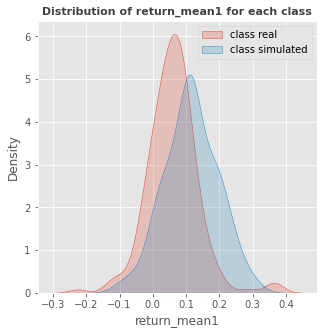

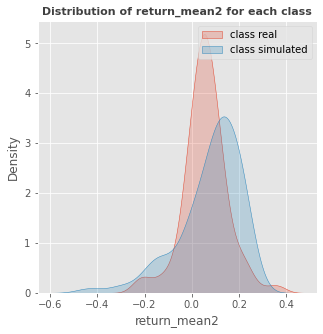

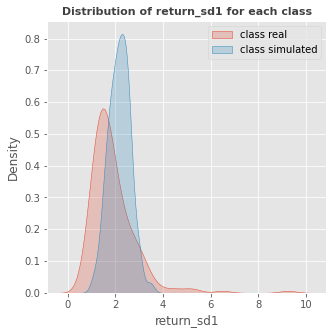

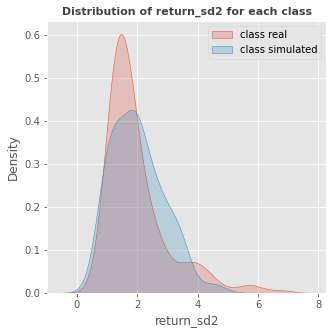

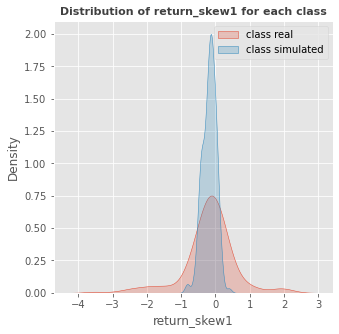

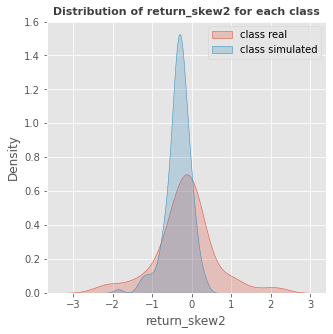

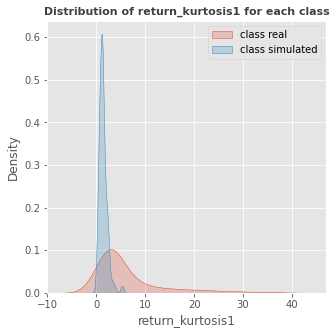

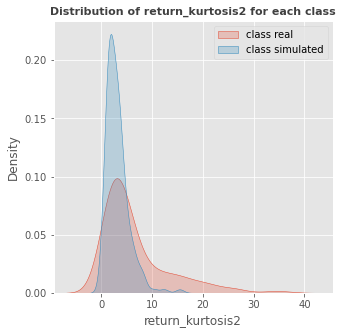

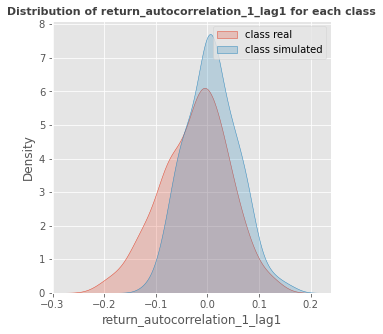

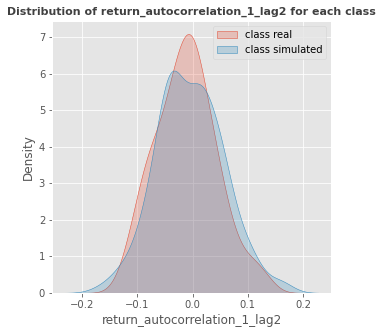

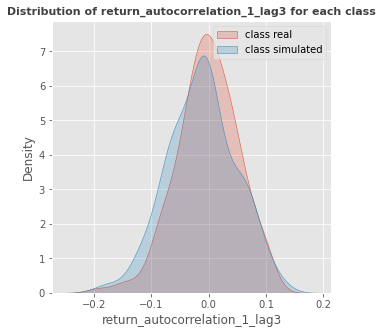

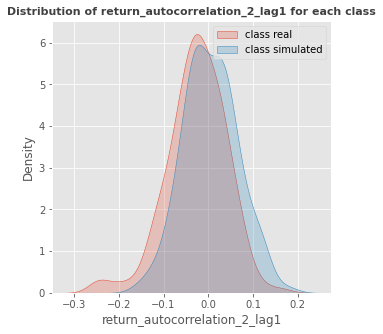

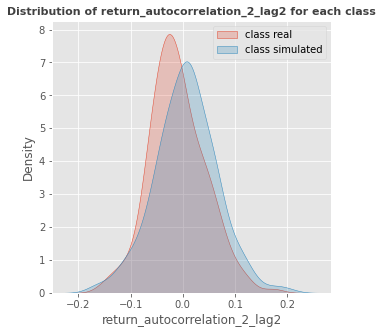

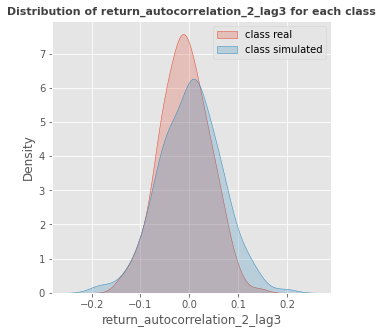

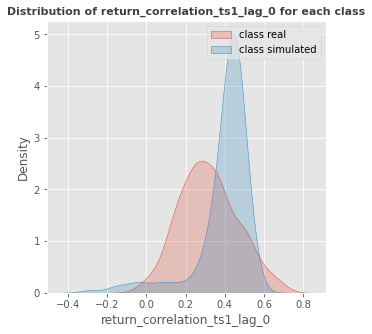

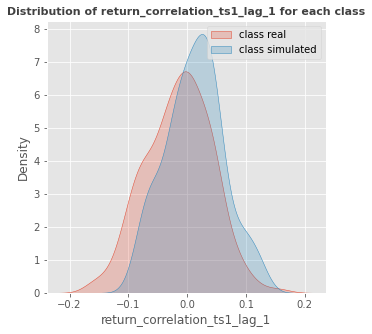

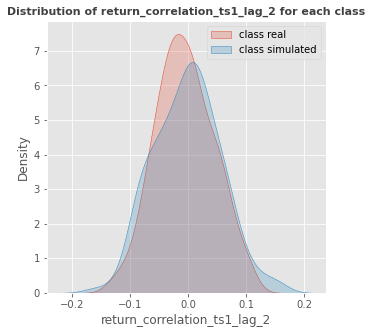

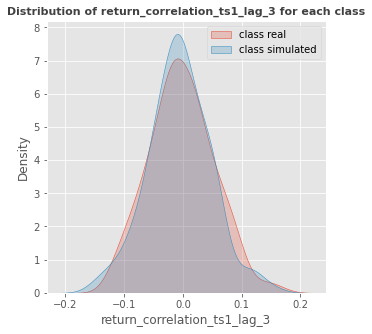

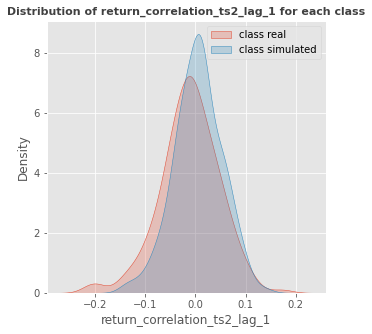

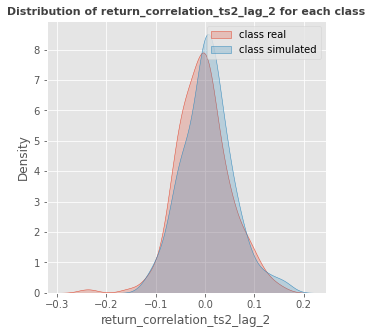

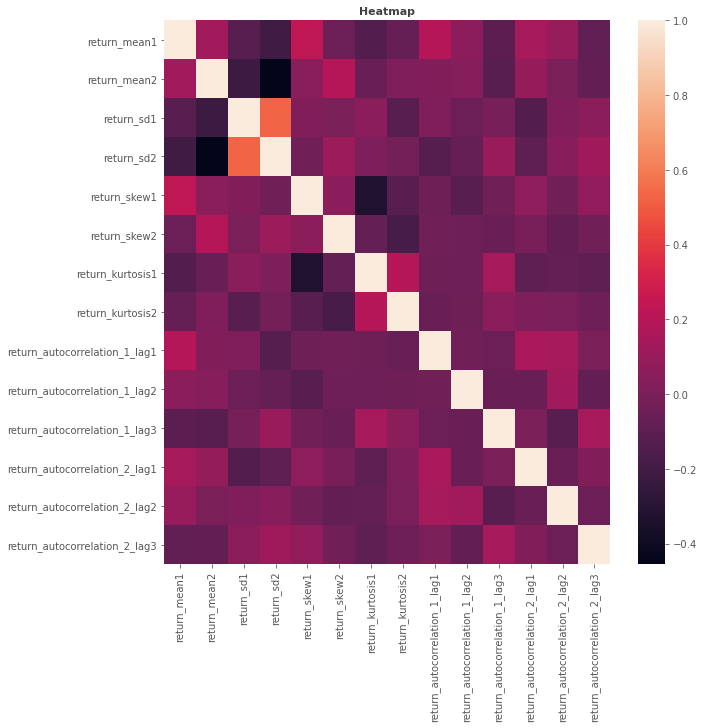

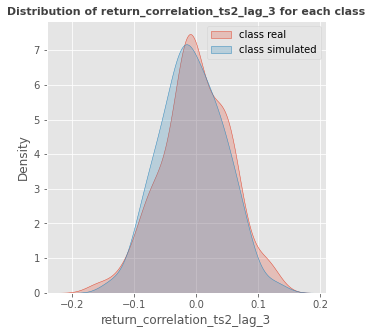

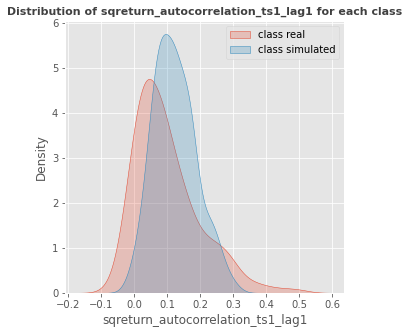

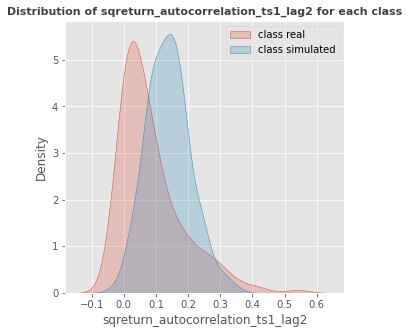

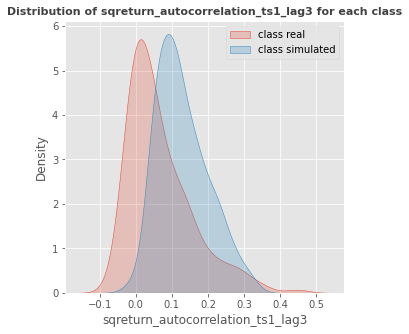

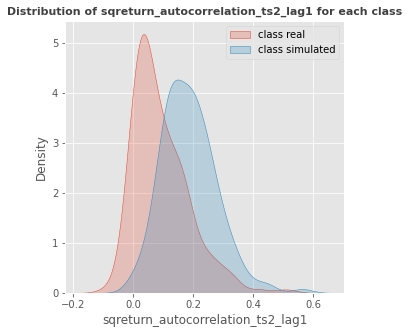

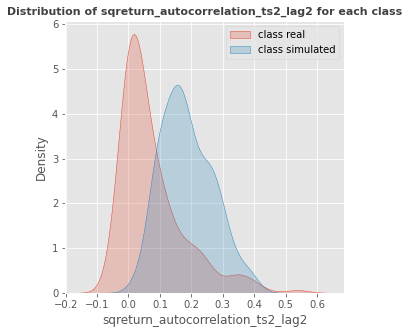

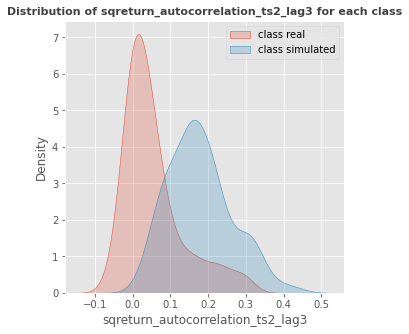

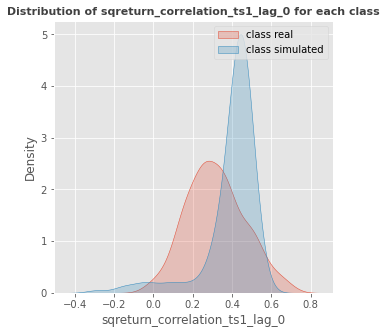

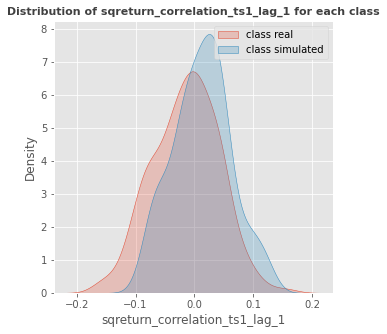

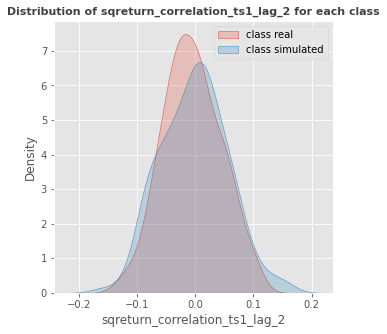

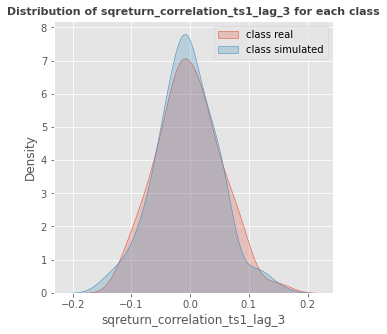

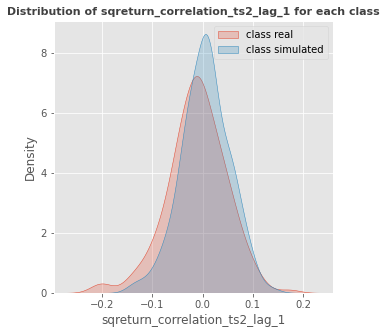

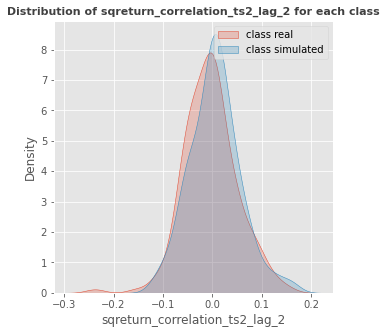

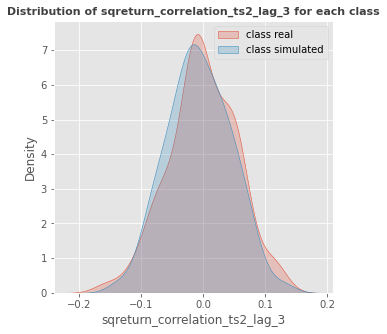

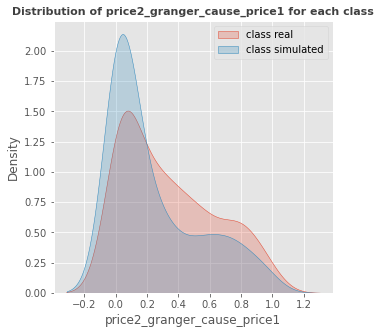

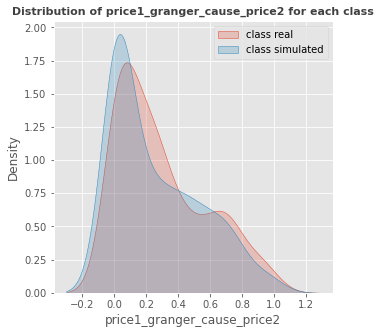

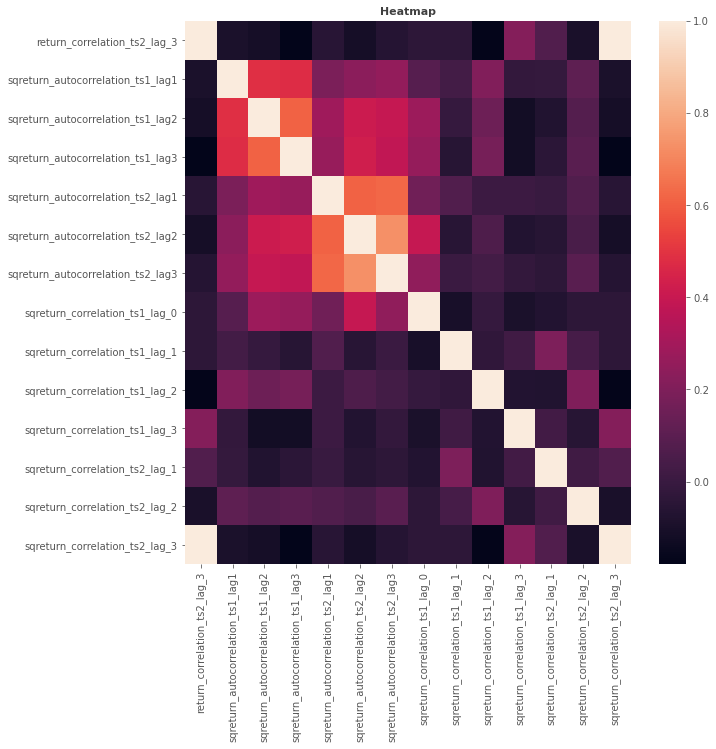

In [32]:
plt.rc('figure', max_open_warning = 0)
EDA.extensive_eda(X_train.iloc[:, 0:20], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_stvol")
EDA.extensive_eda(X_train.iloc[:, 20:36], y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/ou_jump_stvol/EDA_stvol")

In [1]:
import numpy as np
params = ((
    0.85272425, 1.80206661, 1.20561153, 
    0.68418814, 1.28954368, 1.07591524, 
    0.22550489, 0.05013770, 0.22983639, 0.05207420, 
    0.16579052, 0.29698842, 0.25899734, 0.25719007, 
    0.06698207, 0.32037384, 0.07144347, 0.08383883,
    0.48783726, 0.42366372, 0.40349627, 0.74223950))

print('mu1')
print(params[0])
print('kappa2')
print(params[2])
print('mu2')
print(params[1]/params[2])
print('mu3')
print(params[3])
print('kappa4')
print(params[5])
print('mu4')
print(params[4]/params[5])

print('sigma11')
print(params[6])
print('sigma12')
print(params[7])
print('sigma13')
print(params[8])
print('sigma14')
print(params[9])

print('sigma21*')
print(params[10])
print('sigma22*')
print(params[11])
print('sigma23*')
print(params[12])
print('sigma24*')
print(params[13])

print('sigma31')
print(params[14])
print('sigma32')
print(params[15])
print('sigma33')
print(params[16])
print('sigma34')
print(params[17])

print('sigma41*')
print(params[18])
print('sigma42*')
print(params[19])
print('sigma43*')
print(params[20])
print('sigma44*')
print(params[21])

mu1
0.85272425
kappa2
1.20561153
mu2
1.4947323952683165
mu3
0.68418814
kappa4
1.07591524
mu4
1.1985550832052532
sigma11
0.22550489
sigma12
0.0501377
sigma13
0.22983639
sigma14
0.0520742
sigma21*
0.16579052
sigma22*
0.29698842
sigma23*
0.25899734
sigma24*
0.25719007
sigma31
0.06698207
sigma32
0.32037384
sigma33
0.07144347
sigma34
0.08383883
sigma41*
0.48783726
sigma42*
0.42366372
sigma43*
0.40349627
sigma44*
0.7422395
